<p style="font-size: 46pt; margin-bottom: 1em; margin-top: 1em;">Many-body tensor representation</p>
<p style="font-size: 18pt; line-height: 120%; margin-bottom: 1em;">Experiments from Haoyan Huo and Matthias Rupp: Unified Representation for Machine Learning of Molecules and Crystals, 2022.</p>

# Initialization

Loading of Python libraries and <tt>qmmlpack</tt>.

In [1]:
# import libraries
import sys, os
import re, zipfile, json, math, gc
import ast, itertools, hashlib, gzip, pickle
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator
import IPython
from collections import defaultdict

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

np.set_printoptions(linewidth=90)

# load repository version of qmmlpack, not system-wide version
# adapt path according to local installation, or comment out if qmmlpack is available on a system-wide path
sys.path.insert(0, os.path.join(
    os.path.realpath('.'),
    '../qmmlpack/python'))
import qmmlpack as qmml

Code used throughout notebook.

In [2]:
def cached(max_entries=sys.maxsize):
    """Memoization decorator.
    
    Allows caching of function values for representation and kernel functions.
    
    A maximum number of results to be stored can be specified via max_entries.
    
    functools.lru_cache does not accept mutable objects such as NumPy's ndarray.
    
    Caching the functions directly (as opposed to automatic caching within code for experiments) 
    allows caching over multiple experiments."""
    return lambda f: _cached(f, max_entries=max_entries)

class _cached:
    """Implementation of memoization decorator."""
    
    def __init__(self, f, max_entries=sys.maxsize):
        """Wraps f in a caching wrapper."""
        self.f = f  # cached function
        self.max_entries = max_entries  # maximum number of results to store
        self.cache = {}  # stores pairs of hash keys and function results 
        self.lruc = 0  # least recently used counter
        self.hashf = None  # hashing function, initialized by __call__
        self._intbuf = np.empty((1,), dtype=int)  # buffer for temporary storage of hash() values
        self.hits, self.misses = 0, 0  # number of times function values were retrieved from cache/had to be computed 
        self.total_hits, self.total_misses = 0, 0  # statistics over lifetime of cached object
        
    def _hash(self, arg):
        """Hashes an argument."""
        try:
            self.hashf.update(arg)
        except:
            self._intbuf[0] = hash(arg)
            self.hashf.update(self._intbuf)
        
    def __call__(self, *args, **kwargs):
        """Calls to cached function."""
        
        # compute hash key of arguments
        self.hashf = hashlib.md5()  # non-cryptographic fast hash function
        for i in args: self._hash(i)
        for i in kwargs: self._hash(kwargs[i])
        key = self.hashf.digest()
        
        # return stored or computed value
        if key in self.cache:
            self.total_hits, self.hits = self.total_hits + 1, self.hits + 1
            item = self.cache[key]
            item[0] = self.lruc; self.lruc += 1
            return item[1]
        else:
            self.total_misses, self.misses = self.total_misses + 1, self.misses + 1
            value = self.f(*args, **kwargs)
            self.cache[key] = [self.lruc, value]; self.lruc += 1

            # remove another entry if new entry exceeded the maximum
            if len(self.cache) > self.max_entries:
                c, k = self.lruc, key
                for k_,v_ in self.cache.items():
                    if v_[0] < c: c, k = v_[0], k_
                del self.cache[k]
            
            return value
        
    def clear_cache(self):
        """Empties cache, releasing memory."""
        self.cache.clear()
        self.hits, self.misses = 0, 0

In [3]:
from qmmlpack.lib import is_sequence, QMMLException

class AdaptiveGridSearch:
    """Optimization of several variables via local gradient descent on a logarithmic grid.

    Interface:
      __init__ - sets up adaptive grid search
      step() - takes one optimization step
      stats() - returns statistics on optimization so far"""

    def _parse_variable(self, v):
        """Parses one variable.

        0  initial value
        1  priority
        2  step size
        3  min
        4  max
        5  direction
        6  base"""

        defaults = (0., 1, 1., -np.inf, +np.inf, 0, 2.)
        keywords = ((0,'value'), (1,'priority'), (2,'stepsize'), (3,'min'), (3,'minimum'), (4,'max'), (4,'maximum'), (5,'direction'), (6,'base'))

        # dictionary specification
        if isinstance(v, dict):
            vv = list(defaults)
            for (i,kw) in keywords:
                if kw in v: vv[i] = v[kw]
            v = vv

        if not is_sequence(v): raise QMMLException("Invalid variable specification")

        # initial value
        iv = defaults[0] if len(v) < 1 else float(v[0])

        # priority
        p = defaults[1] if len(v) < 2 else int(v[1])
        if len(v) >= 2 and p != v[1]: raise QMMLException("Non-integer priority specified")
        if p <= 0: raise QMMLException("Invalid priority specified")

        # step size
        s = defaults[2] if len(v) < 3 else float(v[2])
        if s <= 0: raise QMMLException("Invalid step size specified")

        # minimum
        rmin = defaults[3] if len(v) < 4 else v[3]

        # maximum
        rmax = default[4] if len(v) < 5 else v[4]

        # direction
        d = defaults[5] if len(v) < 6 else int(v[5])
        if len(v) >= 6 and d != v[5]: raise QMMLException("Non-integer direction specified")
        if d not in (-1, 0, +1): raise QMMLException("Invalid direction specified")

        # base
        b = defaults[6] if len(v) < 7 else float(v[6])
        if b <= 0: raise QMMLException("Invalid base specified")

        # additional tests
        if rmin >= rmax: raise QMMLException("Invalid range specified")
        if not (rmin <= iv <= rmax): raise QMMLException("Initial value not in range")

        return [iv, p, s, rmin, rmax, d, b]

    def __init__(self, f, variables, resolution=None):
        """AdaptiveGridSearch(f, {v1,v2,...}, resolution=None) finds local minimum of f(v1,v2,...) via local gradient descent on a logarithmic grid.

        Parameters:
          f - function to be minimized
          v1,v2,... - variables, see below
          resolution - if specified as a number a, f(...) will be rounded to multiples of a

        A variable is a tuple {val, pri, stp, min, max, dir, b}, where
          val = initial value; real number; exponent to base b
          pri = priority; positive integer; higher priorities are optimized before lower ones; several variables may have the same priority
          stp = step size; positive real number; refers to exponent
          min = lowest allowed value for variable, val in [min,max]
          max = highest allowed value for variable, val in [min,max]
          dir = direction; either -1 (small values preferred), 0 (indifferent), +1 (large values preferred)
          b   = base; positive real number
          Later entries can be omitted. Default values are (0., 1, 1., (-np.inf,+np.inf), 0, 2., (True,True)).
          The logarithmized grid is the intersection between ...,i-2s,i-s,i,i+s,i+2s,... and (min,max).
          Alternatively, a dictionary with possible keys 'value', 'priority', 'stepsize', 'min', 'max', 'direction', 'base' can be specified.

        Once the grid search is initialized, optimization steps can be taken via step().
        Data member stats yields statistics on the optimization so far.

        If optimizing an expensive function, such as hyperparameters of a machine learning model, it is important that f uses cached values.
        For example, if optimizing performance of a kernel learning model, kernel matrices for different values of kernel hyperparameters should be cached where possible."""

        # the descent can not cross itself, but a visited list helps avoid retrying unsuccessful grid points, reducing number of steps.

        # initialize state
        self._vars = np.asarray([self._parse_variable(v) for v in variables])
        self._f = f
        self._resolution = None if resolution is None else float(resolution)

        self.num_vars = len(self._vars)
        self.num_steps = 0
        self.num_evals = 0
        self.update = False
        self.done = False
        self.conv = [False] * len(self._vars)  # indicates which variables to optimize; True entries are currently converged
        self.dirs = [np.random.choice([-1,1]) if v[5] == 0 else int(v[5]) for v in self._vars]
        self.cur_ind = 0  # index of variable currently being iterated
        self.cur_v = np.copy(self._vars[:, 0])  # current values of variables
        self.trial_v = np.empty_like(self.cur_v)  # last tried values of variables
        self.trial_f = None  # f of last tried values of variables
        self.best_v = np.copy(self.cur_v)  # best solution so far
        self.best_f = np.inf;  # f of best solution so far, f(best_v)
        self.visited = set()  # visited grid points so far

        # initialize optimization
        self._trial(0.)
        self.update = False  # force determination of cur_ind

    def _trial(self, step):
        ind = self.cur_ind  # shorthand
        self.update = False

        # take step
        self.trial_v[:] = self.cur_v
        self.trial_v[ind] += step

        # check for range (clamping incurs some unnecessary calls of f, but allows variable to change direction)
        self.trial_v[ind] = max(self._vars[ind,3], min(self.trial_v[ind], self._vars[ind, 4]))  # clamp to [min, max]

        # check if visited already
        if tuple(self.trial_v) in self.visited: return

        # call f
        trialpowers = np.power(self._vars[:, 6], self.trial_v)
        self.trial_f = self._f(*trialpowers)
        self.num_evals += 1
        self.visited.add(tuple(self.trial_v))
        if self._resolution is not None:
            # rounds to precision of resolution, then to number of significant digits to avoid trailing noise in last digits
            # https://stackoverflow.com/a/28427814/3248771
            self.trial_f = round( round(self.trial_f / self._resolution) * self._resolution, -int(math.floor(math.log10(self._resolution))))

        # update if improvement
        if self.trial_f < self.best_f:
            self.cur_v[:] = self.trial_v
            self.best_v[:] = self.trial_v
            self.best_f = self.trial_f
            self.update = True
            self.conv = [False] * self.num_vars

    def step(self):
        """Takes one optimization step.

        The step taken can involve multiple evaluations of f."""

        if self.done: return

        # determine variable to optimize next
        if not self.update:
            self.cur_ind = [i for (i,d) in enumerate(self.conv) if not d]  # variables currently being optimized
            self.cur_ind = [i for i in self.cur_ind if self._vars[i,1] == max(self._vars[self.cur_ind, 1])]  # variables with highest priority
            self.cur_ind = np.random.choice(self.cur_ind)

        # take one step into direction
        if self._vars[self.cur_ind, 5] in (-1,+1):
            self.dirs[self.cur_ind] = int(self._vars[self.cur_ind, 5])  # if not, keep last direction
        self._trial(self.dirs[self.cur_ind] * self._vars[self.cur_ind, 2])

        # change direction if unsuccessful
        if not self.update:
            self.dirs[self.cur_ind] *= -1
            self._trial(self.dirs[self.cur_ind] * self._vars[self.cur_ind, 2])

        # if no update, variable is converged
        if not self.update:
            self.conv[self.cur_ind] = True

        # update statistics
        self.num_steps += 1

        # test termination condition
        if all(self.conv): self.done = True

    def __bool__(self):
        """Indicates whether optimization is ongoing or done."""
        return not self.done

    def __str__(self, verbose=False):
        """Returns formatted statistics."""
        s = self.stats()
        if verbose == 'compact':
            descr = \
                "#{}({}): {} -> {}  ({})".format(s['num_steps'], s['num_evals'], tuple(s['best_vals']), \
                s['best_f'], ''.join(["T " if c else "F " for c in s['converged']]) )
        else:
            descr = \
                "{}\n\n".format(self.__class__.__name__) + \
                "#vars = {}, #steps = {}, #evals = {}, done = {}\n".format(s['num_vars'], s['num_steps'], s['num_evals'], s['done']) + \
                "best solution: f{} = {}\n".format(tuple(s['best_vals']), s['best_f']) + \
                "var = {}, update = {}\n".format(s['cur_var'], s['update']) + \
                "converged vars: {}, ".format(' '.join(["T " if c else "F " for c in s['converged']])) + \
                "directions: {}\n".format(' '.join(['{:+d}'.format(d) for d in s['directions']])) + \
                ( "" if not verbose else "\nvisited:\n{}".format(''.join(sorted(['  {}\n'.format(v) for v in s['visited']]))) )
        return descr

    def stats(self):
        """Returns dictionary with statistics on the course of the optimization so far.

          variables - variables settings
          resolution - resolution
          num_vars - number of variables (arity of f)
          num_steps - number of times step() was called
          num_evals - number of times f was evaluated
          update - whether best solution was updated last step
          done - True if optimization is finished
          converged - which variables are currently in local minima
          directions - current directions of variables
          cur_var - index of currently optimized variable
          cur_vals - current values of variables
          trial_vals - last tried values of variables
          trial_f - function value for trial_vals
          best_vals - best found variable values so far
          best_f - function value for best_vals
          visited - set of variable values visited so far
        """

        return {
            'variables' : self._vars,
            'resolution': self._resolution,
            'num_vars'  : self.num_vars,
            'num_steps' : self.num_steps,
            'num_evals' : self.num_evals,
            'update'    : self.update,
            'done'      : self.done,
            'converged' : self.conv,
            'directions': self.dirs,
            'cur_var'   : self.cur_ind,
            'cur_vals'  : self.cur_v,
            'trial_vals': self.trial_v,
            'trial_f'   : self.trial_f,
            'best_vals' : self.best_v,
            'best_f'    : self.best_f,
            'visited'   : self.visited
        }

In [4]:
class EvaluateModelPerformance:
    """Performance of a kernel ridge regression model.
    
    Returns loss of kernel regression model on validation set using given hyperparameters.
    Implemented as a stateful functor."""
    
    def __init__(self, z, r, y, indtrain, indvalid, reprf, kernelf, lossf, paramf, basis=None, centering=False, maxcache=False):
        """Sets up model performance evaluator.
        
        z, r, y, basis - atomic numbers, atom coordinates, property values and basis vectors
        indtrain, indvalid - indices into z, r, y, basis of training and validation sets
        reprf - function f(z, r, basis, theta) returning n x d representation matrix, where 
                n is number of data points and d is dimensionality of representation; can be a list of functions
        kernelf - kernel function
        lossf - loss function f(true, pred, state, z) returning a single summary statistic of the performance
        paramf - function accepting one parameter vector theta, which it splits into 
            individual parameter vectors for representation, kernel and method.
        centering - whether to center the kernelf
        maxcache - if True, reprf and kernelf will always be called for the whole input, 
                   maximixing cache exploitation across large series of experiments such as learning curves.
        
        If reprf is a list, representations are cached separately and concatenated.
        
        The employed representation and kernel functions should cache (memoize) their values.
        This caching is best done outside of this class by the actual functions to maximize speed gains across
        different instances of EvaluateModelPerformance."""

        # parameters
        self.z, self.r, self.y, self.indtrain, self.indvalid, self.reprf, self.kernelf, self.lossf, self.paramf, \
            self.b, self.centering, self.maxcache = z, r, y, indtrain, indvalid, reprf, kernelf, lossf, paramf, \
            basis, centering, maxcache
        if not qmml.is_sequence(self.reprf): self.reprf = (self.reprf,)  # always a sequence
        
    def reset(self, z=None, r=None, y=None, indtrain=None, indvalid=None, reprf=None, kernelf=None, lossf=None, \
              paramf=None, basis=None, centering=None, maxcache=None):
        """Modifies parametrization."""

        if z is not None: self.z = z
        if r is not None: self.r = r
        if y is not None: self.y = y
        if indtrain is not None: self.indtrain = indtrain
        if indvalid is not None: self.indvalid = indvalid
        if reprf is not None: self.reprf = reprf  # sequence will be ensured by __init__ below
        if kernelf is not None: self.kernelf = kernelf
        if lossf is not None: self.lossf = lossf
        if paramf is not None: self.paramf = paramf
        if basis is not None: self.b = basis
        if centering is not None: self.centering = centering
        if maxcache is not None: self.maxcache = maxcache

        self.__init__(self.z, self.r, self.y, self.indtrain, self.indvalid, self.reprf, self.kernelf, self.lossf, \
                      self.paramf, basis=self.b, centering=self.centering, maxcache=self.maxcache)

    def __call__(self, *theta):
        """Evaluates model performance for given hyperparameters theta."""

        # parameter vectors
        (theta_repr, theta_kernel, theta_method) = self.paramf(*theta)
        if len(theta_repr) == 0 or not qmml.is_sequence(theta_repr[0]): theta_repr = [theta_repr]
        theta_repr = tuple(tuple(theta) for theta in theta_repr)
        theta_kernel, theta_method = tuple(theta_kernel), tuple(theta_method)
        
        # representation and kernel matrices
        if self.maxcache:  # call reprf and kernelf for all inputs
            # representation
            repr_ = [rf(self.z, self.r, basis=self.b, theta=rt) for (rf,rt) in zip(self.reprf, theta_repr)]
            repr_ = np.concatenate(repr_, axis=1)
            # kernel matrix
            M = self.kernelf(repr_, theta=theta_kernel)
            # reduce to training and test sets
            reprtrain, reprvalid = repr_[self.indtrain], repr_[self.indvalid]
            K, L = M[np.ix_(self.indtrain, self.indtrain)], M[np.ix_(self.indtrain, self.indvalid)]
        else:  # call reprf and kernelf only for training and validation sets
            # representation
            (btrain, bvalid) = (None, None) if self.b is None else (self.b[self.indtrain], self.b[self.indvalid])
            reprtrain = [rf(self.z[self.indtrain], self.r[self.indtrain], basis=btrain, theta=rt) for (rf,rt) in zip(self.reprf, theta_repr)]
            reprvalid = [rf(self.z[self.indvalid], self.r[self.indvalid], basis=bvalid, theta=rt) for (rf,rt) in zip(self.reprf, theta_repr)]
            reprtrain, reprvalid = np.concatenate(reprtrain, axis=1), np.concatenate(reprvalid, axis=1)
            # kernel matrices
            K = self.kernelf(reprtrain, theta=theta_kernel)
            L = self.kernelf(reprtrain, reprvalid, theta=theta_kernel)
   
        # model and predictions
        krr = qmml.KernelRidgeRegression(K, self.y[self.indtrain], theta_method, centering=self.centering)
        pred = krr(L)

        # loss
        self.loss = lambda: None  # dummy object for storing additional data computed by lossf
        loss = self.lossf(self.y[self.indvalid], pred, state=self.loss, z=self.z[self.indvalid])
        return loss

In [5]:
def setup_train_valid(ind, ntrain, nvalid, y=None):
    """Sets up training and validation folds (index subsets) for model selection.
    
    Data indices are split into disjunct training and validation set.
    If labels are given, training and validation sets are stratified to reduce variance."""
    
    ind = np.asarray(ind, dtype=int)
    
    n = len(ind)
    assert ntrain + nvalid <= n
    assert y is None or len(y) == n
    
    # validation set
    if y is None: # random sampling
        indvalid = np.random.choice(ind, size=nvalid, replace=False)
    else:  # stratified sampling
        indvalid = ind[ [np.random.choice(stratum) for stratum in qmml.stratify(y, nvalid)] ]
    
    # training set
    indrem = np.nonzero(np.in1d(ind, indvalid, invert=True))[0]  # remaining indices not in indvalid
    if y is None: # random sampling
        indtrain = np.random.choice(ind[indrem], size=ntrain, replace=False)
    else:  # stratified sampling
        indtrain = ind[indrem][ [np.random.choice(stratum) for stratum in qmml.stratify(y[indrem], ntrain)] ]
    
    # verify
    assert indtrain.size == ntrain and indvalid.size == nvalid
    assert np.intersect1d(indtrain, indvalid).size == 0
    
    return (indtrain, indvalid)

In [6]:
def lossf(true, pred, state=None, z=None, return_='root_mean_squared_error'):
    """Augmented loss function.
    
    Parameters:
      true - reference labels
      pred - predicted labels
      state - if passed, reference values, predictions, residuals and loss function values will be
              stored as true, pred, residuals, loss. If z is passed, sizes and residuals_pa as well.
      z - atomic numbers; if passed, loss per atom will be computed in addition
      return_ - name of summary statistic to return."""

    residuals = np.asfarray(pred - true)
    loss = qmml.loss(true, pred)
    
    # if available, compute loss functions normalized by number of atoms
    if z is not None:
        assert len(z) == len(residuals)
        
        sizes = np.asarray([len(m) for m in z])  # number of atoms per system
        residuals_pa = residuals / sizes

        rmsepa = math.sqrt(np.mean(residuals_pa**2)) # RMSE per atom
        loss['root_mean_squared_error_per_atom'] = rmsepa
        
        maepa = np.mean(np.abs(residuals_pa))  # MAE per atom
        loss['mean_absolute_error_per_atom'] = maepa
        
        maxaepa = max(np.abs(residuals_pa))  # maxAE per atom
        loss['maximum_absolute_error_per_atom'] = maxaepa
    
    # if state is available, store statistics
    if state is not None:
        state.true, state.pred, state.residuals, state.loss = true, pred, residuals, loss
        if z is not None:
            state.sizes, state.residuals_pa = sizes, residuals_pa

    # quantity to return
    return loss[return_]

In [7]:
def pretty_print_loss(loss, digits=2, addloss=None):
    """Formats loss function values as a human-readable string.
    
    Parameters:
      loss - result of loss function
      digits - number of digits after decimal point
      addloss - additional summary statistics to print (if contained in loss)
                list of 2-tuples (long name, abbreviation)"""
    
    if addloss is None: 
        addloss = [ 
            ('root_mean_squared_error_per_atom', 'RMSE/a '), \
            ('mean_absolute_error_per_atom'    , 'MAE/a  '), 
            ('maximum_absolute_error_per_atom' , 'maxAE/a')]
    res = \
        'n       = {}\n'      .format(loss['number_of_samples'])               + \
        'RMSE    = {:0.{}f}\n'.format(loss['root_mean_squared_error'], digits) + \
        'MAE     = {:0.{}f}\n'.format(loss['mean_absolute_error'], digits)     + \
        'R^2     = {:0.6f}\n' .format(loss['correlation_squared'])             + \
        'maxAE   = {:0.{}f}\n'.format(loss['maximum_absolute_error'], digits)
        
    for al in addloss: 
        if al[0] in loss: res += '{} = {:0.{}f}\n'.format(al[1], loss[al[0]], digits)

    return res

In [8]:
def dataset_info(z, r, e, basis=None, verbose=None):
    """Information about a dataset.
    
    Returns a dictionary containing information about a dataset.
    
    Parameters:
      z - atomic numbers
      r - atom coordinates, in Angstrom
      e - energies
      basis - basis vectors for periodic systems
      verbose - if True, also prints the information
    
    Information:
      elements - elements occurring in dataset
      max_elements_per_system - largest number of different elements in a system
      max_same_element_per_system - largest number of same-element atoms in a system
      max_atoms_per_system - largest number of atoms in a system
      min_distance - minimum distance between atoms in a system
      max_distance - maximum distance between atoms in a system    
    """
    assert len(z) == len(r) == len(e)
    assert basis is None or len(basis) == len(z)

    i = {}
    
    i['number_systems'] = len(z)
    
    # elements
    i['elements'] = np.unique(np.asarray([a for s in z for a in s], dtype=int)) 
    i['max_elements_per_system'] = max([np.nonzero(np.bincount(s.astype(int)))[0].size for s in z])
    i['max_same_element_per_system'] = max([max(np.bincount(s.astype(int))) for s in z]) 
    
    # systems
    i['max_atoms_per_system'] = max([len(s) for s in z])
    i['systems_per_element'] = np.asarray([np.sum([1 for m in z if el in m]) for el in range(118)], dtype=int)
    
    # distances
    assert len(r) > 0
    dists = [qmml.lower_triangular_part(qmml.distance_euclidean(rr), -1) for rr in r]
    i['min_distance'] = min([min(d) for d in dists if len(d) > 0])
    i['max_distance'] = max([max(d) for d in dists if len(d) > 0])
    
    # verbose output
    if verbose:
        if basis is None: print('{} finite systems (molecules)'.format(i['number_systems']))
        else: print( '{} periodic systems (materials)'.format(i['number_systems']) )    
        print('elements: {} ({})'.format(' '.join([qmml.element_data(el, 'abbreviation') \
            for el in i['elements']]), len(i['elements'])))
        print('max #els/system: {};  max #el/system: {};  max #atoms/system: {}'.format( \
            i['max_elements_per_system'], i['max_same_element_per_system'], i['max_atoms_per_system']))
        print('min dist: {:3.2f};  max dist: {:3.2f};  1/min dist: {:3.2f};  1/max dist: {:3.2f}'.format( \
            i['min_distance'], i['max_distance'], 1./i['min_distance'], 1./i['max_distance']))
        
    return i

In [9]:
def import_dataset_xyz(zipfn, datafn, addpts=False, ysplitchrs=';\[|\],\[|,|\[|\]| ', n=None):
    """Loads dataset in (extended) xyz format.
    
    Parameters:
      zipfn - name of compressed archive file
      datafn - name of file in extended xyz format
      addpts - whether systems contain additional property lines
      ysplitchrs - characters at which to split the property line as regular expression
      n - number of expected systems"""
    
    # load raw data
    with zipfile.ZipFile(zipfn, 'r') as zf:
        raw = zf.read(datafn).decode('ascii')
        
    # parse XYZ format
    xyzdata = qmml.import_extxyz(raw, additional_properties=addpts)
    
    # extract information
    z = np.asarray([m.an for m in xyzdata], dtype=object)
    r = np.asarray([m.xyz for m in xyzdata], dtype=object)
    parsef = lambda s: [float(ss) for ss in re.split(ysplitchrs, s) if ss != ''] if isinstance(s, str) else s
    y = np.asarray([[parsef(mp) for mp in m.mp] for m in xyzdata])
    if len(y.shape) == 3 and y.shape[1] == 1: y = y[:,0,:]
    elems = np.unique([el for m in z for el in m]) # element species universe

    if n is not None and (n != len(z) or n != len(r) or n != len(y)): 
        raise RuntimeError('unexpected number of systems')
    
    return (z, r, y, elems, len(z))

In [10]:
def import_dataset_json(zipfn, datafn, ctrl, n=None):
    """Imports a dataset in the format of the elpasolite dataset.
    
    Parameters:
      zipfn, datafn - filenames of ZIP container and compressed data file inside
      ctrl - list of data blocks to parse
      n - expected number of systems
      
    Returns:
      z, r, e, b, sizes, elems, sg, details, n
    """
    
    # load raw data from file
    with zipfile.ZipFile(zipfn, 'r') as zf:
        raw = zf.read(datafn).decode('ascii')
    
    # split into blocks, one for each crystal
    raw = re.split(r'--- \d+ ---\n', raw)[1:]  
    if n is not None and len(raw) != n: raise RuntimeError('Unexpected number of parsed entries.')
        
    # parse content via regular expressions
    tokens = {
        'FE/a'   : r'Formation energy \(eV/atom\):\s*'+ r'(?P<energy>(-?\d+\.\d+))\s*'         ,
        'TE'     : r'Total Energy \(eV/cell\):\s*'    + r'(?P<energy>(-?\d+\.\d+))\s*'         ,
        'FE'     : r'Formation enthalpy \(eV\):\s*'   + r'(?P<energy>(-?\d+\.\d+))\s*'         ,
        'V'      : r'Cell Volume:\s+'                 + r'\d+\.\d+\s+'                         ,
        'R'      : r'Coordinates:\s+'                 + r'(?P<coord>((-?\d+\.\d+\s+){3})+)'    ,
        'B'      : r'Cell:\s+'                        + r'(?P<cell>((-?\d+\.\d+\s+){3})+)'     ,
        'a'      : r'Atoms:\s+'                       + r'(?P<atoms>([a-zA-Z]{1,3}\s+)+)'      ,
        'sg'     : r'Space group:\s+'                 + r'(?P<spacegroup>([A-Za-z0-9\-/]+))\s+',
        'repr'   : r'Representation:\s+'              + r'(\d+\s+\d+\s+)+'                     ,
        'details': r'Calculation Details:\s+'         + r'(?P<details>(.+\n?))'                ,
        'end'    : r'(end\s*)?'
    }        
    grammar = re.compile(''.join([tokens[c] for c in ctrl]), flags=re.ASCII)
    raw = [re.fullmatch(grammar, s) for s in raw]
    assert None not in raw

    # extract information
    z = np.asarray([np.asarray([qmml.element_data(el, 'atomic number') for el in m.group('atoms').split()]) for m in raw])
    sizes = np.asarray([len(m) for m in z], dtype=int)  # number of atoms in each structure
    elems = np.unique([el for m in z for el in m]) # element species universe
    
    e = np.asfarray([float(m.group('energy')) for m in raw])
    if 'FE/a' in ctrl: e = e * sizes  # convert to energy per cell if necessary

    b = np.asarray([np.reshape(np.asarray([float(f) for f in m.group('cell').split()]), (3, 3)) for m in raw])
    r = np.asarray([np.reshape(np.asarray([float(f) for f in m.group('coord').split()]), (-1, 3)) for m in raw])
    r = np.asarray([[r_[0]*b_[0] + r_[1]*b_[1] + r_[2]*b_[2] for r_ in rr] for (b_,rr) in zip(b,r)]) # Cartesian coordinates
    
    sg = [m.group('spacegroup') for m in raw] if 'sg' in ctrl else None
    details = [m.group('details') for m in raw] if 'details' in ctrl else None  # calculation details
    
    n = len(z)

    return (z, r, e, b, sizes, elems, sg, details, n)

In [26]:
def paramf(aa, bb, cc):
    """Parameter splitting function dividing parameters into three blocks of sizes a, b, c.
    
    a, b, c are numbers of parameters.
    a can also be a list of numbers of parameters.
    
    paramf([1,2], 0, 1)(['a', 'b', 'c', 'd']) -> ([('a',), ('b', 'c')], tuple(), ('d',))"""
    def f(a, b, c, *theta):
        if qmml.is_sequence(a):
            # multiple representation functions
            # as we have only need for cases 2 and 3, no need to generalize
            assert len(a) == 2 or len(a) == 3
            resa = [ tuple(theta[:a[0]]), tuple(theta[a[0]:a[0]+a[1]]) ]
            if len(a) == 3: resa.append( tuple(theta[a[0]+a[1]:a[0]+a[1]+a[2]]) )
            a = np.sum(a)
        else:
            # single representation function
            resa = tuple(theta[:a])
        return ( resa, tuple(theta[a:a+b]), tuple(theta[a+b:a+b+c]) )
    return lambda *theta: f(aa, bb, cc, *theta)

# Molecule energies (Table 1)

## Data

This dataset was published in

> Grégoire Montavon, Matthias Rupp, Vivekanand Gobre, Alvaro Vazquez-Mayagoitia, Katja Hansen, Alexandre Tkatchenko, Klaus-Robert Müller, O. Anatole von Lilienfeld: 
> Machine learning of molecular electronic properties in chemical compound space, New Journal of Physics 15(9): 095003, 2013. 
> [DOI](https://doi.org/10.1088/1367-2630/15/9/095003)

In [14]:
z, r, y, elems, n = import_dataset_xyz('datasets/gdb7-13.zip', 'dsgdb7njp.xyz', addpts=True, n=7211)
e, a = y[:,0], y[:,1]; del y

## Models

Split data into training and validation set for performance estimation.
The training set is again split into inner training and validation set for hyperparameter optimization.
Stratification is used to reduce variance; outer sets, where energies would not be available, use size, which is correlated to energy; inner sets, where energies are available, use those.
There are too few molecules with 4 or less non-H atoms for interpolation.
We therefore require these 59 molecules to be in the training set.

In [15]:
np.random.seed(1)

sizes_wh = np.asarray([len(mol) for mol in z])  # number of atoms
sizes_nh = np.asarray([sum([1 if an != 1 else 0 for an in mol]) for mol in z])  # number of non-H atoms

indsmall = np.where(sizes_nh < 5)[0]; k = indsmall.size
indother = np.setdiff1d(range(n), indsmall)

(indtrain1, indvalid1) = setup_train_valid(indother, 5000-k, n-5000, sizes_wh[indother])
(indtrain2, indvalid2) = setup_train_valid(indtrain1, 5000-k-300, 300, e[indtrain1])

indtrain1, indtrain2 = np.union1d(indtrain1, indsmall), np.union1d(indtrain2, indsmall)

del sizes_wh, sizes_nh, indsmall, indother, k

Size of molecules, as well as minimal and maximal distances between atoms and corresponding inverse distances are used to set appropriate representation dimensions, such as $x_{\min}, x_{\text{dim}}$ for MBTR. These quantities can be determined on the whole dataset without risk of overfitting (but other quantities like $\Delta x$ can not).

In [16]:
dsi = dataset_info(z, r, e, verbose=True);

7211 finite systems (molecules)
elements: H C N O S Cl (6)
max #els/system: 5;  max #el/system: 16;  max #atoms/system: 23
min dist: 0.97;  max dist: 9.48;  1/min dist: 1.03;  1/max dist: 0.11


### Coulomb matrix

We use the sorted (as opposed to diagonalized) Coulomb matrix as described in

> Matthias Rupp, Alexandre Tkatchenko, Klaus-Robert Müller, O. Anatole von Lilienfeld: Fast and Accurate Modeling of Molecular Atomization Energies with Machine Learning, <i>Physical Review Letters</i> 108(5): 058301, 2012. [DOI](http://doi.org/10.1103/PhysRevLett.108.058301)

See also footnote reference 25 there.

In [24]:
@cached(max_entries=20)
def reprfcm(z, r, basis=None, theta=None, flatten=True):
    """Coulomb matrix"""
    return qmml.coulomb_matrix(z, r, padding=23, flatten=flatten, sort=True)

kernelf_linear    = cached(max_entries=55)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=55)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=55)(qmml.kernel_gaussian)

#### Linear kernel

Atomization energy.

In [25]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-16.0, 1, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 16, #evals = 18, done = True
best solution: f(-1.0,) = 25.478
var = 0, update = False
converged vars: T , directions: +1

n       = 2211
RMSE    = 26.416
MAE     = 20.287
R^2     = 0.984306
maxAE   = 134.605
RMSE/a  = 1.778
MAE/a   = 1.337
maxAE/a = 12.085

CPU times: user 1min 37s, sys: 7.73 s, total: 1min 45s
Wall time: 20.2 s


Polarizability.

In [26]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-16.0, 1, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 14, #evals = 16, done = True
best solution: f(-3.0,) = 0.52022
var = 0, update = False
converged vars: T , directions: +1

n       = 2211
RMSE    = 0.458
MAE     = 0.339
R^2     = 0.865290
maxAE   = 3.453
RMSE/a  = 0.033
MAE/a   = 0.023
maxAE/a = 0.432

CPU times: user 1min 19s, sys: 5.79 s, total: 1min 25s
Wall time: 11.8 s


#### Laplacian kernel

Atomization energy.

In [27]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+12.0, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 2, #evals = 4, done = True
best solution: f(12.0, -20.0) = 5.079
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2211
RMSE    = 4.757
MAE     = 3.473
R^2     = 0.999491
maxAE   = 47.381
RMSE/a  = 0.327
MAE/a   = 0.231
maxAE/a = 3.159

CPU times: user 33.8 s, sys: 1.7 s, total: 35.5 s
Wall time: 15.4 s


Polarizability

In [28]:
%%time

np.random.seed(5)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+11.0, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 2, #evals = 4, done = True
best solution: f(11.0, -20.0) = 0.18898
var = 0, update = False
converged vars: T  T , directions: -1 +1

n       = 2211
RMSE    = 0.170
MAE     = 0.127
R^2     = 0.981494
maxAE   = 1.086
RMSE/a  = 0.012
MAE/a   = 0.008
maxAE/a = 0.091

CPU times: user 30 s, sys: 1.61 s, total: 31.6 s
Wall time: 11.2 s


#### Gaussian kernel

Atomization energy

In [29]:
%%time

np.random.seed(6)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 7.5, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-19.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 2, #evals = 5, done = True
best solution: f(7.5, -19.0) = 10.307
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2211
RMSE    = 10.356
MAE     = 7.895
R^2     = 0.997590
maxAE   = 61.070
RMSE/a  = 0.723
MAE/a   = 0.530
maxAE/a = 4.071

CPU times: user 30.3 s, sys: 2.4 s, total: 32.7 s
Wall time: 4.99 s


Polarizability

In [30]:
%%time

np.random.seed(7)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 7.5, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-17.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 2, #evals = 5, done = True
best solution: f(7.5, -17.0) = 0.37203
var = 0, update = False
converged vars: T  T , directions: -1 +1

n       = 2211
RMSE    = 0.350
MAE     = 0.253
R^2     = 0.922724
maxAE   = 1.921
RMSE/a  = 0.024
MAE/a   = 0.017
maxAE/a = 0.148

CPU times: user 25.5 s, sys: 1.76 s, total: 27.2 s
Wall time: 3.32 s


### Bag-of-bonds

For details on the bag-of-bonds representation refer to

> Katja Hansen, Franziska Biegler, Raghunathan Ramakrishnan, Wiktor Pronobis, O. Anatole von Lilienfeld, Klaus-Robert Müller, Alexandre Tkatchenko: 
> Machine Learning Predictions of Molecular Properties: Accurate Many-Body Potentials and Nonlocality in Chemical Space, 
> Journal of Physical Chemistry Letters 6(12): 2326-2331, 2015. [DOI](10.1021/acs.jpclett.5b00831)

For the Laplacian kernel, we observed only negligible differences in performance for bag-of-bonds with and without diagonal Coulomb matrix terms, in agreement with the above reference. However, for the linear kernel the MAE doubles without the diagonal terms. We therefore use the parametrization including diagonal terms.

In [31]:
from collections import defaultdict

def bag_of_bonds(z, r, elems, padding, flatten=True, diagonal_terms=True):
    if diagonal_terms:
        rep = np.zeros((len(r), len(elems)+1, len(elems), padding))
    else:
        rep = np.zeros((len(r), len(elems), len(elems), padding))
        
    atom2id = {x: i for i, x in enumerate(elems)}

    for i in range(len(r)):
        bonds = defaultdict(list)
        for j, atom1 in enumerate(z[i]):
            if diagonal_terms:
                bonds[(0, atom2id[atom1])].append(atom1 ** 2.4/2)

            for k in range(j+1, len(z[i])):
                atom2 = z[i][k]
                bond = tuple(sorted([atom2id[atom1], atom2id[atom2]]))
                if diagonal_terms:
                    bond = (bond[0]+1, bond[1])
                bonds[bond].append(atom1*atom2/np.linalg.norm(r[i][j] - r[i][k]))

        for (aid1, aid2), vals in bonds.items():
            vals = np.lib.pad(sorted(vals, reverse=True),
                                 (0, padding - len(vals)), mode='constant')
            rep[i, aid1, aid2] = vals

    a, b = np.triu_indices(len(elems))
    if diagonal_terms:
        part1 = rep[:, 0, :, :]
        part2 = rep[:, 1:, :, :][:, a, b, :]
        rep = np.concatenate([part1, part2], axis=1)
    else:
        rep = rep[:, a, b, :]

    if flatten:
        return rep.reshape((rep.shape[0], -1))
    else:
        return rep

In [32]:
@cached(max_entries=20)
def reprfbob(z, r, basis=None, theta=None, flatten=True):
    """Bag-of-bonds."""
    return bag_of_bonds(z, r, elems=dsi['elements'], padding=(16*15)//2, flatten=flatten, diagonal_terms=True)

kernelf_linear    = cached(max_entries=55)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=55)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=55)(qmml.kernel_gaussian)

#### Linear kernel

Atomization energy.

In [33]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfbob, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-10.0, 1, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 1, #steps = 5, #evals = 7, done = True
best solution: f(-6.0,) = 11.646
var = 0, update = False
converged vars: T , directions: +1

n       = 2211
RMSE    = 11.37
MAE     = 8.66
R^2     = 0.997092
maxAE   = 86.67
RMSE/a  = 0.82
MAE/a   = 0.59
maxAE/a = 5.78

CPU times: user 1min 2s, sys: 3.48 s, total: 1min 5s
Wall time: 20.3 s


Polarizability.

In [34]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, reprfbob, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-10.0, 1, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 2, #evals = 4, done = True
best solution: f(-9.0,) = 0.38531
var = 0, update = False
converged vars: T , directions: +1

n       = 2211
RMSE    = 0.340
MAE     = 0.242
R^2     = 0.925478
maxAE   = 1.941
RMSE/a  = 0.024
MAE/a   = 0.016
maxAE/a = 0.149

CPU times: user 25.5 s, sys: 1.91 s, total: 27.4 s
Wall time: 5.33 s


#### Laplacian kernel

Atomization energy.

In [35]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfbob, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+13.0, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 2, #steps = 4, #evals = 6, done = True
best solution: f(13.5, -20.0) = 2.759
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2211
RMSE    = 2.86
MAE     = 1.78
R^2     = 0.999817
maxAE   = 51.35
RMSE/a  = 0.21
MAE/a   = 0.12
maxAE/a = 3.42

CPU times: user 7min, sys: 3.53 s, total: 7min 3s
Wall time: 6min 33s


Polarizability

In [36]:
%%time

np.random.seed(5)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, reprfbob, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+11.5, 4, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 4, #evals = 5, done = True
best solution: f(12.0, -20.0) = 0.14796
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2211
RMSE    = 0.122
MAE     = 0.088
R^2     = 0.990380
maxAE   = 0.949
RMSE/a  = 0.009
MAE/a   = 0.006
maxAE/a = 0.090

CPU times: user 3min 40s, sys: 2.47 s, total: 3min 42s
Wall time: 3min 17s


#### Gaussian kernel

Atomization energy

In [37]:
%%time

np.random.seed(6)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfbob, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 7.5, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 2, #steps = 2, #evals = 4, done = True
best solution: f(7.5, -20.0) = 6.359
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2211
RMSE    = 6.06
MAE     = 3.93
R^2     = 0.999173
maxAE   = 83.26
RMSE/a  = 0.48
MAE/a   = 0.27
maxAE/a = 8.33

CPU times: user 59.2 s, sys: 2.4 s, total: 1min 1s
Wall time: 8.93 s


Polarizability

In [38]:
%%time

np.random.seed(7)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, reprfbob, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 5.5, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 5, #evals = 8, done = True
best solution: f(5.5, -13.0) = 0.24172
var = 0, update = False
converged vars: T  T , directions: -1 +1

n       = 2211
RMSE    = 0.218
MAE     = 0.151
R^2     = 0.969601
maxAE   = 1.627
RMSE/a  = 0.017
MAE/a   = 0.010
maxAE/a = 0.163

CPU times: user 1min 18s, sys: 3.73 s, total: 1min 21s
Wall time: 12.6 s


### MBTR

#### Parametrization

MBTR for k = 1, 2, 3. 
For atomization energies 1-body terms are omitted as free atom energies have been subtracted already.
For polarizabilities, 1-body terms are used as well.

In [17]:
@cached(max_entries=20)
def reprf1(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=1, atom counts, no normalization"""
    assert basis is None
    (dsigma1,) = theta
    return qmml.many_body_tensor(
        z, r, (-0.5, float(dsi['max_same_element_per_system']+1)/30, 30),  # [0, max_el], plus margin
        (1, 'count', 'unity', ('normal', (dsigma1,)), 'identity', 'full', 'full'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

@cached(max_entries=20)
def reprf2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, quadratic weighting"""
    assert basis is None
    (dsigma2,) = theta
    return qmml.many_body_tensor(
        z, r, (0.1, 1.1/100, 100),  # [1/dmax, 1/dmin] plus margin
        (2, '1/distance', 'identity^2', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

@cached(max_entries=20)
def reprf3(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=3, angles"""
    assert basis is None
    (dsigma3,) = theta
    return qmml.many_body_tensor(
        z, r, (-0.15, 3.45575/100, 100),  # [0,Pi] plus margin
        (3, 'angle', '1/dotdotdot', ('normal', (dsigma3,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

kernelf_linear    = cached(max_entries=55)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=55)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=55)(qmml.kernel_gaussian)

#### Linear kernel

Atomization energy

In [18]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-16.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 3, #steps = 4, #evals = 8, done = True
best solution: f(-5.0, -4.5, -15.0) = 1.241
var = 1, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2211
RMSE    = 1.14
MAE     = 0.74
R^2     = 0.999971
maxAE   = 10.33
RMSE/a  = 0.08
MAE/a   = 0.05
maxAE/a = 0.77

CPU times: user 5min, sys: 11 s, total: 5min 11s
Wall time: 1min 11s


Polarizability

In [19]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, (reprf1, reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1,1],0,1), centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-18.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 5, #evals = 10, done = True
best solution: f(-3.0, -5.0, -4.5, -17.0) = 0.10421
var = 2, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2211
RMSE    = 0.098
MAE     = 0.070
R^2     = 0.993907
maxAE   = 0.694
RMSE/a  = 0.007
MAE/a   = 0.005
maxAE/a = 0.051

CPU times: user 6min 24s, sys: 12.6 s, total: 6min 36s
Wall time: 1min 2s


#### Laplacian kernel

Atomization energy.

In [20]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 8.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 4, #steps = 4, #evals = 8, done = True
best solution: f(-5.0, -1.0, 8.0, -20.0) = 3.86
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2211
RMSE    = 3.50
MAE     = 2.31
R^2     = 0.999724
maxAE   = 45.55
RMSE/a  = 0.25
MAE/a   = 0.16
maxAE/a = 3.04

CPU times: user 8h 6min 43s, sys: 9min 19s, total: 8h 16min 2s
Wall time: 1h 3min 25s


Polarizability

In [21]:
%%time

np.random.seed(5)

# def paramf(*theta):
#     dsigma1, dsigma2, dsigma3, ksigma, mlambda = theta
#     return ( [(dsigma1,), (dsigma2,), (dsigma3,)], (ksigma,), (mlambda,) )

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, (reprf1, reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1,1],1,1), centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 1.0, 4, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 6.0, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+10.0, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 5, #steps = 5, #evals = 10, done = True
best solution: f(1.0, -6.0, -4.5, 10.0, -20.0) = 0.11823
var = 3, update = False
converged vars: T  T  T  T  T , directions: -1 +1 -1 -1 +1

n       = 2211
RMSE    = 0.092
MAE     = 0.063
R^2     = 0.994514
maxAE   = 1.057
RMSE/a  = 0.007
MAE/a   = 0.004
maxAE/a = 0.081

CPU times: user 6h 7min 50s, sys: 6min 54s, total: 6h 14min 45s
Wall time: 47min 27s


#### Gaussian kernel

Atomization energy

In [22]:
%%time

np.random.seed(6)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 2.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 1.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 6, #evals = 9, done = True
best solution: f(-4.0, -2.5, 1.5, -20.0) = 0.892
var = 1, update = False
converged vars: T  T  T  T , directions: +1 -1 -1 +1

n       = 2211
RMSE    = 0.970
MAE     = 0.596
R^2     = 0.999979
maxAE   = 10.467
RMSE/a  = 0.071
MAE/a   = 0.041
maxAE/a = 0.956

CPU times: user 7min 9s, sys: 11 s, total: 7min 20s
Wall time: 1min 57s


Polarizability

In [23]:
%%time

np.random.seed(7)

# def paramf(*theta):
#     (dsigma1, dsigma2, dsigma3, ksigma, mlambda) = theta
#     return ( [(dsigma1,), (dsigma2,), (dsigma3,)], (ksigma,), (mlambda,) )

f = EvaluateModelPerformance(z, r, a, indtrain2, indvalid2, (reprf1, reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1,1],1,1), centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 2.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 1.0, 4, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.00001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 5, #steps = 36, #evals = 49, done = True
best solution: f(3.0, -5.0, -4.0, 2.5, -20.0) = 0.05992
var = 1, update = False
converged vars: T  T  T  T  T , directions: +1 +1 +1 +1 +1

n       = 2211
RMSE    = 0.058
MAE     = 0.040
R^2     = 0.997854
maxAE   = 0.458
RMSE/a  = 0.004
MAE/a   = 0.003
maxAE/a = 0.042

CPU times: user 32min 48s, sys: 52 s, total: 33min 40s
Wall time: 5min 15s


# Learning curves

This section contains functionality and settings for learning curves.
The actual experiments are performed in the respective materials sections (elpasolites, OQMD ABC<sub>2</sub>).

- We choose training set sizes at which to conduct the experiments evenly distributed in log-space.
- Each experiment is repeated 30 times to obtain a reliable standard deviation.
- When drawing validation sets, stratification by energies is used to reduce variance of the error estimates (but not the error itself).
  Note that this can only be done in retrospective benchmarking studies. 
  In prospective settings, these energies would not be available, but one could use cheap surrogates, for example DFT/LDA or a semi-empirical method, for a similar effect.
- The models are evaluated on a validation set of 1000 randomly chosen structures.
  This set is drawn anew for each experiment to randomize over the validation set as well.

In [12]:
lc_train_sizes = np.asarray(np.round(np.logspace(2, 4, num=19)), dtype=np.int)
lc_repetitions = 30
lc_valid_size = 1000
print("Training: {}\nValidation: {}\n{} repetitions". \
    format(', '.join([str(ts) for ts in lc_train_sizes]), lc_valid_size, lc_repetitions))

Training: 100, 129, 167, 215, 278, 359, 464, 599, 774, 1000, 1292, 1668, 2154, 2783, 3594, 4642, 5995, 7743, 10000
Validation: 1000
30 repetitions


## Code

Code to store and retrieve results from learning curve experiments.

In [13]:
def lc_save_data(filename, res):
    """Stores dictionary with results to disk."""
    with open(filename, 'w') as f:
        transl = { str(k): v for k,v in res.items() } # convert (n,i) tuples to strings
        json.dump(transl, f, default=lambda arg : list(arg))  # numpy arrays are not serializable by default

def lc_load_data(filename):
    """Loads dictionary with results from disk."""
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zf:
            raw = zf.read(filename[8:-4]).decode('ascii')
    else:
        with open(filename, 'r', encoding='ASCII') as f:
            raw = f.read()
    res = json.loads(raw)
    _lc_load_data(res)  # restore numpy arrays
    transl = { (ast.literal_eval(k) if k != 'true' else k): v for k,v in res.items() }  # restore tuple keys
    return transl

def _lc_load_data(d):
    """Helper for recursive restoration of NumPy arrays."""
    for k,v in d.items():
        if isinstance(v, dict):
            _lc_load_data(v)
        else:
            if isinstance(v, list):
                try:
                    d[k] = np.asarray(v, dtype=np.float)
                except ValueError:
                    pass  # already list of strings

Runs a single learning curve experiment.

In [14]:
def lc_run_experiment(numtrain, numvalid, z, r, e, b, reprf, kernelf, paramf, hps, lossf, centering, \
                      maxcache, seed, ind=True, verbose=False, numvalid2pc=0.20, hpres=0.001):
    """Runs one learning curve experiment; called by lc_experiment_driver.
    
    Parameters:
      numtrain, numvalid - size of outer training and validation sets
      z, r, e,b  - atomic numbers, coordinates, energies, bases (if applicable)
      reprf, kernelf, paramf, hps, lossf - representation, kernel, parameter splitting, loss function, hyperparameters
      centering, maxcache - whether to center the kernel and maximize cache exploitation
      seed - random number generator seed
      ind - valid indices; True uses all indices
      verbose - verbosity level
      numvalid2pc - size of internal validation set as fraction of training set size  
      hpres - resolution for hyperparameter optimization
    """

    # set up
    np.random.seed(seed)  # allows reproducing the run while enabling different repetitions
    if ind is True: ind = np.arange(len(z))
    
    n = len(z)
    numvalid2 = math.ceil(numtrain * numvalid2pc)  # size of inner validation set
    (indtrain1, indvalid1) = setup_train_valid(ind, numtrain, numvalid, e[ind])
    (indtrain2, indvalid2) = setup_train_valid(indtrain1, numtrain-numvalid2, numvalid2, e[indtrain1])
    assert np.intersect1d(indvalid1, indtrain2).size == 0 and np.intersect1d(indvalid1, indvalid2).size == 0

    f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprf, kernelf, lossf, paramf, basis=b, \
        centering=centering, maxcache=maxcache)
    
    # optimize hyperparameters
    ags = AdaptiveGridSearch(f, hps, resolution=hpres)

    if verbose is True or verbose <= 1: print(ags.__str__(verbose='compact'))
    while ags:
        ags.step()
        if verbose is True or verbose <= 1:
            print(ags.__str__(verbose='compact'))

    hps = ags.stats()['variables']
    hps[:,0] = ags.stats()['best_vals']
    
    # predict validation set
    f.reset(indtrain=indtrain1, indvalid=indvalid1)
    f(*(hps[:,6]**hps[:,0]))
    
    # prepare results
    res = f.loss.loss
    res['predictions'] = f.loss.pred
    res['energies'] = e[indvalid1]
    res['hyperparameters'] = hps
    
    return res

Runs multiple learning curve experiments.

In [15]:
def lc_experiment_driver(filename, trainsetsizes, numreps, numvalid, z, r, e, b, \
    reprf, kernelf, paramf, hps, lossf, centering, dropelems=0, maxcache=True, cachefrom=1000, verbose=False):
    """Runs multiple learning curve experiments, storing results in a file.
    
    Parameters:
      filename - results file (.json); if existing, previous results will be kept and skipped
      trainsetsizes - list of training set sizes
      numreps - number of repetitions
      numvalid - size of validation set
      z, r, e, b - atomic numbers, coordinates, energies, bases (if applicable)
      reprf, kernelf, paramf, hps, lossf - representation, kernel, parameter splitting, loss function, hyperparameters
      centering - whether to center the kernel 
      dropelems - number of chemical element species to remove; use only if all elements occur roughly in same amount
      maxcache, cachefrom - whether to maximize cache exploitation, for sets of size cachefrom onwards
      verbose - False, True, or integer verbosity level
    
    Can be safely interrupted and continued at a later time.
    
    For small training set sizes, hyperparameters vary considerably and caching requires large amounts of memory
    (well above 50GB), which can crash the Python interpreter. Maximization of cache exploitation is therefore 
    used only from a given number of inputs onwards."""

    hps = np.asfarray(hps)
    
    # verbosity level
    if verbose is True: verbose = 1
    elif verbose is False: verbose = sys.maxsize;
    
    def msg(s, lvl=1):
        """Prints message if verbose and message level exceeds verbosity level."""
        if verbose <= lvl: print(s)
            
    def median(a):
        """Column-wise median of a matrix. 
        
        NumPy.median does not support non-averaging, but it is important for the caching to stay on the grid."""
        a = np.asfarray(a)
        (nrows, ncols) = a.shape
        res = np.empty( (ncols,) )
        for i in range(ncols):
            res[i] = sorted(list(a[:,i]))[nrows // 2]
        return res
    
    # create results file if it does not exist, 
    # otherwise load previous results from it
    try:
        results = lc_load_data(filename)
        msg('Loaded previous results from file.\n', 2)
    except FileNotFoundError:
        results = {}
        lc_save_data(filename, results)
        msg('Created new results file.\n', 2)
        
    # maximum number of system per element
    dsinf = dataset_info(z, r, e, basis=b, verbose=False);
    mspe = max(dsinf['systems_per_element'])  

    # iterate over all combinations of training set size and repetition
    for i in range(len(trainsetsizes)):
        ntrain = trainsetsizes[i]
        
        # check if there are enough training data
        # if element species are dropped, worst-case estimate is used to ensure all repetitions will work
        if ntrain > len(z) - numvalid - dropelems * mspe:  
            msg('Not enough data for training set size {}, skipping.'.format(ntrain), 2)
            continue
            
        # conduct numreps trials
        for j in range(numreps):
            # check if experiment was already conducted
            if (ntrain, j) in results:
                msg('Found experiment ({},{}) in existing results, skipping.'.format(ntrain, j), 2)
                continue
            else:
                msg('Starting experiment ({},{}).'.format(ntrain, j), 2)

            # determine initial hyperparameters to use
            # if hyperparameters from an experiment with the same size are available, prefer those
            hps_ = hps
            valid = sorted([k for k in results.keys() if k[0] == ntrain])
            if len(valid) > 0: 
                hps_[:,0] = median([results[vv]['hyperparameters'][:,0] for vv in valid])
                msg('Using hyperparameters from previous {} experiments: {}'.format(len(valid), hps_[:,0]))
            else:
                # if hyperparameters from a smaller experiment are available, use those
                valid = sorted([k for k in results.keys() if k[0] == trainsetsizes[i-1]])
                if len(valid) > 0: 
                    hps_[:,0] = median([results[vv]['hyperparameters'][:,0] for vv in valid])
                    msg('Using hyperparameters from previous {} experiments: {}'.format(len(valid), hps_[:,0]))
                else:
                    # use passed hyperparameters
                    msg('Using initial hyperparameters.')
            
            # drop chemical element species
            ind, dropped_elems, unique_elems = np.arange(len(z)), [], np.unique([el for m in z for el in m])
            for _ in range(dropelems):
                el = np.random.choice(np.setdiff1d(unique_elems, dropped_elems))
                dropped_elems.append(el)
                ind = np.asarray([ii for ii in ind if not el in z[ii]], dtype=np.int)
            dropped_elems = [qmml.element_data(el_, 'abbreviation') for el_ in dropped_elems]
            if dropelems > 0: msg('Dropped element(s) {};  {} remain'.format(', '.join(dropped_elems), len(ind)), 2)
            
            # run experiment
            mc = True if (maxcache is True and ntrain >= cachefrom) else False
            runres = lc_run_experiment(trainsetsizes[i], numvalid, z, r, e, b, reprf, kernelf, paramf, hps_, lossf, \
                                       centering, mc, j, ind=ind, verbose=verbose)
            
            # report on hyperparameters and caching
            s = 'Hyperparameters: {}\nCache:'.format(runres['hyperparameters'][:,0])
            for ii,rf in enumerate(reprf):
                if isinstance(rf, _cached): s += '  reprf {}: {}/{}/{} ({}/{})'.format( \
                    ii+1, rf.hits, rf.misses, len(rf.cache), rf.total_hits, rf.total_misses)
            if isinstance(kernelf, _cached): s += '  kernelf: {}/{}/{} ({}/{})'.format( \
                    kernelf.hits, kernelf.misses, len(kernelf.cache), kernelf.total_hits, kernelf.total_misses)
            msg(s, 2)

            # save results
            runres['removed_elements'] = dropped_elems
            results[(ntrain, j)] = runres
            lc_save_data(filename, results)
            msg('Done.\n')
            
        # clear caches if not maximizing cache exploitation
        if maxcache is False or ntrain < cachefrom: 
            msg('Clearing caches.\n', 2)
            for rf in reprf:
                if isinstance(rf, _cached): rf.clear_cache()
            if isinstance(kernelf, _cached): kernelf.clear_cache()
        else:
            msg('\nKeeping caches to maximize cache exploitation', 2)
            
        gc.collect()
            
    msg('Finished.', 2)

## Figure

This subsection presupposes the result files from the individual materials sections.
If these don't exist, please generate them first by running the corresponding sections on elpasolites and OQMD ABC<sub>2</sub> materials.

Load data from result files

In [38]:
# Elpasolite data
res_abc2d6_mbtr_linear   = lc_load_data('results/lc_abc2d6_mbtr_linear.json.zip')
res_abc2d6_mbtr_gaussian = lc_load_data('results/lc_abc2d6_mbtr_gaussian.json.zip')

res_abc2d6_mbtr_linear_drop1 = lc_load_data('results/lc_abc2d6_mbtr_linear_drop1.json.zip')
res_abc2d6_mbtr_linear_drop2 = lc_load_data('results/lc_abc2d6_mbtr_linear_drop2.json.zip')

res_abc2d6_mbtr_gaussian_drop1 = lc_load_data('results/lc_abc2d6_mbtr_gaussian_drop1.json.zip')
res_abc2d6_mbtr_gaussian_drop2 = lc_load_data('results/lc_abc2d6_mbtr_gaussian_drop2.json.zip')

# OQMD data
res_abc2_mbtr_linear   = lc_load_data('results/lc_abc2_mbtr_linear.json.zip')
res_abc2_mbtr_gaussian = lc_load_data('results/lc_abc2_mbtr_gaussian.json.zip')

res_abc2_mbtr_linear_drop1 = lc_load_data('results/lc_abc2_mbtr_linear_drop1.json.zip')
res_abc2_mbtr_linear_drop2 = lc_load_data('results/lc_abc2_mbtr_linear_drop2.json.zip')
res_abc2_mbtr_linear_drop3 = lc_load_data('results/lc_abc2_mbtr_linear_drop3.json.zip')
res_abc2_mbtr_linear_drop4 = lc_load_data('results/lc_abc2_mbtr_linear_drop4.json.zip')

res_abc2_mbtr_gaussian_drop1 = lc_load_data('results/lc_abc2_mbtr_gaussian_drop1.json.zip')
res_abc2_mbtr_gaussian_drop2 = lc_load_data('results/lc_abc2_mbtr_gaussian_drop2.json.zip')
res_abc2_mbtr_gaussian_drop3 = lc_load_data('results/lc_abc2_mbtr_gaussian_drop3.json.zip')
res_abc2_mbtr_gaussian_drop4 = lc_load_data('results/lc_abc2_mbtr_gaussian_drop4.json.zip')

Extract statistics

In [39]:
def f(res): 
    """Extracts RMSE/atom, MAE/atom and maxAE/atom from results data"""
    ntrain, nreps = np.unique([k[0] for k in res.keys()]), len(np.unique([k[1] for k in res.keys()]))
    ff = lambda s: np.asfarray([[res[(nt,i)][s] for i in range(nreps)] for nt in ntrain])
    return ff('root_mean_squared_error_per_atom'), ff('mean_absolute_error_per_atom'), ff('maximum_absolute_error_per_atom')

# Elpasolite data
rmse_abc2d6_mbtr_linear, mae_abc2d6_mbtr_linear, maxae_abc2d6_mbtr_linear = f(res_abc2d6_mbtr_linear)
rmse_abc2d6_mbtr_gaussian, mae_abc2d6_mbtr_gaussian, maxae_abc2d6_mbtr_gaussian = f(res_abc2d6_mbtr_gaussian)

rmse_abc2d6_mbtr_linear_drop1, mae_abc2d6_mbtr_linear_drop1, maxae_abc2d6_mbtr_linear_drop1 = f(res_abc2d6_mbtr_linear_drop1)
rmse_abc2d6_mbtr_linear_drop2, mae_abc2d6_mbtr_linear_drop2, maxae_abc2d6_mbtr_linear_drop2 = f(res_abc2d6_mbtr_linear_drop2)

rmse_abc2d6_mbtr_gaussian_drop1, mae_abc2d6_mbtr_gaussian_drop1, maxae_abc2d6_mbtr_gaussian_drop1 = f(res_abc2d6_mbtr_gaussian_drop1)
rmse_abc2d6_mbtr_gaussian_drop2, mae_abc2d6_mbtr_gaussian_drop2, maxae_abc2d6_mbtr_gaussian_drop2 = f(res_abc2d6_mbtr_gaussian_drop2)

# OQMD ABC2 dataset
rmse_abc2_mbtr_linear, mae_abc2_mbtr_linear, maxae_abc2_mbtr_linear = np.multiply(f(res_abc2_mbtr_linear), 1000)
rmse_abc2_mbtr_gaussian, mae_abc2_mbtr_gaussian, maxae_abc2_mbtr_gaussian = np.multiply(f(res_abc2_mbtr_gaussian), 1000)

rmse_abc2_mbtr_linear_drop1, mae_abc2_mbtr_linear_drop1, maxae_abc2_mbtr_linear_drop1 = np.multiply(f(res_abc2_mbtr_linear_drop1), 1000)
rmse_abc2_mbtr_linear_drop2, mae_abc2_mbtr_linear_drop2, maxae_abc2_mbtr_linear_drop2 = np.multiply(f(res_abc2_mbtr_linear_drop2), 1000)
rmse_abc2_mbtr_linear_drop3, mae_abc2_mbtr_linear_drop3, maxae_abc2_mbtr_linear_drop3 = np.multiply(f(res_abc2_mbtr_linear_drop3), 1000)
rmse_abc2_mbtr_linear_drop4, mae_abc2_mbtr_linear_drop4, maxae_abc2_mbtr_linear_drop4 = np.multiply(f(res_abc2_mbtr_linear_drop4), 1000)

rmse_abc2_mbtr_gaussian_drop1, mae_abc2_mbtr_gaussian_drop1, maxae_abc2_mbtr_gaussian_drop1 = np.multiply(f(res_abc2_mbtr_gaussian_drop1), 1000)
rmse_abc2_mbtr_gaussian_drop2, mae_abc2_mbtr_gaussian_drop2, maxae_abc2_mbtr_gaussian_drop2 = np.multiply(f(res_abc2_mbtr_gaussian_drop2), 1000)
rmse_abc2_mbtr_gaussian_drop3, mae_abc2_mbtr_gaussian_drop3, maxae_abc2_mbtr_gaussian_drop3 = np.multiply(f(res_abc2_mbtr_gaussian_drop3), 1000)
rmse_abc2_mbtr_gaussian_drop4, mae_abc2_mbtr_gaussian_drop4, maxae_abc2_mbtr_gaussian_drop4 = np.multiply(f(res_abc2_mbtr_gaussian_drop4), 1000)

Plot learning curve figure:

b = 4525.902 ± 97.012, a = 0.658 ± 0.003
b = 2657.523 ± 66.440, a = 0.521 ± 0.004
b = 2558.483 ± 76.403, a = 0.525 ± 0.005
b = 2514.258 ± 78.113, a = 0.533 ± 0.005
b = 2588.592 ± 93.057, a = 0.546 ± 0.006
b = 3699.279 ± 120.080, a = 0.653 ± 0.005
b = 3774.107 ± 226.721, a = 0.678 ± 0.010


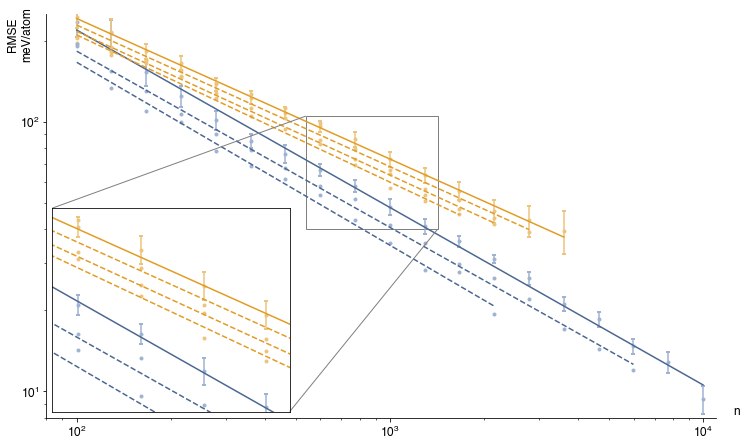

In [43]:
def plot_learning_curve(ax, x, y, style=0, verbose=False):
    """Adds learning curve to a plot."""
    # pre-defined styles
    styles = (
        ({'linestyle': 'solid' , 'color': '#4b6791'}, {'color': '#9eb3d3'}, True ),  # blue solid with error bars
        ({'linestyle': 'solid' , 'color': '#e19c24'}, {'color': '#edc47c'}, True ),  # yellow solid with error bars
        ({'linestyle': 'dashed', 'color': '#e19c24'}, {'color': '#edc47c'}, False),  # yellow dashed without errors
        ({'linestyle': 'dashed', 'color': '#4b6791'}, {'color': '#9eb3d3'}, False)   # blue dashed without errors
    )
    
    ax.set_xscale('log', base=10)#, nonposx='clip')
    ax.set_yscale('log', base=10)#, nonposy='clip')
    ax.set_xlim(80, 11000); ax.set_ylim(8, 250)

    # error bars
    x, mean, stddev = x[:len(y)], np.mean(y, axis=1), np.sqrt(np.var(y, axis=1))
    if styles[style][2]: ax.errorbar(x, mean, yerr=stddev, fmt='none', capthick=2, capsize=2, **styles[style][1])
    ax.plot(x, mean, 'o', ms=3, **styles[style][1])
    # ax.fill_between(x, mean-stddev, mean+stddev, **styles[style][1], alpha=0.5) # shaded standard deviation
    
    # asymptotic fit c*b^-a*n; the basis b is not fitted as this would result in large parameter uncertainty for a, b
    popt, pcov = sp.optimize.curve_fit(lambda n, a, c: math.log10(c) - a*n, \
        np.repeat(np.log10(x)[:,np.newaxis], 30, 1).flatten(), np.log10(y).flatten()) # log-space fit
    a, c = popt[0], popt[1]; pcov = np.sqrt(np.diag(pcov))
    if verbose: print('b = {:4.3f} ± {:4.3f}, a = {:4.3f} ± {:4.3f}'.format(c, pcov[1], a, pcov[0]))
    
    ax.plot(x, [c*n**-a for n in x], **styles[style][0])
    
def plot_learning_curves(ax, verbose=False):
    """Plots all learning curves"""
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2d6_mbtr_gaussian, 0, verbose=verbose)
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2_mbtr_gaussian, 1, verbose=verbose)
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2_mbtr_gaussian_drop1, 2, verbose=verbose)
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2_mbtr_gaussian_drop2, 2, verbose=verbose)
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2_mbtr_gaussian_drop3, 2, verbose=verbose)
    #plot_learning_curve(ax, lc_train_sizes, rmse_abc2_mbtr_gaussian_drop4, 2, verbose=verbose)
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2d6_mbtr_gaussian_drop1, 3, verbose=verbose)
    plot_learning_curve(ax, lc_train_sizes, rmse_abc2d6_mbtr_gaussian_drop2, 3, verbose=verbose)

# learning curves
ax = plt.gca()
matplotlib.rcParams.update({'font.size': 12})
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_xlabel("n"); ax.xaxis.set_label_coords(1.03, 0.03)
ax.set_ylabel("RMSE\nmeV/atom"); ax.yaxis.set_label_coords(-0.02, 0.95)
plot_learning_curves(ax, verbose=True)

# zoomed inset
axinset = mpl_toolkits.axes_grid1.inset_locator.zoomed_inset_axes(ax, 1.8, loc=3)
plot_learning_curves(axinset, verbose=False)
axinset.set_xlim(lc_train_sizes[7]*0.9, lc_train_sizes[10]*1.1); axinset.set_ylim(40, 105)
axinset.xaxis.set_visible(False); axinset.yaxis.set_visible(False)
mpl_toolkits.axes_grid1.inset_locator.mark_inset(ax, axinset, loc1=2, loc2=4, ec='0.5')

plt.gcf().set_size_inches(12,12/1.618)
plt.gcf().savefig('figures/fig_crystals_learningcurve.pdf', bbox_inches="tight")
plt.show()

# Elpasolite energies (Figure 2)

## Data

The elpasolite dataset has been published as part of the supplementary material for the article

> Felix A. Faber, Alexander Lindmaa, O. Anatole von Lilienfeld, Rickard Armiento: 
> Machine Learning Energies of 2 Million Elpasolite (ABC<sub>2</sub>D<sub>6</sub>) Crystals, <it>Physical Review Letters</i> 117(13): 135502, 2016. [DOI](https://doi.org/10.1103/PhysRevLett.117.135502)

It is also available for download at [qmml.org](http://qmml.org).

Running 
```
python2.7 printTrainingSet.py ElpasoliteIIItoVI.pkl > abc2d6-16_elpasolite3to6.txt
zip -9 abc2d6-16_elpasolite3to6.txt.zip abc2d6-16_elpasolite3to6.txt
```
extracts the data for the 11k elpasolites with 12 different elements ("small set") used here.

In [12]:
zipfn, datafn = 'datasets/abc2d6-16_elpasolite3to6.txt.zip', 'abc2d6-16_elpasolite3to6.txt'
z, r, e, b, sizes, elems, _, _, n = import_dataset_json(zipfn, datafn, ['FE/a', 'R', 'B', 'a', 'repr', 'end'], n=11358)
e = e * 1000 # meV/cell

## MBTR models

Training and validation set for performance estimation.
The training set is again split into inner training and validation set for hyperparameter optimization.
When drawing validation sets, stratification by energies is used to reduce variance of the error estimates (but not the error itself).
Note that this can only be done in retrospective benchmarking studies. 
In prospective settings, these energies would not be available, but one could use cheap surrogates, for example DFT/LDA or a semi-empirical method, for a similar effect.

In [19]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(np.arange(n), 9086, n-9086, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, 9086-500, 500, e[indtrain1])

Performance for 3594 training points, for comparison with OQMD ABC$_2$ model:

In [20]:
np.random.seed(1)

(indtrain1b,tmp) = setup_train_valid(indtrain1, 3594, 1, e[indtrain1])
(indtrain2b, indvalid2b) = setup_train_valid(indtrain1b, 3594-500, 500, e[indtrain1b])

### Parametrization

The maximum number of element species in a system, as well as the minimal and maximal distances between atoms of a system and corresponding inverse distances, are used to set appropriate tensor ranges. These quantities can be determined on the whole dataset without risk of overfitting (but other quantities like $\Delta x$ can not).

In [21]:
dsi = dataset_info(z, r, e, basis=b, verbose=True);

11358 periodic systems (materials)
elements: C N O Al Si P S Ga Ge As Sn Sb (12)
max #els/system: 4;  max #el/system: 6;  max #atoms/system: 10
min dist: 1.54;  max dist: 14.70;  1/min dist: 0.65;  1/max dist: 0.07


We use a parametrization with k = 1 (atom counts) and k = 2 (inverse distances).

In [22]:
@cached(max_entries=20)
def reprf1(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=1, atom counts, no normalization"""
    assert basis is not None
    (dsigma1,) = theta
    return qmml.many_body_tensor(
        z, r, (-0.5, float(dsi['max_same_element_per_system']+1)/30, 30),  # [0, max_el], plus margin
        (1, 'count', 'unity', ('normal', (dsigma1,)), 'identity', 'full', 'full'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

@cached(max_entries=20)
def reprf2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, quadratic weighting"""
    assert basis is not None
    (dsigma2,) = theta
    return qmml.many_body_tensor(
        z, r, (-0.07, 0.79/100, 100),  # [1/dmax, 1/dmin] plus margin
        (2, '1/distance', 'identity^2', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

kernelf_linear    = cached(max_entries=45)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=45)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=45)(qmml.kernel_gaussian)

### Linear kernel

In [48]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf1, reprf2), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=b, centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 3, #steps = 27, #evals = 32, done = True
best solution: f(4.0, -5.5, -18.0) = 273.033
var = 1, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2272
RMSE    = 276.22
MAE     = 205.66
R^2     = 0.998409
maxAE   = 1993.06
RMSE/a  = 27.62
MAE/a   = 20.57
maxAE/a = 199.31

CPU times: user 33min 32s, sys: 1min 5s, total: 34min 37s
Wall time: 7min 16s


Performance for 3594 training points, for comparison with OQMD ABC$_2$ model:

In [49]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2b, indvalid2b, (reprf1, reprf2), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=b, centering=True, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1b, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 3, #steps = 13, #evals = 17, done = True
best solution: f(0.5, -4.5, -17.0) = 375.222
var = 1, update = False
converged vars: T  T  T , directions: -1 -1 +1

n       = 2272
RMSE    = 374.24
MAE     = 268.64
R^2     = 0.997079
maxAE   = 5677.56
RMSE/a  = 37.42
MAE/a   = 26.86
maxAE/a = 567.76

CPU times: user 9min 19s, sys: 13.2 s, total: 9min 32s
Wall time: 1min 22s


### Laplacian kernel

In [50]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf1, reprf2), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=b, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 7.0, 4, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 4, #steps = 4, #evals = 8, done = True
best solution: f(-3.5, -3.0, 7.0, -20.0) = 121.443
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2272
RMSE    = 110.24
MAE     = 61.98
R^2     = 0.999748
maxAE   = 1590.51
RMSE/a  = 11.02
MAE/a   = 6.20
maxAE/a = 159.05

CPU times: user 4h 7min 56s, sys: 25.7 s, total: 4h 8min 22s
Wall time: 1h 3min 3s


Performance for 3594 training points, for comparison with OQMD ABC$_2$ model:

In [17]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e, indtrain2b, indvalid2b, (reprf1, reprf2), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=b, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 8.0, 4, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1b, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 4, #steps = 23, #evals = 28, done = True
best solution: f(-3.5, -5.0, 9.5, -15.0) = 307.448
var = 1, update = False
converged vars: T  T  T  T , directions: -1 -1 -1 +1

n       = 2272
RMSE    = 283.28
MAE     = 179.34
R^2     = 0.998331
maxAE   = 3281.34
RMSE/a  = 28.33
MAE/a   = 17.93
maxAE/a = 328.13

CPU times: user 1h 9min 12s, sys: 9.15 s, total: 1h 9min 21s
Wall time: 17min 56s


### Gaussian kernel

In [17]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf1, reprf2), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=b, centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 5.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 2.5, 4, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-17.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 4, #steps = 10, #evals = 17, done = True
best solution: f(-3.0, -5.5, 2.5, -14.0) = 103.61
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 +1 +1

n       = 2272
RMSE    = 80.71
MAE     = 47.15
R^2     = 0.999865
maxAE   = 1122.81
RMSE/a  = 8.07
MAE/a   = 4.72
maxAE/a = 112.28

CPU times: user 15min 22s, sys: 23.6 s, total: 15min 46s
Wall time: 3min 39s


In [19]:
for thr in [10, 15, 20, 25, 30]:
    pc = np.sum([1 if abs(x) <= thr else 0 for x in f.loss.residuals_pa]) / len(f.loss.residuals_pa)
    print('{:.2f}% of all errors are between -{} and {} meV/atom.'.format(100*pc, thr, thr))

90.80% of all errors are between -10 and 10 meV/atom.
96.43% of all errors are between -15 and 15 meV/atom.
97.89% of all errors are between -20 and 20 meV/atom.
98.64% of all errors are between -25 and 25 meV/atom.
99.08% of all errors are between -30 and 30 meV/atom.


Performance for 3594 training points, for comparison with OQMD ABC$_2$ model:

In [21]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e, indtrain2b, indvalid2b, (reprf1, reprf2), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=b, centering=False, maxcache=True)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 3, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 5.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 2.5, 4, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-17.0, 5, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1b, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=2))

AdaptiveGridSearch

#vars = 4, #steps = 31, #evals = 42, done = True
best solution: f(-4.5, -5.0, 4.0, -16.0) = 285.869
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2272
RMSE    = 228.70
MAE     = 149.00
R^2     = 0.998911
maxAE   = 2177.32
RMSE/a  = 22.87
MAE/a   = 14.90
maxAE/a = 217.73

CPU times: user 2min 55s, sys: 19 s, total: 3min 14s
Wall time: 1min 23s


## Figure 2

The plot uses the data generated by the last experiment run, using the Gaussian kernel and a 9k training set.

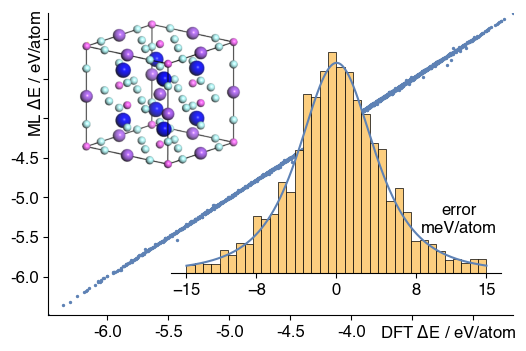

In [28]:
def hist_plot(ax, data, hist_range, distr):
    "Creates an overlaid histogram plot."
    
    rfrom, rto = -hist_range, hist_range
    
    # histogram
    (hn, hbins, hpatches) = ax.hist(data, bins=36, range=(rfrom, rto), \
        density=True, color='#fcce7f', edgecolor='black', linewidth=0.5)
    for s in ('left', 'top', 'right'): ax.spines[s].set_visible(False)  # switch off borders
    ax.set_yticks([]); ax.set_xticks([])
    ax.set_xlabel('error\nmeV/atom');
    ax.xaxis.set_label_coords(0.87, 0.3)
    
    # distribution
    xs = np.linspace(rfrom, rto, 300)
    ax.plot(xs, [distr(x) for x in xs], color='#5e82b5')
    #ax.set_xticks(range(rfrom, rto+1, int((rto-rfrom) / 4)))
    ax.set_xticks([rfrom, rfrom//2, 0, rto//2+1, rto])

def scatter_plot(ax, true, pred):
    """Creates a scatter plot."""
    
    rfrom, rto = min(min(true), min(pred)), max(max(true), max(pred))
    
    ax.scatter(true, pred, s=2, c='#5e82b5')
    ax.set_xlim([rfrom, rto]); ax.set_ylim([rfrom, rto])
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlabel('DFT $\\Delta$E / eV/atom'); ax.xaxis.set_label_coords(0.86, -0.03)
    ax.set_ylabel('ML $\\Delta$E / eV/atom'); ax.yaxis.set_label_coords(-0.01, 0.8)

# Figure 2
matplotlib.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots(squeeze=True, dpi=100)

# scatter plot
scatter_plot(ax1, f.loss.true / f.loss.sizes / 1000, f.loss.pred / f.loss.sizes / 1000)
ax1.set_xticks(np.linspace(-6, -3, 7)); ax1.set_xticklabels([-6.0, -5.5, -5.0, -4.5, -4.0, '', ''])
ax1.set_yticks(np.linspace(-6, -3, 7)); ax1.set_yticklabels([-6.0, -5.5, -5.0, -4.5, '', '', ''])

# histogram inset
ax2 = fig.add_axes([0.33, 0.23, 0.55, 0.58]) # left, bottom, width, height
(df, loc, scale) = sp.stats.t.fit(f.loss.residuals_pa, loc=0)  # Student's t distribution
distr = lambda x : sp.stats.t.pdf(x, df, loc, scale)
hist_plot(ax2, f.loss.residuals_pa, 15, distr)
ax2.patch.set_facecolor('none')

# elpasolite inset
img = matplotlib.image.imread('figures/src_fig_elpasolite.png')
ax3 = fig.add_axes([0.11, 0.48, 0.4, 0.4]) # left, bottom, width, height
ax3.imshow(img)
ax3.axis('off')
ax3.patch.set_facecolor('none')

fig.savefig('figures/fig_elpasolite_small_scatterplot.pdf', dpi=300, bbox_inches="tight")
plt.show()

## Generation of learning curves

The representation functions have already been defined in the "models" section.

### Linear kernel

#### Complete dataset

In [23]:
%%time

filename = 'results/lc_abc2d6_mbtr_linear.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (+ 0.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 2.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-16.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=0, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Hyperparameters: [ 0.5 -2.  -6. ]
Cache:  reprf 1: 36/8/8 (36/8)  reprf 2: 36/8/8 (36/8)  kernelf: 32/12/12 (32/12)
Starting experiment (100,1).
Hyperparameters: [-7.5  6.5  0. ]
Cache:  reprf 1: 110/46/20 (110/46)  reprf 2: 106/50/20 (106/50)  kernelf: 64/92/45 (64/92)
Starting experiment (100,2).
Hyperparameters: [ -2.5   6.5 -18. ]
Cache:  reprf 1: 156/66/20 (156/66)  reprf 2: 164/58/20 (164/58)  kernelf: 106/116/45 (106/116)
Starting experiment (100,3).
Hyperparameters: [-2.5 -0.5 -1. ]
Cache:  reprf 1: 210/74/20 (210/74)  reprf 2: 190/94/20 (190/94)  kernelf: 124/160/45 (124/160)
Starting experiment (100,4).
Hyperparameters: [-7.  -5.5 -3. ]
Cache:  reprf 1: 296/98/20 (296/98)  reprf 2: 244/150/20 (244/150)  kernelf: 150/244/45 (150/244)
Starting experiment (100,5).
Hyperparameters: [ 0. -1. -8.]
Cache:  reprf 1: 324/116/20 (324/116)  reprf 2: 282/158/20 (282/158)  kernelf: 170/270/45 (170/270)
Starting experiment (100,6).
Hy

Hyperparameters: [-1.5  0.5 -5. ]
Cache:  reprf 1: 558/270/20 (1638/726)  reprf 2: 610/218/20 (1690/674)  kernelf: 360/468/45 (1000/1364)
Starting experiment (129,21).
Hyperparameters: [-0.5  0.5 -3. ]
Cache:  reprf 1: 576/278/20 (1656/734)  reprf 2: 628/226/20 (1708/682)  kernelf: 374/480/45 (1014/1376)
Starting experiment (129,22).
Hyperparameters: [-5.5  0.5 -7. ]
Cache:  reprf 1: 590/304/20 (1670/760)  reprf 2: 660/234/20 (1740/690)  kernelf: 384/510/45 (1024/1406)
Starting experiment (129,23).
Hyperparameters: [-0.5  0.  -4. ]
Cache:  reprf 1: 616/312/20 (1696/768)  reprf 2: 684/244/20 (1764/700)  kernelf: 400/528/45 (1040/1424)
Starting experiment (129,24).
Hyperparameters: [  0.5   0.5 -11. ]
Cache:  reprf 1: 634/324/20 (1714/780)  reprf 2: 706/252/20 (1786/708)  kernelf: 414/544/45 (1054/1440)
Starting experiment (129,25).
Hyperparameters: [ 0.5  0.5 -7. ]
Cache:  reprf 1: 648/334/20 (1728/790)  reprf 2: 722/260/20 (1802/716)  kernelf: 424/558/45 (1064/1454)
Starting experiment

Starting experiment (215,9).
Hyperparameters: [ 1.  -2.5 -9. ]
Cache:  reprf 1: 342/124/20 (2836/1448)  reprf 2: 362/104/20 (3152/1132)  kernelf: 226/240/45 (1796/2488)
Starting experiment (215,10).
Hyperparameters: [-1.5 -2.5 -8. ]
Cache:  reprf 1: 356/142/20 (2850/1466)  reprf 2: 386/112/20 (3176/1140)  kernelf: 236/262/45 (1806/2510)
Starting experiment (215,11).
Hyperparameters: [-7.  -2.5 -7. ]
Cache:  reprf 1: 380/178/20 (2874/1502)  reprf 2: 438/120/20 (3228/1148)  kernelf: 256/302/45 (1826/2550)
Starting experiment (215,12).
Hyperparameters: [ 0. -3. -8.]
Cache:  reprf 1: 404/188/20 (2898/1512)  reprf 2: 464/128/20 (3254/1156)  kernelf: 272/320/45 (1842/2568)
Starting experiment (215,13).
Hyperparameters: [-2.5 -4.5 -6. ]
Cache:  reprf 1: 468/208/20 (2962/1532)  reprf 2: 534/142/20 (3324/1170)  kernelf: 314/362/45 (1884/2610)
Starting experiment (215,14).
Hyperparameters: [ 1.  -2.5 -9. ]
Cache:  reprf 1: 480/220/20 (2974/1544)  reprf 2: 550/150/20 (3340/1178)  kernelf: 322/378

Starting experiment (278,28).
Hyperparameters: [  1.5  -2.5 -12. ]
Cache:  reprf 1: 600/336/20 (3994/2050)  reprf 2: 694/242/20 (4478/1566)  kernelf: 410/526/45 (2576/3468)
Starting experiment (278,29).
Hyperparameters: [  1.   -2.5 -11. ]
Cache:  reprf 1: 634/350/20 (4028/2064)  reprf 2: 734/250/20 (4518/1574)  kernelf: 432/552/45 (2598/3494)
Clearing caches.

Starting experiment (359,0).
Hyperparameters: [ 1. -2. -7.]
Cache:  reprf 1: 14/8/8 (4042/2072)  reprf 2: 14/8/8 (4532/1582)  kernelf: 10/12/12 (2608/3506)
Starting experiment (359,1).
Hyperparameters: [  1.5  -2.  -16. ]
Cache:  reprf 1: 42/16/16 (4070/2080)  reprf 2: 42/16/16 (4560/1590)  kernelf: 34/24/24 (2632/3518)
Starting experiment (359,2).
Hyperparameters: [  1.5  -2.  -15. ]
Cache:  reprf 1: 64/24/20 (4092/2088)  reprf 2: 64/24/20 (4582/1598)  kernelf: 52/36/36 (2650/3530)
Starting experiment (359,3).
Hyperparameters: [ 1. -2. -9.]
Cache:  reprf 1: 90/34/20 (4118/2098)  reprf 2: 92/32/20 (4610/1606)  kernelf: 74/50/45 

Starting experiment (464,17).
Hyperparameters: [  2.   -1.5 -17. ]
Cache:  reprf 1: 400/240/20 (5152/2708)  reprf 2: 484/156/20 (5872/1988)  kernelf: 268/372/45 (3400/4460)
Starting experiment (464,18).
Hyperparameters: [  2.  -2. -17.]
Cache:  reprf 1: 416/250/20 (5168/2718)  reprf 2: 502/164/20 (5890/1996)  kernelf: 280/386/45 (3412/4474)
Starting experiment (464,19).
Hyperparameters: [  1.  -2. -15.]
Cache:  reprf 1: 428/260/20 (5180/2728)  reprf 2: 516/172/20 (5904/2004)  kernelf: 288/400/45 (3420/4488)
Starting experiment (464,20).
Hyperparameters: [  1.5  -2.  -13. ]
Cache:  reprf 1: 438/268/20 (5190/2736)  reprf 2: 526/180/20 (5914/2012)  kernelf: 294/412/45 (3426/4500)
Starting experiment (464,21).
Hyperparameters: [  2.  -2. -17.]
Cache:  reprf 1: 454/276/20 (5206/2744)  reprf 2: 542/188/20 (5930/2020)  kernelf: 306/424/45 (3438/4512)
Starting experiment (464,22).
Hyperparameters: [  0.5  -2.  -15. ]
Cache:  reprf 1: 466/288/20 (5218/2756)  reprf 2: 558/196/20 (5946/2028)  ker

Hyperparameters: [  2.  -2. -19.]
Cache:  reprf 1: 348/252/20 (6290/3462)  reprf 2: 442/158/20 (7262/2490)  kernelf: 248/352/45 (4230/5522)
Starting experiment (774,19).
Hyperparameters: [  2.  -2. -20.]
Cache:  reprf 1: 360/266/20 (6302/3476)  reprf 2: 460/166/20 (7280/2498)  kernelf: 256/370/45 (4238/5540)
Starting experiment (774,20).
Hyperparameters: [ -1.  -2. -18.]
Cache:  reprf 1: 372/282/20 (6314/3492)  reprf 2: 480/174/20 (7300/2506)  kernelf: 264/390/45 (4246/5560)
Starting experiment (774,21).
Hyperparameters: [  2.  -2. -17.]
Cache:  reprf 1: 386/296/20 (6328/3506)  reprf 2: 500/182/20 (7320/2514)  kernelf: 274/408/45 (4256/5578)
Starting experiment (774,22).
Hyperparameters: [  1.5  -2.5 -13. ]
Cache:  reprf 1: 420/304/20 (6362/3514)  reprf 2: 532/192/20 (7352/2524)  kernelf: 298/426/45 (4280/5596)
Starting experiment (774,23).
Hyperparameters: [  1.5  -2.  -16. ]
Cache:  reprf 1: 434/312/20 (6376/3522)  reprf 2: 546/200/20 (7366/2532)  kernelf: 308/438/45 (4290/5608)
Star

Starting experiment (1292,10).
Hyperparameters: [  2.5  -2.5 -20. ]
Cache:  reprf 1: 655/16/16 (7143/3598)  reprf 2: 666/5/5 (8154/2587)  kernelf: 601/70/45 (4969/5772)
Hyperparameters: [  1.5  -2.5 -13. ]
Cache:  reprf 1: 672/16/16 (7160/3598)  reprf 2: 683/5/5 (8171/2587)  kernelf: 618/70/45 (4986/5772)
Starting experiment (1292,12).
Hyperparameters: [  2.5  -2.5 -19. ]
Cache:  reprf 1: 686/16/16 (7174/3598)  reprf 2: 697/5/5 (8185/2587)  kernelf: 632/70/45 (5000/5772)
Starting experiment (1292,13).
Hyperparameters: [  1.5  -2.5 -14. ]
Cache:  reprf 1: 698/16/16 (7186/3598)  reprf 2: 709/5/5 (8197/2587)  kernelf: 644/70/45 (5012/5772)
Starting experiment (1292,14).
Hyperparameters: [  2.5  -2.  -20. ]
Cache:  reprf 1: 714/16/16 (7202/3598)  reprf 2: 725/5/5 (8213/2587)  kernelf: 660/70/45 (5028/5772)
Starting experiment (1292,15).
Hyperparameters: [  2.5  -2.5 -20. ]
Cache:  reprf 1: 725/16/16 (7213/3598)  reprf 2: 736/5/5 (8224/2587)  kernelf: 671/70/45 (5039/5772)
Starting experime

Hyperparameters: [  1.  -3. -17.]
Cache:  reprf 1: 1496/34/20 (7984/3616)  reprf 2: 1522/8/8 (9010/2590)  kernelf: 1380/150/45 (5748/5852)
Starting experiment (1668,29).
Hyperparameters: [  1.5  -4.  -12. ]
Cache:  reprf 1: 1532/34/20 (8020/3616)  reprf 2: 1558/8/8 (9046/2590)  kernelf: 1416/150/45 (5784/5852)

Keeping caches to maximize cache exploitation
Starting experiment (2154,0).
Hyperparameters: [  0.5  -2.5 -20. ]
Cache:  reprf 1: 1547/34/20 (8035/3616)  reprf 2: 1573/8/8 (9061/2590)  kernelf: 1426/155/45 (5794/5857)
Starting experiment (2154,1).
Hyperparameters: [  2.   -2.5 -20. ]
Cache:  reprf 1: 1557/34/20 (8045/3616)  reprf 2: 1583/8/8 (9071/2590)  kernelf: 1435/156/45 (5803/5858)
Starting experiment (2154,2).
Hyperparameters: [  0.5  -3.  -20. ]
Cache:  reprf 1: 1572/34/20 (8060/3616)  reprf 2: 1598/8/8 (9086/2590)  kernelf: 1450/156/45 (5818/5858)
Starting experiment (2154,3).
Hyperparameters: [  2.5  -3.5 -20. ]
Cache:  reprf 1: 1588/34/20 (8076/3616)  reprf 2: 1614/8/8

Starting experiment (2783,16).
Hyperparameters: [  3.5  -4.5 -15. ]
Cache:  reprf 1: 2269/55/20 (8757/3637)  reprf 2: 2315/9/9 (9803/2591)  kernelf: 2088/236/45 (6456/5938)
Starting experiment (2783,17).
Hyperparameters: [ 1.5 -5.  -9. ]
Cache:  reprf 1: 2286/55/20 (8774/3637)  reprf 2: 2332/9/9 (9820/2591)  kernelf: 2104/237/45 (6472/5939)
Starting experiment (2783,18).
Hyperparameters: [-0.5 -6.  -5. ]
Cache:  reprf 1: 2367/58/20 (8855/3640)  reprf 2: 2414/11/11 (9902/2593)  kernelf: 2172/253/45 (6540/5955)
Starting experiment (2783,21).
Hyperparameters: [ -0.5  -4.5 -15. ]
Cache:  reprf 1: 2381/58/20 (8869/3640)  reprf 2: 2428/11/11 (9916/2593)  kernelf: 2186/253/45 (6554/5955)
Starting experiment (2783,22).
Hyperparameters: [  3.5  -4.5 -17. ]
Cache:  reprf 1: 2396/58/20 (8884/3640)  reprf 2: 2443/11/11 (9931/2593)  kernelf: 2201/253/45 (6569/5955)
Starting experiment (2783,23).
Hyperparameters: [  1.   -4.5 -16. ]
Cache:  reprf 1: 2408/58/20 (8896/3640)  reprf 2: 2455/11/11 (9943/

Starting experiment (4642,5).
Hyperparameters: [ -1.  -5. -16.]
Cache:  reprf 1: 3077/78/20 (9565/3660)  reprf 2: 3144/11/11 (10632/2593)  kernelf: 2847/308/45 (7215/6010)
Starting experiment (4642,6).
Hyperparameters: [  7.5  -4.5 -20. ]
Cache:  reprf 1: 3093/79/20 (9581/3661)  reprf 2: 3161/11/11 (10649/2593)  kernelf: 2861/311/45 (7229/6013)
Starting experiment (4642,7).
Hyperparameters: [  9.5  -4.5 -19. ]
Cache:  reprf 1: 3113/83/20 (9601/3665)  reprf 2: 3185/11/11 (10673/2593)  kernelf: 2879/317/45 (7247/6019)
Starting experiment (4642,8).
Hyperparameters: [  1.5  -5.  -15. ]
Cache:  reprf 1: 3139/89/20 (9627/3671)  reprf 2: 3217/11/11 (10705/2593)  kernelf: 2905/323/45 (7273/6025)
Starting experiment (4642,9).
Hyperparameters: [ -0.5  -4.5 -20. ]
Cache:  reprf 1: 3156/93/20 (9644/3675)  reprf 2: 3238/11/11 (10726/2593)  kernelf: 2925/324/45 (7293/6026)
Starting experiment (4642,10).
Hyperparameters: [  0.5  -5.  -14. ]
Cache:  reprf 1: 3189/93/20 (9677/3675)  reprf 2: 3271/11/11

Starting experiment (5995,24).
Hyperparameters: [  2.  -5. -15.]
Cache:  reprf 1: 3888/196/20 (10376/3778)  reprf 2: 4073/11/11 (11561/2593)  kernelf: 3626/458/45 (7994/6160)
Starting experiment (5995,25).
Hyperparameters: [ -6.  -5. -12.]
Cache:  reprf 1: 3920/196/20 (10408/3778)  reprf 2: 4105/11/11 (11593/2593)  kernelf: 3657/459/45 (8025/6161)
Starting experiment (5995,26).
Hyperparameters: [  2.  -5. -11.]
Cache:  reprf 1: 3932/196/20 (10420/3778)  reprf 2: 4117/11/11 (11605/2593)  kernelf: 3669/459/45 (8037/6161)
Starting experiment (5995,27).
Hyperparameters: [-6.  -5.5 -9. ]
Cache:  reprf 1: 3972/196/20 (10460/3778)  reprf 2: 4157/11/11 (11645/2593)  kernelf: 3708/460/45 (8076/6162)
Starting experiment (5995,28).
Hyperparameters: [  3.5  -5.5 -15. ]
Cache:  reprf 1: 4010/199/20 (10498/3781)  reprf 2: 4198/11/11 (11686/2593)  kernelf: 3739/470/45 (8107/6172)
Starting experiment (5995,29).
Hyperparameters: [  0.   -5.5 -12. ]
Cache:  reprf 1: 4041/205/20 (10529/3787)  reprf 2: 42

Starting experiment (10000,12).
Hyperparameters: [ -4.   -5.5 -16. ]
Cache:  reprf 1: 4921/261/20 (11409/3843)  reprf 2: 5170/12/12 (12658/2594)  kernelf: 4514/668/45 (8882/6370)
Starting experiment (10000,13).
Hyperparameters: [  0.  -6. -14.]
Cache:  reprf 1: 4937/261/20 (11425/3843)  reprf 2: 5186/12/12 (12674/2594)  kernelf: 4529/669/45 (8897/6371)
Starting experiment (10000,14).
Hyperparameters: [ 0.5 -7.  -6. ]
Cache:  reprf 1: 4986/261/20 (11474/3843)  reprf 2: 5234/13/13 (12722/2595)  kernelf: 4562/685/45 (8930/6387)
Starting experiment (10000,15).
Hyperparameters: [  1.  -6. -11.]
Cache:  reprf 1: 5003/261/20 (11491/3843)  reprf 2: 5251/13/13 (12739/2595)  kernelf: 4577/687/45 (8945/6389)
Starting experiment (10000,16).
Hyperparameters: [ -4.  -6. -15.]
Cache:  reprf 1: 5023/261/20 (11511/3843)  reprf 2: 5271/13/13 (12759/2595)  kernelf: 4597/687/45 (8965/6389)
Starting experiment (10000,17).
Hyperparameters: [  1.5  -6.5 -11. ]
Cache:  reprf 1: 5059/263/20 (11547/3845)  reprf

#### Reduced dataset

One element removed

In [24]:
%%time

filename = 'results/lc_abc2d6_mbtr_linear_drop1.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (+ 0.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 2.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-16.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=1, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) N;  7597 remain
Hyperparameters: [  0.   -3.5 -20. ]
Cache:  reprf 1: 5400/272/20 (11888/3854)  reprf 2: 5647/25/20 (13135/2607)  kernelf: 4913/759/45 (9281/6461)
Starting experiment (100,1).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [-1.  -3.5 -3. ]
Cache:  reprf 1: 5452/284/20 (11940/3866)  reprf 2: 5703/33/20 (13191/2615)  kernelf: 4961/775/45 (9329/6477)
Starting experiment (100,2).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ -2.  -5. -20.]
Cache:  reprf 1: 5524/298/20 (12012/3880)  reprf 2: 5775/47/20 (13263/2629)  kernelf: 5015/807/45 (9383/6509)
Starting experiment (100,3).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -1.   -4.5 -20. ]
Cache:  reprf 1: 5540/306/20 (12028/3888)  reprf 2: 5787/59/20 (13275/2641)  kernelf: 5019/827/45 (9387/6529)
Starting experiment (100,4).
Dropped element(s) P;  7557 remain
Hyperparameters: [-7.5 -4.  -4. ]
Cache:  reprf 1: 5600/338/20 (12088

Dropped element(s) Ge;  7581 remain
Hyperparameters: [-4.5 -3.5 -7. ]
Cache:  reprf 1: 398/134/20 (14074/4504)  reprf 2: 424/108/20 (15545/3033)  kernelf: 282/250/45 (10999/7579)
Starting experiment (129,10).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [-2.  -4.5 -7. ]
Cache:  reprf 1: 432/144/20 (14108/4514)  reprf 2: 460/116/20 (15581/3041)  kernelf: 306/270/45 (11023/7599)
Starting experiment (129,11).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -2.  -6. -19.]
Cache:  reprf 1: 484/154/20 (14160/4524)  reprf 2: 510/128/20 (15631/3053)  kernelf: 344/294/45 (11061/7623)
Starting experiment (129,12).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ -0.5  -4.  -20. ]
Cache:  reprf 1: 526/168/20 (14202/4538)  reprf 2: 558/136/20 (15679/3061)  kernelf: 376/318/45 (11093/7647)
Starting experiment (129,13).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -7.  -4. -20.]
Cache:  reprf 1: 572/196/20 (14248/4566)  reprf 2: 624/144/20 (15745/3069)  kernelf: 414/35

Starting experiment (167,19).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ -1.5  -5.5 -20. ]
Cache:  reprf 1: 632/304/20 (15404/5080)  reprf 2: 742/194/20 (17081/3403)  kernelf: 428/508/45 (11961/8523)
Starting experiment (167,20).
Dropped element(s) O;  7566 remain
Hyperparameters: [-1.5 -4.  -5. ]
Cache:  reprf 1: 640/312/20 (15412/5088)  reprf 2: 750/202/20 (17089/3411)  kernelf: 432/520/45 (11965/8535)
Starting experiment (167,21).
Dropped element(s) As;  7555 remain
Hyperparameters: [-7. -4. -4.]
Cache:  reprf 1: 658/340/20 (15430/5116)  reprf 2: 788/210/20 (17127/3419)  kernelf: 446/552/45 (11979/8567)
Starting experiment (167,22).
Dropped element(s) O;  7566 remain
Hyperparameters: [ -5.  -6. -17.]
Cache:  reprf 1: 746/364/20 (15518/5140)  reprf 2: 884/226/20 (17223/3435)  kernelf: 506/604/45 (12039/8619)
Starting experiment (167,23).
Dropped element(s) O;  7566 remain
Hyperparameters: [-1. -4. -4.]
Cache:  reprf 1: 760/374/20 (15532/5150)  reprf 2: 900/234/20 (17239/3

Starting experiment (215,29).
Dropped element(s) C;  7574 remain
Hyperparameters: [ 0.  -3.5 -7. ]
Cache:  reprf 1: 792/408/20 (16550/5636)  reprf 2: 930/270/20 (18415/3771)  kernelf: 526/674/45 (12727/9459)
Clearing caches.

Starting experiment (278,0).
Dropped element(s) S;  7597 remain
Hyperparameters: [-1.  -3.5 -6. ]
Cache:  reprf 1: 36/14/14 (16586/5650)  reprf 2: 40/10/10 (18455/3781)  kernelf: 24/26/26 (12751/9485)
Starting experiment (278,1).
Dropped element(s) C;  7574 remain
Hyperparameters: [-1.5 -4.  -5. ]
Cache:  reprf 1: 60/22/20 (16610/5658)  reprf 2: 64/18/18 (18479/3789)  kernelf: 40/42/42 (12767/9501)
Starting experiment (278,2).
Dropped element(s) Al;  7547 remain
Hyperparameters: [ 0.5 -3.  -6. ]
Cache:  reprf 1: 86/36/20 (16636/5672)  reprf 2: 96/26/20 (18511/3797)  kernelf: 56/66/45 (12783/9525)
Starting experiment (278,3).
Dropped element(s) As;  7555 remain
Hyperparameters: [-1.  -3.5 -6. ]
Cache:  reprf 1: 94/44/20 (16644/5680)  reprf 2: 104/34/20 (18519/3805)

Starting experiment (359,9).
Dropped element(s) S;  7597 remain
Hyperparameters: [ 0.5 -3.  -8. ]
Cache:  reprf 1: 194/150/20 (17518/6160)  reprf 2: 258/86/20 (19543/4135)  kernelf: 120/224/45 (13333/10345)
Starting experiment (359,10).
Dropped element(s) Al;  7547 remain
Hyperparameters: [-0.5 -3.5 -6. ]
Cache:  reprf 1: 206/160/20 (17530/6170)  reprf 2: 272/94/20 (19557/4143)  kernelf: 128/238/45 (13341/10359)
Starting experiment (359,11).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ 0. -4. -4.]
Cache:  reprf 1: 232/170/20 (17556/6180)  reprf 2: 300/102/20 (19585/4151)  kernelf: 144/258/45 (13357/10379)
Starting experiment (359,12).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [ 1. -4. -7.]
Cache:  reprf 1: 268/182/20 (17592/6192)  reprf 2: 340/110/20 (19625/4159)  kernelf: 170/280/45 (13383/10401)
Starting experiment (359,13).
Dropped element(s) N;  7597 remain
Hyperparameters: [ 0. -3. -6.]
Cache:  reprf 1: 294/192/20 (17618/6202)  reprf 2: 366/120/20 (19651/4169)

Starting experiment (464,19).
Dropped element(s) P;  7557 remain
Hyperparameters: [ 0. -4. -7.]
Cache:  reprf 1: 476/224/20 (18526/6622)  reprf 2: 522/178/20 (20647/4501)  kernelf: 308/392/45 (13983/11165)
Starting experiment (464,20).
Dropped element(s) P;  7557 remain
Hyperparameters: [ 0.5 -4.  -8. ]
Cache:  reprf 1: 506/234/20 (18556/6632)  reprf 2: 552/188/20 (20677/4511)  kernelf: 328/412/45 (14003/11185)
Starting experiment (464,21).
Dropped element(s) P;  7557 remain
Hyperparameters: [ 0.  -4.5 -5. ]
Cache:  reprf 1: 522/244/20 (18572/6642)  reprf 2: 570/196/20 (20695/4519)  kernelf: 340/426/45 (14015/11199)
Starting experiment (464,22).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ 0.  -4.5 -6. ]
Cache:  reprf 1: 534/254/20 (18584/6652)  reprf 2: 584/204/20 (20709/4527)  kernelf: 348/440/45 (14023/11213)
Starting experiment (464,23).
Dropped element(s) N;  7597 remain
Hyperparameters: [ 0. -5. -5.]
Cache:  reprf 1: 550/262/20 (18600/6660)  reprf 2: 600/212/20 (20725/4

Starting experiment (774,7).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ 4.  -4.5 -8. ]
Cache:  reprf 1: 236/136/20 (19512/7226)  reprf 2: 294/78/20 (21809/4929)  kernelf: 144/228/45 (14605/12133)
Starting experiment (774,8).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ 0.  -4.5 -4. ]
Cache:  reprf 1: 260/146/20 (19536/7236)  reprf 2: 320/86/20 (21835/4937)  kernelf: 160/246/45 (14621/12151)
Starting experiment (774,9).
Dropped element(s) N;  7597 remain
Hyperparameters: [ 0. -5. -6.]
Cache:  reprf 1: 272/154/20 (19548/7244)  reprf 2: 332/94/20 (21847/4945)  kernelf: 168/258/45 (14629/12163)
Starting experiment (774,10).
Dropped element(s) S;  7597 remain
Hyperparameters: [ 1.  -4.5 -6. ]
Cache:  reprf 1: 294/164/20 (19570/7254)  reprf 2: 354/104/20 (21869/4955)  kernelf: 180/278/45 (14641/12183)
Starting experiment (774,11).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ 0. -5. -6.]
Cache:  reprf 1: 306/174/20 (19582/7264)  reprf 2: 368/112/20 (21883/4963)

Starting experiment (1000,23).
Dropped element(s) C;  7574 remain
Hyperparameters: [ 1. -5. -7.]
Cache:  reprf 1: 338/19/19 (20298/7503)  reprf 2: 350/7/7 (22679/5122)  kernelf: 292/65/45 (15177/12624)
Starting experiment (1000,24).
Dropped element(s) O;  7566 remain
Hyperparameters: [-2. -5. -5.]
Cache:  reprf 1: 353/19/19 (20313/7503)  reprf 2: 365/7/7 (22694/5122)  kernelf: 306/66/45 (15191/12625)
Starting experiment (1000,25).
Dropped element(s) O;  7566 remain
Hyperparameters: [-0.5 -5.  -6. ]
Cache:  reprf 1: 363/19/19 (20323/7503)  reprf 2: 375/7/7 (22704/5122)  kernelf: 315/67/45 (15200/12626)
Starting experiment (1000,26).
Dropped element(s) S;  7597 remain
Hyperparameters: [-7. -5. -6.]
Cache:  reprf 1: 385/20/20 (20345/7504)  reprf 2: 398/7/7 (22727/5122)  kernelf: 328/77/45 (15213/12636)
Starting experiment (1000,27).
Dropped element(s) O;  7566 remain
Hyperparameters: [ 0. -5. -7.]
Cache:  reprf 1: 393/20/20 (20353/7504)  reprf 2: 406/7/7 (22735/5122)  kernelf: 336/77/45 (

Starting experiment (1668,7).
Dropped element(s) S;  7597 remain
Hyperparameters: [-6.5 -5.  -7. ]
Cache:  reprf 1: 1002/36/20 (20962/7520)  reprf 2: 1031/7/7 (23360/5122)  kernelf: 898/140/45 (15783/12699)
Starting experiment (1668,8).
Dropped element(s) S;  7597 remain
Hyperparameters: [-6.5 -5.  -8. ]
Cache:  reprf 1: 1030/36/20 (20990/7520)  reprf 2: 1059/7/7 (23388/5122)  kernelf: 926/140/45 (15811/12699)
Starting experiment (1668,9).
Dropped element(s) C;  7574 remain
Hyperparameters: [ 0. -5. -6.]
Cache:  reprf 1: 1043/36/20 (21003/7520)  reprf 2: 1072/7/7 (23401/5122)  kernelf: 939/140/45 (15824/12699)
Starting experiment (1668,10).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ 0.5 -5.  -7. ]
Cache:  reprf 1: 1052/36/20 (21012/7520)  reprf 2: 1081/7/7 (23410/5122)  kernelf: 948/140/45 (15833/12699)
Starting experiment (1668,11).
Dropped element(s) S;  7597 remain
Hyperparameters: [ 0.5 -5.  -7. ]
Cache:  reprf 1: 1061/36/20 (21021/7520)  reprf 2: 1090/7/7 (23419/5122) 

Hyperparameters: [-0.5 -5.  -8. ]
Cache:  reprf 1: 1587/36/20 (21547/7520)  reprf 2: 1616/7/7 (23945/5122)  kernelf: 1449/174/45 (16334/12733)
Starting experiment (2154,17).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ 0.5 -5.  -8. ]
Cache:  reprf 1: 1595/36/20 (21555/7520)  reprf 2: 1624/7/7 (23953/5122)  kernelf: 1457/174/45 (16342/12733)
Starting experiment (2154,18).
Dropped element(s) S;  7597 remain
Hyperparameters: [-6. -5. -8.]
Cache:  reprf 1: 1623/36/20 (21583/7520)  reprf 2: 1652/7/7 (23981/5122)  kernelf: 1483/176/45 (16368/12735)
Starting experiment (2154,19).
Dropped element(s) Al;  7547 remain
Hyperparameters: [-4.5 -6.  -5. ]
Cache:  reprf 1: 1664/36/20 (21624/7520)  reprf 2: 1693/7/7 (24022/5122)  kernelf: 1511/189/45 (16396/12748)
Starting experiment (2154,20).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [  1.5  -5.  -10. ]
Cache:  reprf 1: 1677/36/20 (21637/7520)  reprf 2: 1706/7/7 (24035/5122)  kernelf: 1522/191/45 (16407/12750)
Starting experimen

Hyperparameters: [ 0.5 -5.  -9. ]
Cache:  reprf 1: 2229/110/20 (22189/7594)  reprf 2: 2332/7/7 (24661/5122)  kernelf: 2070/269/45 (16955/12828)
Starting experiment (2783,26).
Dropped element(s) S;  7597 remain
Hyperparameters: [ 1. -5. -8.]
Cache:  reprf 1: 2240/110/20 (22200/7594)  reprf 2: 2343/7/7 (24672/5122)  kernelf: 2081/269/45 (16966/12828)
Starting experiment (2783,27).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [-6.5 -5.5 -6. ]
Cache:  reprf 1: 2269/117/20 (22229/7601)  reprf 2: 2379/7/7 (24708/5122)  kernelf: 2106/280/45 (16991/12839)
Starting experiment (2783,28).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ 0. -5. -9.]
Cache:  reprf 1: 2279/117/20 (22239/7601)  reprf 2: 2389/7/7 (24718/5122)  kernelf: 2116/280/45 (17001/12839)
Starting experiment (2783,29).
Dropped element(s) S;  7597 remain
Hyperparameters: [ 0. -5. -9.]
Cache:  reprf 1: 2290/117/20 (22250/7601)  reprf 2: 2400/7/7 (24729/5122)  kernelf: 2127/280/45 (17012/12839)

Keeping caches to maxi

Starting experiment (4642,4).
Dropped element(s) P;  7557 remain
Hyperparameters: [-6.5 -5.5 -7. ]
Cache:  reprf 1: 2813/175/20 (22773/7659)  reprf 2: 2981/7/7 (25310/5122)  kernelf: 2622/366/45 (17507/12925)
Starting experiment (4642,5).
Dropped element(s) N;  7597 remain
Hyperparameters: [-6.5 -5.5 -6. ]
Cache:  reprf 1: 2824/175/20 (22784/7659)  reprf 2: 2992/7/7 (25321/5122)  kernelf: 2633/366/45 (17518/12925)
Starting experiment (4642,6).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [-1.5 -5.5 -6. ]
Cache:  reprf 1: 2844/175/20 (22804/7659)  reprf 2: 3012/7/7 (25341/5122)  kernelf: 2650/369/45 (17535/12928)
Starting experiment (4642,7).
Dropped element(s) P;  7557 remain
Hyperparameters: [-4.5 -6.  -7. ]
Cache:  reprf 1: 2865/175/20 (22825/7659)  reprf 2: 3033/7/7 (25362/5122)  kernelf: 2668/372/45 (17553/12931)
Starting experiment (4642,8).
Dropped element(s) Si;  7513 remain
Hyperparameters: [-6.5 -5.5 -6. ]
Cache:  reprf 1: 2874/175/20 (22834/7659)  reprf 2: 3042/7/7 (2

Starting experiment (5995,13).
Dropped element(s) S;  7597 remain
Hyperparameters: [ -6.5  -5.5 -11. ]
Cache:  reprf 1: 3266/176/20 (23226/7660)  reprf 2: 3435/7/7 (25764/5122)  kernelf: 3058/384/45 (17943/12943)
Starting experiment (5995,14).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [-6.5 -5.5 -9. ]
Cache:  reprf 1: 3277/176/20 (23237/7660)  reprf 2: 3446/7/7 (25775/5122)  kernelf: 3069/384/45 (17954/12943)
Starting experiment (5995,15).
Dropped element(s) Al;  7547 remain
Hyperparameters: [-6.5 -6.  -8. ]
Cache:  reprf 1: 3295/176/20 (23255/7660)  reprf 2: 3464/7/7 (25793/5122)  kernelf: 3087/384/45 (17972/12943)
Starting experiment (5995,16).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ -6.5  -5.5 -13. ]
Cache:  reprf 1: 3304/176/20 (23264/7660)  reprf 2: 3473/7/7 (25802/5122)  kernelf: 3096/384/45 (17981/12943)
Starting experiment (5995,17).
Dropped element(s) O;  7566 remain
Hyperparameters: [ -1.   -5.5 -11. ]
Cache:  reprf 1: 3325/176/20 (23285/7660)  reprf

Two elements removed.

In [25]:
%%time

filename = 'results/lc_abc2d6_mbtr_linear_drop2.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (+ 0.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 2.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-16.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=2, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) As, P;  4808 remain
Hyperparameters: [ 0. -2. -9.]
Cache:  reprf 1: 3483/184/20 (23443/7668)  reprf 2: 3652/15/15 (25981/5130)  kernelf: 3267/400/45 (18152/12959)
Starting experiment (100,1).
Dropped element(s) N, C;  4845 remain
Hyperparameters: [-0.5 -3.  -7. ]
Cache:  reprf 1: 3521/192/20 (23481/7676)  reprf 2: 3688/25/20 (26017/5140)  kernelf: 3295/418/45 (18180/12977)
Starting experiment (100,2).
Dropped element(s) Ge, Sb;  4830 remain
Hyperparameters: [ -4.  -2. -20.]
Cache:  reprf 1: 3557/216/20 (23517/7700)  reprf 2: 3740/33/20 (26069/5148)  kernelf: 3327/446/45 (18212/13005)
Starting experiment (100,3).
Dropped element(s) As, Sn;  4832 remain
Hyperparameters: [ 0.  -2.5 -9. ]
Cache:  reprf 1: 3593/226/20 (23553/7710)  reprf 2: 3778/41/20 (26107/5156)  kernelf: 3351/468/45 (18236/13027)
Starting experiment (100,4).
Dropped element(s) N, As;  4822 remain
Hyperparameters: [ 0.  -1.5 -6. ]
Cache:  reprf 1: 

Dropped element(s) S, Al;  4824 remain
Hyperparameters: [ -0.5  -4.  -20. ]
Cache:  reprf 1: 414/124/20 (24787/8180)  reprf 2: 422/116/20 (27403/5564)  kernelf: 276/262/45 (19044/13923)
Starting experiment (129,9).
Dropped element(s) O, Al;  4801 remain
Hyperparameters: [-2. -4. -4.]
Cache:  reprf 1: 432/136/20 (24805/8192)  reprf 2: 444/124/20 (27425/5572)  kernelf: 290/278/45 (19058/13939)
Starting experiment (129,10).
Dropped element(s) O, N;  4836 remain
Hyperparameters: [-4.5 -3.5 -3. ]
Cache:  reprf 1: 470/158/20 (24843/8214)  reprf 2: 496/132/20 (27477/5580)  kernelf: 320/308/45 (19088/13969)
Starting experiment (129,11).
Dropped element(s) Sn, Al;  4831 remain
Hyperparameters: [ 0.5 -3.  -9. ]
Cache:  reprf 1: 504/172/20 (24877/8228)  reprf 2: 534/142/20 (27515/5590)  kernelf: 342/334/45 (19110/13995)
Starting experiment (129,12).
Dropped element(s) As, S;  4827 remain
Hyperparameters: [-1.5 -6.5 -2. ]
Cache:  reprf 1: 560/182/20 (24933/8238)  reprf 2: 582/160/20 (27563/5608)  

Starting experiment (167,17).
Dropped element(s) P, S;  4831 remain
Hyperparameters: [11.5 -4.  -8. ]
Cache:  reprf 1: 434/404/20 (26041/8904)  reprf 2: 684/154/20 (29017/5928)  kernelf: 316/522/45 (19968/14977)
Starting experiment (167,18).
Dropped element(s) S, Sb;  4838 remain
Hyperparameters: [ -7.   -3.5 -20. ]
Cache:  reprf 1: 470/480/20 (26077/8980)  reprf 2: 786/164/20 (29119/5938)  kernelf: 342/608/45 (19994/15063)
Starting experiment (167,19).
Dropped element(s) Ga, N;  4849 remain
Hyperparameters: [ 0.5 -4.  -6. ]
Cache:  reprf 1: 492/526/20 (26099/9026)  reprf 2: 846/172/20 (29179/5946)  kernelf: 360/658/45 (20012/15113)
Starting experiment (167,20).
Dropped element(s) S, Ge;  4840 remain
Hyperparameters: [ 11.5  -4.  -11. ]
Cache:  reprf 1: 506/540/20 (26113/9040)  reprf 2: 866/180/20 (29199/5954)  kernelf: 370/676/45 (20022/15131)
Starting experiment (167,21).
Dropped element(s) Si, C;  4776 remain
Hyperparameters: [ 0. -3. -7.]
Cache:  reprf 1: 560/590/20 (26167/9090)  r

Hyperparameters: [  1.  -2. -14.]
Cache:  reprf 1: 694/452/20 (27097/9686)  reprf 2: 920/226/20 (30519/6264)  kernelf: 474/672/45 (20706/16077)
Starting experiment (215,26).
Dropped element(s) P, Ge;  4820 remain
Hyperparameters: [  1.  -2. -16.]
Cache:  reprf 1: 710/460/20 (27113/9694)  reprf 2: 936/234/20 (30535/6272)  kernelf: 486/684/45 (20718/16089)
Starting experiment (215,27).
Dropped element(s) Sb, Ga;  4834 remain
Hyperparameters: [ -1.  -2. -12.]
Cache:  reprf 1: 732/474/20 (27135/9708)  reprf 2: 964/242/20 (30563/6280)  kernelf: 504/702/45 (20736/16107)
Starting experiment (215,28).
Dropped element(s) Ge, Sb;  4830 remain
Hyperparameters: [ 12.5  -2.  -11. ]
Cache:  reprf 1: 774/528/20 (27177/9762)  reprf 2: 1052/250/20 (30651/6288)  kernelf: 542/760/45 (20774/16165)
Starting experiment (215,29).
Dropped element(s) C, N;  4845 remain
Hyperparameters: [  1.  -2. -14.]
Cache:  reprf 1: 784/536/20 (27187/9770)  reprf 2: 1062/258/20 (30661/6296)  kernelf: 548/772/45 (20780/16177

Starting experiment (359,4).
Dropped element(s) S, O;  4821 remain
Hyperparameters: [ 0.5 -4.  -7. ]
Cache:  reprf 1: 118/104/20 (28163/10316)  reprf 2: 178/44/20 (31863/6616)  kernelf: 80/142/45 (21434/17045)
Starting experiment (359,5).
Dropped element(s) Ga, Si;  4778 remain
Hyperparameters: [ 1.5 -4.  -8. ]
Cache:  reprf 1: 150/116/20 (28195/10328)  reprf 2: 214/52/20 (31899/6624)  kernelf: 108/158/45 (21462/17061)
Starting experiment (359,6).
Dropped element(s) S, Si;  4792 remain
Hyperparameters: [ 0.5 -4.  -7. ]
Cache:  reprf 1: 158/124/20 (28203/10336)  reprf 2: 222/60/20 (31907/6632)  kernelf: 112/170/45 (21466/17073)
Starting experiment (359,7).
Dropped element(s) N, Ge;  4838 remain
Hyperparameters: [  0.  -4. -10.]
Cache:  reprf 1: 174/134/20 (28219/10346)  reprf 2: 240/68/20 (31925/6640)  kernelf: 124/184/45 (21478/17087)
Starting experiment (359,8).
Dropped element(s) As, S;  4827 remain
Hyperparameters: [ 1. -4. -7.]
Cache:  reprf 1: 186/142/20 (28231/10354)  reprf 2: 25

Starting experiment (464,13).
Dropped element(s) Ga, P;  4822 remain
Hyperparameters: [ 0.5 -4.5 -5. ]
Cache:  reprf 1: 334/250/20 (29051/10898)  reprf 2: 468/116/20 (33007/6942)  kernelf: 242/342/45 (22066/17883)
Starting experiment (464,14).
Dropped element(s) Ge, C;  4826 remain
Hyperparameters: [ 1. -4. -8.]
Cache:  reprf 1: 352/260/20 (29069/10908)  reprf 2: 488/124/20 (33027/6950)  kernelf: 256/356/45 (22080/17897)
Starting experiment (464,15).
Dropped element(s) Sn, S;  4870 remain
Hyperparameters: [10.  -4.5 -8. ]
Cache:  reprf 1: 390/306/20 (29107/10954)  reprf 2: 562/134/20 (33101/6960)  kernelf: 284/412/45 (22108/17953)
Starting experiment (464,16).
Dropped element(s) Ge, Ga;  4832 remain
Hyperparameters: [ 0.5 -4.  -6. ]
Cache:  reprf 1: 400/314/20 (29117/10962)  reprf 2: 572/142/20 (33111/6968)  kernelf: 290/424/45 (22114/17965)
Starting experiment (464,17).
Dropped element(s) Sb, C;  4813 remain
Hyperparameters: [ 0. -5. -6.]
Cache:  reprf 1: 620/430/20 (29337/11078)  rep

Starting experiment (774,3).
Dropped element(s) Ga, Ge;  4832 remain
Hyperparameters: [ 1.5 -4.5 -9. ]
Cache:  reprf 1: 100/154/20 (30163/11700)  reprf 2: 220/34/20 (34489/7374)  kernelf: 76/178/45 (22840/19023)
Starting experiment (774,4).
Dropped element(s) Si, Sn;  4823 remain
Hyperparameters: [  2.  -4. -10.]
Cache:  reprf 1: 134/164/20 (30197/11710)  reprf 2: 254/44/20 (34523/7384)  kernelf: 98/200/45 (22862/19045)
Starting experiment (774,5).
Dropped element(s) O, Sb;  4811 remain
Hyperparameters: [ 0.5 -4.5 -7. ]
Cache:  reprf 1: 150/176/20 (30213/11722)  reprf 2: 274/52/20 (34543/7392)  kernelf: 110/216/45 (22874/19061)
Starting experiment (774,6).
Dropped element(s) As, O;  4796 remain
Hyperparameters: [ 0. -4. -8.]
Cache:  reprf 1: 192/192/20 (30255/11738)  reprf 2: 324/60/20 (34593/7400)  kernelf: 142/242/45 (22906/19087)
Starting experiment (774,7).
Dropped element(s) C, As;  4809 remain
Hyperparameters: [ 0.5 -5.  -8. ]
Cache:  reprf 1: 224/202/20 (30287/11748)  reprf 2: 3

Starting experiment (1000,12).
Dropped element(s) Al, Sb;  4799 remain
Hyperparameters: [ 0.5 -5.  -9. ]
Cache:  reprf 1: 236/35/20 (31003/12095)  reprf 2: 266/5/5 (35501/7597)  kernelf: 210/61/45 (23442/19656)
Starting experiment (1000,13).
Dropped element(s) O, S;  4821 remain
Hyperparameters: [-5.5 -5.  -8. ]
Cache:  reprf 1: 257/35/20 (31024/12095)  reprf 2: 287/5/5 (35522/7597)  kernelf: 229/63/45 (23461/19658)
Starting experiment (1000,14).
Dropped element(s) Ga, Sb;  4834 remain
Hyperparameters: [ 0.5 -5.  -6. ]
Cache:  reprf 1: 267/35/20 (31034/12095)  reprf 2: 297/5/5 (35532/7597)  kernelf: 239/63/45 (23471/19658)
Starting experiment (1000,15).
Dropped element(s) P, Sb;  4802 remain
Hyperparameters: [-0.5 -5.  -7. ]
Cache:  reprf 1: 280/35/20 (31047/12095)  reprf 2: 310/5/5 (35545/7597)  kernelf: 252/63/45 (23484/19658)
Starting experiment (1000,16).
Dropped element(s) Ga, P;  4822 remain
Hyperparameters: [ 0. -5. -5.]
Cache:  reprf 1: 294/35/20 (31061/12095)  reprf 2: 324/5/5

Starting experiment (1292,21).
Dropped element(s) Sn, N;  4864 remain
Hyperparameters: [ 0. -5. -6.]
Cache:  reprf 1: 831/38/20 (31598/12098)  reprf 2: 862/7/7 (36097/7599)  kernelf: 732/137/45 (23964/19732)
Starting experiment (1292,22).
Dropped element(s) Sn, Ga;  4866 remain
Hyperparameters: [ 1.5 -5.  -6. ]
Cache:  reprf 1: 843/38/20 (31610/12098)  reprf 2: 874/7/7 (36109/7599)  kernelf: 744/137/45 (23976/19732)
Starting experiment (1292,23).
Dropped element(s) As, Sb;  4801 remain
Hyperparameters: [ 1.5 -5.  -8. ]
Cache:  reprf 1: 855/38/20 (31622/12098)  reprf 2: 886/7/7 (36121/7599)  kernelf: 756/137/45 (23988/19732)
Starting experiment (1292,24).
Dropped element(s) Si, S;  4792 remain
Hyperparameters: [ 0.5 -5.  -6. ]
Cache:  reprf 1: 864/38/20 (31631/12098)  reprf 2: 895/7/7 (36130/7599)  kernelf: 765/137/45 (23997/19732)
Starting experiment (1292,25).
Dropped element(s) N, Sn;  4864 remain
Hyperparameters: [-4.5 -5.  -6. ]
Cache:  reprf 1: 884/38/20 (31651/12098)  reprf 2: 91


Keeping caches to maximize cache exploitation
Starting experiment (2154,0).
Dropped element(s) Si, O;  4775 remain
Hyperparameters: [ 0.5 -5.  -9. ]
Cache:  reprf 1: 1454/85/20 (32221/12145)  reprf 2: 1532/7/7 (36767/7599)  kernelf: 1336/203/45 (24568/19798)
Starting experiment (2154,1).
Dropped element(s) C, O;  4826 remain
Hyperparameters: [  4.  -5. -11.]
Cache:  reprf 1: 1471/89/20 (32238/12149)  reprf 2: 1553/7/7 (36788/7599)  kernelf: 1351/209/45 (24583/19804)
Starting experiment (2154,2).
Dropped element(s) N, Ge;  4838 remain
Hyperparameters: [-6.5 -5.  -9. ]
Cache:  reprf 1: 1495/103/20 (32262/12163)  reprf 2: 1591/7/7 (36826/7599)  kernelf: 1388/210/45 (24620/19805)
Starting experiment (2154,3).
Dropped element(s) S, Al;  4824 remain
Hyperparameters: [-1. -5. -9.]
Cache:  reprf 1: 1507/103/20 (32274/12163)  reprf 2: 1603/7/7 (36838/7599)  kernelf: 1400/210/45 (24632/19805)
Starting experiment (2154,4).
Dropped element(s) Al, Si;  4750 remain
Hyperparameters: [  2.  -5. -10.]

There is not enough data for a learning curve once three or more elements are removed.

### Gaussian kernel

#### Complete dataset

In [26]:
%%time

filename = 'results/lc_abc2d6_mbtr_gaussian.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 5.0, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
        (-18.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, dropelems=0, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Hyperparameters: [ -0.5  -4.5   5.5 -20. ]
Cache:  reprf 1: 1885/127/20 (32652/12187)  reprf 2: 1997/15/15 (37232/7607)  kernelf: 8/36/36 (8/36)
Starting experiment (100,1).
Hyperparameters: [ -7.5  -4.    4.5 -10. ]
Cache:  reprf 1: 1955/161/20 (32722/12221)  reprf 2: 2091/25/20 (37326/7617)  kernelf: 46/102/45 (46/102)
Starting experiment (100,2).
Hyperparameters: [ -4.5  -6.    6.5 -20. ]
Cache:  reprf 1: 2095/197/20 (32862/12257)  reprf 2: 2253/39/20 (37488/7631)  kernelf: 108/216/45 (108/216)
Starting experiment (100,3).
Hyperparameters: [ -7.   -4.    5.5 -11. ]
Cache:  reprf 1: 2143/213/20 (32910/12273)  reprf 2: 2309/47/20 (37544/7639)  kernelf: 136/252/45 (136/252)
Starting experiment (100,4).
Hyperparameters: [ -3.5  -3.    3.5 -14. ]
Cache:  reprf 1: 2245/225/20 (33012/12285)  reprf 2: 2413/57/20 (37648/7649)  kernelf: 202/300/45 (202/300)
Starting experiment (100,5).
Hyperparameters: [  0.5  -4.    5.5 -17. ]
Cache:  r

Hyperparameters: [-2.  -2.5  2.5 -8. ]
Cache:  reprf 1: 1054/214/20 (35372/12847)  reprf 2: 1096/172/20 (40150/8069)  kernelf: 576/692/45 (1358/2066)
Starting experiment (129,16).
Hyperparameters: [ -1.   -2.    3.5 -16. ]
Cache:  reprf 1: 1112/226/20 (35430/12859)  reprf 2: 1158/180/20 (40212/8077)  kernelf: 614/724/45 (1396/2098)
Starting experiment (129,17).
Hyperparameters: [ -2.   -2.5   2.5 -20. ]
Cache:  reprf 1: 1170/234/20 (35488/12867)  reprf 2: 1216/188/20 (40270/8085)  kernelf: 652/752/45 (1434/2126)
Starting experiment (129,18).
Hyperparameters: [ -3.   -2.    4.5 -20. ]
Cache:  reprf 1: 1208/246/20 (35526/12879)  reprf 2: 1258/196/20 (40312/8093)  kernelf: 674/780/45 (1456/2154)
Starting experiment (129,19).
Hyperparameters: [-2.  -2.5  4.  -9. ]
Cache:  reprf 1: 1248/254/20 (35566/12887)  reprf 2: 1296/206/20 (40350/8103)  kernelf: 696/806/45 (1478/2180)
Starting experiment (129,20).
Hyperparameters: [ -4.   -2.    4.5 -10. ]
Cache:  reprf 1: 1298/270/20 (35616/12903)  r

Hyperparameters: [ -2.   -4.    5.5 -16. ]
Cache:  reprf 1: 26/8/8 (37616/13427)  reprf 2: 26/8/8 (42528/8515)  kernelf: 14/20/20 (2428/3820)
Starting experiment (215,1).
Hyperparameters: [ -3.5  -4.    5.5 -15. ]
Cache:  reprf 1: 48/20/20 (37638/13439)  reprf 2: 52/16/16 (42554/8523)  kernelf: 24/44/44 (2438/3844)
Starting experiment (215,2).
Hyperparameters: [ -2.5  -3.5   5.  -20. ]
Cache:  reprf 1: 92/30/20 (37682/13449)  reprf 2: 98/24/20 (42600/8531)  kernelf: 42/80/45 (2456/3880)
Starting experiment (215,3).
Hyperparameters: [ -2.5  -4.    4.5 -16. ]
Cache:  reprf 1: 116/38/20 (37706/13457)  reprf 2: 122/32/20 (42624/8539)  kernelf: 56/98/45 (2470/3898)
Starting experiment (215,4).
Hyperparameters: [  0.  -4.   6. -18.]
Cache:  reprf 1: 144/56/20 (37734/13475)  reprf 2: 160/40/20 (42662/8547)  kernelf: 70/130/45 (2484/3930)
Starting experiment (215,5).
Hyperparameters: [ -1.  -5.   5. -15.]
Cache:  reprf 1: 216/70/20 (37806/13489)  reprf 2: 236/50/20 (42738/8557)  kernelf: 106/1

Starting experiment (278,16).
Hyperparameters: [  0.5  -3.5   4.5 -15. ]
Cache:  reprf 1: 796/184/20 (39658/13963)  reprf 2: 834/146/20 (44716/8905)  kernelf: 410/570/45 (3450/5376)
Starting experiment (278,17).
Hyperparameters: [  0.5  -3.    5.  -20. ]
Cache:  reprf 1: 874/196/20 (39736/13975)  reprf 2: 914/156/20 (44796/8915)  kernelf: 448/622/45 (3488/5428)
Starting experiment (278,18).
Hyperparameters: [  0.   -3.    4.5 -17. ]
Cache:  reprf 1: 918/206/20 (39780/13985)  reprf 2: 958/166/20 (44840/8925)  kernelf: 470/654/45 (3510/5460)
Starting experiment (278,19).
Hyperparameters: [  0.   -4.    4.5 -15. ]
Cache:  reprf 1: 942/214/20 (39804/13993)  reprf 2: 982/174/20 (44864/8933)  kernelf: 482/674/45 (3522/5480)
Starting experiment (278,20).
Hyperparameters: [  0.  -4.   3. -14.]
Cache:  reprf 1: 974/222/20 (39836/14001)  reprf 2: 1014/182/20 (44896/8941)  kernelf: 500/696/45 (3540/5502)
Starting experiment (278,21).
Hyperparameters: [ -7.5  -3.    3.5 -20. ]
Cache:  reprf 1: 108

Hyperparameters: [  0.5  -4.5   3.5 -13. ]
Cache:  reprf 1: 138/28/20 (41524/14449)  reprf 2: 140/26/20 (46674/9299)  kernelf: 62/104/45 (4382/6796)
Starting experiment (464,3).
Hyperparameters: [  1.   -3.5   3.5 -16. ]
Cache:  reprf 1: 202/38/20 (41588/14459)  reprf 2: 204/36/20 (46738/9309)  kernelf: 90/150/45 (4410/6842)
Starting experiment (464,4).
Hyperparameters: [  0.5  -3.5   2.5 -12. ]
Cache:  reprf 1: 258/46/20 (41644/14467)  reprf 2: 258/46/20 (46792/9319)  kernelf: 114/190/45 (4434/6882)
Starting experiment (464,5).
Hyperparameters: [ -1.5  -3.5   3.5 -15. ]
Cache:  reprf 1: 300/62/20 (41686/14483)  reprf 2: 306/56/20 (46840/9329)  kernelf: 132/230/45 (4452/6922)
Starting experiment (464,6).
Hyperparameters: [ -1.5  -3.5   5.  -19. ]
Cache:  reprf 1: 346/76/20 (41732/14497)  reprf 2: 358/64/20 (46892/9337)  kernelf: 162/260/45 (4482/6952)
Starting experiment (464,7).
Hyperparameters: [  0.5  -4.    3.  -13. ]
Cache:  reprf 1: 398/84/20 (41784/14505)  reprf 2: 410/72/20 (46

Starting experiment (599,27).
Hyperparameters: [ -1.   -4.5   4.  -15. ]
Cache:  reprf 1: 1020/318/20 (43608/15043)  reprf 2: 1092/246/20 (48882/9769)  kernelf: 504/834/45 (5458/8398)
Starting experiment (599,28).
Hyperparameters: [ -4.5  -4.    4.  -15. ]
Cache:  reprf 1: 1094/344/20 (43682/15069)  reprf 2: 1184/254/20 (48974/9777)  kernelf: 548/890/45 (5502/8454)
Starting experiment (599,29).
Hyperparameters: [  0.  -4.   2. -12.]
Cache:  reprf 1: 1130/352/20 (43718/15077)  reprf 2: 1220/262/20 (49010/9785)  kernelf: 568/914/45 (5522/8478)
Clearing caches.

Starting experiment (774,0).
Hyperparameters: [ -0.5  -5.    4.5 -14. ]
Cache:  reprf 1: 42/10/10 (43760/15087)  reprf 2: 40/12/12 (49050/9797)  kernelf: 16/36/36 (5538/8514)
Starting experiment (774,1).
Hyperparameters: [  0.5  -4.5   3.5 -13. ]
Cache:  reprf 1: 86/20/20 (43804/15097)  reprf 2: 86/20/20 (49096/9805)  kernelf: 38/68/45 (5560/8546)
Starting experiment (774,2).
Hyperparameters: [  3.   -4.    3.5 -14. ]
Cache:  repr

Starting experiment (1000,13).
Hyperparameters: [ -2.   -4.5   5.5 -19. ]
Cache:  reprf 1: 437/18/18 (45449/15435)  reprf 2: 450/5/5 (50824/10060)  kernelf: 277/178/45 (6459/9630)
Starting experiment (1000,14).
Hyperparameters: [ -4.5  -4.    5.  -19. ]
Cache:  reprf 1: 454/18/18 (45466/15435)  reprf 2: 467/5/5 (50841/10060)  kernelf: 289/183/45 (6471/9635)
Starting experiment (1000,15).
Hyperparameters: [ -4.5  -4.5   5.  -20. ]
Cache:  reprf 1: 473/18/18 (45485/15435)  reprf 2: 486/5/5 (50860/10060)  kernelf: 301/190/45 (6483/9642)
Starting experiment (1000,16).
Hyperparameters: [ -4.5  -4.    5.  -16. ]
Cache:  reprf 1: 491/18/18 (45503/15435)  reprf 2: 504/5/5 (50878/10060)  kernelf: 319/190/45 (6501/9642)
Starting experiment (1000,17).
Hyperparameters: [ -4.5  -4.    5.  -17. ]
Cache:  reprf 1: 508/18/18 (45520/15435)  reprf 2: 521/5/5 (50895/10060)  kernelf: 336/190/45 (6518/9642)
Starting experiment (1000,18).
Hyperparameters: [ -4.5  -5.    5.  -17. ]
Cache:  reprf 1: 533/18/18


Keeping caches to maximize cache exploitation
Starting experiment (1668,0).
Hyperparameters: [ -7.   -4.5   4.5 -18. ]
Cache:  reprf 1: 1507/18/18 (46519/15435)  reprf 2: 1518/7/7 (51892/10062)  kernelf: 1044/481/45 (7226/9933)
Starting experiment (1668,1).
Hyperparameters: [ -7.   -4.5   5.5 -20. ]
Cache:  reprf 1: 1523/18/18 (46535/15435)  reprf 2: 1534/7/7 (51908/10062)  kernelf: 1054/487/45 (7236/9939)
Starting experiment (1668,2).
Hyperparameters: [ -5.   -4.    5.5 -20. ]
Cache:  reprf 1: 1548/18/18 (46560/15435)  reprf 2: 1559/7/7 (51933/10062)  kernelf: 1064/502/45 (7246/9954)
Starting experiment (1668,3).
Hyperparameters: [ -4.5  -4.5   5.5 -20. ]
Cache:  reprf 1: 1565/18/18 (46577/15435)  reprf 2: 1576/7/7 (51950/10062)  kernelf: 1076/507/45 (7258/9959)
Starting experiment (1668,4).
Hyperparameters: [ -4.5  -4.5   4.5 -19. ]
Cache:  reprf 1: 1585/18/18 (46597/15435)  reprf 2: 1596/7/7 (51970/10062)  kernelf: 1088/515/45 (7270/9967)
Starting experiment (1668,5).
Hyperparamete

Starting experiment (2154,15).
Hyperparameters: [ -7.  -4.   5. -20.]
Cache:  reprf 1: 2358/18/18 (47370/15435)  reprf 2: 2369/7/7 (52743/10062)  kernelf: 1724/652/45 (7906/10104)
Starting experiment (2154,16).
Hyperparameters: [ -7.  -4.   5. -19.]
Cache:  reprf 1: 2384/18/18 (47396/15435)  reprf 2: 2395/7/7 (52769/10062)  kernelf: 1750/652/45 (7932/10104)
Starting experiment (2154,17).
Hyperparameters: [ -5.  -5.   5. -18.]
Cache:  reprf 1: 2401/18/18 (47413/15435)  reprf 2: 2412/7/7 (52786/10062)  kernelf: 1763/656/45 (7945/10108)
Starting experiment (2154,18).
Hyperparameters: [ -4.5  -4.5   5.  -18. ]
Cache:  reprf 1: 2417/18/18 (47429/15435)  reprf 2: 2428/7/7 (52802/10062)  kernelf: 1779/656/45 (7961/10108)
Starting experiment (2154,19).
Hyperparameters: [ -4.5  -4.5   5.5 -20. ]
Cache:  reprf 1: 2430/18/18 (47442/15435)  reprf 2: 2441/7/7 (52815/10062)  kernelf: 1788/660/45 (7970/10112)
Starting experiment (2154,20).
Hyperparameters: [ -4.5  -4.    5.  -19. ]
Cache:  reprf 1: 2

Starting experiment (3594,1).
Hyperparameters: [ -4.   -4.5   4.  -17. ]
Cache:  reprf 1: 3156/18/18 (48168/15435)  reprf 2: 3167/7/7 (53541/10062)  kernelf: 2438/736/45 (8620/10188)
Starting experiment (3594,2).
Hyperparameters: [ -3.5  -4.5   4.  -20. ]
Cache:  reprf 1: 3167/18/18 (48179/15435)  reprf 2: 3178/7/7 (53552/10062)  kernelf: 2449/736/45 (8631/10188)
Starting experiment (3594,3).
Hyperparameters: [ -4.   -4.5   4.  -19. ]
Cache:  reprf 1: 3182/18/18 (48194/15435)  reprf 2: 3193/7/7 (53567/10062)  kernelf: 2464/736/45 (8646/10188)
Starting experiment (3594,4).
Hyperparameters: [ -4.   -4.5   4.  -19. ]
Cache:  reprf 1: 3197/18/18 (48209/15435)  reprf 2: 3208/7/7 (53582/10062)  kernelf: 2479/736/45 (8661/10188)
Starting experiment (3594,5).
Starting experiment (3594,8).
Hyperparameters: [ -4.5  -5.    4.  -17. ]
Cache:  reprf 1: 3265/18/18 (48277/15435)  reprf 2: 3276/7/7 (53650/10062)  kernelf: 2538/745/45 (8720/10197)
Starting experiment (3594,9).
Hyperparameters: [ -4.   

Hyperparameters: [ -7.5  -5.    4.  -17. ]
Cache:  reprf 1: 4133/18/18 (49145/15435)  reprf 2: 4144/7/7 (54518/10062)  kernelf: 3259/892/45 (9441/10344)
Starting experiment (4642,23).
Hyperparameters: [ -4.5  -4.5   4.  -19. ]
Cache:  reprf 1: 4143/18/18 (49155/15435)  reprf 2: 4154/7/7 (54528/10062)  kernelf: 3268/893/45 (9450/10345)
Starting experiment (4642,24).
Hyperparameters: [ -6.5  -4.5   4.  -19. ]
Cache:  reprf 1: 4161/18/18 (49173/15435)  reprf 2: 4172/7/7 (54546/10062)  kernelf: 3284/895/45 (9466/10347)
Starting experiment (4642,25).
Hyperparameters: [ -7.   -4.5   4.  -15. ]
Cache:  reprf 1: 4184/18/18 (49196/15435)  reprf 2: 4195/7/7 (54569/10062)  kernelf: 3307/895/45 (9489/10347)
Starting experiment (4642,26).
Hyperparameters: [ -7.   -5.    3.5 -19. ]
Cache:  reprf 1: 4211/18/18 (49223/15435)  reprf 2: 4222/7/7 (54596/10062)  kernelf: 3324/905/45 (9506/10357)
Starting experiment (4642,27).
Hyperparameters: [ -7.   -4.5   4.  -20. ]
Cache:  reprf 1: 4224/18/18 (49236/15

Starting experiment (7743,7).
Hyperparameters: [ -7.   -5.    2.5 -15. ]
Cache:  reprf 1: 4835/18/18 (49847/15435)  reprf 2: 4846/7/7 (55220/10062)  kernelf: 3910/943/45 (10092/10395)
Starting experiment (7743,8).
Hyperparameters: [ -7.  -5.   3. -17.]
Cache:  reprf 1: 4846/18/18 (49858/15435)  reprf 2: 4857/7/7 (55231/10062)  kernelf: 3921/943/45 (10103/10395)
Starting experiment (7743,9).
Hyperparameters: [ -7.   -5.    2.5 -12. ]
Cache:  reprf 1: 4866/18/18 (49878/15435)  reprf 2: 4877/7/7 (55251/10062)  kernelf: 3941/943/45 (10123/10395)
Starting experiment (7743,10).
Hyperparameters: [ -7.  -5.   3. -19.]
Cache:  reprf 1: 4876/18/18 (49888/15435)  reprf 2: 4887/7/7 (55261/10062)  kernelf: 3951/943/45 (10133/10395)
Starting experiment (7743,11).
Hyperparameters: [ -7.   -5.5   3.  -18. ]
Cache:  reprf 1: 4895/18/18 (49907/15435)  reprf 2: 4906/7/7 (55280/10062)  kernelf: 3967/946/45 (10149/10398)
Starting experiment (7743,12).
Hyperparameters: [ -7.   -4.5   3.  -20. ]
Cache:  repr

Hyperparameters: [ -7.  -5.   3. -19.]
Cache:  reprf 1: 5626/18/18 (50638/15435)  reprf 2: 5636/8/8 (56010/10063)  kernelf: 4642/1002/45 (10824/10454)
Starting experiment (10000,24).
Hyperparameters: [ -7.5  -5.    3.  -17. ]
Cache:  reprf 1: 5641/18/18 (50653/15435)  reprf 2: 5651/8/8 (56025/10063)  kernelf: 4656/1003/45 (10838/10455)
Starting experiment (10000,25).
Hyperparameters: [ -7.  -4.   3. -18.]
Cache:  reprf 1: 5662/18/18 (50674/15435)  reprf 2: 5672/8/8 (56046/10063)  kernelf: 4672/1008/45 (10854/10460)
Starting experiment (10000,26).
Hyperparameters: [ -7.5  -5.    3.  -20. ]
Cache:  reprf 1: 5676/18/18 (50688/15435)  reprf 2: 5686/8/8 (56060/10063)  kernelf: 4686/1008/45 (10868/10460)
Starting experiment (10000,27).
Hyperparameters: [ -7.  -5.   3. -18.]
Cache:  reprf 1: 5686/18/18 (50698/15435)  reprf 2: 5696/8/8 (56070/10063)  kernelf: 4696/1008/45 (10878/10460)
Starting experiment (10000,28).
Hyperparameters: [ -7.   -4.5   3.  -17. ]
Cache:  reprf 1: 5704/18/18 (50716

#### Reduced dataset

One element removed.

In [27]:
%%time

filename = 'results/lc_abc2d6_mbtr_gaussian_drop1.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (+ 0.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 3.0, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, dropelems=1, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) N;  7597 remain
Hyperparameters: [  0.5  -3.    4.5 -20. ]
Cache:  reprf 1: 5768/28/20 (50780/15445)  reprf 2: 5780/16/16 (56154/10071)  kernelf: 4760/1036/45 (10942/10488)
Starting experiment (100,1).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -0.5  -4.5   6.5 -20. ]
Cache:  reprf 1: 5864/40/20 (50876/15457)  reprf 2: 5876/28/20 (56250/10083)  kernelf: 4814/1090/45 (10996/10542)
Starting experiment (100,2).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [ -1.5  -4.    5.5 -20. ]
Cache:  reprf 1: 5934/56/20 (50946/15473)  reprf 2: 5950/40/20 (56324/10095)  kernelf: 4830/1160/45 (11012/10612)
Starting experiment (100,3).
Dropped element(s) S;  7597 remain
Hyperparameters: [ -1.   -2.5   2.  -20. ]
Cache:  reprf 1: 5982/64/20 (50994/15481)  reprf 2: 5994/52/20 (56368/10107)  kernelf: 4840/1206/45 (11022/10658)
Starting experiment (100,4).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -3.  

Dropped element(s) C;  7574 remain
Hyperparameters: [  1.  -4.   5. -20.]
Cache:  reprf 1: 286/122/20 (52818/16059)  reprf 2: 340/68/20 (58454/10423)  kernelf: 110/298/45 (11846/12236)
Starting experiment (129,8).
Dropped element(s) As;  7555 remain
Hyperparameters: [ -0.5  -4.    5.5 -20. ]
Cache:  reprf 1: 318/134/20 (52850/16071)  reprf 2: 376/76/20 (58490/10431)  kernelf: 120/332/45 (11856/12270)
Starting experiment (129,9).
Dropped element(s) As;  7555 remain
Hyperparameters: [ -1.   -3.    5.5 -20. ]
Cache:  reprf 1: 382/148/20 (52914/16085)  reprf 2: 442/88/20 (58556/10443)  kernelf: 138/392/45 (11874/12330)
Starting experiment (129,10).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -1.5  -4.    6.  -20. ]
Cache:  reprf 1: 402/158/20 (52934/16095)  reprf 2: 464/96/20 (58578/10451)  kernelf: 144/416/45 (11880/12354)
Starting experiment (129,11).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -0.5  -4.    5.  -20. ]
Cache:  reprf 1: 426/168/20 (52958/16105)  reprf 

Starting experiment (167,15).
Dropped element(s) C;  7574 remain
Hyperparameters: [ -1.5  -3.5   6.5 -20. ]
Cache:  reprf 1: 800/190/20 (54604/16535)  reprf 2: 854/136/20 (60388/10751)  kernelf: 382/608/45 (12666/13678)
Starting experiment (167,16).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [ -4.   -4.5   5.  -14. ]
Cache:  reprf 1: 848/206/20 (54652/16551)  reprf 2: 908/146/20 (60442/10761)  kernelf: 408/646/45 (12692/13716)
Starting experiment (167,17).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ -2.   -3.5   4.5 -20. ]
Cache:  reprf 1: 882/216/20 (54686/16561)  reprf 2: 944/154/20 (60478/10769)  kernelf: 420/678/45 (12704/13748)
Starting experiment (167,18).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [  0.  -4.   5. -18.]
Cache:  reprf 1: 916/228/20 (54720/16573)  reprf 2: 982/162/20 (60516/10777)  kernelf: 436/708/45 (12720/13778)
Starting experiment (167,19).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [  1.   -3.5   4.5 -20. ]
Cache:  repr

Hyperparameters: [ -0.5  -4.    5.5 -16. ]
Cache:  reprf 1: 1140/300/20 (56496/17013)  reprf 2: 1242/198/20 (62430/11079)  kernelf: 574/866/45 (13594/15120)
Starting experiment (215,23).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [  0.5  -4.    5.  -18. ]
Cache:  reprf 1: 1164/308/20 (56520/17021)  reprf 2: 1266/206/20 (62454/11087)  kernelf: 586/886/45 (13606/15140)
Starting experiment (215,24).
Dropped element(s) Al;  7547 remain
Hyperparameters: [  0.   -3.    5.5 -19. ]
Cache:  reprf 1: 1220/318/20 (56576/17031)  reprf 2: 1322/216/20 (62510/11097)  kernelf: 612/926/45 (13632/15180)
Starting experiment (215,25).
Dropped element(s) Al;  7547 remain
Hyperparameters: [  0.  -4.   5. -15.]
Cache:  reprf 1: 1238/326/20 (56594/17039)  reprf 2: 1340/224/20 (62528/11105)  kernelf: 622/942/45 (13642/15196)
Starting experiment (215,26).
Dropped element(s) As;  7555 remain
Hyperparameters: [  0.5  -4.    4.  -20. ]
Cache:  reprf 1: 1264/334/20 (56620/17047)  reprf 2: 1366/232/20 (625

Starting experiment (359,11).
Dropped element(s) Si;  7513 remain
Hyperparameters: [  0.  -4.   4. -12.]
Cache:  reprf 1: 522/156/20 (58700/17565)  reprf 2: 570/108/20 (64750/11515)  kernelf: 278/400/45 (14710/16760)
Starting experiment (359,12).
Dropped element(s) Ge;  7581 remain
Hyperparameters: [  1.5  -4.    5.  -18. ]
Cache:  reprf 1: 560/172/20 (58738/17581)  reprf 2: 616/116/20 (64796/11523)  kernelf: 296/436/45 (14728/16796)
Starting experiment (359,13).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [  0.  -4.   4. -15.]
Cache:  reprf 1: 584/182/20 (58762/17591)  reprf 2: 642/124/20 (64822/11531)  kernelf: 308/458/45 (14740/16818)
Starting experiment (359,14).
Dropped element(s) Si;  7513 remain
Hyperparameters: [  0.  -4.   3. -11.]
Cache:  reprf 1: 618/190/20 (58796/17599)  reprf 2: 676/132/20 (64856/11539)  kernelf: 330/478/45 (14762/16838)
Starting experiment (359,15).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -0.5  -3.5   3.  -12. ]
Cache:  reprf 1: 68

Starting experiment (464,19).
Dropped element(s) P;  7557 remain
Hyperparameters: [  0.  -4.   4. -19.]
Cache:  reprf 1: 722/298/20 (60220/18085)  reprf 2: 858/162/20 (66474/11831)  kernelf: 338/682/45 (15454/18056)
Starting experiment (464,20).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -4.5  -4.    5.  -20. ]
Cache:  reprf 1: 754/318/20 (60252/18105)  reprf 2: 902/170/20 (66518/11839)  kernelf: 348/724/45 (15464/18098)
Starting experiment (464,21).
Dropped element(s) P;  7557 remain
Hyperparameters: [  0.   -4.5   5.5 -16. ]
Cache:  reprf 1: 804/330/20 (60302/18117)  reprf 2: 954/180/20 (66570/11849)  kernelf: 370/764/45 (15486/18138)
Starting experiment (464,22).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [  0.5  -4.5   3.5 -15. ]
Cache:  reprf 1: 884/346/20 (60382/18133)  reprf 2: 1040/190/20 (66656/11859)  kernelf: 410/820/45 (15526/18194)
Starting experiment (464,23).
Dropped element(s) C;  7574 remain
Hyperparameters: [ -0.5  -4.    5.5 -17. ]
Cache:  reprf 

Hyperparameters: [  0.5  -4.    4.  -15. ]
Cache:  reprf 1: 192/34/20 (62040/18649)  reprf 2: 200/26/20 (68492/12197)  kernelf: 102/124/45 (16362/19532)
Starting experiment (774,3).
Dropped element(s) Al;  7547 remain
Hyperparameters: [  0.  -5.   4. -16.]
Cache:  reprf 1: 224/44/20 (62072/18659)  reprf 2: 234/34/20 (68526/12205)  kernelf: 114/154/45 (16374/19562)
Starting experiment (774,4).
Dropped element(s) S;  7597 remain
Hyperparameters: [  0.5  -4.5   4.  -14. ]
Cache:  reprf 1: 238/52/20 (62086/18667)  reprf 2: 248/42/20 (68540/12213)  kernelf: 120/170/45 (16380/19578)
Starting experiment (774,5).
Dropped element(s) Si;  7513 remain
Hyperparameters: [  0.5  -4.5   4.  -15. ]
Cache:  reprf 1: 250/60/20 (62098/18675)  reprf 2: 260/50/20 (68552/12221)  kernelf: 124/186/45 (16384/19594)
Starting experiment (774,6).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -4.   -5.5   3.5 -13. ]
Cache:  reprf 1: 326/86/20 (62174/18701)  reprf 2: 352/60/20 (68644/12231)  kernelf: 166/24

Starting experiment (1000,10).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -4.   -4.5   4.  -15. ]
Cache:  reprf 1: 334/19/19 (63594/19034)  reprf 2: 347/6/6 (70191/12437)  kernelf: 220/133/45 (17214/20619)
Starting experiment (1000,11).
Dropped element(s) C;  7574 remain
Hyperparameters: [ -4.5  -5.5   3.5 -13. ]
Cache:  reprf 1: 363/19/19 (63623/19034)  reprf 2: 376/6/6 (70220/12437)  kernelf: 244/138/45 (17238/20624)
Starting experiment (1000,12).
Dropped element(s) O;  7566 remain
Hyperparameters: [ -2.5  -5.    4.5 -16. ]
Cache:  reprf 1: 383/19/19 (63643/19034)  reprf 2: 396/6/6 (70240/12437)  kernelf: 256/146/45 (17250/20632)
Starting experiment (1000,13).
Dropped element(s) O;  7566 remain
Hyperparameters: [ -7.   -6.    3.5 -11. ]
Cache:  reprf 1: 430/19/19 (63690/19034)  reprf 2: 443/6/6 (70287/12437)  kernelf: 286/163/45 (17280/20649)
Starting experiment (1000,14).
Dropped element(s) S;  7597 remain
Hyperparameters: [ -4.5  -5.5   3.5 -11. ]
Cache:  reprf 1: 459/19

Starting experiment (1292,19).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -4.5  -5.    4.  -18. ]
Cache:  reprf 1: 1284/19/19 (64544/19034)  reprf 2: 1296/7/7 (71140/12438)  kernelf: 902/401/45 (17896/20887)
Starting experiment (1292,20).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -4.  -5.   5. -18.]
Cache:  reprf 1: 1301/19/19 (64561/19034)  reprf 2: 1313/7/7 (71157/12438)  kernelf: 919/401/45 (17913/20887)
Starting experiment (1292,21).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ -4.   -4.    4.5 -18. ]
Cache:  reprf 1: 1328/19/19 (64588/19034)  reprf 2: 1340/7/7 (71184/12438)  kernelf: 938/409/45 (17932/20895)
Starting experiment (1292,22).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [ -4.5  -4.5   4.5 -16. ]
Cache:  reprf 1: 1364/19/19 (64624/19034)  reprf 2: 1376/7/7 (71220/12438)  kernelf: 958/425/45 (17952/20911)
Starting experiment (1292,23).
Dropped element(s) Ge;  7581 remain
Hyperparameters: [ -4.   -4.5   4.5 -17. ]
Cache:  reprf 1:

Hyperparameters: [ -4.  -5.   5. -18.]
Cache:  reprf 1: 2136/19/19 (65396/19034)  reprf 2: 2148/7/7 (71992/12438)  kernelf: 1561/594/45 (18555/21080)
Starting experiment (1668,28).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -4.5  -5.    4.5 -18. ]
Cache:  reprf 1: 2146/19/19 (65406/19034)  reprf 2: 2158/7/7 (72002/12438)  kernelf: 1570/595/45 (18564/21081)
Starting experiment (1668,29).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -4.5  -4.    5.  -20. ]
Cache:  reprf 1: 2178/19/19 (65438/19034)  reprf 2: 2190/7/7 (72034/12438)  kernelf: 1594/603/45 (18588/21089)

Keeping caches to maximize cache exploitation
Starting experiment (2154,0).
Dropped element(s) C;  7574 remain
Hyperparameters: [ -7.  -5.   4. -18.]
Cache:  reprf 1: 2202/19/19 (65462/19034)  reprf 2: 2214/7/7 (72058/12438)  kernelf: 1611/610/45 (18605/21096)
Starting experiment (2154,1).
Dropped element(s) Ge;  7581 remain
Hyperparameters: [ -4.  -5.   4. -15.]
Cache:  reprf 1: 2224/19/19 (65484/19034)  

Hyperparameters: [ -7.   -4.5   4.  -17. ]
Cache:  reprf 1: 3003/19/19 (66263/19034)  reprf 2: 3015/7/7 (72859/12438)  kernelf: 2216/806/45 (19210/21292)
Starting experiment (2783,5).
Dropped element(s) Ge;  7581 remain
Hyperparameters: [ -7.   -5.    4.5 -19. ]
Cache:  reprf 1: 3013/19/19 (66273/19034)  reprf 2: 3025/7/7 (72869/12438)  kernelf: 2226/806/45 (19220/21292)
Starting experiment (2783,6).
Dropped element(s) N;  7597 remain
Hyperparameters: [ -7.  -5.   4. -17.]
Cache:  reprf 1: 3029/19/19 (66289/19034)  reprf 2: 3041/7/7 (72885/12438)  kernelf: 2242/806/45 (19236/21292)
Starting experiment (2783,7).
Dropped element(s) Si;  7513 remain
Hyperparameters: [ -4.5  -5.    4.5 -19. ]
Cache:  reprf 1: 3051/19/19 (66311/19034)  reprf 2: 3063/7/7 (72907/12438)  kernelf: 2263/807/45 (19257/21293)
Starting experiment (2783,8).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -4.   -4.5   4.5 -19. ]
Cache:  reprf 1: 3083/19/19 (66343/19034)  reprf 2: 3095/7/7 (72939/12438)  kernelf

Starting experiment (3594,12).
Dropped element(s) As;  7555 remain
Hyperparameters: [ -7.   -4.5   3.5 -17. ]
Cache:  reprf 1: 3824/19/19 (67084/19034)  reprf 2: 3836/7/7 (73680/12438)  kernelf: 2827/1016/45 (19821/21502)
Starting experiment (3594,13).
Dropped element(s) Al;  7547 remain
Hyperparameters: [ -4.5  -5.    4.  -19. ]
Cache:  reprf 1: 3852/19/19 (67112/19034)  reprf 2: 3864/7/7 (73708/12438)  kernelf: 2841/1030/45 (19835/21516)
Starting experiment (3594,14).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -7.5  -4.    3.5 -18. ]
Cache:  reprf 1: 3883/19/19 (67143/19034)  reprf 2: 3895/7/7 (73739/12438)  kernelf: 2865/1037/45 (19859/21523)
Starting experiment (3594,15).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -7.   -4.5   3.5 -17. ]
Cache:  reprf 1: 3895/19/19 (67155/19034)  reprf 2: 3907/7/7 (73751/12438)  kernelf: 2877/1037/45 (19871/21523)
Starting experiment (3594,16).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -7.   -4.5   3.5 -18. ]
Cach

Starting experiment (4642,19).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -7.   -4.5   3.  -17. ]
Cache:  reprf 1: 4403/19/19 (67663/19034)  reprf 2: 4415/7/7 (74259/12438)  kernelf: 3328/1094/45 (20322/21580)
Starting experiment (4642,20).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -7.   -4.5   3.  -19. ]
Cache:  reprf 1: 4416/19/19 (67676/19034)  reprf 2: 4428/7/7 (74272/12438)  kernelf: 3341/1094/45 (20335/21580)
Starting experiment (4642,21).
Dropped element(s) S;  7597 remain
Hyperparameters: [ -7.  -4.   4. -20.]
Cache:  reprf 1: 4435/19/19 (67695/19034)  reprf 2: 4447/7/7 (74291/12438)  kernelf: 3356/1098/45 (20350/21584)
Starting experiment (4642,22).
Dropped element(s) Ga;  7589 remain
Hyperparameters: [ -7.5  -5.    3.  -15. ]
Cache:  reprf 1: 4466/19/19 (67726/19034)  reprf 2: 4478/7/7 (74322/12438)  kernelf: 3381/1104/45 (20375/21590)
Starting experiment (4642,23).
Dropped element(s) Sn;  7618 remain
Hyperparameters: [ -7.   -4.5   3.5 -19. ]
Cache: 

Starting experiment (5995,26).
Dropped element(s) Ge;  7581 remain
Hyperparameters: [ -7.  -5.   3. -18.]
Cache:  reprf 1: 4988/19/19 (68248/19034)  reprf 2: 5000/7/7 (74844/12438)  kernelf: 3841/1166/45 (20835/21652)
Starting experiment (5995,27).
Dropped element(s) P;  7557 remain
Hyperparameters: [ -4.   -4.5   3.  -15. ]
Cache:  reprf 1: 5011/19/19 (68271/19034)  reprf 2: 5023/7/7 (74867/12438)  kernelf: 3855/1175/45 (20849/21661)
Starting experiment (5995,28).
Dropped element(s) Al;  7547 remain
Hyperparameters: [ -7.   -4.5   3.  -18. ]
Cache:  reprf 1: 5022/19/19 (68282/19034)  reprf 2: 5034/7/7 (74878/12438)  kernelf: 3866/1175/45 (20860/21661)
Starting experiment (5995,29).
Dropped element(s) Sb;  7570 remain
Hyperparameters: [ -7.5  -5.5   3.  -20. ]
Cache:  reprf 1: 5044/19/19 (68304/19034)  reprf 2: 5056/7/7 (74900/12438)  kernelf: 3880/1183/45 (20874/21669)

Keeping caches to maximize cache exploitation
Not enough data for training set size 7743, skipping.
Not enough data 

Two elements removed.

In [28]:
%%time

filename = 'results/lc_abc2d6_mbtr_gaussian_drop2.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (+ 0.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 3.0, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, dropelems=2, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) P, As;  4808 remain
Hyperparameters: [ -0.5  -3.5   3.  -20. ]
Cache:  reprf 1: 5084/29/20 (68344/19044)  reprf 2: 5098/15/15 (74942/12446)  kernelf: 3896/1217/45 (20890/21703)
Starting experiment (100,1).
Dropped element(s) C, As;  4809 remain
Hyperparameters: [ -2.5  -3.5   3.  -20. ]
Cache:  reprf 1: 5126/43/20 (68386/19058)  reprf 2: 5146/23/20 (74990/12454)  kernelf: 3910/1259/45 (20904/21745)
Starting experiment (100,2).
Dropped element(s) Ga, S;  4840 remain
Hyperparameters: [-3.5 -4.5  4.  -8. ]
Cache:  reprf 1: 5234/63/20 (68494/19078)  reprf 2: 5264/33/20 (75108/12464)  kernelf: 3970/1327/45 (20964/21813)
Starting experiment (100,3).
Dropped element(s) As, Si;  4766 remain
Hyperparameters: [ -3.   -3.5   2.  -20. ]
Cache:  reprf 1: 5306/71/20 (68566/19086)  reprf 2: 5336/41/20 (75180/12472)  kernelf: 4026/1351/45 (21020/21837)
Starting experiment (100,4).
Dropped element(s) P, C;  4799 remain
Hyperpara

Hyperparameters: [ -1.  -4.   5. -20.]
Cache:  reprf 1: 390/98/20 (70668/19578)  reprf 2: 422/66/20 (77428/12818)  kernelf: 172/316/45 (22020/23431)
Starting experiment (129,7).
Dropped element(s) Sb, C;  4813 remain
Hyperparameters: [ -1.5  -6.    6.5 -20. ]
Cache:  reprf 1: 498/108/20 (70776/19588)  reprf 2: 524/82/20 (77530/12834)  kernelf: 222/384/45 (22070/23499)
Starting experiment (129,8).
Dropped element(s) C, O;  4826 remain
Hyperparameters: [ -0.5  -3.    5.  -20. ]
Cache:  reprf 1: 534/120/20 (70812/19600)  reprf 2: 564/90/20 (77570/12842)  kernelf: 232/422/45 (22080/23537)
Starting experiment (129,9).
Dropped element(s) O, Si;  4775 remain
Hyperparameters: [ -1.  -4.   5. -16.]
Cache:  reprf 1: 570/128/20 (70848/19608)  reprf 2: 598/100/20 (77604/12852)  kernelf: 250/448/45 (22098/23563)
Starting experiment (129,10).
Dropped element(s) Si, Al;  4750 remain
Hyperparameters: [  0.   -3.5   3.  -20. ]
Cache:  reprf 1: 606/138/20 (70884/19618)  reprf 2: 636/108/20 (77642/12860)

Starting experiment (167,13).
Dropped element(s) S, Ga;  4840 remain
Hyperparameters: [  0.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 654/212/20 (72444/20054)  reprf 2: 734/132/20 (79316/13182)  kernelf: 290/576/45 (22792/24911)
Starting experiment (167,14).
Dropped element(s) Al, N;  4809 remain
Hyperparameters: [ -1.  -4.   3. -14.]
Cache:  reprf 1: 734/224/20 (72524/20066)  reprf 2: 816/142/20 (79398/13192)  kernelf: 338/620/45 (22840/24955)
Starting experiment (167,15).
Dropped element(s) Sn, Ge;  4863 remain
Hyperparameters: [ -2.5  -4.5   6.  -20. ]
Cache:  reprf 1: 826/240/20 (72616/20082)  reprf 2: 914/152/20 (79496/13202)  kernelf: 382/684/45 (22884/25019)
Starting experiment (167,16).
Dropped element(s) N, O;  4836 remain
Hyperparameters: [ -1.   -5.5   5.  -20. ]
Cache:  reprf 1: 904/252/20 (72694/20094)  reprf 2: 988/168/20 (79570/13218)  kernelf: 412/744/45 (22914/25079)
Starting experiment (167,17).
Dropped element(s) Ga, O;  4833 remain
Hyperparameters: [ -0.5  -3.    5.  -17

Starting experiment (215,20).
Dropped element(s) Sn, Al;  4831 remain
Hyperparameters: [ -0.5  -3.    5.  -17. ]
Cache:  reprf 1: 750/306/20 (74046/20548)  reprf 2: 874/182/20 (81078/13516)  kernelf: 350/706/45 (23564/26235)
Starting experiment (215,21).
Dropped element(s) Al, S;  4824 remain
Hyperparameters: [ -2.5  -3.5   5.5 -17. ]
Cache:  reprf 1: 818/320/20 (74114/20562)  reprf 2: 946/192/20 (81150/13526)  kernelf: 382/756/45 (23596/26285)
Starting experiment (215,22).
Dropped element(s) Ge, O;  4825 remain
Hyperparameters: [  0.5  -3.    3.5 -16. ]
Cache:  reprf 1: 870/330/20 (74166/20572)  reprf 2: 1000/200/20 (81204/13534)  kernelf: 414/786/45 (23628/26315)
Starting experiment (215,23).
Dropped element(s) C, Al;  4804 remain
Hyperparameters: [  0.   -3.    5.5 -20. ]
Cache:  reprf 1: 894/340/20 (74190/20582)  reprf 2: 1026/208/20 (81230/13542)  kernelf: 424/810/45 (23638/26339)
Starting experiment (215,24).
Dropped element(s) Si, Ge;  4776 remain
Hyperparameters: [  0.5  -3.   

Starting experiment (278,27).
Dropped element(s) C, Al;  4804 remain
Hyperparameters: [  0.5  -3.    4.5 -18. ]
Cache:  reprf 1: 1438/306/20 (75860/20966)  reprf 2: 1486/258/20 (82974/13852)  kernelf: 750/994/45 (24494/27537)
Starting experiment (278,28).
Dropped element(s) Sn, N;  4864 remain
Hyperparameters: [ -1.5  -4.    5.  -20. ]
Cache:  reprf 1: 1500/320/20 (75922/20980)  reprf 2: 1554/266/20 (83042/13860)  kernelf: 782/1038/45 (24526/27581)
Starting experiment (278,29).
Dropped element(s) Ge, S;  4840 remain
Hyperparameters: [  0.5  -3.5   4.  -15. ]
Cache:  reprf 1: 1520/330/20 (75942/20990)  reprf 2: 1576/274/20 (83064/13868)  kernelf: 790/1060/45 (24534/27603)
Clearing caches.

Starting experiment (359,0).
Dropped element(s) P, Ga;  4822 remain
Hyperparameters: [  0.5  -4.    4.  -13. ]
Cache:  reprf 1: 38/8/8 (75980/20998)  reprf 2: 38/8/8 (83102/13876)  kernelf: 18/28/28 (24552/27631)
Starting experiment (359,1).
Dropped element(s) Si, Al;  4750 remain
Hyperparameters: [  

Starting experiment (464,4).
Dropped element(s) C, As;  4809 remain
Hyperparameters: [ -1.   -3.5   5.  -17. ]
Cache:  reprf 1: 160/56/20 (77326/21364)  reprf 2: 176/40/20 (84524/14166)  kernelf: 84/132/45 (25226/28669)
Starting experiment (464,5).
Dropped element(s) As, C;  4809 remain
Hyperparameters: [  0.5  -4.    5.  -16. ]
Cache:  reprf 1: 184/64/20 (77350/21372)  reprf 2: 200/48/20 (84548/14174)  kernelf: 96/152/45 (25238/28689)
Starting experiment (464,6).
Dropped element(s) Si, As;  4766 remain
Hyperparameters: [  0.  -4.   5. -17.]
Cache:  reprf 1: 196/72/20 (77362/21380)  reprf 2: 212/56/20 (84560/14182)  kernelf: 100/168/45 (25242/28705)
Starting experiment (464,7).
Dropped element(s) N, O;  4836 remain
Hyperparameters: [ -0.5  -4.5   4.  -19. ]
Cache:  reprf 1: 238/80/20 (77404/21388)  reprf 2: 252/66/20 (84600/14192)  kernelf: 116/202/45 (25258/28739)
Starting experiment (464,8).
Dropped element(s) P, Ga;  4822 remain
Hyperparameters: [ -4.5  -4.    4.  -16. ]
Cache:  rep

Starting experiment (599,11).
Dropped element(s) Ga, P;  4822 remain
Hyperparameters: [ -1.   -4.5   4.5 -18. ]
Cache:  reprf 1: 470/188/20 (78642/21878)  reprf 2: 554/104/20 (86026/14494)  kernelf: 238/420/45 (25882/29843)
Starting experiment (599,12).
Dropped element(s) N, S;  4852 remain
Hyperparameters: [  0.5  -4.    3.5 -17. ]
Cache:  reprf 1: 504/198/20 (78676/21888)  reprf 2: 590/112/20 (86062/14502)  kernelf: 256/446/45 (25900/29869)
Starting experiment (599,13).
Dropped element(s) Sn, Si;  4823 remain
Hyperparameters: [  9.   -4.5   4.5 -15. ]
Cache:  reprf 1: 556/238/20 (78728/21928)  reprf 2: 674/120/20 (86146/14510)  kernelf: 284/510/45 (25928/29933)
Starting experiment (599,14).
Dropped element(s) C, P;  4799 remain
Hyperparameters: [ -0.5  -4.    5.  -20. ]
Cache:  reprf 1: 590/252/20 (78762/21942)  reprf 2: 714/128/20 (86186/14518)  kernelf: 298/544/45 (25942/29967)
Starting experiment (599,15).
Dropped element(s) C, Al;  4804 remain
Hyperparameters: [ -3.5  -4.    4.5 

Starting experiment (774,18).
Dropped element(s) As, Sb;  4801 remain
Hyperparameters: [ -2.5  -5.    3.5 -20. ]
Cache:  reprf 1: 1014/318/20 (80400/22454)  reprf 2: 1156/176/20 (88026/14828)  kernelf: 522/810/45 (26772/31287)
Starting experiment (774,19).
Dropped element(s) Si, S;  4792 remain
Hyperparameters: [ -2.   -4.    4.5 -17. ]
Cache:  reprf 1: 1048/328/20 (80434/22464)  reprf 2: 1192/184/20 (88062/14836)  kernelf: 534/842/45 (26784/31319)
Starting experiment (774,20).
Dropped element(s) S, Sb;  4838 remain
Hyperparameters: [ -2.   -4.5   4.5 -19. ]
Cache:  reprf 1: 1070/338/20 (80456/22474)  reprf 2: 1216/192/20 (88086/14844)  kernelf: 544/864/45 (26794/31341)
Starting experiment (774,21).
Dropped element(s) Sn, S;  4870 remain
Hyperparameters: [  8.5  -4.5   5.  -20. ]
Cache:  reprf 1: 1114/388/20 (80500/22524)  reprf 2: 1302/200/20 (88172/14852)  kernelf: 564/938/45 (26814/31415)
Starting experiment (774,22).
Dropped element(s) Ge, O;  4825 remain
Hyperparameters: [ -2.5  -

Hyperparameters: [ -4.   -5.5   3.  -14. ]
Cache:  reprf 1: 601/19/19 (81469/22655)  reprf 2: 613/7/7 (89197/14927)  kernelf: 425/195/45 (27423/31906)
Starting experiment (1000,26).
Dropped element(s) Si, Al;  4750 remain
Hyperparameters: [ -3.5  -5.    4.  -14. ]
Cache:  reprf 1: 618/19/19 (81486/22655)  reprf 2: 630/7/7 (89214/14927)  kernelf: 439/198/45 (27437/31909)
Starting experiment (1000,27).
Dropped element(s) Si, N;  4808 remain
Hyperparameters: [ -3.5  -4.    4.5 -19. ]
Cache:  reprf 1: 677/19/19 (81545/22655)  reprf 2: 689/7/7 (89273/14927)  kernelf: 466/230/45 (27464/31941)
Starting experiment (1000,28).
Dropped element(s) Ga, As;  4816 remain
Hyperparameters: [ -4.5  -5.    3.5 -15. ]
Cache:  reprf 1: 696/19/19 (81564/22655)  reprf 2: 708/7/7 (89292/14927)  kernelf: 479/236/45 (27477/31947)
Starting experiment (1000,29).
Dropped element(s) C, S;  4844 remain
Hyperparameters: [ -3.  -5.   4. -14.]
Cache:  reprf 1: 714/19/19 (81582/22655)  reprf 2: 726/7/7 (89310/14927)  ke

Starting experiment (1668,2).
Dropped element(s) As, Si;  4766 remain
Hyperparameters: [ -3.  -4.   4. -18.]
Cache:  reprf 1: 1611/19/19 (82479/22655)  reprf 2: 1622/8/8 (90206/14928)  kernelf: 1137/493/45 (28135/32204)
Starting experiment (1668,3).
Dropped element(s) Sb, As;  4801 remain
Hyperparameters: [ -4.  -4.   4. -18.]
Cache:  reprf 1: 1628/19/19 (82496/22655)  reprf 2: 1639/8/8 (90223/14928)  kernelf: 1150/497/45 (28148/32208)
Starting experiment (1668,4).
Dropped element(s) Sb, Al;  4799 remain
Hyperparameters: [ -3.5  -4.    4.5 -20. ]
Cache:  reprf 1: 1643/19/19 (82511/22655)  reprf 2: 1654/8/8 (90238/14928)  kernelf: 1162/500/45 (28160/32211)
Starting experiment (1668,5).
Dropped element(s) Sn, As;  4832 remain
Hyperparameters: [ -3.  -4.   4. -20.]
Cache:  reprf 1: 1656/19/19 (82524/22655)  reprf 2: 1667/8/8 (90251/14928)  kernelf: 1175/500/45 (28173/32211)
Starting experiment (1668,6).
Dropped element(s) Al, As;  4795 remain
Hyperparameters: [ -4.  -4.   5. -20.]
Cache: 

Starting experiment (2154,13).
Dropped element(s) Sn, C;  4844 remain
Hyperparameters: [ -3.   -5.    4.5 -18. ]
Cache:  reprf 1: 2576/19/19 (83444/22655)  reprf 2: 2587/8/8 (91171/14928)  kernelf: 1793/802/45 (28791/32513)
Starting experiment (2154,14).
Dropped element(s) Sn, S;  4870 remain
Hyperparameters: [ -7.  -5.   4. -15.]
Cache:  reprf 1: 2653/19/19 (83521/22655)  reprf 2: 2664/8/8 (91248/14928)  kernelf: 1853/819/45 (28851/32530)
Starting experiment (2154,18).
Dropped element(s) Ge, Si;  4776 remain
Hyperparameters: [ -4.   -4.5   4.  -19. ]
Cache:  reprf 1: 2663/19/19 (83531/22655)  reprf 2: 2674/8/8 (91258/14928)  kernelf: 1862/820/45 (28860/32531)
Starting experiment (2154,19).
Dropped element(s) Sn, As;  4832 remain
Hyperparameters: [ -3.5  -4.5   3.  -18. ]
Cache:  reprf 1: 2683/19/19 (83551/22655)  reprf 2: 2694/8/8 (91278/14928)  kernelf: 1876/826/45 (28874/32537)
Starting experiment (2154,20).
Dropped element(s) Sb, S;  4838 remain
Hyperparameters: [ -4.   -4.5   3.5 

# OQMD ABC$_{\mathbf{2}}$ energies (main text)

## Data

The format of this dataset follows the one of the elpasolite dataset.

In [16]:
z, r, e, b, sizes, elems, sg, details, n = import_dataset_json('datasets/oqmd_abc2.txt.zip', 'oqmd_abc2.txt', \
    ['TE', 'V', 'R', 'B', 'a', 'sg', 'details', 'end'], n=4611)

## MBTR models

Training and validation set for performance estimation.
The training set is again split into inner training and validation set for hyperparameter optimization.
When drawing validation sets, stratification by energies is used to reduce variance of the error estimates (but not the error itself).
Note that this can only be done in retrospective benchmarking studies. 
In prospective settings, these energies would not be available, but one could use cheap surrogates, for example DFT/LDA or a semi-empirical method, for a similar effect.
Training set size chosen so as to coincide with one of the learning curve points.

In [17]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(np.arange(n), 3594, n-3594, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, 3594-300, 300, e[indtrain1])

### Parametrization

The OQMD dataset is much more diverse in terms of different chemical species (almost twice as many) and at the same time smaller (almost half the size) than the elpasolite dataset.

In [18]:
dsi = dataset_info(z, r, e, basis=b, verbose=True);

4611 periodic systems (materials)
elements: Li Be B Na Mg Al Si K Ca Ga Ge As Rb Sr In Sn Sb Cs Ba Tl Pb Bi (22)
max #els/system: 3;  max #el/system: 2;  max #atoms/system: 4
min dist: 2.11;  max dist: 14.87;  1/min dist: 0.47;  1/max dist: 0.07


We use the same parametrization as for the elpasolite data, k = 1 (atom counts) and k = 2 (inverse distances) with quadratic weighting.

In [19]:
@cached(max_entries=20)
def reprf1(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=1, atom counts, no normalization"""
    assert basis is not None
    (dsigma1,) = theta
    return qmml.many_body_tensor(
        z, r, (-0.5, float(dsi['max_same_element_per_system']+1)/30, 30),  # [0, max_el], plus margin
        (1, 'count', 'unity', ('normal', (dsigma1,)), 'identity', 'full', 'full'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

@cached(max_entries=20)
def reprf2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, quadratic weighting"""
    assert basis is not None
    (dsigma2,) = theta
    return qmml.many_body_tensor(
        z, r, (-0.07, 0.59/100, 100),  # [1/dmax, 1/dmin] plus margin
        (2, '1/distance', 'identity^2', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=dsi['elements'], flatten=flatten)

kernelf_linear    = cached(max_entries=45)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=45)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=45)(qmml.kernel_gaussian)

### Linear kernel

In [20]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf1, reprf2), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=b, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 3, #evals = 6, done = True
best solution: f(-3.0, -4.5, -20.0) = 0.2444
var = 1, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 1017
RMSE    = 0.222
MAE     = 0.154
R^2     = 0.995105
maxAE   = 1.405
RMSE/a  = 0.055
MAE/a   = 0.038
maxAE/a = 0.351

CPU times: user 2min 59s, sys: 4.97 s, total: 3min 4s
Wall time: 41.4 s


### Laplacian kernel

In [22]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf1, reprf2), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=b, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 3.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 6.5, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 4, #evals = 8, done = True
best solution: f(-2.5, -3.5, 6.5, -20.0) = 0.1707
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 1017
RMSE    = 0.148
MAE     = 0.109
R^2     = 0.997806
maxAE   = 0.868
RMSE/a  = 0.037
MAE/a   = 0.027
maxAE/a = 0.217

CPU times: user 3h 35min 56s, sys: 2min 36s, total: 3h 38min 32s
Wall time: 22min 8s


### Gaussian kernel

In [21]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf1, reprf2), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=b, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 3.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 2.0, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 9, #evals = 12, done = True
best solution: f(-2.0, -3.5, 2.5, -20.0) = 0.1404
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 1017
RMSE    = 0.125
MAE     = 0.093
R^2     = 0.998434
maxAE   = 0.598
RMSE/a  = 0.031
MAE/a   = 0.023
maxAE/a = 0.150

CPU times: user 4min 53s, sys: 7.12 s, total: 5min 1s
Wall time: 1min


## Learning curves

The representation functions have already been defined in the "models" section.

### Linear kernel

#### Complete dataset

In [27]:
%%time

filename = 'results/lc_abc2_mbtr_linear.json'

# def paramf(*theta):
#     (dsigma1, dsigma2, mlambda) = theta
#     return ( [(dsigma1,), (dsigma2,)], tuple(), (mlambda,) )

hps = [ # initial values, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-17.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, maxcache=True, verbose=2)

Loaded previous results from file.

Starting experiment (100,0).
Hyperparameters: [ -5.  -4. -17.]
Cache:  reprf 1: 54/32/20 (54/32)  reprf 2: 64/22/20 (64/22)  kernelf: 10/32/32 (10/32)
Starting experiment (100,1).
Hyperparameters: [  1.   -3.5 -17. ]
Cache:  reprf 1: 78/64/20 (78/64)  reprf 2: 110/32/20 (110/32)  kernelf: 22/76/45 (22/76)
Starting experiment (100,2).
Hyperparameters: [  1.   -1.5 -17. ]
Cache:  reprf 1: 120/76/20 (120/76)  reprf 2: 150/46/20 (150/46)  kernelf: 42/110/45 (42/110)
Starting experiment (100,3).
Hyperparameters: [  0.5  -3.  -17. ]
Cache:  reprf 1: 142/86/20 (142/86)  reprf 2: 172/56/20 (172/56)  kernelf: 54/130/45 (54/130)
Starting experiment (100,4).
Hyperparameters: [  0.5  -3.5 -17. ]
Cache:  reprf 1: 162/94/20 (162/94)  reprf 2: 192/64/20 (192/64)  kernelf: 66/146/45 (66/146)
Starting experiment (100,5).
Hyperparameters: [  0.5  -4.5 -17. ]
Cache:  reprf 1: 194/104/20 (194/104)  reprf 2: 224/74/20 (224/74)  kernelf: 86/168/45 (86/168)
Starting experi

Hyperparameters: [  1.  -3. -16.]
Cache:  reprf 1: 366/238/20 (1044/596)  reprf 2: 422/182/20 (1174/466)  kernelf: 232/372/45 (604/992)
Starting experiment (129,21).
Hyperparameters: [ -4.5  -2.5 -18. ]
Cache:  reprf 1: 388/266/20 (1066/624)  reprf 2: 464/190/20 (1216/474)  kernelf: 246/408/45 (618/1028)
Starting experiment (129,22).
Hyperparameters: [  0.5  -2.  -16. ]
Cache:  reprf 1: 418/276/20 (1096/634)  reprf 2: 492/202/20 (1244/486)  kernelf: 262/432/45 (634/1052)
Starting experiment (129,23).
Hyperparameters: [  0.5  -2.5 -16. ]
Cache:  reprf 1: 446/286/20 (1124/644)  reprf 2: 520/212/20 (1272/496)  kernelf: 278/454/45 (650/1074)
Starting experiment (129,24).
Hyperparameters: [  1.  -3. -16.]
Cache:  reprf 1: 458/296/20 (1136/654)  reprf 2: 534/220/20 (1286/504)  kernelf: 286/468/45 (658/1088)
Starting experiment (129,25).
Hyperparameters: [  1.   -2.5 -17. ]
Cache:  reprf 1: 482/306/20 (1160/664)  reprf 2: 558/230/20 (1310/514)  kernelf: 300/488/45 (672/1108)
Starting experime

Starting experiment (215,11).
Hyperparameters: [ -4.5  -2.5 -10. ]
Cache:  reprf 1: 214/104/20 (2144/1222)  reprf 2: 210/108/20 (2432/934)  kernelf: 126/192/45 (1308/2014)
Starting experiment (215,12).
Hyperparameters: [-4. -4. -3.]
Cache:  reprf 1: 232/114/20 (2162/1232)  reprf 2: 230/116/20 (2452/942)  kernelf: 140/206/45 (1322/2028)
Starting experiment (215,13).
Hyperparameters: [-1. -4. -6.]
Cache:  reprf 1: 244/136/20 (2174/1254)  reprf 2: 256/124/20 (2478/950)  kernelf: 148/232/45 (1330/2054)
Starting experiment (215,14).
Hyperparameters: [  0.   -5.5 -11. ]
Cache:  reprf 1: 284/162/20 (2214/1280)  reprf 2: 310/136/20 (2532/962)  kernelf: 176/270/45 (1358/2092)
Starting experiment (215,15).
Hyperparameters: [-5. -4. -5.]
Cache:  reprf 1: 298/170/20 (2228/1288)  reprf 2: 324/144/20 (2546/970)  kernelf: 186/282/45 (1368/2104)
Starting experiment (215,16).
Hyperparameters: [-4.5 -3.5 -7. ]
Cache:  reprf 1: 316/178/20 (2246/1296)  reprf 2: 340/154/20 (2562/980)  kernelf: 194/300/45 (

Clearing caches.

Starting experiment (359,0).
Hyperparameters: [ 1.  -3.5 -7. ]
Cache:  reprf 1: 12/10/10 (3136/1828)  reprf 2: 14/8/8 (3590/1374)  kernelf: 8/14/14 (1916/3004)
Starting experiment (359,1).
Hyperparameters: [ 1. -3. -7.]
Cache:  reprf 1: 28/18/18 (3152/1836)  reprf 2: 30/16/16 (3606/1382)  kernelf: 16/30/30 (1924/3020)
Starting experiment (359,2).
Hyperparameters: [ 1. -3. -7.]
Cache:  reprf 1: 36/26/20 (3160/1844)  reprf 2: 38/24/20 (3614/1390)  kernelf: 20/42/42 (1928/3032)
Starting experiment (359,3).
Hyperparameters: [ 1. -3. -7.]
Cache:  reprf 1: 44/34/20 (3168/1852)  reprf 2: 46/32/20 (3622/1398)  kernelf: 24/54/45 (1932/3044)
Starting experiment (359,4).
Hyperparameters: [-3. -3. -7.]
Cache:  reprf 1: 56/56/20 (3180/1874)  reprf 2: 72/40/20 (3648/1406)  kernelf: 32/80/45 (1940/3070)
Starting experiment (359,5).
Hyperparameters: [ 1. -3. -8.]
Cache:  reprf 1: 64/64/20 (3188/1882)  reprf 2: 80/48/20 (3656/1414)  kernelf: 36/92/45 (1944/3082)
Starting experiment (3

Starting experiment (464,19).
Hyperparameters: [ 0. -5. -9.]
Cache:  reprf 1: 460/210/20 (4114/2368)  reprf 2: 482/188/20 (4682/1800)  kernelf: 264/406/45 (2490/3948)
Starting experiment (464,20).
Hyperparameters: [ 0.5 -3.  -9. ]
Cache:  reprf 1: 496/222/20 (4150/2380)  reprf 2: 518/200/20 (4718/1812)  kernelf: 284/434/45 (2510/3976)
Starting experiment (464,21).
Hyperparameters: [ 0.5 -5.  -8. ]
Cache:  reprf 1: 516/230/20 (4170/2388)  reprf 2: 534/212/20 (4734/1824)  kernelf: 292/454/45 (2518/3996)
Starting experiment (464,22).
Hyperparameters: [  0.5  -4.5 -11. ]
Cache:  reprf 1: 538/238/20 (4192/2396)  reprf 2: 556/220/20 (4756/1832)  kernelf: 306/470/45 (2532/4012)
Starting experiment (464,23).
Hyperparameters: [ 1.5 -4.  -7. ]
Cache:  reprf 1: 556/250/20 (4210/2408)  reprf 2: 578/228/20 (4778/1840)  kernelf: 320/486/45 (2546/4028)
Starting experiment (464,24).
Hyperparameters: [ 0.5 -4.  -8. ]
Cache:  reprf 1: 564/258/20 (4218/2416)  reprf 2: 586/236/20 (4786/1848)  kernelf: 324

Starting experiment (774,10).
Hyperparameters: [ 0.5 -5.  -6. ]
Cache:  reprf 1: 222/108/20 (5316/2958)  reprf 2: 222/108/20 (5958/2316)  kernelf: 120/210/45 (3166/5064)
Starting experiment (774,11).
Hyperparameters: [-3.5 -5.  -7. ]
Cache:  reprf 1: 234/132/20 (5328/2982)  reprf 2: 250/116/20 (5986/2324)  kernelf: 128/238/45 (3174/5092)
Starting experiment (774,12).
Hyperparameters: [-2.  -5.5 -7. ]
Cache:  reprf 1: 262/150/20 (5356/3000)  reprf 2: 288/124/20 (6024/2332)  kernelf: 144/268/45 (3190/5122)
Starting experiment (774,13).
Hyperparameters: [ 0.5 -5.  -7. ]
Cache:  reprf 1: 270/158/20 (5364/3008)  reprf 2: 296/132/20 (6032/2340)  kernelf: 148/280/45 (3194/5134)
Starting experiment (774,14).
Hyperparameters: [-0.5 -5.  -8. ]
Cache:  reprf 1: 282/170/20 (5376/3020)  reprf 2: 312/140/20 (6048/2348)  kernelf: 156/296/45 (3202/5150)
Starting experiment (774,15).
Hyperparameters: [ 0. -5. -6.]
Cache:  reprf 1: 298/180/20 (5392/3030)  reprf 2: 330/148/20 (6066/2356)  kernelf: 168/31

Hyperparameters: [-3. -5. -7.]
Cache:  reprf 1: 318/11/11 (6030/3197)  reprf 2: 324/5/5 (6734/2493)  kernelf: 305/24/24 (3705/5478)

Keeping caches to maximize cache exploitation
Starting experiment (1292,0).
Hyperparameters: [-3.5 -5.  -9. ]
Cache:  reprf 1: 327/11/11 (6039/3197)  reprf 2: 333/5/5 (6743/2493)  kernelf: 314/24/24 (3714/5478)
Starting experiment (1292,1).
Hyperparameters: [ -3.5  -4.5 -10. ]
Cache:  reprf 1: 343/11/11 (6055/3197)  reprf 2: 348/6/6 (6758/2494)  kernelf: 329/25/25 (3729/5479)
Starting experiment (1292,2).
Hyperparameters: [ -3.5  -4.5 -10. ]
Cache:  reprf 1: 351/11/11 (6063/3197)  reprf 2: 356/6/6 (6766/2494)  kernelf: 337/25/25 (3737/5479)
Starting experiment (1292,3).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 359/11/11 (6071/3197)  reprf 2: 364/6/6 (6774/2494)  kernelf: 345/25/25 (3745/5479)
Starting experiment (1292,4).
Hyperparameters: [ -3.5  -4.5 -10. ]
Cache:  reprf 1: 367/11/11 (6079/3197)  reprf 2: 372/6/6 (6782/2494)  kernelf: 353/25

Starting experiment (1668,18).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 883/11/11 (6595/3197)  reprf 2: 887/7/7 (7297/2495)  kernelf: 862/32/32 (4262/5486)
Starting experiment (1668,19).
Hyperparameters: [ -3.5  -4.5 -10. ]
Cache:  reprf 1: 891/11/11 (6603/3197)  reprf 2: 895/7/7 (7305/2495)  kernelf: 870/32/32 (4270/5486)
Starting experiment (1668,20).
Hyperparameters: [-3.5 -4.5 -9. ]
Cache:  reprf 1: 900/11/11 (6612/3197)  reprf 2: 904/7/7 (7314/2495)  kernelf: 879/32/32 (4279/5486)
Starting experiment (1668,21).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 908/11/11 (6620/3197)  reprf 2: 912/7/7 (7322/2495)  kernelf: 887/32/32 (4287/5486)
Starting experiment (1668,22).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 916/11/11 (6628/3197)  reprf 2: 920/7/7 (7330/2495)  kernelf: 895/32/32 (4295/5486)
Starting experiment (1668,23).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 924/11/11 (6636/3197)  reprf 2: 928/7/7 (7338/2495)  kernelf: 903/32/32 (

Starting experiment (2783,6).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 1334/11/11 (7046/3197)  reprf 2: 1338/7/7 (7748/2495)  kernelf: 1313/32/32 (4713/5486)
Starting experiment (2783,7).
Hyperparameters: [ -3.5  -5.  -10. ]
Cache:  reprf 1: 1348/11/11 (7060/3197)  reprf 2: 1352/7/7 (7762/2495)  kernelf: 1327/32/32 (4727/5486)
Starting experiment (2783,8).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 1356/11/11 (7068/3197)  reprf 2: 1360/7/7 (7770/2495)  kernelf: 1335/32/32 (4735/5486)
Starting experiment (2783,9).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 1364/11/11 (7076/3197)  reprf 2: 1368/7/7 (7778/2495)  kernelf: 1343/32/32 (4743/5486)
Starting experiment (2783,10).
Hyperparameters: [ -3.5  -3.5 -14. ]
Cache:  reprf 1: 1385/11/11 (7097/3197)  reprf 2: 1388/8/8 (7798/2496)  kernelf: 1362/34/34 (4762/5488)
Starting experiment (2783,11).
Hyperparameters: [ -3.5  -4.  -12. ]
Cache:  reprf 1: 1398/11/11 (7110/3197)  reprf 2: 1401/8/8 (7811/2496)  kern

Starting experiment (3594,24).
Hyperparameters: [ -3.5  -4.  -12. ]
Cache:  reprf 1: 1807/11/11 (7519/3197)  reprf 2: 1810/8/8 (8220/2496)  kernelf: 1784/34/34 (5184/5488)
Starting experiment (3594,25).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 1815/11/11 (7527/3197)  reprf 2: 1818/8/8 (8228/2496)  kernelf: 1792/34/34 (5192/5488)
Starting experiment (3594,26).
Hyperparameters: [ -3.5  -4.5 -12. ]
Cache:  reprf 1: 1823/11/11 (7535/3197)  reprf 2: 1826/8/8 (8236/2496)  kernelf: 1800/34/34 (5200/5488)
Starting experiment (3594,27).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 1831/11/11 (7543/3197)  reprf 2: 1834/8/8 (8244/2496)  kernelf: 1808/34/34 (5208/5488)
Starting experiment (3594,28).
Hyperparameters: [ -3.5  -4.5 -11. ]
Cache:  reprf 1: 1839/11/11 (7551/3197)  reprf 2: 1842/8/8 (8252/2496)  kernelf: 1816/34/34 (5216/5488)
Starting experiment (3594,29).
Hyperparameters: [ -3.5  -5.  -11. ]
Cache:  reprf 1: 1853/11/11 (7565/3197)  reprf 2: 1856/8/8 (8266/2496)  

#### Reduced sets

One element removed.

In [28]:
%%time

filename = 'results/lc_abc2_mbtr_linear_drop1.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-17.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=1, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) As;  3982 remain
Hyperparameters: [  0.5  -4.5 -16. ]
Cache:  reprf 1: 1877/33/20 (7589/3219)  reprf 2: 1894/16/16 (8304/2504)  kernelf: 1846/64/45 (5246/5518)
Starting experiment (100,1).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [  0.5  -3.  -16. ]
Cache:  reprf 1: 1909/43/20 (7621/3229)  reprf 2: 1924/28/20 (8334/2516)  kernelf: 1862/90/45 (5262/5544)
Starting experiment (100,2).
Dropped element(s) Al;  3981 remain
Hyperparameters: [  0.   -3.5 -16. ]
Cache:  reprf 1: 1931/53/20 (7643/3239)  reprf 2: 1946/38/20 (8356/2526)  kernelf: 1874/110/45 (5274/5564)
Starting experiment (100,3).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [ -5.   -3.5 -16. ]
Cache:  reprf 1: 1943/81/20 (7655/3267)  reprf 2: 1978/46/20 (8388/2534)  kernelf: 1882/142/45 (5282/5596)
Starting experiment (100,4).
Dropped element(s) B;  3982 remain
Hyperparameters: [  0.5  -3.5 -16. ]
Cache:  reprf 1: 1951/89/20 (7663/3275

Hyperparameters: [  0.5  -2.5 -11. ]
Cache:  reprf 1: 248/108/20 (8347/3615)  reprf 2: 270/86/20 (9114/2848)  kernelf: 180/176/45 (5712/6206)
Starting experiment (129,10).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [ 0.  -3.5 -8. ]
Cache:  reprf 1: 274/116/20 (8373/3623)  reprf 2: 296/94/20 (9140/2856)  kernelf: 198/192/45 (5730/6222)
Starting experiment (129,11).
Dropped element(s) Al;  3981 remain
Hyperparameters: [  0.5  -3.  -13. ]
Cache:  reprf 1: 284/124/20 (8383/3631)  reprf 2: 306/102/20 (9150/2864)  kernelf: 204/204/45 (5736/6234)
Starting experiment (129,12).
Dropped element(s) Al;  3981 remain
Hyperparameters: [ 0.5 -2.5 -7. ]
Cache:  reprf 1: 308/132/20 (8407/3639)  reprf 2: 330/110/20 (9174/2872)  kernelf: 220/220/45 (5752/6250)
Starting experiment (129,13).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [ 1.  0. -8.]
Cache:  reprf 1: 370/142/20 (8469/3649)  reprf 2: 382/130/20 (9226/2892)  kernelf: 254/258/45 (5786/6288)
Starting experiment (129,14).
Dropp

Hyperparameters: [  0.5  -2.5 -10. ]
Cache:  reprf 1: 544/218/20 (9399/4069)  reprf 2: 570/192/20 (10236/3232)  kernelf: 354/408/45 (6402/7022)
Starting experiment (167,20).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [  1.5  -2.  -12. ]
Cache:  reprf 1: 586/232/20 (9441/4083)  reprf 2: 616/202/20 (10282/3242)  kernelf: 382/436/45 (6430/7050)
Starting experiment (167,21).
Dropped element(s) Mg;  3980 remain
Hyperparameters: [ 1.  -2.5 -8. ]
Cache:  reprf 1: 616/244/20 (9471/4095)  reprf 2: 650/210/20 (10316/3250)  kernelf: 402/458/45 (6450/7072)
Starting experiment (167,22).
Dropped element(s) B;  3982 remain
Hyperparameters: [ 0.5 -3.  -9. ]
Cache:  reprf 1: 640/252/20 (9495/4103)  reprf 2: 672/220/20 (10338/3260)  kernelf: 416/476/45 (6464/7090)
Starting experiment (167,23).
Dropped element(s) Na;  3982 remain
Hyperparameters: [  1.5  -1.5 -10. ]
Cache:  reprf 1: 694/264/20 (9549/4115)  reprf 2: 726/232/20 (10392/3272)  kernelf: 452/506/45 (6500/7120)
Starting experiment (16

Starting experiment (215,29).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [-4.  -3.5 -7. ]
Cache:  reprf 1: 580/402/20 (10277/4577)  reprf 2: 712/270/20 (11258/3596)  kernelf: 354/628/45 (6950/7860)
Clearing caches.

Starting experiment (278,0).
Dropped element(s) Na;  3982 remain
Hyperparameters: [-4.5 -3.5 -6. ]
Cache:  reprf 1: 14/8/8 (10291/4585)  reprf 2: 14/8/8 (11272/3604)  kernelf: 10/12/12 (6960/7872)
Starting experiment (278,1).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -4.5  -3.5 -10. ]
Cache:  reprf 1: 28/16/16 (10305/4593)  reprf 2: 28/16/16 (11286/3612)  kernelf: 20/24/24 (6970/7884)
Starting experiment (278,2).
Dropped element(s) Tl;  3984 remain
Hyperparameters: [-4.5 -3.5 -8. ]
Cache:  reprf 1: 38/24/20 (10315/4601)  reprf 2: 38/24/20 (11296/3620)  kernelf: 26/36/36 (6976/7896)
Starting experiment (278,3).
Dropped element(s) Be;  3981 remain
Hyperparameters: [ -4.   -5.5 -11. ]
Cache:  reprf 1: 78/32/20 (10355/4609)  reprf 2: 70/40/20 (11328/3636)

Starting experiment (359,9).
Dropped element(s) Sn;  3984 remain
Hyperparameters: [-4.5 -2.5 -8. ]
Cache:  reprf 1: 270/84/20 (11087/4931)  reprf 2: 236/118/20 (12012/4006)  kernelf: 138/216/45 (7384/8590)
Starting experiment (359,10).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [-3.5 -4.5 -7. ]
Cache:  reprf 1: 302/96/20 (11119/4943)  reprf 2: 270/128/20 (12046/4016)  kernelf: 158/240/45 (7404/8614)
Starting experiment (359,11).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [ -4.5  -6.  -10. ]
Cache:  reprf 1: 328/104/20 (11145/4951)  reprf 2: 292/140/20 (12068/4028)  kernelf: 172/260/45 (7418/8634)
Starting experiment (359,12).
Dropped element(s) Si;  3981 remain
Hyperparameters: [-4.5 -5.  -6. ]
Cache:  reprf 1: 340/112/20 (11157/4959)  reprf 2: 304/148/20 (12080/4036)  kernelf: 180/272/45 (7426/8646)
Starting experiment (359,13).
Dropped element(s) Si;  3981 remain
Hyperparameters: [-4.5 -5.  -7. ]
Cache:  reprf 1: 350/120/20 (11167/4967)  reprf 2: 314/156/20 (12090

Starting experiment (464,19).
Dropped element(s) B;  3982 remain
Hyperparameters: [ 0.5 -5.5 -6. ]
Cache:  reprf 1: 466/252/20 (11931/5383)  reprf 2: 518/200/20 (12924/4390)  kernelf: 260/458/45 (7864/9406)
Starting experiment (464,20).
Dropped element(s) Sn;  3984 remain
Hyperparameters: [-4.5 -5.  -8. ]
Cache:  reprf 1: 478/262/20 (11943/5393)  reprf 2: 532/208/20 (12938/4398)  kernelf: 268/472/45 (7872/9420)
Starting experiment (464,21).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [ -4.5  -6.5 -10. ]
Cache:  reprf 1: 512/272/20 (11977/5403)  reprf 2: 562/222/20 (12968/4412)  kernelf: 288/496/45 (7892/9444)
Starting experiment (464,22).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [-4.  -5.5 -6. ]
Cache:  reprf 1: 532/280/20 (11997/5411)  reprf 2: 580/232/20 (12986/4422)  kernelf: 298/514/45 (7902/9462)
Starting experiment (464,23).
Dropped element(s) Ba;  3983 remain
Hyperparameters: [-4.  -4.5 -6. ]
Cache:  reprf 1: 550/288/20 (12015/5419)  reprf 2: 598/240/20 (130

Starting experiment (599,29).
Dropped element(s) Mg;  3980 remain
Hyperparameters: [ -4.  -3. -13.]
Cache:  reprf 1: 456/242/20 (12571/5721)  reprf 2: 420/278/20 (13530/4762)  kernelf: 254/444/45 (8224/10024)
Clearing caches.

Starting experiment (774,0).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [ -4.   -3.5 -12. ]
Cache:  reprf 1: 12/8/8 (12583/5729)  reprf 2: 12/8/8 (13542/4770)  kernelf: 8/12/12 (8232/10036)
Starting experiment (774,1).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [ -4.5  -3.  -12. ]
Cache:  reprf 1: 36/18/18 (12607/5739)  reprf 2: 38/16/16 (13568/4778)  kernelf: 24/30/30 (8248/10054)
Starting experiment (774,2).
Dropped element(s) In;  3984 remain
Hyperparameters: [-4. -4. -7.]
Cache:  reprf 1: 68/26/20 (12639/5747)  reprf 2: 68/26/20 (13598/4788)  kernelf: 46/48/45 (8270/10072)
Starting experiment (774,3).
Dropped element(s) Ba;  3983 remain
Hyperparameters: [ -4.  -4. -10.]
Cache:  reprf 1: 88/34/20 (12659/5755)  reprf 2: 88/34/20 (13618/4796)

Starting experiment (1000,9).
Dropped element(s) Bi;  3986 remain
Hyperparameters: [ -4.  -3. -11.]
Cache:  reprf 1: 117/4/4 (13188/5967)  reprf 2: 116/5/5 (14132/5023)  kernelf: 109/12/12 (8645/10466)
Starting experiment (1000,10).
Dropped element(s) Na;  3982 remain
Hyperparameters: [ -4.   -3.5 -13. ]
Cache:  reprf 1: 125/4/4 (13196/5967)  reprf 2: 124/5/5 (14140/5023)  kernelf: 117/12/12 (8653/10466)
Starting experiment (1000,11).
Dropped element(s) Bi;  3986 remain
Hyperparameters: [ -4.   -3.5 -12. ]
Cache:  reprf 1: 133/4/4 (13204/5967)  reprf 2: 132/5/5 (14148/5023)  kernelf: 125/12/12 (8661/10466)
Starting experiment (1000,12).
Dropped element(s) Al;  3981 remain
Hyperparameters: [ -4.   -3.5 -14. ]
Cache:  reprf 1: 142/4/4 (13213/5967)  reprf 2: 141/5/5 (14157/5023)  kernelf: 134/12/12 (8670/10466)
Starting experiment (1000,13).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -4.   -3.5 -12. ]
Cache:  reprf 1: 150/4/4 (13221/5967)  reprf 2: 149/5/5 (14165/5023)  kernel

Starting experiment (1292,19).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [-3.5 -5.5 -6. ]
Cache:  reprf 1: 543/4/4 (13614/5967)  reprf 2: 539/8/8 (14555/5026)  kernelf: 524/23/23 (9060/10477)
Starting experiment (1292,20).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [ -4.   -3.5 -13. ]
Cache:  reprf 1: 552/4/4 (13623/5967)  reprf 2: 548/8/8 (14564/5026)  kernelf: 533/23/23 (9069/10477)
Starting experiment (1292,21).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -4.   -3.5 -14. ]
Cache:  reprf 1: 560/4/4 (13631/5967)  reprf 2: 556/8/8 (14572/5026)  kernelf: 541/23/23 (9077/10477)
Starting experiment (1292,22).
Dropped element(s) Al;  3981 remain
Hyperparameters: [ -4.   -3.5 -14. ]
Cache:  reprf 1: 568/4/4 (13639/5967)  reprf 2: 564/8/8 (14580/5026)  kernelf: 549/23/23 (9085/10477)
Starting experiment (1292,23).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -4.   -3.5 -12. ]
Cache:  reprf 1: 578/4/4 (13649/5967)  reprf 2: 574/8/8 (14590/5026)  kerne

Starting experiment (1668,29).
Dropped element(s) Bi;  3986 remain
Hyperparameters: [ -4.   -3.5 -14. ]
Cache:  reprf 1: 940/4/4 (14011/5967)  reprf 2: 936/8/8 (14952/5026)  kernelf: 921/23/23 (9457/10477)

Keeping caches to maximize cache exploitation
Starting experiment (2154,0).
Dropped element(s) In;  3984 remain
Hyperparameters: [ -4.   -3.5 -15. ]
Cache:  reprf 1: 948/4/4 (14019/5967)  reprf 2: 944/8/8 (14960/5026)  kernelf: 929/23/23 (9465/10477)
Starting experiment (2154,1).
Dropped element(s) Al;  3981 remain
Hyperparameters: [ -4.   -3.5 -16. ]
Cache:  reprf 1: 956/4/4 (14027/5967)  reprf 2: 952/8/8 (14968/5026)  kernelf: 937/23/23 (9473/10477)
Starting experiment (2154,2).
Dropped element(s) Sn;  3984 remain
Hyperparameters: [ -4.   -3.5 -15. ]
Cache:  reprf 1: 964/4/4 (14035/5967)  reprf 2: 960/8/8 (14976/5026)  kernelf: 945/23/23 (9481/10477)
Starting experiment (2154,3).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [ -4.   -3.5 -16. ]
Cache:  reprf 1: 972/4/4 (140

Hyperparameters: [ -4.   -3.5 -12. ]
Cache:  reprf 1: 1288/4/4 (14359/5967)  reprf 2: 1284/8/8 (15300/5026)  kernelf: 1269/23/23 (9805/10477)
Starting experiment (2783,9).
Dropped element(s) Al;  3981 remain
Hyperparameters: [ -4.   -3.5 -16. ]
Cache:  reprf 1: 1296/4/4 (14367/5967)  reprf 2: 1292/8/8 (15308/5026)  kernelf: 1277/23/23 (9813/10477)
Starting experiment (2783,10).
Dropped element(s) B;  3982 remain
Hyperparameters: [ -4.   -3.5 -16. ]
Cache:  reprf 1: 1304/4/4 (14375/5967)  reprf 2: 1300/8/8 (15316/5026)  kernelf: 1285/23/23 (9821/10477)
Starting experiment (2783,11).
Dropped element(s) Sr;  3981 remain
Hyperparameters: [ -4.   -3.5 -15. ]
Cache:  reprf 1: 1313/4/4 (14384/5967)  reprf 2: 1309/8/8 (15325/5026)  kernelf: 1294/23/23 (9830/10477)
Starting experiment (2783,12).
Dropped element(s) Si;  3981 remain
Hyperparameters: [ -4.   -3.5 -18. ]
Cache:  reprf 1: 1322/4/4 (14393/5967)  reprf 2: 1318/8/8 (15334/5026)  kernelf: 1303/23/23 (9839/10477)
Starting experiment (278

Two elements removed.

In [29]:
%%time

filename = 'results/lc_abc2_mbtr_linear_drop2.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-17.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=2, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) Be, Tl;  3414 remain
Hyperparameters: [ -3.5  -3.5 -17. ]
Cache:  reprf 1: 1485/12/12 (14556/5975)  reprf 2: 1481/16/16 (15497/5034)  kernelf: 1458/39/39 (9994/10493)
Starting experiment (100,1).
Dropped element(s) B, Rb;  3415 remain
Hyperparameters: [  0.5  -3.5 -17. ]
Cache:  reprf 1: 1497/34/20 (14568/5997)  reprf 2: 1507/24/20 (15523/5042)  kernelf: 1466/65/45 (10002/10519)
Starting experiment (100,2).
Dropped element(s) Ca, Al;  3413 remain
Hyperparameters: [  0.5  -4.  -17. ]
Cache:  reprf 1: 1513/42/20 (14584/6005)  reprf 2: 1523/32/20 (15539/5050)  kernelf: 1474/81/45 (10010/10535)
Starting experiment (100,3).
Dropped element(s) Ga, Mg;  3410 remain
Hyperparameters: [  0.  -3. -17.]
Cache:  reprf 1: 1535/50/20 (14606/6013)  reprf 2: 1543/42/20 (15559/5060)  kernelf: 1486/99/45 (10022/10553)
Starting experiment (100,4).
Dropped element(s) Li, Ca;  3412 remain
Hyperparameters: [  1.   -3.5 -17. ]
Cache:  

Hyperparameters: [  1.  -2. -10.]
Cache:  reprf 1: 318/108/20 (15338/6381)  reprf 2: 348/78/20 (16363/5356)  kernelf: 228/198/45 (10496/11179)
Starting experiment (129,9).
Dropped element(s) Ba, Pb;  3415 remain
Hyperparameters: [-0.5 -2.  -9. ]
Cache:  reprf 1: 336/122/20 (15356/6395)  reprf 2: 372/86/20 (16387/5364)  kernelf: 242/216/45 (10510/11197)
Starting experiment (129,10).
Dropped element(s) B, Li;  3411 remain
Hyperparameters: [ -1.5  -2.  -11. ]
Cache:  reprf 1: 360/140/20 (15380/6413)  reprf 2: 406/94/20 (16421/5372)  kernelf: 262/238/45 (10530/11219)
Starting experiment (129,11).
Dropped element(s) Al, Ca;  3413 remain
Hyperparameters: [ 0.5 -2.  -8. ]
Cache:  reprf 1: 380/150/20 (15400/6423)  reprf 2: 428/102/20 (16443/5380)  kernelf: 278/252/45 (10546/11233)
Starting experiment (129,12).
Dropped element(s) B, Be;  3412 remain
Hyperparameters: [ 1.  -2.5 -7. ]
Cache:  reprf 1: 402/158/20 (15422/6431)  reprf 2: 450/110/20 (16465/5388)  kernelf: 292/268/45 (10560/11249)
Sta

Starting experiment (167,17).
Dropped element(s) Sb, Rb;  3414 remain
Hyperparameters: [ 1. -3. -9.]
Cache:  reprf 1: 448/176/20 (16232/6787)  reprf 2: 466/158/20 (17327/5692)  kernelf: 300/324/45 (11096/11879)
Starting experiment (167,18).
Dropped element(s) Ge, Mg;  3412 remain
Hyperparameters: [ 1.  -2.5 -8. ]
Cache:  reprf 1: 470/184/20 (16254/6795)  reprf 2: 488/166/20 (17349/5700)  kernelf: 314/340/45 (11110/11895)
Starting experiment (167,19).
Dropped element(s) Tl, Rb;  3415 remain
Hyperparameters: [  2.   -1.5 -11. ]
Cache:  reprf 1: 500/196/20 (16284/6807)  reprf 2: 520/176/20 (17381/5710)  kernelf: 332/364/45 (11128/11919)
Starting experiment (167,20).
Dropped element(s) Sb, Cs;  3411 remain
Hyperparameters: [ 1.5 -2.  -8. ]
Cache:  reprf 1: 514/206/20 (16298/6817)  reprf 2: 536/184/20 (17397/5718)  kernelf: 342/378/45 (11138/11933)
Starting experiment (167,21).
Dropped element(s) As, Na;  3413 remain
Hyperparameters: [ 1.  -2.5 -8. ]
Cache:  reprf 1: 536/214/20 (16320/6825)

Starting experiment (215,26).
Dropped element(s) Sb, Na;  3412 remain
Hyperparameters: [ 1.  -2.5 -9. ]
Cache:  reprf 1: 624/264/20 (17104/7157)  reprf 2: 642/246/20 (18219/6042)  kernelf: 388/500/45 (11644/12573)
Starting experiment (215,27).
Dropped element(s) K, Sn;  3416 remain
Hyperparameters: [ 1. -3. -7.]
Cache:  reprf 1: 646/272/20 (17126/7165)  reprf 2: 664/254/20 (18241/6050)  kernelf: 402/516/45 (11658/12589)
Starting experiment (215,28).
Dropped element(s) Na, Bi;  3417 remain
Hyperparameters: [ 1. -3. -8.]
Cache:  reprf 1: 664/280/20 (17144/7173)  reprf 2: 682/262/20 (18259/6058)  kernelf: 412/532/45 (11668/12605)
Starting experiment (215,29).
Dropped element(s) B, Ca;  3414 remain
Hyperparameters: [ 0.5 -3.  -7. ]
Cache:  reprf 1: 690/290/20 (17170/7183)  reprf 2: 710/270/20 (18287/6066)  kernelf: 430/550/45 (11686/12623)
Clearing caches.

Starting experiment (278,0).
Dropped element(s) Na, Ga;  3412 remain
Hyperparameters: [ 1.  -2.5 -8. ]
Cache:  reprf 1: 10/8/8 (17180/

Starting experiment (359,5).
Dropped element(s) Pb, Be;  3413 remain
Hyperparameters: [ 1.  -3.5 -7. ]
Cache:  reprf 1: 100/52/20 (17792/7551)  reprf 2: 98/54/20 (18963/6380)  kernelf: 54/98/45 (12046/13253)
Starting experiment (359,6).
Dropped element(s) Tl, Bi;  3419 remain
Hyperparameters: [-4.  -3.5 -6. ]
Cache:  reprf 1: 120/80/20 (17812/7579)  reprf 2: 138/62/20 (19003/6388)  kernelf: 70/130/45 (12062/13285)
Starting experiment (359,7).
Dropped element(s) Ca, Cs;  3413 remain
Hyperparameters: [ 1. -4. -7.]
Cache:  reprf 1: 136/88/20 (17828/7587)  reprf 2: 154/70/20 (19019/6396)  kernelf: 78/146/45 (12070/13301)
Starting experiment (359,8).
Dropped element(s) Sb, Sr;  3411 remain
Hyperparameters: [-1.5 -3.  -8. ]
Cache:  reprf 1: 162/104/20 (17854/7603)  reprf 2: 188/78/20 (19053/6404)  kernelf: 94/172/45 (12086/13327)
Starting experiment (359,9).
Dropped element(s) Ga, Tl;  3414 remain
Hyperparameters: [-2.5 -3.5 -7. ]
Cache:  reprf 1: 174/126/20 (17866/7625)  reprf 2: 214/86/20 

Starting experiment (464,14).
Dropped element(s) As, Cs;  3412 remain
Hyperparameters: [ 0.5 -2.5 -8. ]
Cache:  reprf 1: 266/194/20 (18434/8019)  reprf 2: 328/132/20 (19743/6710)  kernelf: 170/290/45 (12448/13961)
Starting experiment (464,15).
Dropped element(s) Ca, Si;  3413 remain
Hyperparameters: [ 0.5 -3.5 -7. ]
Cache:  reprf 1: 276/202/20 (18444/8027)  reprf 2: 338/140/20 (19753/6718)  kernelf: 176/302/45 (12454/13973)
Starting experiment (464,16).
Dropped element(s) Ga, Rb;  3414 remain
Hyperparameters: [-2.5 -3.  -8. ]
Cache:  reprf 1: 306/222/20 (18474/8047)  reprf 2: 378/150/20 (19793/6728)  kernelf: 192/336/45 (12470/14007)
Starting experiment (464,17).
Dropped element(s) Ga, Ba;  3413 remain
Hyperparameters: [ 1. -4. -6.]
Cache:  reprf 1: 330/230/20 (18498/8055)  reprf 2: 402/158/20 (19817/6736)  kernelf: 208/352/45 (12486/14023)
Starting experiment (464,18).
Dropped element(s) Tl, Na;  3415 remain
Hyperparameters: [ 0.5 -3.5 -7. ]
Cache:  reprf 1: 340/238/20 (18508/8063)  r

Starting experiment (599,23).
Dropped element(s) B, Li;  3411 remain
Hyperparameters: [-1.  -4.5 -7. ]
Cache:  reprf 1: 570/290/20 (19330/8491)  reprf 2: 636/224/20 (20747/7074)  kernelf: 348/512/45 (12984/14793)
Starting experiment (599,24).
Dropped element(s) Tl, B;  3415 remain
Hyperparameters: [-3.5 -6.  -7. ]
Cache:  reprf 1: 598/308/20 (19358/8509)  reprf 2: 670/236/20 (20781/7086)  kernelf: 362/544/45 (12998/14825)
Starting experiment (599,25).
Dropped element(s) Rb, Si;  3414 remain
Hyperparameters: [-3.5 -5.5 -8. ]
Cache:  reprf 1: 626/326/20 (19386/8527)  reprf 2: 704/248/20 (20815/7098)  kernelf: 374/578/45 (13010/14859)
Starting experiment (599,26).
Dropped element(s) Ca, Li;  3412 remain
Hyperparameters: [-0.5 -5.  -8. ]
Cache:  reprf 1: 652/336/20 (19412/8537)  reprf 2: 730/258/20 (20841/7108)  kernelf: 390/598/45 (13026/14879)
Starting experiment (599,27).
Dropped element(s) Mg, Sn;  3413 remain
Hyperparameters: [-2. -5. -8.]
Cache:  reprf 1: 680/346/20 (19440/8547)  rep

Starting experiment (1000,2).
Dropped element(s) Ca, Li;  3412 remain
Hyperparameters: [ -1.5  -5.  -10. ]
Cache:  reprf 1: 31/4/4 (20057/8853)  reprf 2: 31/4/4 (21500/7410)  kernelf: 26/9/9 (13408/15458)
Starting experiment (1000,3).
Dropped element(s) As, Al;  3412 remain
Hyperparameters: [-1.5 -5.  -9. ]
Cache:  reprf 1: 45/4/4 (20071/8853)  reprf 2: 45/4/4 (21514/7410)  kernelf: 40/9/9 (13422/15458)
Starting experiment (1000,4).
Dropped element(s) Sr, Mg;  3410 remain
Hyperparameters: [-2.  -4.5 -9. ]
Cache:  reprf 1: 55/5/5 (20081/8854)  reprf 2: 56/4/4 (21525/7410)  kernelf: 49/11/11 (13431/15460)
Starting experiment (1000,5).
Dropped element(s) Ba, Si;  3413 remain
Hyperparameters: [ -1.5  -5.  -10. ]
Cache:  reprf 1: 67/5/5 (20093/8854)  reprf 2: 68/4/4 (21537/7410)  kernelf: 61/11/11 (13443/15460)
Starting experiment (1000,6).
Dropped element(s) Li, Mg;  3410 remain
Hyperparameters: [ -1.5  -4.5 -10. ]
Cache:  reprf 1: 75/5/5 (20101/8854)  reprf 2: 76/4/4 (21545/7410)  kernelf

Hyperparameters: [ -1.5  -4.  -11. ]
Cache:  reprf 1: 527/8/8 (20553/8857)  reprf 2: 526/9/9 (21995/7415)  kernelf: 500/35/35 (13882/15484)
Starting experiment (1292,12).
Dropped element(s) Ba, Pb;  3415 remain
Hyperparameters: [-1.5 -4.5 -8. ]
Cache:  reprf 1: 537/8/8 (20563/8857)  reprf 2: 536/9/9 (22005/7415)  kernelf: 510/35/35 (13892/15484)
Starting experiment (1292,13).
Dropped element(s) Tl, Pb;  3416 remain
Hyperparameters: [ -1.5  -4.5 -13. ]
Cache:  reprf 1: 547/8/8 (20573/8857)  reprf 2: 546/9/9 (22015/7415)  kernelf: 520/35/35 (13902/15484)
Starting experiment (1292,14).
Dropped element(s) Ca, Bi;  3418 remain
Hyperparameters: [ -1.5  -4.5 -11. ]
Cache:  reprf 1: 555/8/8 (20581/8857)  reprf 2: 554/9/9 (22023/7415)  kernelf: 528/35/35 (13910/15484)
Starting experiment (1292,15).
Dropped element(s) B, Al;  3412 remain
Hyperparameters: [ -1.5  -4.5 -10. ]
Cache:  reprf 1: 563/8/8 (20589/8857)  reprf 2: 562/9/9 (22031/7415)  kernelf: 536/35/35 (13918/15484)
Starting experiment 

Hyperparameters: [ -1.5  -4.  -11. ]
Cache:  reprf 1: 951/8/8 (20977/8857)  reprf 2: 950/9/9 (22419/7415)  kernelf: 924/35/35 (14306/15484)
Starting experiment (1668,21).
Dropped element(s) Ga, Rb;  3414 remain
Hyperparameters: [ -1.5  -4.5 -11. ]
Cache:  reprf 1: 959/8/8 (20985/8857)  reprf 2: 958/9/9 (22427/7415)  kernelf: 932/35/35 (14314/15484)
Starting experiment (1668,22).
Dropped element(s) K, Sn;  3416 remain
Hyperparameters: [ -1.5  -4.5 -11. ]
Cache:  reprf 1: 967/8/8 (20993/8857)  reprf 2: 966/9/9 (22435/7415)  kernelf: 940/35/35 (14322/15484)
Starting experiment (1668,23).
Dropped element(s) Ba, Ca;  3414 remain
Hyperparameters: [ -1.5  -4.5 -12. ]
Cache:  reprf 1: 975/8/8 (21001/8857)  reprf 2: 974/9/9 (22443/7415)  kernelf: 948/35/35 (14330/15484)
Starting experiment (1668,24).
Dropped element(s) In, Cs;  3414 remain
Hyperparameters: [ -1.5  -4.5 -12. ]
Cache:  reprf 1: 983/8/8 (21009/8857)  reprf 2: 982/9/9 (22451/7415)  kernelf: 956/35/35 (14338/15484)
Starting experime

Starting experiment (2154,29).
Dropped element(s) Ba, Bi;  3418 remain
Hyperparameters: [ -1.5  -4.5 -11. ]
Cache:  reprf 1: 1408/8/8 (21434/8857)  reprf 2: 1407/9/9 (22876/7415)  kernelf: 1380/36/36 (14762/15485)

Keeping caches to maximize cache exploitation
Not enough data for training set size 2783, skipping.
Not enough data for training set size 3594, skipping.
Not enough data for training set size 4642, skipping.
Not enough data for training set size 5995, skipping.
Not enough data for training set size 7743, skipping.
Not enough data for training set size 10000, skipping.
Finished.
CPU times: user 4h 42min 40s, sys: 17min 19s, total: 5h
Wall time: 1h 18min 10s


Three elements removed.

In [30]:
%%time

filename = 'results/lc_abc2_mbtr_linear_drop3.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-17.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=3, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) Rb, Sb, In;  2904 remain
Hyperparameters: [ -3.   -3.5 -17. ]
Cache:  reprf 1: 1424/16/16 (21450/8865)  reprf 2: 1423/17/17 (22892/7423)  kernelf: 1388/52/45 (14770/15501)
Starting experiment (100,1).
Dropped element(s) Ba, Tl, Sn;  2905 remain
Hyperparameters: [  0.5  -3.  -17. ]
Cache:  reprf 1: 1446/36/20 (21472/8885)  reprf 2: 1455/27/20 (22924/7433)  kernelf: 1400/82/45 (14782/15531)
Starting experiment (100,2).
Dropped element(s) Si, Be, As;  2899 remain
Hyperparameters: [  0.5  -3.  -17. ]
Cache:  reprf 1: 1454/44/20 (21480/8893)  reprf 2: 1463/35/20 (22932/7441)  kernelf: 1404/94/45 (14786/15543)
Starting experiment (100,3).
Dropped element(s) Be, Ga, Cs;  2898 remain
Hyperparameters: [  1.   -3.5 -17. ]
Cache:  reprf 1: 1476/54/20 (21502/8903)  reprf 2: 1485/45/20 (22954/7451)  kernelf: 1416/114/45 (14798/15563)
Starting experiment (100,4).
Dropped element(s) Sn, Ca, Ba;  2904 remain
Hyperparameters: [ 

Dropped element(s) Ca, Ge, Be;  2900 remain
Hyperparameters: [  0.5  -3.5 -17. ]
Cache:  reprf 1: 146/86/20 (22286/9247)  reprf 2: 160/72/20 (23780/7753)  kernelf: 90/142/45 (15318/16171)
Starting experiment (129,8).
Dropped element(s) Pb, In, Na;  2903 remain
Hyperparameters: [ 0.5 -2.5 -8. ]
Cache:  reprf 1: 182/94/20 (22322/9255)  reprf 2: 196/80/20 (23816/7761)  kernelf: 118/158/45 (15346/16187)
Starting experiment (129,9).
Dropped element(s) Li, Ca, Ge;  2900 remain
Hyperparameters: [  1.   -2.5 -13. ]
Cache:  reprf 1: 222/104/20 (22362/9265)  reprf 2: 236/90/20 (23856/7771)  kernelf: 146/180/45 (15374/16209)
Starting experiment (129,10).
Dropped element(s) Si, Al, Sr;  2898 remain
Hyperparameters: [ 1. -3. -9.]
Cache:  reprf 1: 252/112/20 (22392/9273)  reprf 2: 266/98/20 (23886/7779)  kernelf: 172/192/45 (15400/16221)
Starting experiment (129,11).
Dropped element(s) K, Sr, Rb;  2902 remain
Hyperparameters: [-0.5 -3.5 -6. ]
Cache:  reprf 1: 300/124/20 (22440/9285)  reprf 2: 318/10

Starting experiment (167,15).
Dropped element(s) Be, As, B;  2899 remain
Hyperparameters: [ 1. -2. -9.]
Cache:  reprf 1: 338/168/20 (23270/9631)  reprf 2: 366/140/20 (24806/8095)  kernelf: 214/292/45 (15996/16861)
Starting experiment (167,16).
Dropped element(s) Li, Sn, Ge;  2902 remain
Hyperparameters: [  1.   -2.5 -10. ]
Cache:  reprf 1: 360/176/20 (23292/9639)  reprf 2: 388/148/20 (24828/8103)  kernelf: 228/308/45 (16010/16877)
Starting experiment (167,17).
Dropped element(s) Ga, Mg, As;  2898 remain
Hyperparameters: [ 0.5 -3.5 -6. ]
Cache:  reprf 1: 380/184/20 (23312/9647)  reprf 2: 408/156/20 (24848/8111)  kernelf: 240/324/45 (16022/16893)
Starting experiment (167,18).
Dropped element(s) B, Be, As;  2899 remain
Hyperparameters: [  1.   -2.5 -10. ]
Cache:  reprf 1: 406/194/20 (23338/9657)  reprf 2: 434/166/20 (24874/8121)  kernelf: 256/344/45 (16038/16913)
Starting experiment (167,19).
Dropped element(s) Cs, Na, Ga;  2899 remain
Hyperparameters: [  0.5  -3.5 -10. ]
Cache:  reprf 1:

Starting experiment (215,23).
Dropped element(s) Sr, Be, Cs;  2898 remain
Hyperparameters: [ 0.5 -3.  -9. ]
Cache:  reprf 1: 452/316/20 (24102/10141)  reprf 2: 552/216/20 (25810/8433)  kernelf: 286/482/45 (16530/17669)
Starting experiment (215,24).
Dropped element(s) Pb, Ga, In;  2903 remain
Hyperparameters: [ 0.5 -3.  -6. ]
Cache:  reprf 1: 482/326/20 (24132/10151)  reprf 2: 584/224/20 (25842/8441)  kernelf: 308/500/45 (16552/17687)
Starting experiment (215,25).
Dropped element(s) Ba, Ge, In;  2902 remain
Hyperparameters: [-2.5 -3.5 -8. ]
Cache:  reprf 1: 494/344/20 (24144/10169)  reprf 2: 606/232/20 (25864/8449)  kernelf: 316/522/45 (16560/17709)
Starting experiment (215,26).
Dropped element(s) Be, K, Ge;  2901 remain
Hyperparameters: [ 1. -3. -7.]
Cache:  reprf 1: 518/354/20 (24168/10179)  reprf 2: 630/242/20 (25888/8459)  kernelf: 330/542/45 (16574/17729)
Starting experiment (215,27).
Dropped element(s) Sr, Bi, Ge;  2903 remain
Hyperparameters: [ -4.5  -5.  -11. ]
Cache:  reprf 1: 

Starting experiment (359,1).
Dropped element(s) B, Ca, In;  2904 remain
Hyperparameters: [-4.  -4.5 -7. ]
Cache:  reprf 1: 54/18/18 (24910/10721)  reprf 2: 50/22/20 (26842/8789)  kernelf: 28/44/44 (17014/18573)
Starting experiment (359,2).
Dropped element(s) K, Ca, Li;  2900 remain
Hyperparameters: [-4.5 -3.5 -7. ]
Cache:  reprf 1: 74/28/20 (24930/10731)  reprf 2: 72/30/20 (26864/8797)  kernelf: 40/62/45 (17026/18591)
Starting experiment (359,3).
Dropped element(s) Bi, Mg, K;  2904 remain
Hyperparameters: [-4.  -3.5 -7. ]
Cache:  reprf 1: 82/36/20 (24938/10739)  reprf 2: 80/38/20 (26872/8805)  kernelf: 44/74/45 (17030/18603)
Starting experiment (359,4).
Dropped element(s) Tl, Cs, Ge;  2902 remain
Hyperparameters: [-4.  -3.5 -7. ]
Cache:  reprf 1: 90/44/20 (24946/10747)  reprf 2: 88/46/20 (26880/8813)  kernelf: 48/86/45 (17034/18615)
Starting experiment (359,5).
Dropped element(s) Rb, As, Ge;  2903 remain
Hyperparameters: [-3.5 -3.5 -7. ]
Cache:  reprf 1: 102/52/20 (24958/10755)  reprf 

Starting experiment (464,9).
Dropped element(s) Ba, Sr, Mg;  2899 remain
Hyperparameters: [-4. -4. -7.]
Cache:  reprf 1: 210/82/20 (25530/11049)  reprf 2: 194/98/20 (27442/9137)  kernelf: 124/168/45 (17360/19175)
Starting experiment (464,10).
Dropped element(s) B, Sr, Bi;  2903 remain
Hyperparameters: [-3.5 -4.  -7. ]
Cache:  reprf 1: 236/92/20 (25556/11059)  reprf 2: 222/106/20 (27470/9145)  kernelf: 142/186/45 (17378/19193)
Starting experiment (464,11).
Dropped element(s) Bi, Be, Sb;  2903 remain
Hyperparameters: [ -4.   -3.5 -11. ]
Cache:  reprf 1: 246/100/20 (25566/11067)  reprf 2: 232/114/20 (27480/9153)  kernelf: 148/198/45 (17384/19205)
Starting experiment (464,12).
Dropped element(s) In, Ba, Bi;  2905 remain
Hyperparameters: [-4.  -3.5 -7. ]
Cache:  reprf 1: 258/108/20 (25578/11075)  reprf 2: 244/122/20 (27492/9161)  kernelf: 156/210/45 (17392/19217)
Starting experiment (464,13).
Dropped element(s) Sb, Al, Ba;  2900 remain
Hyperparameters: [ -4.   -3.5 -10. ]
Cache:  reprf 1: 2

Starting experiment (599,17).
Dropped element(s) In, Ga, Li;  2900 remain
Hyperparameters: [-4.  -3.5 -9. ]
Cache:  reprf 1: 308/146/20 (26188/11357)  reprf 2: 288/166/20 (28046/9499)  kernelf: 174/280/45 (17728/19773)
Starting experiment (599,18).
Dropped element(s) K, Mg, In;  2902 remain
Hyperparameters: [-4.  -5.5 -6. ]
Cache:  reprf 1: 348/154/20 (26228/11365)  reprf 2: 320/182/20 (28078/9515)  kernelf: 194/308/45 (17748/19801)
Starting experiment (599,19).
Dropped element(s) Al, Tl, Ba;  2903 remain
Hyperparameters: [ -4.  -3. -10.]
Cache:  reprf 1: 366/162/20 (26246/11373)  reprf 2: 338/190/20 (28096/9523)  kernelf: 204/324/45 (17758/19817)
Starting experiment (599,20).
Dropped element(s) Na, Bi, Rb;  2906 remain
Hyperparameters: [ -4.   -3.5 -12. ]
Cache:  reprf 1: 378/170/20 (26258/11381)  reprf 2: 350/198/20 (28108/9531)  kernelf: 212/336/45 (17766/19829)
Starting experiment (599,21).
Dropped element(s) Cs, Na, Mg;  2898 remain
Hyperparameters: [ -4.  -4. -11.]
Cache:  reprf 

Starting experiment (1000,3).
Dropped element(s) Ga, Li, Ba;  2899 remain
Hyperparameters: [ -4.  -3. -18.]
Cache:  reprf 1: 52/3/3 (26874/11698)  reprf 2: 51/4/4 (28705/9867)  kernelf: 47/8/8 (18161/20367)
Starting experiment (1000,4).
Dropped element(s) Pb, Al, Si;  2900 remain
Hyperparameters: [ -4.   -3.5 -14. ]
Cache:  reprf 1: 66/3/3 (26888/11698)  reprf 2: 65/4/4 (28719/9867)  kernelf: 61/8/8 (18175/20367)
Starting experiment (1000,5).
Dropped element(s) Sr, Ca, Ge;  2900 remain
Hyperparameters: [ -4.   -3.5 -13. ]
Cache:  reprf 1: 83/3/3 (26905/11698)  reprf 2: 82/4/4 (28736/9867)  kernelf: 78/8/8 (18192/20367)
Starting experiment (1000,6).
Dropped element(s) Sn, In, Li;  2901 remain
Hyperparameters: [ -4.  -3. -19.]
Cache:  reprf 1: 95/3/3 (26917/11698)  reprf 2: 94/4/4 (28748/9867)  kernelf: 90/8/8 (18204/20367)
Starting experiment (1000,7).
Dropped element(s) Ca, In, K;  2904 remain
Hyperparameters: [ -4.   -3.5 -13. ]
Cache:  reprf 1: 109/3/3 (26931/11698)  reprf 2: 108/4/4

Hyperparameters: [ -4.  -3. -19.]
Cache:  reprf 1: 515/3/3 (27337/11698)  reprf 2: 512/6/6 (29166/9869)  kernelf: 506/12/12 (18620/20371)
Starting experiment (1292,16).
Dropped element(s) Pb, Na, Bi;  2904 remain
Hyperparameters: [ -4.  -3. -16.]
Cache:  reprf 1: 524/3/3 (27346/11698)  reprf 2: 521/6/6 (29175/9869)  kernelf: 515/12/12 (18629/20371)
Starting experiment (1292,17).
Dropped element(s) Mg, Tl, Ca;  2901 remain
Hyperparameters: [ -4.  -3. -20.]
Cache:  reprf 1: 533/3/3 (27355/11698)  reprf 2: 530/6/6 (29184/9869)  kernelf: 524/12/12 (18638/20371)
Starting experiment (1292,18).
Dropped element(s) K, As, Be;  2901 remain
Hyperparameters: [ -4.   -3.5 -15. ]
Cache:  reprf 1: 548/3/3 (27370/11698)  reprf 2: 545/6/6 (29199/9869)  kernelf: 539/12/12 (18653/20371)
Starting experiment (1292,19).
Dropped element(s) B, Bi, Ba;  2905 remain
Hyperparameters: [ -4.  -3. -17.]
Cache:  reprf 1: 556/3/3 (27378/11698)  reprf 2: 553/6/6 (29207/9869)  kernelf: 547/12/12 (18661/20371)
Starting 

Starting experiment (1668,24).
Dropped element(s) Pb, Sb, Be;  2900 remain
Hyperparameters: [ -4.  -3. -20.]
Cache:  reprf 1: 883/3/3 (27705/11698)  reprf 2: 880/6/6 (29534/9869)  kernelf: 874/12/12 (18988/20371)
Starting experiment (1668,25).
Dropped element(s) In, Si, Sn;  2902 remain
Hyperparameters: [ -4.   -3.5 -18. ]
Cache:  reprf 1: 898/3/3 (27720/11698)  reprf 2: 895/6/6 (29549/9869)  kernelf: 889/12/12 (19003/20371)
Starting experiment (1668,26).
Dropped element(s) Ca, Be, Pb;  2902 remain
Hyperparameters: [ -4.  -3. -19.]
Cache:  reprf 1: 906/3/3 (27728/11698)  reprf 2: 903/6/6 (29557/9869)  kernelf: 897/12/12 (19011/20371)
Starting experiment (1668,27).
Dropped element(s) Ga, Be, Al;  2898 remain
Hyperparameters: [ -4.  -3. -19.]
Cache:  reprf 1: 914/3/3 (27736/11698)  reprf 2: 911/6/6 (29565/9869)  kernelf: 905/12/12 (19019/20371)
Starting experiment (1668,28).
Dropped element(s) Li, K, As;  2900 remain
Hyperparameters: [ -4.  -3. -20.]
Cache:  reprf 1: 921/3/3 (27743/11698

Four elements removed.

In [31]:
%%time

filename = 'results/lc_abc2_mbtr_linear_drop4.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (-17.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_linear, paramf=paramf([1,1],0,1), hps=hps, lossf=lossf, centering=True, dropelems=4, \
    maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) As, Cs, Pb, Al;  2442 remain
Hyperparameters: [ -0.5  -5.5 -17. ]
Cache:  reprf 1: 963/23/20 (27785/11718)  reprf 2: 968/18/18 (29622/9881)  kernelf: 938/48/45 (19052/20407)
Starting experiment (100,1).
Dropped element(s) B, Pb, Mg, Sn;  2444 remain
Hyperparameters: [  0.5  -4.5 -17. ]
Cache:  reprf 1: 993/33/20 (27815/11728)  reprf 2: 998/28/20 (29652/9891)  kernelf: 954/72/45 (19068/20431)
Starting experiment (100,2).
Dropped element(s) Cs, Ca, Si, Mg;  2440 remain
Hyperparameters: [  0.   -4.5 -17. ]
Cache:  reprf 1: 1005/41/20 (27827/11736)  reprf 2: 1010/36/20 (29664/9899)  kernelf: 962/84/45 (19076/20443)
Starting experiment (100,3).
Dropped element(s) In, Ga, Li, Rb;  2444 remain
Hyperparameters: [  0.  -3. -17.]
Cache:  reprf 1: 1025/49/20 (27847/11744)  reprf 2: 1026/48/20 (29680/9911)  kernelf: 970/104/45 (19084/20463)
Starting experiment (100,4).
Dropped element(s) Mg, Ba, Be, Na;  2440 remain
Hyperpa

Dropped element(s) Al, Rb, Mg, Ba;  2443 remain
Hyperparameters: [  1.  -2. -10.]
Cache:  reprf 1: 234/68/20 (28603/12068)  reprf 2: 224/78/20 (30438/10233)  kernelf: 148/154/45 (19520/21107)
Starting experiment (129,7).
Dropped element(s) Sb, Bi, Sr, Ge;  2444 remain
Hyperparameters: [ 0.5 -3.  -9. ]
Cache:  reprf 1: 268/80/20 (28637/12080)  reprf 2: 258/90/20 (30472/10245)  kernelf: 168/180/45 (19540/21133)
Starting experiment (129,8).
Dropped element(s) Pb, Ga, Rb, K;  2444 remain
Hyperparameters: [  1.  -2. -10.]
Cache:  reprf 1: 280/88/20 (28649/12088)  reprf 2: 270/98/20 (30484/10253)  kernelf: 176/192/45 (19548/21145)
Starting experiment (129,9).
Dropped element(s) In, Mg, Rb, Sr;  2444 remain
Hyperparameters: [  1.   -1.5 -11. ]
Cache:  reprf 1: 302/96/20 (28671/12096)  reprf 2: 292/106/20 (30506/10261)  kernelf: 190/208/45 (19562/21161)
Starting experiment (129,10).
Dropped element(s) Be, Li, Cs, Sn;  2441 remain
Hyperparameters: [  1.  -2. -10.]
Cache:  reprf 1: 310/104/20 (2

Starting experiment (167,13).
Dropped element(s) As, Tl, Ga, Al;  2443 remain
Hyperparameters: [  2.   -1.5 -10. ]
Cache:  reprf 1: 292/140/20 (29423/12444)  reprf 2: 312/120/20 (31312/10555)  kernelf: 194/238/45 (20064/21759)
Starting experiment (167,14).
Dropped element(s) Ba, Na, Sr, B;  2442 remain
Hyperparameters: [  1.   -1.5 -11. ]
Cache:  reprf 1: 304/148/20 (29435/12452)  reprf 2: 324/128/20 (31324/10563)  kernelf: 202/250/45 (20072/21771)
Starting experiment (167,15).
Dropped element(s) Sr, Al, Sb, Rb;  2442 remain
Hyperparameters: [  1.5  -1.5 -12. ]
Cache:  reprf 1: 314/156/20 (29445/12460)  reprf 2: 334/136/20 (31334/10571)  kernelf: 208/262/45 (20078/21783)
Starting experiment (167,16).
Dropped element(s) Ca, Mg, Li, Al;  2440 remain
Hyperparameters: [  1.5  -2.  -10. ]
Cache:  reprf 1: 330/164/20 (29461/12468)  reprf 2: 350/144/20 (31350/10579)  kernelf: 216/278/45 (20086/21799)
Starting experiment (167,17).
Dropped element(s) Ga, In, Na, Sr;  2442 remain
Hyperparameters

Starting experiment (215,20).
Dropped element(s) Si, Rb, Ca, Be;  2444 remain
Hyperparameters: [  1.  -2. -11.]
Cache:  reprf 1: 454/228/20 (30187/12816)  reprf 2: 506/176/20 (32128/10875)  kernelf: 316/366/45 (20568/22391)
Starting experiment (215,21).
Dropped element(s) Be, Al, Li, Sb;  2438 remain
Hyperparameters: [  1.5  -1.5 -10. ]
Cache:  reprf 1: 462/236/20 (30195/12824)  reprf 2: 514/184/20 (32136/10883)  kernelf: 320/378/45 (20572/22403)
Starting experiment (215,22).
Dropped element(s) Be, Sr, Ba, Pb;  2443 remain
Hyperparameters: [  1.5  -1.  -13. ]
Cache:  reprf 1: 496/248/20 (30229/12836)  reprf 2: 552/192/20 (32174/10891)  kernelf: 342/402/45 (20594/22427)
Starting experiment (215,23).
Dropped element(s) Bi, Mg, Sb, Rb;  2445 remain
Hyperparameters: [-1.5 -1.5 -9. ]
Cache:  reprf 1: 510/268/20 (30243/12856)  reprf 2: 578/200/20 (32200/10899)  kernelf: 352/426/45 (20604/22451)
Starting experiment (215,24).
Dropped element(s) In, B, Ca, Pb;  2447 remain
Hyperparameters: [  2

Starting experiment (278,27).
Dropped element(s) Tl, Ca, Al, B;  2444 remain
Hyperparameters: [  1.5  -1.5 -10. ]
Cache:  reprf 1: 582/284/20 (30901/13200)  reprf 2: 620/246/20 (32908/11193)  kernelf: 362/504/45 (21018/23039)
Starting experiment (278,28).
Dropped element(s) Cs, Bi, Al, Na;  2445 remain
Hyperparameters: [  1.   -1.5 -10. ]
Cache:  reprf 1: 596/292/20 (30915/13208)  reprf 2: 634/254/20 (32922/11201)  kernelf: 372/516/45 (21028/23051)
Starting experiment (278,29).
Dropped element(s) Li, In, K, Tl;  2444 remain
Hyperparameters: [ 1.5 -2.  -9. ]
Cache:  reprf 1: 628/304/20 (30947/13220)  reprf 2: 668/264/20 (32956/11211)  kernelf: 392/540/45 (21048/23075)
Clearing caches.

Starting experiment (359,0).
Dropped element(s) Na, Ca, Al, Cs;  2442 remain
Hyperparameters: [ 1. -2. -9.]
Cache:  reprf 1: 24/10/10 (30971/13230)  reprf 2: 24/10/10 (32980/11221)  kernelf: 14/20/20 (21062/23095)
Starting experiment (359,1).
Dropped element(s) Rb, K, In, Li;  2445 remain
Hyperparameters:

Starting experiment (464,4).
Dropped element(s) Be, Ga, Cs, Si;  2439 remain
Hyperparameters: [ 0.5 -3.  -8. ]
Cache:  reprf 1: 164/64/20 (31849/13624)  reprf 2: 176/52/20 (33948/11525)  kernelf: 96/132/45 (21626/23803)
Starting experiment (464,5).
Dropped element(s) Tl, Ba, In, Bi;  2449 remain
Hyperparameters: [ 0. -6. -7.]
Cache:  reprf 1: 208/76/20 (31893/13636)  reprf 2: 216/68/20 (33988/11541)  kernelf: 120/164/45 (21650/23835)
Starting experiment (464,6).
Dropped element(s) Si, K, Na, Bi;  2447 remain
Hyperparameters: [ 0.5 -3.5 -8. ]
Cache:  reprf 1: 220/86/20 (31905/13646)  reprf 2: 230/76/20 (34002/11549)  kernelf: 128/178/45 (21658/23849)
Starting experiment (464,7).
Dropped element(s) Ga, Rb, Al, Mg;  2441 remain
Hyperparameters: [ 1.  -3.5 -7. ]
Cache:  reprf 1: 234/98/20 (31919/13658)  reprf 2: 248/84/20 (34020/11557)  kernelf: 138/194/45 (21668/23865)
Starting experiment (464,8).
Dropped element(s) Sn, Si, In, Rb;  2445 remain
Hyperparameters: [-0.5 -3.5 -7. ]
Cache:  re

Starting experiment (599,11).
Dropped element(s) Cs, Ge, Pb, Ga;  2441 remain
Hyperparameters: [-0.5 -3.5 -9. ]
Cache:  reprf 1: 248/124/20 (32643/14012)  reprf 2: 262/110/20 (34782/11873)  kernelf: 160/212/45 (22106/24505)
Starting experiment (599,12).
Dropped element(s) Sb, Sr, As, Tl;  2443 remain
Hyperparameters: [-0.5 -3.5 -8. ]
Cache:  reprf 1: 262/132/20 (32657/14020)  reprf 2: 276/118/20 (34796/11881)  kernelf: 170/224/45 (22116/24517)
Starting experiment (599,13).
Dropped element(s) Sb, Ga, Cs, Be;  2439 remain
Hyperparameters: [-0.5 -3.5 -7. ]
Cache:  reprf 1: 278/140/20 (32673/14028)  reprf 2: 292/126/20 (34812/11889)  kernelf: 182/236/45 (22128/24529)
Starting experiment (599,14).
Dropped element(s) Cs, In, Sb, Sr;  2442 remain
Hyperparameters: [ -0.5  -4.  -13. ]
Cache:  reprf 1: 304/148/20 (32699/14036)  reprf 2: 316/136/20 (34836/11899)  kernelf: 198/254/45 (22144/24547)
Starting experiment (599,15).
Dropped element(s) Li, Si, Bi, Ba;  2445 remain
Hyperparameters: [ -0.5

Starting experiment (774,25).
Dropped element(s) Sn, Mg, Be, Rb;  2443 remain
Hyperparameters: [-1. -5. -6.]
Cache:  reprf 1: 646/260/20 (33679/14444)  reprf 2: 656/250/20 (35830/12293)  kernelf: 398/508/45 (22744/25335)
Starting experiment (774,26).
Dropped element(s) In, Na, Ga, Be;  2442 remain
Hyperparameters: [ -0.5  -4.5 -10. ]
Cache:  reprf 1: 654/268/20 (33687/14452)  reprf 2: 664/258/20 (35838/12301)  kernelf: 402/520/45 (22748/25347)
Starting experiment (774,27).
Dropped element(s) Li, In, Cs, Ge;  2443 remain
Hyperparameters: [ -1.   -4.5 -12. ]
Cache:  reprf 1: 668/278/20 (33701/14462)  reprf 2: 680/266/20 (35854/12309)  kernelf: 412/534/45 (22758/25361)
Starting experiment (774,28).
Dropped element(s) Si, Ge, Tl, In;  2446 remain
Hyperparameters: [ -0.5  -4.5 -10. ]
Cache:  reprf 1: 676/286/20 (33709/14470)  reprf 2: 688/274/20 (35862/12317)  kernelf: 416/546/45 (22762/25373)
Starting experiment (774,29).
Dropped element(s) B, Ge, K, In;  2446 remain
Hyperparameters: [  0.

### Gaussian kernel

#### Complete dataset

In [32]:
%%time

filename = 'results/lc_abc2_mbtr_gaussian.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
          (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
          (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
          (+ 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
          (-19.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, maxcache=True, \
    verbose=2)

Created new results file.

Starting experiment (100,0).
Hyperparameters: [ -5.    0.5   3.5 -20. ]
Cache:  reprf 1: 446/29/20 (34167/14511)  reprf 2: 444/31/20 (36322/12356)  kernelf: 34/106/45 (34/106)
Starting experiment (100,1).
Hyperparameters: [ -5.  -2.   4. -20.]
Cache:  reprf 1: 480/37/20 (34201/14519)  reprf 2: 470/47/20 (36348/12372)  kernelf: 40/142/45 (40/142)
Starting experiment (100,2).
Hyperparameters: [  1.   -1.5   2.  -20. ]
Cache:  reprf 1: 556/69/20 (34277/14551)  reprf 2: 560/65/20 (36438/12390)  kernelf: 56/234/45 (56/234)
Starting experiment (100,3).
Hyperparameters: [ -5.   -1.    1.5 -20. ]
Cache:  reprf 1: 586/77/20 (34307/14559)  reprf 2: 588/75/20 (36466/12400)  kernelf: 62/266/45 (62/266)
Starting experiment (100,4).
Hyperparameters: [ -5.  -1.   3. -20.]
Cache:  reprf 1: 598/85/20 (34319/14567)  reprf 2: 600/83/20 (36478/12408)  kernelf: 66/282/45 (66/282)
Starting experiment (100,5).
Hyperparameters: [ -5.   -1.    1.5 -20. ]
Cache:  reprf 1: 614/93/20 (3

Hyperparameters: [ -4.5  -1.5   4.5 -20. ]
Cache:  reprf 1: 496/164/20 (35683/15031)  reprf 2: 506/154/20 (37912/12802)  kernelf: 174/486/45 (448/1728)
Starting experiment (129,17).
Hyperparameters: [ -5.   -0.5   4.  -17. ]
Cache:  reprf 1: 548/172/20 (35735/15039)  reprf 2: 554/166/20 (37960/12814)  kernelf: 198/522/45 (472/1764)
Starting experiment (129,18).
Hyperparameters: [ -4.5  -1.5   4.  -20. ]
Cache:  reprf 1: 566/182/20 (35753/15049)  reprf 2: 574/174/20 (37980/12822)  kernelf: 204/544/45 (478/1786)
Starting experiment (129,19).
Hyperparameters: [ -3.   -1.5   4.5 -20. ]
Cache:  reprf 1: 596/198/20 (35783/15065)  reprf 2: 612/182/20 (38018/12830)  kernelf: 214/580/45 (488/1822)
Starting experiment (129,20).
Hyperparameters: [ -5.  -2.   3. -20.]
Cache:  reprf 1: 624/206/20 (35811/15073)  reprf 2: 638/192/20 (38044/12840)  kernelf: 220/610/45 (494/1852)
Starting experiment (129,21).
Hyperparameters: [  0.5  -1.    2.  -20. ]
Cache:  reprf 1: 690/236/20 (35877/15103)  reprf 2:

Hyperparameters: [ -3.5  -2.    3.  -20. ]
Cache:  reprf 1: 64/16/16 (37609/15777)  reprf 2: 62/18/18 (40144/13242)  kernelf: 22/58/45 (1220/3628)
Starting experiment (215,2).
Hyperparameters: [ -3.5  -2.    4.  -19. ]
Cache:  reprf 1: 100/24/20 (37645/15785)  reprf 2: 98/26/20 (40180/13250)  kernelf: 36/88/45 (1234/3658)
Starting experiment (215,3).
Hyperparameters: [ -4.  -2.   4. -16.]
Cache:  reprf 1: 126/32/20 (37671/15793)  reprf 2: 124/34/20 (40206/13258)  kernelf: 50/108/45 (1248/3678)
Starting experiment (215,4).
Hyperparameters: [ -3.5  -2.    4.5 -20. ]
Cache:  reprf 1: 138/40/20 (37683/15801)  reprf 2: 136/42/20 (40218/13266)  kernelf: 54/124/45 (1252/3694)
Starting experiment (215,5).
Hyperparameters: [ -3.5  -2.    2.  -15. ]
Cache:  reprf 1: 168/48/20 (37713/15809)  reprf 2: 166/50/20 (40248/13274)  kernelf: 70/146/45 (1268/3716)
Starting experiment (215,6).
Hyperparameters: [ -2.5  -1.5   4.5 -19. ]
Cache:  reprf 1: 226/58/20 (37771/15819)  reprf 2: 226/58/20 (40308/132

Starting experiment (278,17).
Hyperparameters: [  0.5  -3.5   4.  -14. ]
Cache:  reprf 1: 590/232/20 (39147/16367)  reprf 2: 652/170/20 (41846/13668)  kernelf: 236/586/45 (1848/5128)
Starting experiment (278,18).
Hyperparameters: [  0.5  -4.    4.  -16. ]
Cache:  reprf 1: 616/240/20 (39173/16375)  reprf 2: 676/180/20 (41870/13678)  kernelf: 244/612/45 (1856/5154)
Starting experiment (278,19).
Hyperparameters: [ -1.   -2.5   4.  -18. ]
Cache:  reprf 1: 662/252/20 (39219/16387)  reprf 2: 724/190/20 (41918/13688)  kernelf: 268/646/45 (1880/5188)
Starting experiment (278,20).
Hyperparameters: [  1.  -3.   4. -15.]
Cache:  reprf 1: 694/260/20 (39251/16395)  reprf 2: 756/198/20 (41950/13696)  kernelf: 280/674/45 (1892/5216)
Starting experiment (278,21).
Hyperparameters: [  0.5  -3.5   4.  -16. ]
Cache:  reprf 1: 706/268/20 (39263/16403)  reprf 2: 768/206/20 (41962/13704)  kernelf: 284/690/45 (1896/5232)
Starting experiment (278,22).
Hyperparameters: [  0.5  -3.5   4.  -15. ]
Cache:  reprf 1:

Hyperparameters: [  0.   -5.5   3.5 -17. ]
Cache:  reprf 1: 126/28/20 (40515/16875)  reprf 2: 122/32/20 (43332/14058)  kernelf: 50/104/45 (2394/6458)
Starting experiment (464,3).
Hyperparameters: [ -0.5  -6.    4.  -17. ]
Cache:  reprf 1: 176/40/20 (40565/16887)  reprf 2: 170/46/20 (43380/14072)  kernelf: 66/150/45 (2410/6504)
Starting experiment (464,4).
Hyperparameters: [ -4.5  -4.    4.  -17. ]
Cache:  reprf 1: 206/68/20 (40595/16915)  reprf 2: 220/54/20 (43430/14080)  kernelf: 80/194/45 (2424/6548)
Starting experiment (464,5).
Hyperparameters: [  0.5  -5.    4.  -15. ]
Cache:  reprf 1: 244/78/20 (40633/16925)  reprf 2: 258/64/20 (43468/14090)  kernelf: 96/226/45 (2440/6580)
Starting experiment (464,6).
Hyperparameters: [  0.5  -3.5   4.  -15. ]
Cache:  reprf 1: 272/86/20 (40661/16933)  reprf 2: 284/74/20 (43494/14100)  kernelf: 106/252/45 (2450/6606)
Starting experiment (464,7).
Hyperparameters: [ -4.   -3.5   4.  -17. ]
Cache:  reprf 1: 310/112/20 (40699/16959)  reprf 2: 340/82/20

Starting experiment (599,24).
Hyperparameters: [  0.  -5.   4. -15.]
Cache:  reprf 1: 894/352/20 (42367/17563)  reprf 2: 996/250/20 (45368/14562)  kernelf: 348/898/45 (3124/8268)
Starting experiment (599,25).
Hyperparameters: [  0.5  -6.    4.  -18. ]
Cache:  reprf 1: 946/362/20 (42419/17573)  reprf 2: 1046/262/20 (45418/14574)  kernelf: 368/940/45 (3144/8310)
Starting experiment (599,26).
Hyperparameters: [  0.5  -5.5   4.  -14. ]
Cache:  reprf 1: 980/372/20 (42453/17583)  reprf 2: 1082/270/20 (45454/14582)  kernelf: 382/970/45 (3158/8340)
Starting experiment (599,27).
Hyperparameters: [ -4.5  -5.    4.  -14. ]
Cache:  reprf 1: 1002/396/20 (42475/17607)  reprf 2: 1120/278/20 (45492/14590)  kernelf: 392/1006/45 (3168/8376)
Starting experiment (599,28).
Hyperparameters: [ -4.5  -5.    3.5 -14. ]
Cache:  reprf 1: 1036/422/20 (42509/17633)  reprf 2: 1172/286/20 (45544/14598)  kernelf: 408/1050/45 (3184/8420)
Starting experiment (599,29).
Hyperparameters: [  0.5  -3.5   4.  -15. ]
Cache:  

Starting experiment (1000,10).
Hyperparameters: [ -4.5  -4.    3.5 -17. ]
Cache:  reprf 1: 203/13/13 (43708/18084)  reprf 2: 211/5/5 (46893/14899)  kernelf: 161/55/45 (3711/9543)
Starting experiment (1000,11).
Hyperparameters: [ -4.   -4.5   3.5 -15. ]
Cache:  reprf 1: 217/13/13 (43722/18084)  reprf 2: 225/5/5 (46907/14899)  kernelf: 175/55/45 (3725/9543)
Starting experiment (1000,12).
Hyperparameters: [ -4.5  -4.5   3.5 -15. ]
Cache:  reprf 1: 227/13/13 (43732/18084)  reprf 2: 235/5/5 (46917/14899)  kernelf: 185/55/45 (3735/9543)
Starting experiment (1000,13).
Hyperparameters: [ -4.5  -5.    3.5 -15. ]
Cache:  reprf 1: 243/13/13 (43748/18084)  reprf 2: 251/5/5 (46933/14899)  kernelf: 201/55/45 (3751/9543)
Starting experiment (1000,14).
Hyperparameters: [ -4.   -5.    3.5 -16. ]
Cache:  reprf 1: 264/13/13 (43769/18084)  reprf 2: 272/5/5 (46954/14899)  kernelf: 220/57/45 (3770/9545)
Starting experiment (1000,15).
Hyperparameters: [ -4.   -5.    3.5 -16. ]
Cache:  reprf 1: 285/13/13 (437

Starting experiment (1292,29).
Hyperparameters: [ -1.   -4.5   3.5 -19. ]
Cache:  reprf 1: 1151/13/13 (44656/18084)  reprf 2: 1156/8/8 (47838/14902)  kernelf: 978/186/45 (4528/9674)

Keeping caches to maximize cache exploitation
Starting experiment (1668,0).
Hyperparameters: [ -4.  -5.   3. -13.]
Cache:  reprf 1: 1177/13/13 (44682/18084)  reprf 2: 1182/8/8 (47864/14902)  kernelf: 1001/189/45 (4551/9677)
Starting experiment (1668,1).
Hyperparameters: [ -4.  -5.   3. -14.]
Cache:  reprf 1: 1187/13/13 (44692/18084)  reprf 2: 1192/8/8 (47874/14902)  kernelf: 1011/189/45 (4561/9677)
Starting experiment (1668,2).
Hyperparameters: [ -4.   -5.    3.5 -17. ]
Cache:  reprf 1: 1202/13/13 (44707/18084)  reprf 2: 1207/8/8 (47889/14902)  kernelf: 1024/191/45 (4574/9679)
Starting experiment (1668,3).
Hyperparameters: [ -4.   -5.    2.5 -15. ]
Cache:  reprf 1: 1214/13/13 (44719/18084)  reprf 2: 1219/8/8 (47901/14902)  kernelf: 1034/193/45 (4584/9681)
Starting experiment (1668,4).
Hyperparameters: [ -4

Starting experiment (2154,14).
Hyperparameters: [ -3.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 2069/13/13 (45574/18084)  reprf 2: 2073/9/9 (48755/14903)  kernelf: 1695/387/45 (5245/9875)
Starting experiment (2154,15).
Hyperparameters: [ -4.5  -4.    4.  -20. ]
Cache:  reprf 1: 2086/13/13 (45591/18084)  reprf 2: 2090/9/9 (48772/14903)  kernelf: 1707/392/45 (5257/9880)
Starting experiment (2154,16).
Hyperparameters: [ -4.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 2095/13/13 (45600/18084)  reprf 2: 2099/9/9 (48781/14903)  kernelf: 1716/392/45 (5266/9880)
Starting experiment (2154,17).
Hyperparameters: [ -4.   -3.5   3.5 -20. ]
Cache:  reprf 1: 2108/13/13 (45613/18084)  reprf 2: 2112/9/9 (48794/14903)  kernelf: 1729/392/45 (5279/9880)
Starting experiment (2154,18).
Hyperparameters: [ -4.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 2117/13/13 (45622/18084)  reprf 2: 2121/9/9 (48803/14903)  kernelf: 1738/392/45 (5288/9880)
Starting experiment (2154,19).
Hyperparameters: [ -4.5  -3.5   3.5 -20. ]
Cache:  rep

Starting experiment (3594,3).
Hyperparameters: [ -3.  -3.   3. -20.]
Cache:  reprf 1: 2758/13/13 (46263/18084)  reprf 2: 2762/9/9 (49444/14903)  kernelf: 2279/492/45 (5829/9980)
Starting experiment (3594,4).
Hyperparameters: [ -3.  -4.   3. -16.]
Cache:  reprf 1: 2779/13/13 (46284/18084)  reprf 2: 2783/9/9 (49465/14903)  kernelf: 2300/492/45 (5850/9980)
Starting experiment (3594,5).
Hyperparameters: [ -3.   -3.5   3.5 -20. ]
Cache:  reprf 1: 2796/13/13 (46301/18084)  reprf 2: 2800/9/9 (49482/14903)  kernelf: 2317/492/45 (5867/9980)
Starting experiment (3594,6).
Hyperparameters: [ -3.  -4.   3. -20.]
Cache:  reprf 1: 2811/13/13 (46316/18084)  reprf 2: 2815/9/9 (49497/14903)  kernelf: 2332/492/45 (5882/9980)
Starting experiment (3594,7).
Hyperparameters: [ -3.5  -5.    2.  -18. ]
Cache:  reprf 1: 2838/13/13 (46343/18084)  reprf 2: 2842/9/9 (49524/14903)  kernelf: 2345/506/45 (5895/9994)
Starting experiment (3594,8).
Hyperparameters: [ -3.5  -4.    3.  -20. ]
Cache:  reprf 1: 2850/13/13 (

#### Reduced sets

One element removed.

In [33]:
%%time

filename = 'results/lc_abc2_mbtr_gaussian_drop1.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
          (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
          (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
          (+ 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
          (-19.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, \
    dropelems=1, maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) As;  3982 remain
Hyperparameters: [  0.5  -4.5   3.  -19. ]
Cache:  reprf 1: 3235/29/20 (46740/18100)  reprf 2: 3247/17/17 (49929/14911)  kernelf: 2667/597/45 (6217/10085)
Starting experiment (100,1).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [  0.   -3.    3.5 -15. ]
Cache:  reprf 1: 3285/39/20 (46790/18110)  reprf 2: 3295/29/20 (49977/14923)  kernelf: 2689/635/45 (6239/10123)
Starting experiment (100,2).
Dropped element(s) Si;  3981 remain
Hyperparameters: [  1.   -3.5   3.  -20. ]
Cache:  reprf 1: 3343/49/20 (46848/18120)  reprf 2: 3353/39/20 (50035/14933)  kernelf: 2709/683/45 (6259/10171)
Starting experiment (100,3).
Dropped element(s) Tl;  3984 remain
Hyperparameters: [  0.5  -3.    5.5 -19. ]
Cache:  reprf 1: 3383/57/20 (46888/18128)  reprf 2: 3391/49/20 (50073/14943)  kernelf: 2721/719/45 (6271/10207)
Starting experiment (100,4).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [  0.   -3.

Hyperparameters: [  0.5  -3.    3.  -19. ]
Cache:  reprf 1: 282/90/20 (48086/18484)  reprf 2: 302/70/20 (51309/15261)  kernelf: 140/232/45 (6797/11235)
Starting experiment (129,8).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [  1.  -3.   3. -20.]
Cache:  reprf 1: 310/100/20 (48114/18494)  reprf 2: 332/78/20 (51339/15269)  kernelf: 156/254/45 (6813/11257)
Starting experiment (129,9).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [  1.  -2.   3. -16.]
Cache:  reprf 1: 350/110/20 (48154/18504)  reprf 2: 372/88/20 (51379/15279)  kernelf: 170/290/45 (6827/11293)
Starting experiment (129,10).
Dropped element(s) B;  3982 remain
Hyperparameters: [  1.5  -2.    2.  -20. ]
Cache:  reprf 1: 396/122/20 (48200/18516)  reprf 2: 418/100/20 (51425/15291)  kernelf: 184/334/45 (6841/11337)
Starting experiment (129,11).
Dropped element(s) Al;  3981 remain
Hyperparameters: [  0.5  -3.    3.  -19. ]
Cache:  reprf 1: 412/130/20 (48216/18524)  reprf 2: 434/108/20 (51441/15299)  kernelf: 192/3

Starting experiment (167,15).
Dropped element(s) B;  3982 remain
Hyperparameters: [ -0.5  -3.    3.5 -13. ]
Cache:  reprf 1: 612/178/20 (49594/18900)  reprf 2: 644/146/20 (52881/15613)  kernelf: 288/502/45 (7495/12461)
Starting experiment (167,16).
Dropped element(s) B;  3982 remain
Hyperparameters: [  0.   -2.    3.5 -18. ]
Cache:  reprf 1: 652/188/20 (49634/18910)  reprf 2: 686/154/20 (52923/15621)  kernelf: 308/532/45 (7515/12491)
Starting experiment (167,17).
Dropped element(s) Mg;  3980 remain
Hyperparameters: [  2.   -2.    3.5 -16. ]
Cache:  reprf 1: 698/202/20 (49680/18924)  reprf 2: 738/162/20 (52975/15629)  kernelf: 328/572/45 (7535/12531)
Starting experiment (167,18).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [  0.5  -3.    2.5 -20. ]
Cache:  reprf 1: 730/210/20 (49712/18932)  reprf 2: 770/170/20 (53007/15637)  kernelf: 342/598/45 (7549/12557)
Starting experiment (167,19).
Dropped element(s) Bi;  3986 remain
Hyperparameters: [  1.   -1.5   3.5 -17. ]
Cache:  reprf

Starting experiment (215,23).
Dropped element(s) Tl;  3984 remain
Hyperparameters: [  1.5  -2.    3.5 -17. ]
Cache:  reprf 1: 810/236/20 (50958/19286)  reprf 2: 834/212/20 (54293/15951)  kernelf: 356/690/45 (8103/13603)
Starting experiment (215,24).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [  1.   -1.5   3.5 -19. ]
Cache:  reprf 1: 824/244/20 (50972/19294)  reprf 2: 848/220/20 (54307/15959)  kernelf: 362/706/45 (8109/13619)
Starting experiment (215,25).
Dropped element(s) Cs;  3981 remain
Hyperparameters: [  2.   -1.    3.5 -18. ]
Cache:  reprf 1: 858/256/20 (51006/19306)  reprf 2: 884/230/20 (54343/15969)  kernelf: 374/740/45 (8121/13653)
Starting experiment (215,26).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [  1.5  -1.5   3.5 -17. ]
Cache:  reprf 1: 882/266/20 (51030/19316)  reprf 2: 910/238/20 (54369/15977)  kernelf: 386/762/45 (8133/13675)
Starting experiment (215,27).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [  1.   -2.5   3.5 -16. ]
Cache:  rep

Hyperparameters: [ -4.5  -1.    3.5 -15. ]
Cache:  reprf 1: 48/24/20 (52224/19762)  reprf 2: 64/8/8 (55715/16271)  kernelf: 24/48/45 (8663/14785)
Starting experiment (359,1).
Dropped element(s) Si;  3981 remain
Hyperparameters: [ -2.   -1.5   5.  -20. ]
Cache:  reprf 1: 116/42/20 (52292/19780)  reprf 2: 142/16/16 (55793/16279)  kernelf: 62/96/45 (8701/14833)
Starting experiment (359,2).
Dropped element(s) Pb;  3983 remain
Hyperparameters: [ -1.5  -1.5   2.5 -20. ]
Cache:  reprf 1: 166/52/20 (52342/19790)  reprf 2: 194/24/20 (55845/16287)  kernelf: 80/138/45 (8719/14875)
Starting experiment (359,3).
Dropped element(s) Si;  3981 remain
Hyperparameters: [ -2.   -1.5   3.  -20. ]
Cache:  reprf 1: 184/60/20 (52360/19798)  reprf 2: 212/32/20 (55863/16295)  kernelf: 88/156/45 (8727/14893)
Starting experiment (359,4).
Dropped element(s) Ba;  3983 remain
Hyperparameters: [ -2.   -3.5   2.  -17. ]
Cache:  reprf 1: 250/68/20 (52426/19806)  reprf 2: 270/48/20 (55921/16311)  kernelf: 116/202/45 (87

Starting experiment (464,18).
Dropped element(s) Mg;  3980 remain
Hyperparameters: [ -1.5  -1.    4.  -20. ]
Cache:  reprf 1: 562/168/20 (53770/20218)  reprf 2: 568/162/20 (57291/16697)  kernelf: 246/484/45 (9375/16075)
Starting experiment (464,19).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [ -2.   -1.5   3.  -16. ]
Cache:  reprf 1: 592/176/20 (53800/20226)  reprf 2: 598/170/20 (57321/16705)  kernelf: 264/504/45 (9393/16095)
Starting experiment (464,20).
Dropped element(s) Sn;  3984 remain
Hyperparameters: [ -1.5  -1.5   3.5 -19. ]
Cache:  reprf 1: 604/184/20 (53812/20234)  reprf 2: 610/178/20 (57333/16713)  kernelf: 268/520/45 (9397/16111)
Starting experiment (464,21).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [ -1.5  -1.5   3.  -19. ]
Cache:  reprf 1: 620/192/20 (53828/20242)  reprf 2: 626/186/20 (57349/16721)  kernelf: 276/536/45 (9405/16127)
Starting experiment (464,22).
Dropped element(s) Ca;  3983 remain
Hyperparameters: [ -2.5  -2.    2.5 -17. ]
Cache:  rep

Starting experiment (599,26).
Dropped element(s) Ca;  3983 remain
Hyperparameters: [ -2.   -1.5   3.5 -18. ]
Cache:  reprf 1: 702/248/20 (54772/20564)  reprf 2: 712/238/20 (58307/17029)  kernelf: 300/650/45 (9807/16991)
Starting experiment (599,27).
Dropped element(s) Sn;  3984 remain
Hyperparameters: [ -2.5  -1.5   3.5 -18. ]
Cache:  reprf 1: 722/256/20 (54792/20572)  reprf 2: 732/246/20 (58327/17037)  kernelf: 308/670/45 (9815/17011)
Starting experiment (599,28).
Dropped element(s) Ge;  3982 remain
Hyperparameters: [ -2.5  -1.5   3.5 -18. ]
Cache:  reprf 1: 742/266/20 (54812/20582)  reprf 2: 754/254/20 (58349/17045)  kernelf: 316/692/45 (9823/17033)
Starting experiment (599,29).
Dropped element(s) Mg;  3980 remain
Hyperparameters: [ -2.   -1.    3.5 -19. ]
Cache:  reprf 1: 788/276/20 (54858/20592)  reprf 2: 802/262/20 (58397/17053)  kernelf: 336/728/45 (9843/17069)
Clearing caches.

Starting experiment (774,0).
Dropped element(s) In;  3984 remain
Hyperparameters: [ -2.5  -3.    3.5 -

Starting experiment (1000,12).
Dropped element(s) Na;  3982 remain
Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 172/5/5 (55896/20879)  reprf 2: 172/5/5 (59459/17316)  kernelf: 133/44/44 (10330/17907)
Starting experiment (1000,13).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -3.   -3.    3.5 -20. ]
Cache:  reprf 1: 184/5/5 (55908/20879)  reprf 2: 184/5/5 (59471/17316)  kernelf: 143/46/45 (10340/17909)
Starting experiment (1000,14).
Dropped element(s) Bi;  3986 remain
Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 193/5/5 (55917/20879)  reprf 2: 193/5/5 (59480/17316)  kernelf: 152/46/45 (10349/17909)
Starting experiment (1000,15).
Dropped element(s) In;  3984 remain
Hyperparameters: [ -2.5  -3.5   3.5 -18. ]
Cache:  reprf 1: 210/5/5 (55934/20879)  reprf 2: 210/5/5 (59497/17316)  kernelf: 169/46/45 (10366/17909)
Starting experiment (1000,16).
Dropped element(s) Pb;  3983 remain
Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 219/5/5 (5594

Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 688/6/6 (56412/20880)  reprf 2: 689/5/5 (59976/17316)  kernelf: 619/75/45 (10816/17938)
Starting experiment (1292,21).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -1.5  -3.    3.5 -20. ]
Cache:  reprf 1: 703/6/6 (56427/20880)  reprf 2: 704/5/5 (59991/17316)  kernelf: 634/75/45 (10831/17938)
Starting experiment (1292,22).
Dropped element(s) Ba;  3983 remain
Hyperparameters: [ -2.   -3.5   3.  -20. ]
Cache:  reprf 1: 717/6/6 (56441/20880)  reprf 2: 718/5/5 (60005/17316)  kernelf: 648/75/45 (10845/17938)
Starting experiment (1292,23).
Dropped element(s) Ga;  3981 remain
Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  reprf 1: 726/6/6 (56450/20880)  reprf 2: 727/5/5 (60014/17316)  kernelf: 657/75/45 (10854/17938)
Starting experiment (1292,24).
Dropped element(s) Li;  3980 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 738/6/6 (56462/20880)  reprf 2: 739/5/5 (60026/17316)  kernelf: 669/75/45 (10866/179

Starting experiment (2154,2).
Dropped element(s) Sr;  3981 remain
Hyperparameters: [ -2.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 1333/8/8 (57057/20882)  reprf 2: 1335/6/6 (60622/17317)  kernelf: 1186/155/45 (11383/18018)
Starting experiment (2154,3).
Dropped element(s) Rb;  3984 remain
Hyperparameters: [ -3.   -3.5   3.  -20. ]
Cache:  reprf 1: 1342/8/8 (57066/20882)  reprf 2: 1344/6/6 (60631/17317)  kernelf: 1195/155/45 (11392/18018)
Starting experiment (2154,4).
Dropped element(s) In;  3984 remain
Hyperparameters: [ -3.5  -3.    3.5 -20. ]
Cache:  reprf 1: 1362/8/8 (57086/20882)  reprf 2: 1364/6/6 (60651/17317)  kernelf: 1215/155/45 (11412/18018)
Starting experiment (2154,5).
Dropped element(s) Sr;  3981 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 1382/8/8 (57106/20882)  reprf 2: 1384/6/6 (60671/17317)  kernelf: 1230/160/45 (11427/18023)
Starting experiment (2154,6).
Dropped element(s) Sb;  3981 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 14

Starting experiment (2783,10).
Dropped element(s) B;  3982 remain
Hyperparameters: [ -2.5  -3.5   3.  -20. ]
Cache:  reprf 1: 1826/8/8 (57550/20882)  reprf 2: 1828/6/6 (61115/17317)  kernelf: 1638/196/45 (11835/18059)
Starting experiment (2783,11).
Dropped element(s) Be;  3981 remain
Hyperparameters: [ -3.   -3.5   2.  -20. ]
Cache:  reprf 1: 1846/8/8 (57570/20882)  reprf 2: 1848/6/6 (61135/17317)  kernelf: 1652/202/45 (11849/18065)
Starting experiment (2783,12).
Dropped element(s) Be;  3981 remain
Hyperparameters: [ -2.5  -3.    2.  -20. ]
Cache:  reprf 1: 1858/8/8 (57582/20882)  reprf 2: 1860/6/6 (61147/17317)  kernelf: 1664/202/45 (11861/18065)
Starting experiment (2783,13).
Dropped element(s) Tl;  3984 remain
Hyperparameters: [ -2.5  -3.5   3.  -20. ]
Cache:  reprf 1: 1873/8/8 (57597/20882)  reprf 2: 1875/6/6 (61162/17317)  kernelf: 1679/202/45 (11876/18065)
Starting experiment (2783,14).
Dropped element(s) As;  3982 remain
Hyperparameters: [ -3.5  -4.    3.  -20. ]
Cache:  reprf 1

Two elements removed

In [34]:
%%time

filename = 'results/lc_abc2_mbtr_gaussian_drop2.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
          (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
          (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
          (+ 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
          (-19.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, \
    dropelems=2, maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) Ba, Sn;  3416 remain
Hyperparameters: [  0.5  -2.5   4.  -15. ]
Cache:  reprf 1: 2188/22/20 (57912/20896)  reprf 2: 2189/21/20 (61476/17332)  kernelf: 1909/301/45 (12106/18164)
Starting experiment (100,1).
Dropped element(s) Mg, Sb;  3410 remain
Hyperparameters: [  1.5  -0.5   3.5 -20. ]
Cache:  reprf 1: 2272/34/20 (57996/20908)  reprf 2: 2269/37/20 (61556/17348)  kernelf: 1941/365/45 (12138/18228)
Starting experiment (100,2).
Dropped element(s) Ca, Al;  3413 remain
Hyperparameters: [  2.   -0.5   4.  -20. ]
Cache:  reprf 1: 2296/44/20 (58020/20918)  reprf 2: 2295/45/20 (61582/17356)  kernelf: 1953/387/45 (12150/18250)
Starting experiment (100,3).
Dropped element(s) Mg, Tl;  3413 remain
Hyperparameters: [  1.    0.5  -1.  -20. ]
Cache:  reprf 1: 2346/54/20 (58070/20928)  reprf 2: 2345/55/20 (61632/17366)  kernelf: 1961/439/45 (12158/18302)
Starting experiment (100,4).
Dropped element(s) Ba, Li;  3412 remain
Hype

Hyperparameters: [  2.    2.5  -1.  -13. ]
Cache:  reprf 1: 348/84/20 (59392/21252)  reprf 2: 356/76/20 (62948/17696)  kernelf: 134/298/45 (12670/19436)
Starting experiment (129,7).
Dropped element(s) Sb, Ge;  3412 remain
Hyperparameters: [ 0.5  2.5 -1.  -5. ]
Cache:  reprf 1: 414/96/20 (59458/21264)  reprf 2: 426/84/20 (63018/17704)  kernelf: 180/330/45 (12716/19468)
Starting experiment (129,8).
Dropped element(s) Al, K;  3413 remain
Hyperparameters: [ 2.   2.5 -1.5 -9. ]
Cache:  reprf 1: 440/104/20 (59484/21272)  reprf 2: 452/92/20 (63044/17712)  kernelf: 198/346/45 (12734/19484)
Starting experiment (129,9).
Dropped element(s) Tl, B;  3415 remain
Hyperparameters: [  2.   1.  -1. -12.]
Cache:  reprf 1: 472/112/20 (59516/21280)  reprf 2: 478/106/20 (63070/17726)  kernelf: 208/376/45 (12744/19514)
Starting experiment (129,10).
Dropped element(s) B, Li;  3411 remain
Hyperparameters: [  2.   2.  -1. -12.]
Cache:  reprf 1: 500/120/20 (59544/21288)  reprf 2: 504/116/20 (63096/17736)  kernel

Starting experiment (167,13).
Dropped element(s) Al, Pb;  3413 remain
Hyperparameters: [  0.5   1.5  -1.  -15. ]
Cache:  reprf 1: 640/136/20 (61096/21614)  reprf 2: 622/154/20 (64588/18122)  kernelf: 300/476/45 (13470/20702)
Starting experiment (167,14).
Dropped element(s) Rb, Be;  3414 remain
Hyperparameters: [  2.5   1.5  -1.  -17. ]
Cache:  reprf 1: 690/146/20 (61146/21624)  reprf 2: 674/162/20 (64640/18130)  kernelf: 332/504/45 (13502/20730)
Starting experiment (167,15).
Dropped element(s) Be, Cs;  3411 remain
Hyperparameters: [  2.   2.   0. -17.]
Cache:  reprf 1: 726/154/20 (61182/21632)  reprf 2: 708/172/20 (64674/18140)  kernelf: 348/532/45 (13518/20758)
Starting experiment (167,16).
Dropped element(s) In, As;  3415 remain
Hyperparameters: [  2.    2.5   0.  -18. ]
Cache:  reprf 1: 772/162/20 (61228/21640)  reprf 2: 752/182/20 (64718/18150)  kernelf: 368/566/45 (13538/20792)
Starting experiment (167,17).
Dropped element(s) Rb, Al;  3414 remain
Hyperparameters: [  2.5   1.5   0.

Starting experiment (278,7).
Dropped element(s) Cs, Ca;  3413 remain
Hyperparameters: [  1.   -2.5   0.5 -11. ]
Cache:  reprf 1: 402/78/20 (63100/22144)  reprf 2: 394/86/20 (66564/18680)  kernelf: 190/290/45 (14330/22376)
Starting experiment (278,8).
Dropped element(s) Be, Sb;  3411 remain
Hyperparameters: [ -1.5  -3.5   0.5 -10. ]
Cache:  reprf 1: 446/94/20 (63144/22160)  reprf 2: 444/96/20 (66614/18690)  kernelf: 212/328/45 (14352/22414)
Starting experiment (278,9).
Dropped element(s) Ge, Ga;  3412 remain
Hyperparameters: [  1.   -2.5   1.  -12. ]
Cache:  reprf 1: 464/102/20 (63162/22168)  reprf 2: 462/104/20 (66632/18698)  kernelf: 222/344/45 (14362/22430)
Starting experiment (278,10).
Dropped element(s) Ca, Sb;  3413 remain
Hyperparameters: [  1.5  -2.5   1.  -11. ]
Cache:  reprf 1: 492/110/20 (63190/22176)  reprf 2: 490/112/20 (66660/18706)  kernelf: 236/366/45 (14376/22452)
Starting experiment (278,11).
Dropped element(s) Rb, K;  3415 remain
Hyperparameters: [  1.5  -2.    1.  -1

Starting experiment (359,14).
Dropped element(s) B, Ca;  3414 remain
Hyperparameters: [ 0.  -3.5  1.  -9. ]
Cache:  reprf 1: 412/138/20 (64220/22492)  reprf 2: 418/132/20 (67708/19004)  kernelf: 160/390/45 (14798/23376)
Starting experiment (359,15).
Dropped element(s) Rb, Mg;  3413 remain
Hyperparameters: [ 1.  -3.   0.5 -9. ]
Cache:  reprf 1: 440/148/20 (64248/22502)  reprf 2: 448/140/20 (67738/19012)  kernelf: 174/414/45 (14812/23400)
Starting experiment (359,16).
Dropped element(s) Ga, B;  3412 remain
Hyperparameters: [ -1.5  -3.    1.  -10. ]
Cache:  reprf 1: 466/164/20 (64274/22518)  reprf 2: 482/148/20 (67772/19020)  kernelf: 188/442/45 (14826/23428)
Starting experiment (359,17).
Dropped element(s) Sn, As;  3415 remain
Hyperparameters: [  1.   -3.5   1.5 -10. ]
Cache:  reprf 1: 506/172/20 (64314/22526)  reprf 2: 520/158/20 (67810/19030)  kernelf: 204/474/45 (14842/23460)
Starting experiment (359,18).
Dropped element(s) Al, Sn;  3414 remain
Hyperparameters: [  1.  -3.   1. -10.]
C

Hyperparameters: [ -3.   -3.5   2.  -18. ]
Cache:  reprf 1: 798/240/20 (65470/22882)  reprf 2: 858/180/20 (69040/19312)  kernelf: 406/632/45 (15406/24408)
Starting experiment (464,22).
Dropped element(s) B, Sr;  3412 remain
Hyperparameters: [ -2.5  -6.    1.5 -12. ]
Cache:  reprf 1: 886/260/20 (65558/22902)  reprf 2: 948/198/20 (69130/19330)  kernelf: 440/706/45 (15440/24482)
Starting experiment (464,23).
Dropped element(s) In, Rb;  3417 remain
Hyperparameters: [ -2.5  -3.    2.  -13. ]
Cache:  reprf 1: 962/278/20 (65634/22920)  reprf 2: 1032/208/20 (69214/19340)  kernelf: 480/760/45 (15480/24536)
Starting experiment (464,24).
Dropped element(s) Be, Sb;  3411 remain
Hyperparameters: [  1.   -5.    1.5 -13. ]
Cache:  reprf 1: 1020/290/20 (65692/22932)  reprf 2: 1088/222/20 (69270/19354)  kernelf: 504/806/45 (15504/24582)
Starting experiment (464,25).
Dropped element(s) Rb, Tl;  3415 remain
Hyperparameters: [ -2.5  -3.5   2.  -13. ]
Cache:  reprf 1: 1094/310/20 (65766/22952)  reprf 2: 11

Starting experiment (599,28).
Dropped element(s) Tl, As;  3415 remain
Hyperparameters: [ -2.   -3.5   2.  -13. ]
Cache:  reprf 1: 1218/302/20 (67132/23296)  reprf 2: 1246/274/20 (70756/19672)  kernelf: 576/944/45 (16194/25696)
Starting experiment (599,29).
Dropped element(s) Be, As;  3412 remain
Hyperparameters: [ -1.5  -5.5   2.  -12. ]
Cache:  reprf 1: 1256/312/20 (67170/23306)  reprf 2: 1286/282/20 (70796/19680)  kernelf: 594/974/45 (16212/25726)
Clearing caches.

Starting experiment (774,0).
Dropped element(s) Li, Al;  3410 remain
Hyperparameters: [ -3.   -3.5   4.  -20. ]
Cache:  reprf 1: 82/10/10 (67252/23316)  reprf 2: 78/14/14 (70874/19694)  kernelf: 44/48/45 (16256/25774)
Starting experiment (774,1).
Dropped element(s) Sn, As;  3415 remain
Hyperparameters: [ -3.   -4.    3.5 -20. ]
Cache:  reprf 1: 108/18/18 (67278/23324)  reprf 2: 102/24/20 (70898/19704)  kernelf: 50/76/45 (16262/25802)
Starting experiment (774,2).
Dropped element(s) In, Bi;  3417 remain
Hyperparameters: [ -3

Hyperparameters: [ -3.   -3.5   3.5 -17. ]
Cache:  reprf 1: 203/5/5 (68241/23589)  reprf 2: 202/6/6 (71882/19948)  kernelf: 150/58/45 (16708/26584)
Starting experiment (1000,13).
Dropped element(s) K, Si;  3413 remain
Hyperparameters: [ -2.5  -3.5   3.5 -19. ]
Cache:  reprf 1: 220/5/5 (68258/23589)  reprf 2: 219/6/6 (71899/19948)  kernelf: 167/58/45 (16725/26584)
Starting experiment (1000,14).
Dropped element(s) K, Ca;  3414 remain
Hyperparameters: [ -2.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 235/5/5 (68273/23589)  reprf 2: 234/6/6 (71914/19948)  kernelf: 182/58/45 (16740/26584)
Starting experiment (1000,15).
Dropped element(s) In, Rb;  3417 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 252/5/5 (68290/23589)  reprf 2: 251/6/6 (71931/19948)  kernelf: 198/59/45 (16756/26585)
Starting experiment (1000,16).
Dropped element(s) Cs, Pb;  3413 remain
Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 261/5/5 (68299/23589)  reprf 2: 260/6/6 (71940/19948)  kernelf: 20

Starting experiment (1292,22).
Dropped element(s) Tl, Ca;  3415 remain
Hyperparameters: [ -2.5  -3.5   2.5 -20. ]
Cache:  reprf 1: 955/9/9 (68993/23593)  reprf 2: 955/9/9 (72635/19951)  kernelf: 749/215/45 (17307/26741)
Starting experiment (1292,23).
Dropped element(s) Pb, Tl;  3416 remain
Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 969/9/9 (69007/23593)  reprf 2: 969/9/9 (72649/19951)  kernelf: 763/215/45 (17321/26741)
Starting experiment (1292,24).
Dropped element(s) Al, Si;  3411 remain
Hyperparameters: [ -2.5  -3.5   3.5 -20. ]
Cache:  reprf 1: 984/9/9 (69022/23593)  reprf 2: 984/9/9 (72664/19951)  kernelf: 778/215/45 (17336/26741)
Starting experiment (1292,25).
Dropped element(s) Pb, Be;  3413 remain
Hyperparameters: [ -2.5  -3.5   3.  -20. ]
Cache:  reprf 1: 994/9/9 (69032/23593)  reprf 2: 994/9/9 (72674/19951)  kernelf: 788/215/45 (17346/26741)
Starting experiment (1292,26).
Dropped element(s) Sn, In;  3415 remain
Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  re

Starting experiment (2154,4).
Dropped element(s) B, Ga;  3412 remain
Hyperparameters: [ -2.   -3.5   3.  -20. ]
Cache:  reprf 1: 1510/9/9 (69548/23593)  reprf 2: 1510/9/9 (73190/19951)  kernelf: 1253/266/45 (17811/26792)
Starting experiment (2154,5).
Dropped element(s) Ge, Li;  3412 remain
Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  reprf 1: 1519/9/9 (69557/23593)  reprf 2: 1519/9/9 (73199/19951)  kernelf: 1262/266/45 (17820/26792)
Starting experiment (2154,6).
Dropped element(s) Sn, Bi;  3417 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 1531/9/9 (69569/23593)  reprf 2: 1531/9/9 (73211/19951)  kernelf: 1274/266/45 (17832/26792)
Starting experiment (2154,7).
Dropped element(s) Ca, B;  3414 remain
Hyperparameters: [ -2.5  -3.5   3.  -20. ]
Cache:  reprf 1: 1550/9/9 (69588/23593)  reprf 2: 1550/9/9 (73230/19951)  kernelf: 1292/267/45 (17850/26793)
Starting experiment (2154,8).
Dropped element(s) Bi, In;  3417 remain
Hyperparameters: [ -2.5  -3.    2.5 -20. ]
Cache

Three elements removed.

In [35]:
%%time

filename = 'results/lc_abc2_mbtr_gaussian_drop3.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
          (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
          (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
          (+ 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
          (-19.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, \
    dropelems=3, maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) Rb, Sb, In;  2904 remain
Hyperparameters: [ -2.5  -3.5   4.5 -20. ]
Cache:  reprf 1: 1926/21/20 (69964/23605)  reprf 2: 1928/19/19 (73608/19961)  kernelf: 1619/328/45 (18177/26854)
Starting experiment (100,1).
Dropped element(s) Ba, Tl, Sn;  2905 remain
Hyperparameters: [  0.5  -3.    4.5 -19. ]
Cache:  reprf 1: 2014/39/20 (70052/23623)  reprf 2: 2024/29/20 (73704/19971)  kernelf: 1673/380/45 (18231/26906)
Starting experiment (100,2).
Dropped element(s) Be, Ge, Mg;  2899 remain
Hyperparameters: [  0.5  -2.5   3.  -20. ]
Cache:  reprf 1: 2048/47/20 (70086/23631)  reprf 2: 2058/37/20 (73738/19979)  kernelf: 1681/414/45 (18239/26940)
Starting experiment (100,3).
Dropped element(s) Be, Ga, Cs;  2898 remain
Hyperparameters: [  1.   -3.    4.5 -15. ]
Cache:  reprf 1: 2076/57/20 (70114/23641)  reprf 2: 2088/45/20 (73768/19987)  kernelf: 1697/436/45 (18255/26962)
Starting experiment (100,4).
Dropped element(s) Ca, Cs, B

Dropped element(s) Be, As, Li;  2898 remain
Hyperparameters: [  1.5  -2.5   2.5 -20. ]
Cache:  reprf 1: 244/66/20 (71242/23951)  reprf 2: 250/60/20 (74888/20305)  kernelf: 100/210/45 (18713/27942)
Starting experiment (129,7).
Dropped element(s) Sn, Ca, Ga;  2903 remain
Hyperparameters: [  0.   -3.    4.5 -16. ]
Cache:  reprf 1: 270/76/20 (71268/23961)  reprf 2: 278/68/20 (74916/20313)  kernelf: 114/232/45 (18727/27964)
Starting experiment (129,8).
Dropped element(s) Na, Ge, K;  2902 remain
Hyperparameters: [  1.   -2.    4.5 -19. ]
Cache:  reprf 1: 308/86/20 (71306/23971)  reprf 2: 316/78/20 (74954/20323)  kernelf: 128/266/45 (18741/27998)
Starting experiment (129,9).
Dropped element(s) K, Ga, Ca;  2901 remain
Hyperparameters: [ -2.   -3.5   4.5 -18. ]
Cache:  reprf 1: 356/104/20 (71354/23989)  reprf 2: 374/86/20 (75012/20331)  kernelf: 150/310/45 (18763/28042)
Starting experiment (129,10).
Dropped element(s) Sr, Li, B;  2898 remain
Hyperparameters: [  1.   -3.    4.5 -16. ]
Cache:  re

Hyperparameters: [  1.   -2.5   4.5 -16. ]
Cache:  reprf 1: 410/144/20 (72488/24335)  reprf 2: 436/118/20 (76182/20641)  kernelf: 174/380/45 (19219/29066)
Starting experiment (167,13).
Dropped element(s) Rb, In, Be;  2904 remain
Hyperparameters: [  0.5  -2.5   4.5 -17. ]
Cache:  reprf 1: 438/152/20 (72516/24343)  reprf 2: 462/128/20 (76208/20651)  kernelf: 184/406/45 (19229/29092)
Starting experiment (167,14).
Dropped element(s) Rb, Mg, Al;  2900 remain
Hyperparameters: [  1.   -3.    4.5 -19. ]
Cache:  reprf 1: 78/20/20 (73230/24597)  reprf 2: 80/18/18 (77014/20813)  kernelf: 34/64/45 (19531/29758)
Starting experiment (215,2).
Dropped element(s) Ba, K, Ga;  2902 remain
Hyperparameters: [  1.   -2.    4.5 -15. ]
Cache:  reprf 1: 150/34/20 (73302/24611)  reprf 2: 156/28/20 (77090/20823)  kernelf: 68/116/45 (19565/29810)
Starting experiment (215,3).
Dropped element(s) As, Be, Tl;  2902 remain
Hyperparameters: [  0.   -3.5   4.5 -16. ]
Cache:  reprf 1: 202/46/20 (73354/24623)  reprf 2: 21

Starting experiment (278,6).
Dropped element(s) Mg, Ca, Pb;  2901 remain
Hyperparameters: [  1.   -2.5   4.5 -17. ]
Cache:  reprf 1: 170/64/20 (74304/24947)  reprf 2: 174/60/20 (78108/21143)  kernelf: 68/166/45 (19947/30766)
Starting experiment (278,7).
Dropped element(s) Mg, Sn, Na;  2901 remain
Hyperparameters: [  1.   -2.5   4.5 -16. ]
Cache:  reprf 1: 184/72/20 (74318/24955)  reprf 2: 188/68/20 (78122/21151)  kernelf: 74/182/45 (19953/30782)
Starting experiment (278,8).
Dropped element(s) Sn, Sr, As;  2902 remain
Hyperparameters: [  1.   -3.    4.5 -17. ]
Cache:  reprf 1: 208/80/20 (74342/24963)  reprf 2: 212/76/20 (78146/21159)  kernelf: 82/206/45 (19961/30806)
Starting experiment (278,9).
Dropped element(s) Si, Ba, Li;  2899 remain
Hyperparameters: [  1.   -3.5   4.5 -17. ]
Cache:  reprf 1: 234/88/20 (74368/24971)  reprf 2: 236/86/20 (78170/21169)  kernelf: 90/232/45 (19969/30832)
Starting experiment (278,10).
Dropped element(s) Cs, Sb, Ba;  2900 remain
Hyperparameters: [  1.   -

Hyperparameters: [ -4.5  -5.    4.  -16. ]
Cache:  reprf 1: 430/134/20 (75430/25327)  reprf 2: 434/130/20 (79278/21479)  kernelf: 178/386/45 (20395/31824)
Starting experiment (359,13).
Dropped element(s) Sb, Ge, Ga;  2899 remain
Hyperparameters: [ -1.5  -4.    4.5 -18. ]
Cache:  reprf 1: 488/152/20 (75488/25345)  reprf 2: 498/142/20 (79342/21491)  kernelf: 204/436/45 (20421/31874)
Starting experiment (359,14).
Dropped element(s) Be, Rb, Sn;  2903 remain
Hyperparameters: [ -4.5  -6.    3.  -16. ]
Cache:  reprf 1: 538/160/20 (75538/25353)  reprf 2: 544/154/20 (79388/21503)  kernelf: 230/468/45 (20447/31906)
Starting experiment (359,15).
Dropped element(s) Ge, Rb, Cs;  2902 remain
Hyperparameters: [ -4.5  -5.5   3.5 -16. ]
Cache:  reprf 1: 570/168/20 (75570/25361)  reprf 2: 576/162/20 (79420/21511)  kernelf: 242/496/45 (20459/31934)
Starting experiment (359,16).
Dropped element(s) Ge, Tl, Mg;  2902 remain
Hyperparameters: [ -4.5  -6.    3.5 -16. ]
Cache:  reprf 1: 610/176/20 (75610/25369)

Hyperparameters: [ -3.5  -6.    5.  -17. ]
Cache:  reprf 1: 704/192/20 (76708/25675)  reprf 2: 706/190/20 (80550/21833)  kernelf: 296/600/45 (20943/32902)
Starting experiment (464,19).
Dropped element(s) Ca, Pb, Na;  2903 remain
Hyperparameters: [ -4.5  -5.    3.  -12. ]
Cache:  reprf 1: 752/202/20 (76756/25685)  reprf 2: 756/198/20 (80600/21841)  kernelf: 322/632/45 (20969/32934)
Starting experiment (464,20).
Dropped element(s) Tl, Si, Ca;  2902 remain
Hyperparameters: [ -3.5  -5.    2.5 -17. ]
Cache:  reprf 1: 776/210/20 (76780/25693)  reprf 2: 780/206/20 (80624/21849)  kernelf: 330/656/45 (20977/32958)
Starting experiment (464,21).
Dropped element(s) Tl, Mg, Si;  2900 remain
Hyperparameters: [ -3.5  -5.5   5.  -19. ]
Cache:  reprf 1: 804/218/20 (76808/25701)  reprf 2: 806/216/20 (80650/21859)  kernelf: 340/682/45 (20987/32984)
Starting experiment (464,22).
Dropped element(s) In, Sb, As;  2902 remain
Hyperparameters: [ -5.  -5.   4. -17.]
Cache:  reprf 1: 834/232/20 (76838/25715)  re

Hyperparameters: [ -4.   -5.5   3.5 -16. ]
Cache:  reprf 1: 964/222/20 (78160/26011)  reprf 2: 950/236/20 (82000/22171)  kernelf: 440/746/45 (21595/34038)
Starting experiment (599,25).
Dropped element(s) Ba, Mg, Tl;  2902 remain
Hyperparameters: [ -4.   -5.    3.5 -13. ]
Cache:  reprf 1: 982/230/20 (78178/26019)  reprf 2: 968/244/20 (82018/22179)  kernelf: 450/762/45 (21605/34054)
Starting experiment (599,26).
Dropped element(s) Sn, Mg, Cs;  2900 remain
Hyperparameters: [ -4.  -6.   3. -13.]
Cache:  reprf 1: 1026/238/20 (78222/26027)  reprf 2: 1008/256/20 (82058/22191)  kernelf: 472/792/45 (21627/34084)
Starting experiment (599,27).
Dropped element(s) Ga, Pb, Mg;  2899 remain
Hyperparameters: [ -2.5  -5.5   4.  -16. ]
Cache:  reprf 1: 1084/252/20 (78280/26041)  reprf 2: 1070/266/20 (82120/22201)  kernelf: 502/834/45 (21657/34126)
Starting experiment (599,28).
Dropped element(s) Na, Rb, Si;  2902 remain
Hyperparameters: [ -4.   -3.5   3.5 -16. ]
Cache:  reprf 1: 1134/262/20 (78330/26051

Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 51/4/4 (79495/26335)  reprf 2: 51/4/4 (83333/22497)  kernelf: 36/19/19 (22209/35083)
Starting experiment (1000,4).
Dropped element(s) Al, Mg, Sn;  2900 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 62/4/4 (79506/26335)  reprf 2: 62/4/4 (83344/22497)  kernelf: 46/20/20 (22219/35084)
Starting experiment (1000,5).
Dropped element(s) Sr, Ca, Ge;  2900 remain
Hyperparameters: [ -2.   -3.    3.5 -19. ]
Cache:  reprf 1: 77/4/4 (79521/26335)  reprf 2: 77/4/4 (83359/22497)  kernelf: 61/20/20 (22234/35084)
Starting experiment (1000,6).
Dropped element(s) In, Li, Ge;  2902 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 87/4/4 (79531/26335)  reprf 2: 87/4/4 (83369/22497)  kernelf: 71/20/20 (22244/35084)
Starting experiment (1000,7).
Dropped element(s) Si, As, Ge;  2900 remain
Hyperparameters: [ -2.5  -3.    3.5 -20. ]
Cache:  reprf 1: 96/4/4 (79540/26335)  reprf 2: 96/4/4 (83378/22497)  kernelf: 80

Hyperparameters: [ -3.   -3.5   3.  -20. ]
Cache:  reprf 1: 573/6/6 (80017/26337)  reprf 2: 574/5/5 (83856/22498)  kernelf: 511/68/45 (22684/35132)
Starting experiment (1292,11).
Dropped element(s) In, Si, B;  2902 remain
Hyperparameters: [ -2.5  -3.    3.  -20. ]
Cache:  reprf 1: 585/6/6 (80029/26337)  reprf 2: 586/5/5 (83868/22498)  kernelf: 523/68/45 (22696/35132)
Starting experiment (1292,12).
Dropped element(s) Ca, In, Ba;  2903 remain
Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  reprf 1: 594/6/6 (80038/26337)  reprf 2: 595/5/5 (83877/22498)  kernelf: 532/68/45 (22705/35132)
Starting experiment (1292,13).
Dropped element(s) Si, Pb, Na;  2901 remain
Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  reprf 1: 603/6/6 (80047/26337)  reprf 2: 604/5/5 (83886/22498)  kernelf: 541/68/45 (22714/35132)
Starting experiment (1292,14).
Dropped element(s) Sr, Cs, Ca;  2900 remain
Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  reprf 1: 612/6/6 (80056/26337)  reprf 2: 613/5/5 (83895/22498)  kernel

Hyperparameters: [ -2.  -3.   3. -20.]
Cache:  reprf 1: 1083/6/6 (80527/26337)  reprf 2: 1084/5/5 (84366/22498)  kernelf: 999/90/45 (23172/35154)
Starting experiment (1668,18).
Dropped element(s) Al, Tl, Bi;  2906 remain
Hyperparameters: [ -2.5  -3.5   3.  -20. ]
Cache:  reprf 1: 1101/6/6 (80545/26337)  reprf 2: 1102/5/5 (84384/22498)  kernelf: 1017/90/45 (23190/35154)
Starting experiment (1668,19).
Dropped element(s) Sn, Mg, Ba;  2902 remain
Hyperparameters: [ -2.5  -3.    2.5 -20. ]
Cache:  reprf 1: 1115/6/6 (80559/26337)  reprf 2: 1116/5/5 (84398/22498)  kernelf: 1031/90/45 (23204/35154)
Starting experiment (1668,20).
Dropped element(s) K, In, Sr;  2903 remain
Hyperparameters: [ -2.   -3.    2.5 -20. ]
Cache:  reprf 1: 1125/6/6 (80569/26337)  reprf 2: 1126/5/5 (84408/22498)  kernelf: 1041/90/45 (23214/35154)
Starting experiment (1668,21).
Dropped element(s) Be, Ge, Tl;  2902 remain
Hyperparameters: [ -2.   -3.    2.5 -20. ]
Cache:  reprf 1: 1136/6/6 (80580/26337)  reprf 2: 1137/5/5 

Four elements removed.

In [36]:
%%time

filename = 'results/lc_abc2_mbtr_gaussian_drop4.json'

hps = [ # initial values, priority, step size, (min,max), direction, base
          (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR1
          (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
          (+ 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel length scale
          (-19.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
      ]

lc_experiment_driver(filename, lc_train_sizes, lc_repetitions, lc_valid_size, z, r, e, b, (reprf1, reprf2), \
    kernelf=kernelf_gaussian, paramf=paramf([1,1],1,1), hps=hps, lossf=lossf, centering=False, \
    dropelems=4, maxcache=True, verbose=2)

Created new results file.

Starting experiment (100,0).
Dropped element(s) As, Cs, Pb, Al;  2442 remain
Hyperparameters: [ -3.   -0.5   0.5 -19. ]
Cache:  reprf 1: 1291/18/18 (80735/26349)  reprf 2: 1280/29/20 (84562/22522)  kernelf: 1166/143/45 (23339/35207)
Starting experiment (100,1).
Dropped element(s) Tl, Na, In, Rb;  2446 remain
Hyperparameters: [ -3.    0.5   2.5 -19. ]
Cache:  reprf 1: 1329/26/20 (80773/26357)  reprf 2: 1316/39/20 (84598/22532)  kernelf: 1178/177/45 (23351/35241)
Starting experiment (100,2).
Dropped element(s) Cs, Ca, Si, Mg;  2440 remain
Hyperparameters: [ -3.   1.   3. -11.]
Cache:  reprf 1: 1379/34/20 (80823/26365)  reprf 2: 1366/47/20 (84648/22540)  kernelf: 1210/203/45 (23383/35267)
Starting experiment (100,3).
Dropped element(s) Ga, Li, Rb, Bi;  2445 remain
Hyperparameters: [ -3.    0.5   1.5 -19. ]
Cache:  reprf 1: 1397/42/20 (80841/26373)  reprf 2: 1384/55/20 (84666/22548)  kernelf: 1218/221/45 (23391/35285)
Starting experiment (100,4).
Dropped element(

Dropped element(s) Sr, Be, Bi, Tl;  2447 remain
Hyperparameters: [  3.5   0.5   2.5 -20. ]
Cache:  reprf 1: 342/104/20 (82415/26819)  reprf 2: 380/66/20 (86362/22872)  kernelf: 146/300/45 (23945/36751)
Starting experiment (129,6).
Dropped element(s) Al, Rb, Mg, Ba;  2443 remain
Hyperparameters: [  1.    0.5  -1.5 -20. ]
Cache:  reprf 1: 370/112/20 (82443/26827)  reprf 2: 408/74/20 (86390/22880)  kernelf: 150/332/45 (23949/36783)
Starting experiment (129,7).
Dropped element(s) Sb, Bi, Sr, Ge;  2444 remain
Hyperparameters: [  2.    0.5  -1.5 -20. ]
Cache:  reprf 1: 402/122/20 (82475/26837)  reprf 2: 442/82/20 (86424/22888)  kernelf: 156/368/45 (23955/36819)
Starting experiment (129,8).
Dropped element(s) Pb, Ga, Rb, K;  2444 remain
Hyperparameters: [  1.5  -0.5  -0.5 -20. ]
Cache:  reprf 1: 456/134/20 (82529/26849)  reprf 2: 496/94/20 (86478/22900)  kernelf: 168/422/45 (23967/36873)
Starting experiment (129,9).
Dropped element(s) In, Mg, Rb, Sr;  2444 remain
Hyperparameters: [  1.5   1.5

Starting experiment (167,11).
Dropped element(s) Li, Sr, Cs, Ge;  2440 remain
Hyperparameters: [  2.   1.   0. -15.]
Cache:  reprf 1: 322/124/20 (83573/27175)  reprf 2: 348/98/20 (87570/23178)  kernelf: 154/292/45 (24491/37719)
Starting experiment (167,12).
Dropped element(s) In, Ca, Ba, B;  2445 remain
Hyperparameters: [  1.5   2.   -1.  -11. ]
Cache:  reprf 1: 394/132/20 (83645/27183)  reprf 2: 416/110/20 (87638/23190)  kernelf: 194/332/45 (24531/37759)
Starting experiment (167,13).
Dropped element(s) Ba, Ga, Al, K;  2443 remain
Hyperparameters: [  4.5   0.5   1.  -17. ]
Cache:  reprf 1: 414/150/20 (83665/27201)  reprf 2: 446/118/20 (87668/23198)  kernelf: 202/362/45 (24539/37789)
Starting experiment (167,14).
Dropped element(s) Na, Sr, B, Bi;  2445 remain
Hyperparameters: [  4.    0.5   1.  -15. ]
Cache:  reprf 1: 436/164/20 (83687/27215)  reprf 2: 474/126/20 (87696/23206)  kernelf: 212/388/45 (24549/37815)
Starting experiment (167,15).
Dropped element(s) Pb, In, As, Be;  2445 remai

Starting experiment (215,17).
Dropped element(s) K, Ba, Sb, Be;  2443 remain
Hyperparameters: [  2.   1.   0. -15.]
Cache:  reprf 1: 546/204/20 (84627/27551)  reprf 2: 590/160/20 (88682/23496)  kernelf: 244/506/45 (24967/38673)
Starting experiment (215,18).
Dropped element(s) Bi, Sn, Mg, Al;  2444 remain
Hyperparameters: [  2.    0.5   1.  -15. ]
Cache:  reprf 1: 560/212/20 (84641/27559)  reprf 2: 604/168/20 (88696/23504)  kernelf: 250/522/45 (24973/38689)
Starting experiment (215,19).
Dropped element(s) Al, Sr, Pb, Ba;  2443 remain
Hyperparameters: [  1.   1.   1. -16.]
Cache:  reprf 1: 592/224/20 (84673/27571)  reprf 2: 640/176/20 (88732/23512)  kernelf: 262/554/45 (24985/38721)
Starting experiment (215,20).
Dropped element(s) As, K, Be, Tl;  2443 remain
Hyperparameters: [  2.    0.5   1.  -17. ]
Cache:  reprf 1: 604/232/20 (84685/27579)  reprf 2: 652/184/20 (88744/23520)  kernelf: 266/570/45 (24989/38737)
Starting experiment (215,21).
Dropped element(s) Mg, Li, Sn, Tl;  2443 remain


Starting experiment (278,23).
Dropped element(s) Tl, Be, Mg, Ga;  2441 remain
Hyperparameters: [  1.5   1.    1.  -16. ]
Cache:  reprf 1: 722/300/20 (85613/27959)  reprf 2: 804/218/20 (89760/23812)  kernelf: 302/720/45 (25375/39659)
Starting experiment (278,24).
Dropped element(s) In, Cs, Bi, Sb;  2445 remain
Hyperparameters: [  2.    0.5   1.  -16. ]
Cache:  reprf 1: 734/308/20 (85625/27967)  reprf 2: 816/226/20 (89772/23820)  kernelf: 306/736/45 (25379/39675)
Starting experiment (278,25).
Dropped element(s) Ca, Al, Ge, K;  2442 remain
Hyperparameters: [  2.5   0.5   1.  -15. ]
Cache:  reprf 1: 756/316/20 (85647/27975)  reprf 2: 838/234/20 (89794/23828)  kernelf: 316/756/45 (25389/39695)
Starting experiment (278,26).
Dropped element(s) Sb, Bi, Mg, Ca;  2445 remain
Hyperparameters: [  2.    1.5   0.5 -20. ]
Cache:  reprf 1: 788/324/20 (85679/27983)  reprf 2: 868/244/20 (89824/23838)  kernelf: 328/784/45 (25401/39723)
Starting experiment (278,27).
Dropped element(s) B, Tl, Si, Ca;  2444

Starting experiment (359,29).
Dropped element(s) Ga, Ca, Rb, Ba;  2445 remain
Hyperparameters: [  2.    0.5   1.  -19. ]
Cache:  reprf 1: 896/290/20 (86697/28299)  reprf 2: 926/260/20 (90868/24128)  kernelf: 410/776/45 (25859/40599)
Clearing caches.

Starting experiment (464,0).
Dropped element(s) Sb, Ga, K, Si;  2441 remain
Hyperparameters: [ 1.5  0.5 -2.5 -8. ]
Cache:  reprf 1: 96/12/12 (86793/28311)  reprf 2: 100/8/8 (90968/24136)  kernelf: 60/48/45 (25919/40647)
Starting experiment (464,1).
Dropped element(s) Ca, Pb, Sn, Li;  2445 remain
Hyperparameters: [ 1.5  2.  -2.5 -8. ]
Cache:  reprf 1: 126/20/20 (86823/28319)  reprf 2: 124/22/20 (90992/24150)  kernelf: 68/78/45 (25927/40677)
Starting experiment (464,2).
Dropped element(s) Sr, In, Pb, Mg;  2443 remain
Hyperparameters: [ 1.5  2.  -2.5 -8. ]
Cache:  reprf 1: 138/28/20 (86835/28327)  reprf 2: 136/30/20 (91004/24158)  kernelf: 72/94/45 (25931/40693)
Starting experiment (464,3).
Dropped element(s) Sb, Sr, In, Al;  2442 remain
Hype

Starting experiment (599,5).
Dropped element(s) K, Ge, Na, Ba;  2443 remain
Hyperparameters: [ 1.5  2.5 -2.5 -6. ]
Cache:  reprf 1: 90/48/20 (87623/28623)  reprf 2: 88/50/20 (91796/24450)  kernelf: 32/106/45 (26295/41413)
Starting experiment (599,6).
Dropped element(s) Ga, Mg, Li, In;  2441 remain
Hyperparameters: [ 1.5  2.  -2.5 -7. ]
Cache:  reprf 1: 102/56/20 (87635/28631)  reprf 2: 100/58/20 (91808/24458)  kernelf: 36/122/45 (26299/41429)
Starting experiment (599,7).
Dropped element(s) Ge, In, Sr, Tl;  2446 remain
Hyperparameters: [  2.5  -1.5   0.  -17. ]
Cache:  reprf 1: 198/68/20 (87731/28643)  reprf 2: 186/80/20 (91894/24480)  kernelf: 86/180/45 (26349/41487)
Starting experiment (599,8).
Dropped element(s) Sr, Li, Cs, Rb;  2441 remain
Hyperparameters: [ 1.5  2.  -2.5 -5. ]
Cache:  reprf 1: 212/76/20 (87745/28651)  reprf 2: 200/88/20 (91908/24488)  kernelf: 92/196/45 (26355/41503)
Starting experiment (599,9).
Dropped element(s) K, In, Cs, Tl;  2445 remain
Hyperparameters: [ 1.5 

Starting experiment (774,11).
Dropped element(s) K, Rb, Tl, Sn;  2445 remain
Hyperparameters: [-0.5 -1.  -1.  -9. ]
Cache:  reprf 1: 444/118/20 (88725/28951)  reprf 2: 444/118/20 (92872/24804)  kernelf: 206/356/45 (26791/42347)
Starting experiment (774,12).
Dropped element(s) Li, Sb, As, Pb;  2441 remain
Hyperparameters: [  1.5  -1.   -1.5 -11. ]
Cache:  reprf 1: 458/126/20 (88739/28959)  reprf 2: 458/126/20 (92886/24812)  kernelf: 212/372/45 (26797/42363)
Starting experiment (774,13).
Dropped element(s) Sb, Be, Li, Si;  2438 remain
Hyperparameters: [  1.   -0.5  -2.5 -11. ]
Cache:  reprf 1: 502/136/20 (88783/28969)  reprf 2: 502/136/20 (92930/24822)  kernelf: 230/408/45 (26815/42399)
Starting experiment (774,14).
Dropped element(s) Cs, Pb, K, Ga;  2443 remain
Hyperparameters: [ 2.  -1.  -1.5 -9. ]
Cache:  reprf 1: 522/144/20 (88803/28977)  reprf 2: 522/144/20 (92950/24830)  kernelf: 238/428/45 (26823/42419)
Starting experiment (774,15).
Dropped element(s) Sn, Mg, Si, Ca;  2443 remain


Starting experiment (1000,17).
Dropped element(s) Sn, Ge, Mg, Sr;  2443 remain
Hyperparameters: [  0.  -1.   0. -10.]
Cache:  reprf 1: 318/8/8 (89683/29133)  reprf 2: 314/12/12 (93840/24976)  kernelf: 244/82/45 (27369/42909)
Starting experiment (1000,18).
Dropped element(s) Li, Sr, Bi, B;  2443 remain
Hyperparameters: [  0.  -1.   1. -18.]
Cache:  reprf 1: 328/8/8 (89693/29133)  reprf 2: 324/12/12 (93850/24976)  kernelf: 254/82/45 (27379/42909)
Starting experiment (1000,19).
Dropped element(s) Ge, K, Cs, Mg;  2442 remain
Hyperparameters: [  0.  -1.   1. -16.]
Cache:  reprf 1: 340/8/8 (89705/29133)  reprf 2: 336/12/12 (93862/24976)  kernelf: 266/82/45 (27391/42909)
Starting experiment (1000,20).
Dropped element(s) In, Sb, B, Ba;  2444 remain
Hyperparameters: [  0.  -1.   1. -18.]
Cache:  reprf 1: 350/8/8 (89715/29133)  reprf 2: 346/12/12 (93872/24976)  kernelf: 276/82/45 (27401/42909)
Starting experiment (1000,21).
Dropped element(s) Sn, Mg, B, Pb;  2444 remain
Hyperparameters: [  0.  -

# Molecular dynamics -- gradient learning (Table II, left)

## Data and functions

In [12]:
exp_names = [
    'benzene2017_dft', 'uracil_dft', 'naphthalene_dft', 'aspirin_dft',
    'salicylic_dft', 'malonaldehyde_dft', 'ethanol_dft', 'toluene_dft']
sizes = [10, 20, 40, 50, 100, 150, 200, 300, 400, 500, 1000]
random_runs = 5

plot_data = {
    'MAE_Ratio_E': defaultdict(list),
    'MAE_Ratio_E_std': defaultdict(list),
    'MAE_Ratio_F': defaultdict(list),
    'MAE_Ratio_F_std': defaultdict(list),
    'RMSE_Ratio_E': defaultdict(list),
    'RMSE_Ratio_E_std': defaultdict(list),
    'RMSE_Ratio_F': defaultdict(list),
    'RMSE_Ratio_F_std': defaultdict(list),
    'MAE_MBTR_E': defaultdict(list),
    'MAE_MBTR_E_std': defaultdict(list),
    'MAE_MBTR_F': defaultdict(list),
    'MAE_MBTR_F_std': defaultdict(list),
    'Diff_Ratio_E': defaultdict(list),
    'Diff_Ratio_E_std': defaultdict(list),
    'Diff_Ratio_F': defaultdict(list),
    'Diff_Ratio_F_std': defaultdict(list),
}
error_data = {
    'index': [],
    'CM/sGDML Energy (RMSE)': [],
    'CM/sGDML Energy (MAE)': [],
    'CM/sGDML Force (RMSE)': [],
    'CM/sGDML Force (MAE)': [],
    'MBTR/sGDML Energy (RMSE)': [],
    'MBTR/sGDML Energy (MAE)': [],
    'MBTR/sGDML Force (RMSE)': [],
    'MBTR/sGDML Force (MAE)': [],
}

def load_from_fn(fn):
    with gzip.open(fn, 'rb') as f:
        data = pickle.load(f)
    return (
        data['model']['test_force_error']['mae'].mean(),
        data['model']['test_energy_error']['mae'].mean(),
        data['model']['test_force_error']['rmse'].mean(),
        data['model']['test_energy_error']['rmse'].mean(),
    )

def load_run_data():
    for i, name in enumerate(exp_names):
        error_data['index'].append(name)

        for size in sizes:
            f_mae_ratios = []
            e_mae_ratios = []
            f_rmse_ratios = []
            e_rmse_ratios = []
            f_mae_diff = []
            e_mae_diff = []

            mbtr_f_mae, mbtr_f_rmse = [], []
            mbtr_e_mae, mbtr_e_rmse = [], []
            cm_f_mae, cm_f_rmse = [], []
            cm_e_mae, cm_e_rmse = [], []

            for seed in range(random_runs):
                f_mae1, e_mae1, f_rmse1, e_rmse1 = load_from_fn(
                    f'results/sgdml_exps/mbtr/{name}/MBTR_16_{size}_seed_{seed}.pypickle.gz'
                )
                f_mae2, e_mae2, f_rmse2, e_rmse2 = load_from_fn(
                    f'results/sgdml_exps/cm/{name}/CM_sym-True_{size}_seed_{seed}.pypickle.gz'
                )
                f_mae_ratios.append(1 - f_mae1 / f_mae2)
                f_rmse_ratios.append(1 - f_rmse1 / f_rmse2)
                f_mae_diff.append(f_mae2 - f_mae1)
                e_mae_ratios.append(1 - e_mae1 / e_mae2)
                e_rmse_ratios.append(1 - e_rmse1 / e_rmse2)
                e_mae_diff.append(e_mae2 - e_mae1)

                mbtr_f_mae.append(f_mae1)
                mbtr_f_rmse.append(f_rmse1)
                mbtr_e_mae.append(e_mae1)
                mbtr_e_rmse.append(e_rmse1)

                cm_f_mae.append(f_mae2)
                cm_f_rmse.append(f_rmse2)
                cm_e_mae.append(e_mae2)
                cm_e_rmse.append(e_rmse2)

            if size == 1000:
                error_data['CM/sGDML Force (RMSE)'].append(np.mean(cm_f_rmse))
                error_data['CM/sGDML Force (MAE)'].append(np.mean(cm_f_mae))
                error_data['CM/sGDML Energy (RMSE)'].append(np.mean(cm_e_rmse))
                error_data['CM/sGDML Energy (MAE)'].append(np.mean(cm_e_mae))

                error_data['MBTR/sGDML Force (RMSE)'].append(np.mean(mbtr_f_rmse))
                error_data['MBTR/sGDML Force (MAE)'].append(np.mean(mbtr_f_mae))
                error_data['MBTR/sGDML Energy (RMSE)'].append(np.mean(mbtr_e_rmse))
                error_data['MBTR/sGDML Energy (MAE)'].append(np.mean(mbtr_e_mae))

            plot_data['MAE_Ratio_E'][name].append(np.mean(e_mae_ratios))
            plot_data['MAE_Ratio_E_std'][name].append(np.std(e_mae_ratios))
            plot_data['MAE_Ratio_F'][name].append(np.mean(f_mae_ratios))
            plot_data['MAE_Ratio_F_std'][name].append(np.std(f_mae_ratios))

            plot_data['RMSE_Ratio_E'][name].append(np.mean(e_rmse_ratios))
            plot_data['RMSE_Ratio_E_std'][name].append(np.std(e_rmse_ratios))
            plot_data['RMSE_Ratio_F'][name].append(np.mean(e_rmse_ratios))
            plot_data['RMSE_Ratio_F_std'][name].append(np.std(e_rmse_ratios))

            plot_data['Diff_Ratio_E'][name].append(np.mean(e_mae_diff))
            plot_data['Diff_Ratio_E_std'][name].append(np.std(e_mae_diff))
            plot_data['Diff_Ratio_F'][name].append(np.mean(f_mae_diff))
            plot_data['Diff_Ratio_F_std'][name].append(np.std(f_mae_diff))
            
            plot_data['MAE_MBTR_E'][name].append(np.mean(mbtr_e_mae))
            plot_data['MAE_MBTR_E_std'][name].append(np.std(mbtr_e_mae))
            plot_data['MAE_MBTR_F'][name].append(np.mean(mbtr_f_mae))
            plot_data['MAE_MBTR_F_std'][name].append(np.std(mbtr_f_mae))
            
load_run_data()

pd.DataFrame(error_data).set_index('index')

,CM/sGDML Energy (RMSE),CM/sGDML Energy (MAE),CM/sGDML Force (RMSE),CM/sGDML Force (MAE),MBTR/sGDML Energy (RMSE),MBTR/sGDML Energy (MAE),MBTR/sGDML Force (RMSE),MBTR/sGDML Force (MAE)
index,,,,,,,,
benzene2017_dft,0.088432,0.069547,0.252524,0.160075,0.088182,0.069345,0.245395,0.152295
uracil_dft,0.136089,0.108061,0.358929,0.238223,0.132736,0.105766,0.259309,0.172156
naphthalene_dft,0.143578,0.114346,0.161399,0.112537,0.142956,0.113891,0.125787,0.089451
aspirin_dft,0.256413,0.197443,0.986498,0.692119,0.218797,0.170262,0.669984,0.474558
salicylic_dft,0.148119,0.115805,0.412225,0.280178,0.138704,0.109808,0.263666,0.179500
malonaldehyde_dft,0.134871,0.099881,0.617871,0.412018,0.124741,0.091943,0.554511,0.356559
ethanol_dft,0.097569,0.071791,0.500670,0.337070,0.084779,0.063367,0.394092,0.258199
toluene_dft,0.119594,0.094844,0.205190,0.142225,0.118710,0.094256,0.179676,0.124758


In [3]:
def plot_ratios(
    e_ratio, e_ratio_std,
    f_ratio, f_ratio_std,
    y_label
):
    colors = [
        '#b55e81', 'tab:red', 'tab:green', '#e19c24',
        '#5e81b5', 'tab:brown', 'tab:cyan', '#5eb592',
    ]
    markers = [
        '>-', 'p-', '^-', 'P-',
        'D-', 'v-', 's-', 'o-',
    ]

    fig = plt.figure(figsize=(8, 3), dpi=150)
    ax1 = fig.add_axes([0.16, 0.13, 0.40, 0.79])
    ax2 = fig.add_axes([0.585, 0.13, 0.40, 0.79])
    ax1.get_shared_y_axes().join(ax1, ax2)

    names = {
        'aspirin_dft': 'Aspirin',
        'benzene2017_dft': 'Benzene',
        'salicylic_dft': 'Salicylic acid',
        'toluene_dft': 'Toluene',
        'ethanol_dft': 'Ethanol',
        'malonaldehyde_dft': 'Malonaldehyde',
        'naphthalene_dft': 'Naphthalene',
        'uracil_dft': 'Uracil'
    }

    for i, name in enumerate([
        'aspirin_dft', 'benzene2017_dft', 'salicylic_dft', 'toluene_dft',
        'ethanol_dft', 'malonaldehyde_dft', 'naphthalene_dft', 'uracil_dft']):
        
        ax1.fill_between(sizes, e_ratio[name]-e_ratio_std[name], e_ratio[name]+e_ratio_std[name], color=colors[i], alpha=0.2)
        ax1.plot(sizes, e_ratio[name], markers[i], color=colors[i], markersize=4, linewidth=1, label=names[name])

        ax2.fill_between(sizes, f_ratio[name]-f_ratio_std[name], f_ratio[name]+f_ratio_std[name], color=colors[i], alpha=0.2)
        ax2.plot(sizes, f_ratio[name], markers[i], color=colors[i], markersize=4, linewidth=1, label=names[name])

    ax1.set_xlabel('Training samples', fontsize=11)
    ax2.set_xlabel('Training samples', fontsize=11)
    ax1.set_ylabel(y_label, fontsize=11, labelpad=40)
    ax1.tick_params(labelsize=11)
    ax2.tick_params(labelsize=11)

    ax1.set_title('Energy prediction', fontsize=12)
    ax1.xaxis.set_label_coords(0.83, -0.1)
    ax2.set_title('Force prediction', fontsize=12)
    ax2.xaxis.set_label_coords(0.83, -0.1)

    ax2.legend(
        fontsize=9, frameon=True, ncol=2,
        facecolor='white', framealpha=1.0, edgecolor='none',
        columnspacing=0.6, loc='upper right', bbox_to_anchor=(1.0, 1.036))
    ax1.set_xlim([9, 1050])
    ax2.set_xlim([9, 1050])
    ax1.set_ylim([-0.05, 0.85])
    ax2.set_ylim([-0.05, 0.85])
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%'])
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    ax2.set_yticklabels([''] * 5)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_xscale('log')
    # ax1.set_yscale('log')
    ax2.set_xscale('log')
    # ax2.set_yscale('log')
    ax1.grid('on', which='major', linestyle='-', linewidth=0.75)
    ax1.grid('on', which='minor', linestyle='--', linewidth=0.5)
    ax2.grid('on', which='major', linestyle='-', linewidth=0.75)
    ax2.grid('on', which='minor', linestyle='--', linewidth=0.5)

    ax_label = fig.add_axes([0, 0, 1, 1])
    ax_label.set_facecolor('none')
    ax_label.set_yticks([])
    ax_label.set_xticks([])
    [x.set_visible(False) for x in ax_label.spines.values()]
    ax_label.set_xlim([0, 1])
    ax_label.set_ylim([0, 1])
    ax_label.arrow(0.085, 0.18, 0, 0.63, linewidth=0.5, head_width=0.01, facecolor='k')
#     ax_label.text(0.08, 0.09, 'No improvement', va='bottom', ha='center', rotation=90, fontsize=10)
    ax_label.text(0.07, 0.5, 'More improvement', va='center', ha='center', rotation=90, fontsize=10)
    
def plot_lr(
    e_data, e_data_std,
    f_data, f_data_std,
    y_label
):
    colors = [
        '#b55e81', 'tab:red', 'tab:green', '#e19c24',
        '#5e81b5', 'tab:brown', 'tab:cyan', '#5eb592',
    ]
    markers = [
        '>-', 'p-', '^-', 'P-',
        'D-', 'v-', 's-', 'o-',
    ]

    fig = plt.figure(figsize=(8, 3), dpi=150)
    ax1 = fig.add_axes([0.16, 0.13, 0.40, 0.79])
    ax2 = fig.add_axes([0.585, 0.13, 0.40, 0.79])
    ax1.get_shared_y_axes().join(ax1, ax2)

    names = {
        'aspirin_dft': 'Aspirin',
        'benzene2017_dft': 'Benzene',
        'salicylic_dft': 'Salicylic acid',
        'toluene_dft': 'Toluene',
        'ethanol_dft': 'Ethanol',
        'malonaldehyde_dft': 'Malonaldehyde',
        'naphthalene_dft': 'Naphthalene',
        'uracil_dft': 'Uracil'
    }

    for i, name in enumerate([
        'aspirin_dft', 'benzene2017_dft', 'salicylic_dft', 'toluene_dft',
        'ethanol_dft', 'malonaldehyde_dft', 'naphthalene_dft', 'uracil_dft']):
        
        ax1.fill_between(sizes, e_data[name]-e_data_std[name], e_data[name]+e_data_std[name], color=colors[i], alpha=0.2)
        ax1.plot(sizes, e_data[name], markers[i], color=colors[i], markersize=4, linewidth=1, label=names[name])

        ax2.fill_between(sizes, f_data[name]-f_data_std[name], f_data[name]+f_data_std[name], color=colors[i], alpha=0.2)
        ax2.plot(sizes, f_data[name], markers[i], color=colors[i], markersize=4, linewidth=1, label=names[name])

    ax1.set_xlabel('Training samples', fontsize=11)
    ax2.set_xlabel('Training samples', fontsize=11)
    ax1.set_ylabel(y_label, fontsize=11)
    ax1.tick_params(labelsize=11)
    ax2.tick_params(labelsize=11)

    ax1.set_title('Energy prediction (kcal/mol)', fontsize=12)
    ax1.xaxis.set_label_coords(0.83, -0.1)
    ax2.set_title('Force prediction (kcal/mol$\\rm\\cdot\\mathring{A}$)', fontsize=12)
    ax2.xaxis.set_label_coords(0.83, -0.1)

    ax1.legend(
        fontsize=9, frameon=True, ncol=2,
        facecolor='white', framealpha=1.0, edgecolor='none',
        columnspacing=0.6, loc='upper right', bbox_to_anchor=(1.06, 1.036))
    ax1.set_xlim([9, 1050])
    ax2.set_xlim([9, 1050])
#     ax1.set_ylim([-0.05, 0.85])
#     ax2.set_ylim([-0.05, 0.85])
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_yticks([0.1, 1.0, 10.0])
    ax1.set_yticklabels(['0.1', '1.0', '10.0'])
    ax2.set_yticks([0.1, 1.0, 10.0])
    ax2.set_yticklabels([''] * 3)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_xscale('log')
    # ax1.set_yscale('log')
    ax2.set_xscale('log')
    # ax2.set_yscale('log')
    ax1.grid('on', which='major', linestyle='-', linewidth=0.75)
    ax1.grid('on', which='minor', linestyle='--', linewidth=0.5)
    ax2.grid('on', which='major', linestyle='-', linewidth=0.75)
    ax2.grid('on', which='minor', linestyle='--', linewidth=0.5)
    

## Figure (Figure 3)

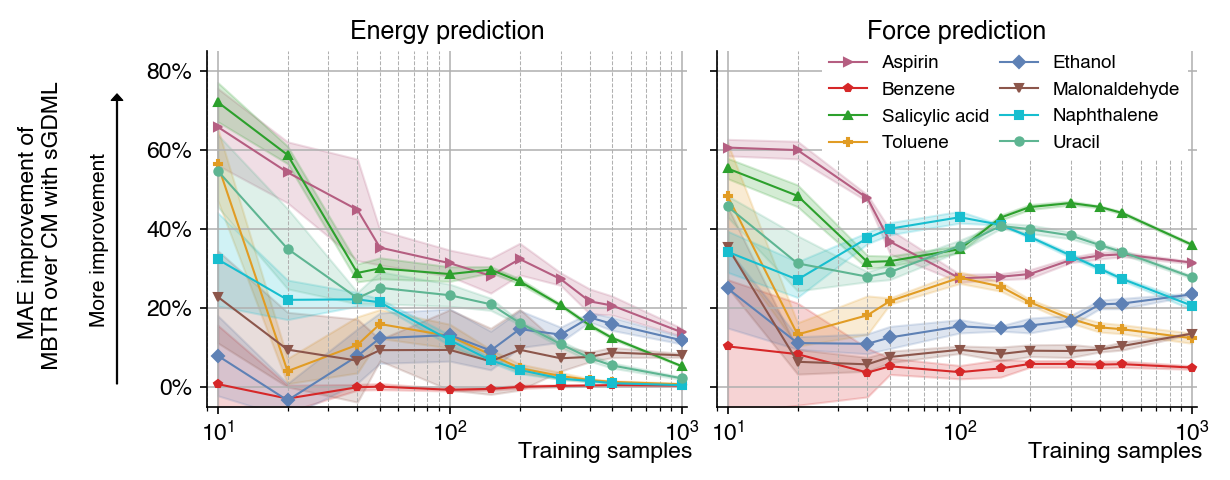

In [70]:
plot_ratios(
    {x: np.array(y) for x, y in plot_data['MAE_Ratio_E'].items()},
    {x: np.array(y) for x, y in plot_data['MAE_Ratio_E_std'].items()},
    {x: np.array(y) for x, y in plot_data['MAE_Ratio_F'].items()},
    {x: np.array(y) for x, y in plot_data['MAE_Ratio_F_std'].items()},
    y_label='MAE improvement of \n MBTR over CM with sGDML'
)
plt.savefig('figures/fig_sgdml_improvements_MAE.pdf')
plt.show()

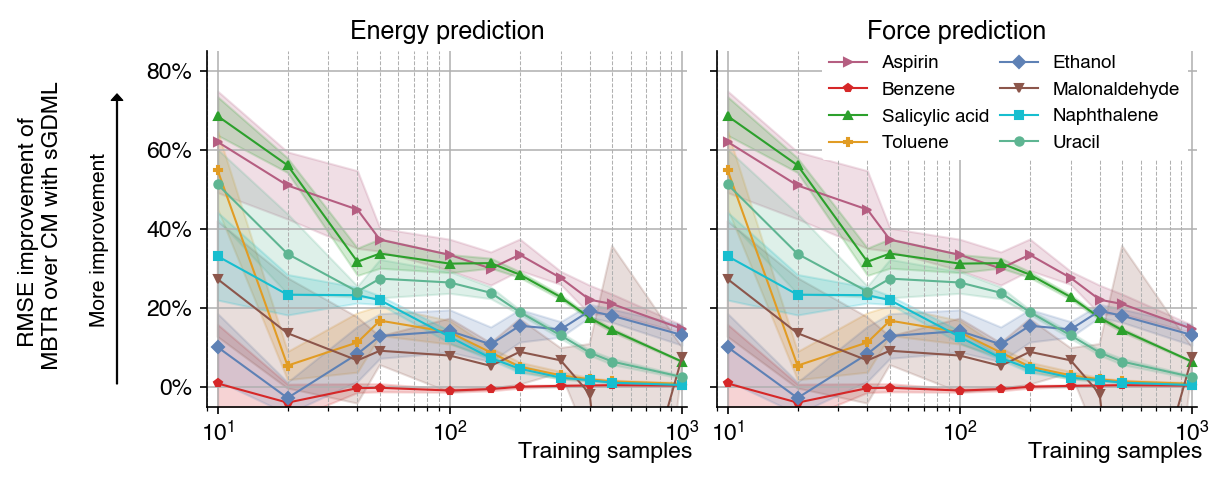

In [71]:
plot_ratios(
    {x: np.array(y) for x, y in plot_data['RMSE_Ratio_E'].items()},
    {x: np.array(y) for x, y in plot_data['RMSE_Ratio_E_std'].items()},
    {x: np.array(y) for x, y in plot_data['RMSE_Ratio_F'].items()},
    {x: np.array(y) for x, y in plot_data['RMSE_Ratio_F_std'].items()},
    y_label='RMSE improvement of \n MBTR over CM with sGDML'
)
plt.savefig('figures/fig_sgdml_improvements_RMSE.pdf')
plt.show()

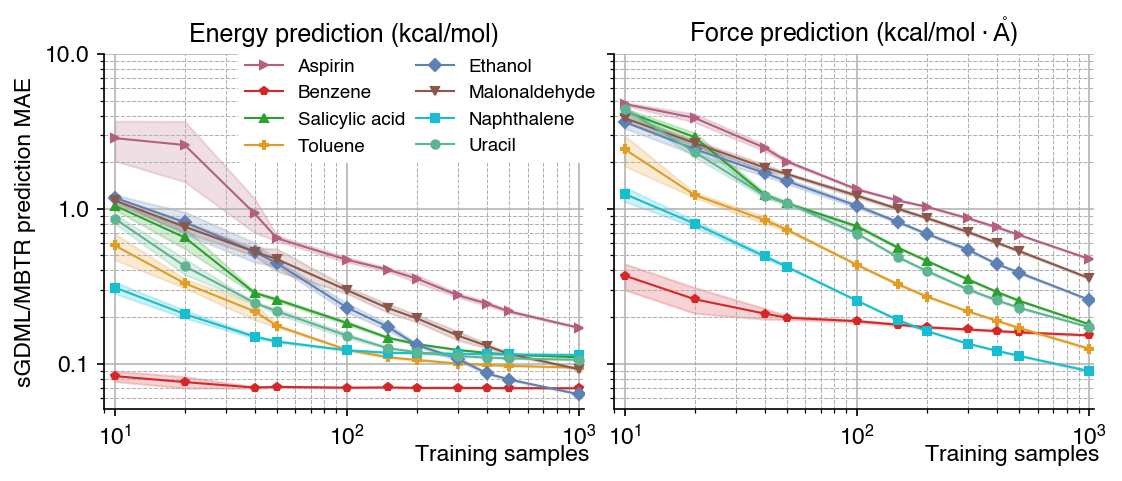

In [36]:
plot_lr(
    {x: np.array(y) for x, y in plot_data['MAE_MBTR_E'].items()},
    {x: np.array(y) for x, y in plot_data['MAE_MBTR_E_std'].items()},
    {x: np.array(y) for x, y in plot_data['MAE_MBTR_F'].items()},
    {x: np.array(y) for x, y in plot_data['MAE_MBTR_F_std'].items()},
    y_label='sGDML/MBTR prediction MAE'
)
plt.savefig('figures/fig_sgdml_mbtr_mae_lr.pdf')
plt.show()

# Molecular dynamics -- simple energy model (Table II, right)

## Data and code

Data for this section can be downloaded from the following URL:
    
http://quantum-machine.org/gdml/

In [29]:
!wget -nc http://quantum-machine.org/gdml/data/npz/benzene2017_dft.npz -O datasets/benzene2017_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/uracil_dft.npz -O datasets/uracil_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/naphthalene_dft.npz -O datasets/naphthalene_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/aspirin_dft.npz -O datasets/aspirin_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/salicylic_dft.npz -O datasets/salicylic_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/malonaldehyde_dft.npz -O datasets/malonaldehyde_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/ethanol_dft.npz -O datasets/ethanol_dft.npz
!wget -nc http://quantum-machine.org/gdml/data/npz/toluene_dft.npz -O datasets/toluene_dft.npz
!md5sum datasets/benzene2017_dft.npz datasets/uracil_dft.npz datasets/naphthalene_dft.npz datasets/aspirin_dft.npz datasets/salicylic_dft.npz datasets/malonaldehyde_dft.npz datasets/ethanol_dft.npz datasets/toluene_dft.npz

File ‘datasets/benzene2017_dft.npz’ already there; not retrieving.
File ‘datasets/uracil_dft.npz’ already there; not retrieving.
File ‘datasets/naphthalene_dft.npz’ already there; not retrieving.
File ‘datasets/aspirin_dft.npz’ already there; not retrieving.
File ‘datasets/salicylic_dft.npz’ already there; not retrieving.
File ‘datasets/malonaldehyde_dft.npz’ already there; not retrieving.
File ‘datasets/ethanol_dft.npz’ already there; not retrieving.
File ‘datasets/toluene_dft.npz’ already there; not retrieving.
b4337db977aeee3bb400b4a1f0db4210  datasets/benzene2017_dft.npz
4c1a8b2247ae4bda3b83ee6e3bd4b825  datasets/uracil_dft.npz
d181a613e91cf4c39125e4e844c3dfa6  datasets/naphthalene_dft.npz
6c3bd18c6450b14ee7dc863547b8f935  datasets/aspirin_dft.npz
90ccf04fb59cf561b15bb6f1bb08f6f9  datasets/salicylic_dft.npz
988fd88e46f405e4008b33a304f473bd  datasets/malonaldehyde_dft.npz
0ce72137ee2f96f303254fc4d97dec2a  datasets/ethanol_dft.npz
47a15536e0159c2f0e4e4d23895ad02a  datasets/toluene_df

Number of frames in training and validation sets for all molecules.

In [12]:
md_num_train, md_num_valid = 10000, 2000

The molecular dynamics data is loaded in each experiment separately due to it's large volume of almost 1 GB.

The following Coulomb matrix variant was used in 

> Stefan Chmiela, Alexandre Tkatchenko, Huziel E. Sauceda, Igor Poltavsky, Kristof Schütt, Klaus-Robert Müller:
> Machine Learning of Accurate Energy-Conserving Molecular Force Fields, Science Advances 3(5): e1603015, 2017.
> [DOI](https://doi.org/10.1126/sciadv.1603015)
    
See the supplement for details.

In [13]:
def load_qm_17(npz_fn, n):
    npz_data = np.load(npz_fn)
    r = npz_data['R']
    e = npz_data['E'][:, 0]
    z = np.repeat(npz_data['z'][None], axis=0, repeats=n)
    elems = np.unique(z)

    r = np.array(list(r), dtype=object)
    z = np.array(list(z), dtype=object)

    assert n == r.shape[0] == e.shape[0]
    
    return z, r, e, elems, n

@cached(max_entries=40)
def reprfcm(z, r, basis=None, theta=None, flatten=True):
    """Coulomb matrix variant modified for molecular dynamics data.
    
    No padding, as number of atoms is constant.
    No sorting, as the atom order is always the same.
    Diagonal is not used as it is constant."""
    return qmml.coulomb_matrix(z, r, \
        padding=False, flatten=-1, sort=False, \
        post=lambda cmij, zi, zj, dij, i, j : 1. / dij if i != j else cmij)

A variant of MBTR for molecular dynamics data. 
Each atom is treated as it's own species, effectively enabling per-atom information.

In [14]:
@cached(max_entries=20)
def reprfmd2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, no weighting, parametrization for molecular dynamics"""
    assert basis is None
    dmin, dmax = dsi['min_distance'], dsi['max_distance']
    (dsigma2,) = theta
    zz = np.repeat(np.asarray([np.arange(len(z[0]))+1]), len(z), axis=0)
    return qmml.many_body_tensor(
        zz, r, ( 1.05/dmax-0.05/dmin, (1/dmin-1/dmax)*1.1/30, 30),  # [1/dmax, 1/dmin] plus 5% margin
        (2, '1/distance', 'unity', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=None, flatten=flatten)

@cached(max_entries=20)
def reprfmd3(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=3, angles, no weighting, parametrization for molecular dynamics"""
    assert basis is None
    (dsigma2,) = theta
    zz = np.repeat(np.asarray([np.arange(len(z[0]))+1]), len(z), axis=0)
    return qmml.many_body_tensor(
        zz, r, ( -np.pi*0.05, np.pi*1.1/30, 30),  # [0,Pi] plus 5% margin
        (3, 'angle', 'unity', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=None, flatten=flatten)

Regular MBTR variant. One-body terms would be constant, and thus pointless, as these are different conformations of the same molecule, whose composition does not change.

In [15]:
@cached(max_entries=30)
def reprf2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, quadratic weighting"""
    assert basis is None
    dmin, dmax = dsi['min_distance'], dsi['max_distance']
    (dsigma2,) = theta
    return qmml.many_body_tensor(
        z, r, ( 1.05/dmax-0.05/dmin, (1/dmin-1/dmax)*1.1/50, 50),  # [1/dmax, 1/dmin] plus 5% margin
        (2, '1/distance', 'identity^2', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=None, flatten=flatten)

@cached(max_entries=30)
def reprf3(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=3, angles"""
    assert basis is None
    (dsigma3,) = theta
    return qmml.many_body_tensor(
        z, r, ( -np.pi*0.05, np.pi*1.1/50, 50),  # [0,Pi] +/- 5% margin
        (3, 'angle', '1/dotdotdot', ('normal', (dsigma3,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.001, elems=None, flatten=flatten)

Kernel functions:

In [16]:
kernelf_linear    = cached(max_entries=35)(qmml.kernel_linear)
kernelf_laplacian = cached(max_entries=35)(qmml.kernel_laplacian)
kernelf_gaussian  = cached(max_entries=35)(qmml.kernel_gaussian)

## Benzene

### Data

Clear all caches.

In [17]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [57]:
%%time
z, r, e, elems, n = load_qm_17('datasets/benzene2017_dft.npz', n=627983)

CPU times: user 2.56 s, sys: 244 ms, total: 2.81 s
Wall time: 2.8 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [42]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [43]:
%%time
dsi = dataset_info(z, r, e, basis=None, verbose=True)

627983 finite systems (molecules)
elements: H C (2)
max #els/system: 2;  max #el/system: 6;  max #atoms/system: 12
min dist: 0.97;  max dist: 5.28;  1/min dist: 1.03;  1/max dist: 0.19
CPU times: user 3min 45s, sys: 394 ms, total: 3min 45s
Wall time: 3min 45s


### CM (MD variant)

#### Linear kernel

In [63]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 1, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 1, #evals = 2, done = True
best solution: f(-20.0,) = 1.748
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 1.759
MAE     = 1.372
R^2     = 0.436910
maxAE   = 9.633
RMSE/a  = 0.147
MAE/a   = 0.114
maxAE/a = 0.803

CPU times: user 1min, sys: 4.44 s, total: 1min 4s
Wall time: 14 s


#### Gaussian kernel

In [66]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.0, 1, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 2, #evals = 4, done = True
best solution: f(-2.0, -20.0) = 0.043
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.043
MAE     = 0.031
R^2     = 0.999667
maxAE   = 0.443
RMSE/a  = 0.004
MAE/a   = 0.003
maxAE/a = 0.037

CPU times: user 1min 34s, sys: 5.78 s, total: 1min 40s
Wall time: 18.4 s


#### Laplacian kernel

In [67]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 12, #evals = 16, done = True
best solution: f(4.0, -19.0) = 0.359
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.307
MAE     = 0.230
R^2     = 0.983037
maxAE   = 1.907
RMSE/a  = 0.026
MAE/a   = 0.019
maxAE/a = 0.159

CPU times: user 4min 43s, sys: 16 s, total: 4min 59s
Wall time: 1min 6s


### MBTR (MD variant)

#### Linear kernel

In [68]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-12.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 18, #evals = 23, done = True
best solution: f(-4.5, -2.0, -17.0) = 0.0469
var = 1, update = False
converged vars: T  T  T , directions: -1 +1 +1

n       = 2000
RMSE    = 0.046
MAE     = 0.034
R^2     = 0.999623
maxAE   = 0.340
RMSE/a  = 0.004
MAE/a   = 0.003
maxAE/a = 0.028

CPU times: user 43min 14s, sys: 1min 3s, total: 44min 17s
Wall time: 8min 13s


#### Gaussian kernel

In [69]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 11, #evals = 17, done = True
best solution: f(-4.0, -1.5, 2.5, -20.0) = 0.0386
var = 1, update = False
converged vars: T  T  T  T , directions: -1 -1 -1 +1

n       = 2000
RMSE    = 0.036
MAE     = 0.026
R^2     = 0.999769
maxAE   = 0.198
RMSE/a  = 0.003
MAE/a   = 0.002
maxAE/a = 0.016

CPU times: user 48min 17s, sys: 41.1 s, total: 48min 58s
Wall time: 7min 30s


#### Laplacian kernel

In [37]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+11.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 24, #evals = 30, done = True
best solution: f(-3.0, -2.5, 5.5, -20.0) = 0.3018
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 +1 +1

n       = 2000
RMSE    = 0.282
MAE     = 0.207
R^2     = 0.985608
maxAE   = 1.436
RMSE/a  = 0.024
MAE/a   = 0.017
maxAE/a = 0.120


### MBTR

#### Linear kernel

In [58]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 6.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 9, #evals = 13, done = True
best solution: f(-5.5, -4.5, -20.0) = 0.0557
var = 0, update = False
converged vars: T  T  T , directions: +1 +1 +1

n       = 2000
RMSE    = 0.063
MAE     = 0.044
R^2     = 0.999285
maxAE   = 0.751
RMSE/a  = 0.005
MAE/a   = 0.004
maxAE/a = 0.063

CPU times: user 5min 1s, sys: 19.6 s, total: 5min 21s
Wall time: 55.3 s


#### Gaussian kernel

In [59]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 2.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 2.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 28, #evals = 38, done = True
best solution: f(-4.0, -4.0, -0.5, -20.0) = 0.062
var = 0, update = False
converged vars: T  T  T  T , directions: -1 +1 +1 +1

n       = 2000
RMSE    = 0.065
MAE     = 0.045
R^2     = 0.999240
maxAE   = 0.682
RMSE/a  = 0.005
MAE/a   = 0.004
maxAE/a = 0.057

CPU times: user 13min 18s, sys: 56.1 s, total: 14min 14s
Wall time: 2min 8s


#### Laplacian kernel

In [38]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 8.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-17.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 15, #evals = 21, done = True
best solution: f(-5.0, -2.5, 10.5, -20.0) = 0.4441
var = 1, update = False
converged vars: T  T  T  T , directions: -1 -1 +1 +1

n       = 2000
RMSE    = 0.396
MAE     = 0.288
R^2     = 0.973527
maxAE   = 2.494
RMSE/a  = 0.033
MAE/a   = 0.024
maxAE/a = 0.208


## Uracil

### Data

Clear all caches.

In [60]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [61]:
%%time
z, r, e, elems, n = load_qm_17('datasets/uracil_dft.npz', n=133770)

CPU times: user 578 ms, sys: 55.9 ms, total: 633 ms
Wall time: 633 ms


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [62]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [25]:
%%time
dsi = dataset_info(z, r, e, basis=None, verbose=True)

133770 finite systems (molecules)
elements: H C N O (4)
max #els/system: 4;  max #el/system: 4;  max #atoms/system: 12
min dist: 0.90;  max dist: 5.50;  1/min dist: 1.12;  1/max dist: 0.18
CPU times: user 20.2 s, sys: 140 ms, total: 20.3 s
Wall time: 20.3 s


### CM (MD variant)

#### Linear kernel

In [63]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 5, #evals = 6, done = True
best solution: f(-16.0,) = 3.7201
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 3.751
MAE     = 2.956
R^2     = 0.423783
maxAE   = 16.393
RMSE/a  = 0.313
MAE/a   = 0.246
maxAE/a = 1.366

CPU times: user 2min 3s, sys: 7.98 s, total: 2min 11s
Wall time: 22.8 s


#### Gaussian kernel

In [64]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 8, #evals = 8, done = True
best solution: f(-2.0, -20.0) = 0.0836
var = 1, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.079
MAE     = 0.054
R^2     = 0.999754
maxAE   = 0.561
RMSE/a  = 0.007
MAE/a   = 0.005
maxAE/a = 0.047

CPU times: user 2min 22s, sys: 9.41 s, total: 2min 31s
Wall time: 18.7 s


#### Laplacian kernel

In [39]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 10, #evals = 11, done = True
best solution: f(5.0, -20.0) = 0.8974
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 0.919
MAE     = 0.671
R^2     = 0.968386
maxAE   = 5.430
RMSE/a  = 0.077
MAE/a   = 0.056
maxAE/a = 0.453


### MBTR (MD variant)

#### Linear kernel

In [66]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 4, #evals = 7, done = True
best solution: f(-3.5, -1.0, -19.0) = 0.1329
var = 0, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2000
RMSE    = 0.128
MAE     = 0.096
R^2     = 0.999329
maxAE   = 0.670
RMSE/a  = 0.011
MAE/a   = 0.008
maxAE/a = 0.056

CPU times: user 20min 24s, sys: 17.5 s, total: 20min 41s
Wall time: 3min 30s


#### Gaussian kernel

In [67]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 2.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 7, #evals = 11, done = True
best solution: f(-3.5, -1.0, 1.5, -20.0) = 0.0447
var = 0, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 0.047
MAE     = 0.031
R^2     = 0.999912
maxAE   = 0.309
RMSE/a  = 0.004
MAE/a   = 0.003
maxAE/a = 0.026

CPU times: user 32min 26s, sys: 25.4 s, total: 32min 51s
Wall time: 4min 50s


#### Laplacian kernel

In [40]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 2.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 7.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 10, #evals = 14, done = True
best solution: f(-3.0, 0.0, 7.5, -20.0) = 0.715
var = 0, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 0.758
MAE     = 0.534
R^2     = 0.978584
maxAE   = 5.256
RMSE/a  = 0.063
MAE/a   = 0.044
maxAE/a = 0.438


### MBTR

#### Linear kernel

In [68]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 9, #evals = 12, done = True
best solution: f(-5.5, -4.5, -20.0) = 0.3501
var = 0, update = False
converged vars: T  T  T , directions: -1 +1 +1

n       = 2000
RMSE    = 0.361
MAE     = 0.267
R^2     = 0.994673
maxAE   = 2.188
RMSE/a  = 0.030
MAE/a   = 0.022
maxAE/a = 0.182

CPU times: user 7min 14s, sys: 24.3 s, total: 7min 38s
Wall time: 1min 23s


#### Gaussian kernel

In [69]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 10, #evals = 14, done = True
best solution: f(-2.5, -3.0, -1.0, -20.0) = 0.2309
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 -1 +1

n       = 2000
RMSE    = 0.237
MAE     = 0.164
R^2     = 0.997724
maxAE   = 2.086
RMSE/a  = 0.020
MAE/a   = 0.014
maxAE/a = 0.174

CPU times: user 7min 49s, sys: 23.1 s, total: 8min 12s
Wall time: 1min 20s


#### Laplacian kernel

In [41]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 5.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 10, #evals = 14, done = True
best solution: f(-3.0, -3.0, 6.5, -20.0) = 0.9349
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 +1 +1

n       = 2000
RMSE    = 0.964
MAE     = 0.715
R^2     = 0.964503
maxAE   = 5.509
RMSE/a  = 0.080
MAE/a   = 0.060
maxAE/a = 0.459


## Naphthalene

### Data

Clear all caches.

In [70]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [71]:
%%time

z, r, e, elems, n = load_qm_17('datasets/naphthalene_dft.npz', n=326250)

CPU times: user 1.86 s, sys: 284 ms, total: 2.15 s
Wall time: 2.14 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [72]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [77]:
%%time
dsi = dataset_info(z, r, e, basis=None, verbose=True)

326250 finite systems (molecules)
elements: H C (2)
max #els/system: 2;  max #el/system: 10;  max #atoms/system: 18
min dist: 0.94;  max dist: 7.60;  1/min dist: 1.06;  1/max dist: 0.13
CPU times: user 2min 52s, sys: 204 ms, total: 2min 52s
Wall time: 2min 52s


### CM (MD variant)

#### Linear kernel

In [78]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 5, #evals = 6, done = True
best solution: f(-16.0,) = 4.5259
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 4.415
MAE     = 3.502
R^2     = 0.374219
maxAE   = 22.230
RMSE/a  = 0.245
MAE/a   = 0.195
maxAE/a = 1.235

CPU times: user 2min 13s, sys: 8.13 s, total: 2min 21s
Wall time: 29.9 s


#### Gaussian kernel

In [79]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 6, #evals = 7, done = True
best solution: f(-1.5, -20.0) = 0.1514
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.158
MAE     = 0.119
R^2     = 0.999213
maxAE   = 0.976
RMSE/a  = 0.009
MAE/a   = 0.007
maxAE/a = 0.054

CPU times: user 2min 12s, sys: 8.49 s, total: 2min 20s
Wall time: 17.6 s


#### Laplacian kernel

In [42]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 4.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 6, #evals = 8, done = True
best solution: f(6.0, -20.0) = 1.4398
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 1.422
MAE     = 1.093
R^2     = 0.943795
maxAE   = 7.837
RMSE/a  = 0.079
MAE/a   = 0.061
maxAE/a = 0.435


### MBTR (MD variant)

#### Linear kernel

In [81]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-12.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 9, #evals = 12, done = True
best solution: f(-3.0, -1.5, -18.0) = 0.1335
var = 0, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2000
RMSE    = 0.125
MAE     = 0.095
R^2     = 0.999498
maxAE   = 0.598
RMSE/a  = 0.007
MAE/a   = 0.005
maxAE/a = 0.033

CPU times: user 1h 3min 6s, sys: 48 s, total: 1h 3min 54s
Wall time: 12min 54s


#### Gaussian kernel

In [82]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.0, 2, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 12, #evals = 17, done = True
best solution: f(-3.5, -0.5, 2.0, -20.0) = 0.0963
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 0.093
MAE     = 0.068
R^2     = 0.999727
maxAE   = 0.468
RMSE/a  = 0.005
MAE/a   = 0.004
maxAE/a = 0.026

CPU times: user 2h 14min 52s, sys: 1min 15s, total: 2h 16min 8s
Wall time: 21min 54s


#### Laplacian kernel

In [43]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+17.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 25, #evals = 29, done = True
best solution: f(-5.0, -2.0, 11.0, -20.0) = 1.2165
var = 1, update = False
converged vars: T  T  T  T , directions: +1 -1 -1 +1

n       = 2000
RMSE    = 1.160
MAE     = 0.875
R^2     = 0.959968
maxAE   = 5.930
RMSE/a  = 0.064
MAE/a   = 0.049
maxAE/a = 0.329


### MBTR

#### Linear kernel

In [83]:
%%time 

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 6.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 5, #evals = 8, done = True
best solution: f(-5.5, -4.5, -20.0) = 0.4591
var = 1, update = False
converged vars: T  T  T , directions: -1 -1 +1

n       = 2000
RMSE    = 0.497
MAE     = 0.365
R^2     = 0.992100
maxAE   = 6.405
RMSE/a  = 0.028
MAE/a   = 0.020
maxAE/a = 0.356

CPU times: user 3min 58s, sys: 19.1 s, total: 4min 17s
Wall time: 1min 13s


#### Gaussian kernel

In [84]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 1.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 19, #evals = 21, done = True
best solution: f(-4.0, -3.0, 0.5, -20.0) = 0.4515
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 -1 +1

n       = 2000
RMSE    = 0.467
MAE     = 0.360
R^2     = 0.992996
maxAE   = 2.126
RMSE/a  = 0.026
MAE/a   = 0.020
maxAE/a = 0.118

CPU times: user 8min 13s, sys: 34 s, total: 8min 47s
Wall time: 2min 16s


#### Laplacian kernel

In [44]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 2.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 16, #evals = 20, done = True
best solution: f(-3.0, -3.0, 6.5, -20.0) = 1.2154
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 +1 +1

n       = 2000
RMSE    = 1.145
MAE     = 0.894
R^2     = 0.958585
maxAE   = 5.179
RMSE/a  = 0.064
MAE/a   = 0.050
maxAE/a = 0.288


## Aspirin

### Data

Clear all caches.

In [18]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [19]:
%%time

z, r, e, elems, n = load_qm_17('datasets/aspirin_dft.npz', n=211762)

CPU times: user 1.94 s, sys: 369 ms, total: 2.31 s
Wall time: 2.38 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [20]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [21]:
%%time
dsi = dataset_info(z, r, e, basis=None, verbose=True)

211762 finite systems (molecules)
elements: H C O (3)
max #els/system: 3;  max #el/system: 9;  max #atoms/system: 21
min dist: 0.89;  max dist: 8.79;  1/min dist: 1.13;  1/max dist: 0.11
CPU times: user 2min, sys: 239 ms, total: 2min
Wall time: 2min


### CM (MD variant)

#### Linear kernel

In [89]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 2, #evals = 3, done = True
best solution: f(-19.0,) = 5.0556
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 4.565
MAE     = 3.628
R^2     = 0.411635
maxAE   = 18.396
RMSE/a  = 0.217
MAE/a   = 0.173
maxAE/a = 0.876

CPU times: user 1min 30s, sys: 5.2 s, total: 1min 35s
Wall time: 27.2 s


#### Gaussian kernel

In [22]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 9, #evals = 10, done = True
best solution: f(-0.5, -20.0) = 0.5067
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 0.505
MAE     = 0.356
R^2     = 0.992895
maxAE   = 2.658
RMSE/a  = 0.024
MAE/a   = 0.017
maxAE/a = 0.127

CPU times: user 3min 44s, sys: 14.1 s, total: 3min 58s
Wall time: 45.7 s


#### Laplacian kernel

In [37]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 12, #evals = 13, done = True
best solution: f(6.0, -20.0) = 2.7501
var = 1, update = False
converged vars: T  T , directions: -1 +1

Begin batching for (10000, 210) None
Done in 10.894 secs
Begin batching for (10000, 210) (2000, 210)
Done in 9.424 secs
n       = 2000
RMSE    = 2.527
MAE     = 1.895
R^2     = 0.830539
maxAE   = 11.860
RMSE/a  = 0.120
MAE/a   = 0.090
maxAE/a = 0.565


### MBTR (MD variant)

#### Linear kernel

In [23]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 0.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 6, #evals = 10, done = True
best solution: f(-3.5, -0.0, -20.0) = 0.2851
var = 1, update = False
converged vars: T  T  T , directions: -1 +1 +1

n       = 2000
RMSE    = 0.285
MAE     = 0.208
R^2     = 0.997705
maxAE   = 1.612
RMSE/a  = 0.014
MAE/a   = 0.010
maxAE/a = 0.077

CPU times: user 2h 38min 47s, sys: 1min 4s, total: 2h 39min 52s
Wall time: 24min 49s


#### Gaussian kernel

In [92]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 1.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 4, #evals = 8, done = True
best solution: f(-2.5, 1.5, 1.0, -20.0) = 0.3456
var = 0, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2000
RMSE    = 0.345
MAE     = 0.248
R^2     = 0.996642
maxAE   = 1.623
RMSE/a  = 0.016
MAE/a   = 0.012
maxAE/a = 0.077

CPU times: user 1h 59min 45s, sys: 1min, total: 2h 46s
Wall time: 19min 9s


#### Laplacian kernel

In [38]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+15.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 51, #evals = 59, done = True
best solution: f(-5.0, 0.0, 11.0, -20.0) = 2.156
var = 1, update = False
converged vars: T  T  T  T , directions: +1 -1 -1 +1

Begin batching for (10000, 152460) None
Done in 978.141 secs
Begin batching for (10000, 152460) (2000, 152460)
Done in 203.448 secs
n       = 2000
RMSE    = 2.100
MAE     = 1.559
R^2     = 0.881816
maxAE   = 10.383
RMSE/a  = 0.100
MAE/a   = 0.074
maxAE/a = 0.494


### MBTR

#### Linear kernel

In [24]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 6.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 10, #evals = 13, done = True
best solution: f(-6.5, -3.5, -20.0) = 1.4107
var = 1, update = False
converged vars: T  T  T , directions: -1 +1 +1

n       = 2000
RMSE    = 1.409
MAE     = 1.080
R^2     = 0.944033
maxAE   = 6.838
RMSE/a  = 0.067
MAE/a   = 0.051
maxAE/a = 0.326

CPU times: user 9min 18s, sys: 34 s, total: 9min 52s
Wall time: 3min 10s


#### Gaussian kernel

In [23]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 0.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 13, #evals = 15, done = True
best solution: f(-3.0, -3.0, 0.5, -20.0) = 1.2627
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2000
RMSE    = 1.222
MAE     = 0.905
R^2     = 0.957889
maxAE   = 5.932
RMSE/a  = 0.058
MAE/a   = 0.043
maxAE/a = 0.282

CPU times: user 10min 20s, sys: 38 s, total: 10min 58s
Wall time: 3min 27s


#### Laplacian kernel

In [39]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 2.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 27, #evals = 33, done = True
best solution: f(-4.0, -3.5, 8.0, -20.0) = 2.0265
var = 1, update = False
converged vars: T  T  T  T , directions: -1 -1 -1 +1

Begin batching for (10000, 1200) None
Done in 10.146 secs
Begin batching for (10000, 1200) (2000, 1200)
Done in 8.222 secs
n       = 2000
RMSE    = 2.047
MAE     = 1.573
R^2     = 0.884204
maxAE   = 11.846
RMSE/a  = 0.097
MAE/a   = 0.075
maxAE/a = 0.564


## Salicylic acid

### Data

Clear all caches.

In [21]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [18]:
%%time
z, r, e, elems, n = load_qm_17('datasets/salicylic_dft.npz', n=320231)

CPU times: user 3.55 s, sys: 683 ms, total: 4.23 s
Wall time: 4.29 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [19]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [20]:
dsi = dataset_info(z, r, e, basis=None, verbose=True)

320231 finite systems (molecules)
elements: H C O (3)
max #els/system: 3;  max #el/system: 7;  max #atoms/system: 16
min dist: 0.86;  max dist: 7.47;  1/min dist: 1.17;  1/max dist: 0.13


### CM (MD variant)

#### Linear kernel

In [21]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 6, #evals = 7, done = True
best solution: f(-15.0,) = 4.2636
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 4.194
MAE     = 3.348
R^2     = 0.399518
maxAE   = 18.112
RMSE/a  = 0.262
MAE/a   = 0.209
maxAE/a = 1.132

CPU times: user 2min 59s, sys: 10.6 s, total: 3min 9s
Wall time: 34.1 s


#### Gaussian kernel

In [22]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 6, #evals = 7, done = True
best solution: f(-1.5, -20.0) = 0.1545
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.155
MAE     = 0.110
R^2     = 0.999197
maxAE   = 1.078
RMSE/a  = 0.010
MAE/a   = 0.007
maxAE/a = 0.067

CPU times: user 3min 37s, sys: 12.1 s, total: 3min 49s
Wall time: 31.5 s


#### Laplacian kernel

In [45]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 12, #evals = 13, done = True
best solution: f(6.0, -20.0) = 1.3631
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 1.382
MAE     = 1.057
R^2     = 0.941435
maxAE   = 7.769
RMSE/a  = 0.086
MAE/a   = 0.066
maxAE/a = 0.486


### MBTR (MD variant)

#### Linear kernel

In [24]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-12.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 20, #evals = 23, done = True
best solution: f(-3.5, -0.5, -20.0) = 0.1685
var = 1, update = False
converged vars: T  T  T , directions: -1 +1 +1

n       = 2000
RMSE    = 0.174
MAE     = 0.127
R^2     = 0.998961
maxAE   = 1.265
RMSE/a  = 0.011
MAE/a   = 0.008
maxAE/a = 0.079

CPU times: user 1h 55min, sys: 1min 35s, total: 1h 56min 35s
Wall time: 20min 49s


#### Gaussian kernel

In [25]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 0.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 2.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 4, #evals = 8, done = True
best solution: f(-3.5, -0.5, 2.0, -20.0) = 0.088
var = 0, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2000
RMSE    = 0.102
MAE     = 0.068
R^2     = 0.999648
maxAE   = 1.261
RMSE/a  = 0.006
MAE/a   = 0.004
maxAE/a = 0.079

CPU times: user 55min 6s, sys: 22.4 s, total: 55min 29s
Wall time: 8min 4s


#### Laplacian kernel

In [46]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = qmml.AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 6.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 19, #evals = 23, done = True
best solution: f(-3.0, 0.5, 8.0, -20.0) = 1.1877
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 1.193
MAE     = 0.900
R^2     = 0.955444
maxAE   = 7.287
RMSE/a  = 0.075
MAE/a   = 0.056
maxAE/a = 0.455


### MBTR

#### Linear kernel

In [27]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 10, #evals = 13, done = True
best solution: f(-4.5, -3.5, -20.0) = 0.6034
var = 0, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2000
RMSE    = 0.645
MAE     = 0.485
R^2     = 0.985776
maxAE   = 3.854
RMSE/a  = 0.040
MAE/a   = 0.030
maxAE/a = 0.241

CPU times: user 6min 34s, sys: 29.6 s, total: 7min 3s
Wall time: 1min 26s


#### Gaussian kernel

In [26]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 0.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 9, #evals = 11, done = True
best solution: f(-3.0, -3.0, 0.0, -20.0) = 0.5374
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 0.546
MAE     = 0.405
R^2     = 0.989818
maxAE   = 3.843
RMSE/a  = 0.034
MAE/a   = 0.025
maxAE/a = 0.240

CPU times: user 5min 24s, sys: 15.7 s, total: 5min 40s
Wall time: 1min 31s


#### Laplacian kernel

In [47]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = qmml.AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 2.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 0.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 39, #evals = 46, done = True
best solution: f(-3.0, -3.0, 7.0, -20.0) = 1.4622
var = 0, update = False
converged vars: T  T  T  T , directions: +1 -1 +1 +1

n       = 2000
RMSE    = 1.405
MAE     = 1.072
R^2     = 0.934588
maxAE   = 6.634
RMSE/a  = 0.088
MAE/a   = 0.067
maxAE/a = 0.415


## Malonaldehyde

### Data

Clear all caches.

In [28]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [17]:
%%time
z, r, e, elems, n = load_qm_17('datasets/malonaldehyde_dft.npz', n=993237)

CPU times: user 4.69 s, sys: 639 ms, total: 5.32 s
Wall time: 5.46 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [18]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [19]:
dsi = dataset_info(z, r, e, basis=None, verbose=True)

993237 finite systems (molecules)
elements: H C O (3)
max #els/system: 3;  max #el/system: 4;  max #atoms/system: 9
min dist: 0.94;  max dist: 5.02;  1/min dist: 1.07;  1/max dist: 0.20


### CM (MD variant)

#### Linear kernel

In [20]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 1, #evals = 2, done = True
best solution: f(-20.0,) = 3.4342
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 3.452
MAE     = 2.666
R^2     = 0.305017
maxAE   = 21.722
RMSE/a  = 0.384
MAE/a   = 0.296
maxAE/a = 2.414

CPU times: user 1min, sys: 4.16 s, total: 1min 4s
Wall time: 11.4 s


#### Gaussian kernel

In [21]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 8, #evals = 8, done = True
best solution: f(-2.0, -20.0) = 0.2686
var = 1, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.246
MAE     = 0.176
R^2     = 0.996541
maxAE   = 1.374
RMSE/a  = 0.027
MAE/a   = 0.020
maxAE/a = 0.153

CPU times: user 2min 31s, sys: 10.1 s, total: 2min 41s
Wall time: 20.2 s


#### Laplacian kernel

In [48]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 7, #evals = 9, done = True
best solution: f(5.0, -20.0) = 1.3478
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 1.279
MAE     = 0.963
R^2     = 0.912610
maxAE   = 8.104
RMSE/a  = 0.142
MAE/a   = 0.107
maxAE/a = 0.900


### MBTR (MD variant)

#### Linear kernel

In [23]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 2, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 6, #evals = 9, done = True
best solution: f(-4.5, -1.0, -17.0) = 0.2779
var = 0, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2000
RMSE    = 0.283
MAE     = 0.211
R^2     = 0.995329
maxAE   = 1.749
RMSE/a  = 0.031
MAE/a   = 0.023
maxAE/a = 0.194

CPU times: user 17min 1s, sys: 29.9 s, total: 17min 30s
Wall time: 2min 58s


#### Gaussian kernel

In [24]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 6, #evals = 10, done = True
best solution: f(-4.0, -1.5, 3.0, -20.0) = 0.1359
var = 0, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 0.142
MAE     = 0.097
R^2     = 0.998837
maxAE   = 1.510
RMSE/a  = 0.016
MAE/a   = 0.011
maxAE/a = 0.168

CPU times: user 24min 10s, sys: 31.9 s, total: 24min 42s
Wall time: 3min 27s


#### Laplacian kernel

In [49]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (+ 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 8.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 18, #evals = 24, done = True
best solution: f(-3.5, 2.5, 8.0, -20.0) = 1.1248
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 -1 +1

n       = 2000
RMSE    = 1.125
MAE     = 0.834
R^2     = 0.931556
maxAE   = 7.344
RMSE/a  = 0.125
MAE/a   = 0.093
maxAE/a = 0.816


### MBTR

#### Linear kernel

In [25]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 15, #evals = 18, done = True
best solution: f(-4.0, -4.5, -20.0) = 0.7244
var = 0, update = False
converged vars: T  T  T , directions: +1 +1 +1

n       = 2000
RMSE    = 0.790
MAE     = 0.572
R^2     = 0.963658
maxAE   = 5.916
RMSE/a  = 0.088
MAE/a   = 0.064
maxAE/a = 0.657

CPU times: user 10min 55s, sys: 56.7 s, total: 11min 52s
Wall time: 2min


#### Gaussian kernel

In [26]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 2.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 1.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 6, #evals = 10, done = True
best solution: f(-3.0, -2.5, -1.5, -20.0) = 0.4688
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 0.517
MAE     = 0.357
R^2     = 0.984418
maxAE   = 4.111
RMSE/a  = 0.057
MAE/a   = 0.040
maxAE/a = 0.457

CPU times: user 6min 39s, sys: 31.1 s, total: 7min 10s
Wall time: 1min 16s


#### Laplacian kernel

In [50]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 14, #evals = 17, done = True
best solution: f(-3.5, -3.0, 6.5, -20.0) = 1.0866
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 1.123
MAE     = 0.827
R^2     = 0.927611
maxAE   = 6.469
RMSE/a  = 0.125
MAE/a   = 0.092
maxAE/a = 0.719


## Ethanol

### Data

Clear all caches.

In [16]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [17]:
%%time
z, r, e, elems, n = load_qm_17('datasets/ethanol_dft.npz', n=555092)

CPU times: user 2.58 s, sys: 386 ms, total: 2.96 s
Wall time: 3.03 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [18]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [19]:
dsi = dataset_info(z, r, e, basis=None, verbose=True)

555092 finite systems (molecules)
elements: H C O (3)
max #els/system: 3;  max #el/system: 6;  max #atoms/system: 9
min dist: 0.86;  max dist: 4.49;  1/min dist: 1.17;  1/max dist: 0.22


### CM (MD variant)

#### Linear kernel

In [20]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 1, #evals = 2, done = True
best solution: f(-20.0,) = 3.6833
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 3.553
MAE     = 2.819
R^2     = 0.281746
maxAE   = 16.700
RMSE/a  = 0.395
MAE/a   = 0.313
maxAE/a = 1.856

CPU times: user 1min 39s, sys: 5.76 s, total: 1min 44s
Wall time: 22.4 s


#### Gaussian kernel

In [21]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 6, #evals = 7, done = True
best solution: f(-1.5, -20.0) = 0.2527
var = 0, update = False
converged vars: T  T , directions: +1 +1

n       = 2000
RMSE    = 0.231
MAE     = 0.166
R^2     = 0.996979
maxAE   = 1.426
RMSE/a  = 0.026
MAE/a   = 0.018
maxAE/a = 0.158

CPU times: user 3min 47s, sys: 13.8 s, total: 4min 1s
Wall time: 34.7 s


#### Laplacian kernel

In [51]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 10, #evals = 11, done = True
best solution: f(5.0, -20.0) = 1.1647
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 1.047
MAE     = 0.794
R^2     = 0.940768
maxAE   = 5.641
RMSE/a  = 0.116
MAE/a   = 0.088
maxAE/a = 0.627


### MBTR (MD variant)

#### Linear kernel

In [23]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-15.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 3, #evals = 7, done = True
best solution: f(-4.0, -1.5, -15.0) = 0.223
var = 0, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2000
RMSE    = 0.227
MAE     = 0.168
R^2     = 0.997066
maxAE   = 1.302
RMSE/a  = 0.025
MAE/a   = 0.019
maxAE/a = 0.145

CPU times: user 10min 33s, sys: 14.8 s, total: 10min 48s
Wall time: 1min 43s


#### Gaussian kernel

In [24]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 16, #evals = 23, done = True
best solution: f(-3.0, -1.0, 2.0, -20.0) = 0.0921
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 -1 +1

n       = 2000
RMSE    = 0.084
MAE     = 0.060
R^2     = 0.999599
maxAE   = 0.399
RMSE/a  = 0.009
MAE/a   = 0.007
maxAE/a = 0.044

CPU times: user 31min 31s, sys: 39.8 s, total: 32min 11s
Wall time: 4min 47s


#### Laplacian kernel

In [52]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 6.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 52, #evals = 60, done = True
best solution: f(-4.5, -2.0, 11.0, -20.0) = 0.7824
var = 0, update = False
converged vars: T  T  T  T , directions: -1 -1 -1 +1

n       = 2000
RMSE    = 0.708
MAE     = 0.518
R^2     = 0.974869
maxAE   = 4.073
RMSE/a  = 0.079
MAE/a   = 0.058
maxAE/a = 0.453


### MBTR

#### Linear kernel

In [25]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 5.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 11, #evals = 14, done = True
best solution: f(-5.0, -3.5, -20.0) = 0.5651
var = 1, update = False
converged vars: T  T  T , directions: +1 +1 +1

n       = 2000
RMSE    = 0.553
MAE     = 0.403
R^2     = 0.982597
maxAE   = 3.684
RMSE/a  = 0.061
MAE/a   = 0.045
maxAE/a = 0.409

CPU times: user 6min 9s, sys: 28.9 s, total: 6min 38s
Wall time: 1min 5s


#### Gaussian kernel

In [26]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 2.5, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 1.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 18, #evals = 22, done = True
best solution: f(-3.5, -3.0, 0.0, -19.0) = 0.2961
var = 1, update = False
converged vars: T  T  T  T , directions: +1 -1 +1 +1

n       = 2000
RMSE    = 0.308
MAE     = 0.215
R^2     = 0.994627
maxAE   = 2.616
RMSE/a  = 0.034
MAE/a   = 0.024
maxAE/a = 0.291

CPU times: user 8min 54s, sys: 36.4 s, total: 9min 30s
Wall time: 1min 22s


#### Laplacian kernel

In [53]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 2.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 17, #evals = 21, done = True
best solution: f(-3.0, -3.0, 7.0, -20.0) = 0.8237
var = 1, update = False
converged vars: T  T  T  T , directions: -1 +1 +1 +1

n       = 2000
RMSE    = 0.729
MAE     = 0.542
R^2     = 0.970759
maxAE   = 4.067
RMSE/a  = 0.081
MAE/a   = 0.060
maxAE/a = 0.452


## Toluene

### Data

Clear all caches.

In [16]:
reprfcm.clear_cache()
reprfmd2.clear_cache(); reprfmd3.clear_cache()
reprf2.clear_cache(); reprf3.clear_cache()
kernelf_linear.clear_cache(); kernelf_laplacian.clear_cache(); kernelf_gaussian.clear_cache()

Load the molecular dynamics trajectory.

In [17]:
%%time
z, r, e, elems, n = load_qm_17('datasets/toluene_dft.npz', n=442790)

CPU times: user 2.94 s, sys: 610 ms, total: 3.55 s
Wall time: 3.64 s


Split data into training and validation set. Note the use of stratification in the outer split to reduce variance. Another approach would have been to use another sampling strategy, for example using a greedy heuristic to choose diverse input structures.

In [18]:
np.random.seed(1)

(indtrain1, indvalid1) = setup_train_valid(range(n), md_num_train, md_num_valid, e)
(indtrain2, indvalid2) = setup_train_valid(indtrain1, md_num_train-500, 500, e[indtrain1])

Determine dataset properties.

In [19]:
dsi = dataset_info(z, r, e, basis=None, verbose=True)

442790 finite systems (molecules)
elements: H C (2)
max #els/system: 2;  max #el/system: 8;  max #atoms/system: 15
min dist: 0.93;  max dist: 6.53;  1/min dist: 1.07;  1/max dist: 0.15


### CM (MD variant)

#### Linear kernel

In [20]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, reprfcm, \
    kernelf_linear, lossf, paramf=paramf(0,0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 1, #steps = 7, #evals = 8, done = True
best solution: f(-14.0,) = 3.9148
var = 0, update = False
converged vars: T , directions: +1

n       = 2000
RMSE    = 4.054
MAE     = 3.225
R^2     = 0.366994
maxAE   = 17.334
RMSE/a  = 0.270
MAE/a   = 0.215
maxAE/a = 1.156

CPU times: user 2min 39s, sys: 10.3 s, total: 2min 50s
Wall time: 30.7 s


#### Gaussian kernel

In [21]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_gaussian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 1.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 8, #evals = 9, done = True
best solution: f(-1.0, -20.0) = 0.2423
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 0.214
MAE     = 0.158
R^2     = 0.998232
maxAE   = 1.117
RMSE/a  = 0.014
MAE/a   = 0.011
maxAE/a = 0.074

CPU times: user 2min 40s, sys: 10.7 s, total: 2min 50s
Wall time: 21.7 s


#### Laplacian kernel

In [54]:
%%time

np.random.seed(4)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, reprfcm, \
    kernelf_laplacian, lossf, paramf=paramf(0,1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (+ 3.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-16.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 2, #steps = 12, #evals = 13, done = True
best solution: f(6.0, -20.0) = 1.6292
var = 1, update = False
converged vars: T  T , directions: -1 +1

n       = 2000
RMSE    = 1.560
MAE     = 1.188
R^2     = 0.918678
maxAE   = 6.646
RMSE/a  = 0.104
MAE/a   = 0.079
maxAE/a = 0.443


### MBTR (MD variant)

#### Linear kernel

In [23]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprfmd2, reprfmd3),\
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 11, #evals = 15, done = True
best solution: f(-3.5, -1.0, -18.0) = 0.1499
var = 1, update = False
converged vars: T  T  T , directions: +1 +1 +1

n       = 2000
RMSE    = 0.153
MAE     = 0.112
R^2     = 0.999099
maxAE   = 1.140
RMSE/a  = 0.010
MAE/a   = 0.007
maxAE/a = 0.076

CPU times: user 55min 29s, sys: 40.4 s, total: 56min 9s
Wall time: 10min 10s


#### Gaussian kernel

In [24]:
np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 4.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 0.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 3.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 10, #evals = 14, done = True
best solution: f(-4.0, -1.0, 3.5, -20.0) = 0.1444
var = 1, update = False
converged vars: T  T  T  T , directions: +1 -1 -1 +1

n       = 2000
RMSE    = 0.141
MAE     = 0.103
R^2     = 0.999240
maxAE   = 0.726
RMSE/a  = 0.009
MAE/a   = 0.007
maxAE/a = 0.048



#### Laplacian kernel

In [55]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprfmd2, reprfmd3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 1.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 6.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))


AdaptiveGridSearch

#vars = 4, #steps = 38, #evals = 42, done = True
best solution: f(-3.5, 1.0, 8.5, -20.0) = 1.4464
var = 0, update = False
converged vars: T  T  T  T , directions: +1 +1 +1 +1

n       = 2000
RMSE    = 1.349
MAE     = 1.031
R^2     = 0.938186
maxAE   = 5.779
RMSE/a  = 0.090
MAE/a   = 0.069
maxAE/a = 0.385


### MBTR

#### Linear kernel

In [25]:
%%time

np.random.seed(2)

f = EvaluateModelPerformance(z, r, e, indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_linear, lossf, paramf=paramf([1,1],0,1), basis=None, centering=True, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 7.0, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 4.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (-20.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 3, #steps = 6, #evals = 9, done = True
best solution: f(-7.0, -4.0, -17.0) = 0.7023
var = 1, update = False
converged vars: T  T  T , directions: +1 -1 +1

n       = 2000
RMSE    = 0.641
MAE     = 0.499
R^2     = 0.984204
maxAE   = 2.714
RMSE/a  = 0.043
MAE/a   = 0.033
maxAE/a = 0.181

CPU times: user 3min 44s, sys: 14.2 s, total: 3min 58s
Wall time: 56.1 s


#### Gaussian kernel

In [26]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_gaussian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (- 0.0, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 6, #evals = 9, done = True
best solution: f(-3.5, -3.0, 0.5, -20.0) = 0.5093
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2000
RMSE    = 0.536
MAE     = 0.406
R^2     = 0.988974
maxAE   = 2.788
RMSE/a  = 0.036
MAE/a   = 0.027
maxAE/a = 0.186

CPU times: user 3min 57s, sys: 14.6 s, total: 4min 12s
Wall time: 1min 6s


#### Laplacian kernel

In [56]:
%%time

np.random.seed(3)

f = EvaluateModelPerformance(z, r, e-np.mean(e[indtrain2]), indtrain2, indvalid2, (reprf2, reprf3), \
    kernelf_laplacian, lossf, paramf=paramf([1,1],1,1), basis=None, centering=False, maxcache=False)

ags = AdaptiveGridSearch(
    f,
    [   # initial value, priority, step size, (min,max), direction, base
        (- 3.5, 2, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
        (- 3.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR3
        (+ 2.5, 3, 0.5, -20, +20,  0, 2),  # kernel sigma
        (-20.0, 4, 1.0, -20, +20, -1, 2)   # regularization strength lambda
    ]
    , resolution=0.0001
)

print(ags)
while ags:
    ags.step()
    IPython.display.clear_output(wait=True)
    print(ags)

f.reset(indtrain=indtrain1, indvalid=indvalid1)
f(*(ags._vars[:,6]**ags.best_v));

print(pretty_print_loss(f.loss.loss, digits=3))

AdaptiveGridSearch

#vars = 4, #steps = 13, #evals = 16, done = True
best solution: f(-3.5, -3.0, 6.5, -20.0) = 1.1185
var = 1, update = False
converged vars: T  T  T  T , directions: +1 +1 -1 +1

n       = 2000
RMSE    = 1.061
MAE     = 0.819
R^2     = 0.957597
maxAE   = 4.991
RMSE/a  = 0.071
MAE/a   = 0.055
maxAE/a = 0.333


# Pt-group/transition metals (Figure 3)

## Data and code

The Pt-group/transition metal dataset has been published as part of the supplementary material for the article

> Gus L.W. Hart, Stefano Curtarolo, Thaddeus B. Massalski, Ohad Levy:
> Comprehensive Search for New Phases and Compounds in Binary Alloy Systems Based on Platinum-Group Metals, Using a Computational First-Principles Approach, <it>Physical Review&nbsp;X</it> 3: 041035, 2013.
> [DOI](https://doi.org/10.1103/PhysRevX.3.041035)

For further information on how the data was prepared, see `datasets/ptgtm.ipynb`.

Datasets are loaded in each section separately.

In [41]:
def load_ptgtm_dataset(filename):
    """Loads one of the Pt-group/transition metal datsets."""
    
    # load the data
    z, r, e, b, sizes, elems, _, details, n = import_dataset_json('datasets/ptgtm.zip', 'AgPt.txt', \
        ['FE', 'V', 'R', 'B', 'a', 'details', 'end'])

    # PtG-TM specifics
    assert len(elems) == 2
    (ela, elb) = (elems[0], elems[1])
    
    # sizes
    sizes = np.asarray([len(m) for m in z], dtype=np.int)  # number of atoms in each structure
    
    # compositions
    cp = np.asarray([float(np.count_nonzero(m == elb)) / len(m) for m in z]) # composition (% of B)
    ucp = np.unique(cp)  # unique compositions

    return (z, r, e, b, (ela, elb), sizes, cp, ucp)

Parametrization of MBTR

In [9]:
def reprf2(z, r, basis=None, theta=None, flatten=True):
    """MBTR, k=2, inverse distances, quadratic weighting"""
    assert basis is not None
    (dsigma2,) = theta
    return qmml.many_body_tensor(
        z, r, (0, 0.5/100, 100),
        (2, '1/distance', 'identity^2', ('normal', (dsigma2,)), 'identity', 'noreversals', 'noreversals'),
        basis=basis, acc=0.01, elems=None, flatten=flatten)

Code for conducting one experiment of finding the convex hull.

In [10]:
class convex_hull:
    """Retrospective identification of convex hull in a compositional phase diagram.
    
    Active learning is used to focus the machine learning energy predictor on the low-lying region
    of a compositional phase diagram for a set of relaxed binary structures.
    
    State:
    
    reprf     - representation function
    paramf    - parameter splitting function
    kernelf   - kernel function
    centering - whether to center the kernel
    hps       - hyperparameters
    thf       - threshold factor
    hof       - size of hold-out set (indvalid2) as a fraction of training set size (indtrain1)
    batch     - batch size, number of structures to add to DFT set
    hpwindow  - size of moving average window for hyperparameter smoothing
    thwindow  - size of moving average window for threshold smoothing
    etransf   - energy transformation function, (known E, E to transform) -> transformed E
    tself     - training set selection function, (self, index) -> True or False
    verbose   - whether to print additional information; True, False, or integer
    z         - atomic numbers
    r         - atom position (Cartesian in Angstrom)
    eo, eopa  - original energies as read from file, per cell and per atom
    e, epa    - transformed energies
    b         - unit cell basis vectors
    n         - number of structures
    ela, elb  - atomic numbers of the two elements in the dataset
    sizes     - number of atoms for each structure
    cp        - composition (in percent of B) for each structure
    ucp       - unique compositions in dataset
    inddft    - indices of structures for which a DFT calculation has been looked up
    indtrain1 - indices of outer training set; subset of inddft
    indvalid1 - outer validation set; complement of inddft
    indtrain2 - inner training set
    indvalid2 - inner validation set
    k         - number of current iteration
    terminate - whether to terminate iterations; True or False
    hphist    - hyperparameter history
    thhist    - threshold history
    hulldft   - convex hull points determined using DFT values of all structures
    hullml    - convex hull points determined using DFT values from inddft and ML predictions
    nm        - number of models; etransf, e, epa are lists of length nm"""
    
    def __init__(self, filename, reprf, paramf, hps, thf, kernelf=qmml.kernel_gaussian, centering=False, hof=0.25, \
        batch=1, hpwindow=np.inf, thwindow=np.inf, etransf=lambda _, e: e, tself=lambda _1, _2: True, verbose=False):
        """Initializes convex hull search.
        
        Parameters:
          filename - filename of dataset
          reprf - representation function
          paramf - parameter splitting function
          hps - hyperparameters
          thf - threshold factor ('safety margin') in standard deviations of error
          kernelf - kernel function
          centering - whether to center the kernel
          hof - size of hold-out set as fraction of training set size
          batch - size of sample batches drawn each round for which to look up DFT value
          hpwindow - size of moving average window for hyperparameter smoothing
          thwindow - size of moving average window for threshold smoothing
          etransf - functions transforming energies, identity by default
          tself - training set selection function, True (select all) by default
          verbose - True, False, or number of steps"""

        # configuration
        self.reprf, self.paramf, self.hps, self.thf, self.kernelf, self.centering, self.hof, self.batch, \
            self.hpwindow, self.thwindow, self.etransf, self.tself, self.verbose = reprf, paramf, hps, thf, \
            kernelf, centering, hof, batch, hpwindow, thwindow, etransf, tself, verbose
        if not qmml.is_sequence(self.etransf): self.etransf = (self.etransf,)
        self.hps = np.asarray(self.hps)

        # load the dataset
        (self.z, self.r, self.eo, self.b, (self.ela, self.elb), self.sizes, self.cp, self.ucp) = \
            load_ptgtm_dataset(filename)

        # prepare data
        self.eopa = self.eo / self.sizes  # energy per atom in eV
        self.n = len(self.z)
        self.nm = len(self.etransf)
        self.inddft = np.asarray([], dtype=np.int)  # indices of structures for which DFT calculations were requested
        # indtrain1, indvalid1, indtrain2, indvalid2 will be set by update_ind
        
        if self.verbose is not False:
            print('A = {}, B = {}, {} structures, {} compositions, {} model(s)\n'.format( \
                qmml.element_data(self.ela, 'abbreviation'), qmml.element_data(self.elb, 'abbreviation'), \
                self.n, len(self.ucp), self.nm))
    
    def update_ind(self, ind):
        "Determines inddft, indtrain1, indvalid1, indtrain2, indvalid2 based on additional indices ind."
        self.inddft = np.append(self.inddft, ind)
        self.indtrain1 = np.asarray([i for i in self.inddft if self.tself(self, i)], dtype=np.int)
        self.indvalid1 = np.setdiff1d(np.arange(self.n), self.inddft)  # remaining indices
        if len(self.indtrain1) == self.n: self.terminate = True; return  # return, but set indvalid1 first
        ntrain, nvalid = math.floor(len(self.indtrain1)*(1-self.hof)), math.ceil(len(self.indtrain1)*self.hof)
        self.indtrain2, self.indvalid2 = setup_train_valid(self.indtrain1, ntrain, nvalid, self.cp[self.indtrain1])

        assert len(self.inddft) == len(np.unique(self.inddft)), "Structure was added multiple times to DFT set."
        assert np.in1d(self.indtrain1, self.inddft).all(), "Training set contains structures without reference energy"
        assert len(np.intersect1d(self.indtrain1, self.indvalid1)) == 0, "Outer training and validation set overlap"
        assert len(np.intersect1d(self.indtrain2, self.indvalid2)) == 0, "Inner training and validation set overlap"
        assert (np.union1d(self.indtrain2, self.indvalid2) == sorted(self.indtrain1)).all(), "Inner training and validation set do not equal outer training set"
        assert (np.union1d(self.inddft, self.indvalid1) == range(self.n)).all(), "DFT and validation set do not equal all indices"

    def __call__(self):
        """Runs convex hull search."""
        
        # initial training set
        keyf = lambda i: self.cp[i]
        ind = [np.random.choice(list(g)) for (_, g) in  # one structure from each composition
               itertools.groupby(sorted(range(self.n), key=keyf), key=keyf)]
        self.e = np.tile(np.nan, (self.nm, self.n))  # no energies yet
        self.epa = np.tile(np.nan, (self.nm, self.n)) # as inddft is empty
        self.update_ind(ind)  
        
        # active learning loop
        self.k, self.terminate = 0, False  # number of iterations, termination condition
        self.hphist = np.empty( (0, len(self.hps)) )  # hyperparameter history
        self.thhist = np.empty( (0, ) )  # threshold history
        
        if self.verbose is not False:
            print("  k | DFT | tr1 | va1 | tr2 | va2 | can |RMSE/a%|thrshd%| HP")

        while not self.terminate:
            self.k = self.k + 1
            
            # train model
            
            # transform energy values based on training data
            self.e = np.asarray([ef(self.eo[self.inddft], self.eo) for ef in self.etransf])
            self.epa = self.e / self.sizes
            self.range = np.amax(self.epa[:,self.inddft], axis=1) - np.amin(self.epa[:,self.inddft], axis=1)
            
            # optimize hyperparameters
            lossf_ = lambda *args, **kwargs: lossf(*args, **kwargs, return_='root_mean_squared_error')
            if self.k > 1: self.hps[:,0] = self.hphist[-1]  # start from last values
            self.f = [EvaluateModelPerformance(self.z, self.r, e, self.indtrain2, \
                self.indvalid2, self.reprf, self.kernelf, lossf_, self.paramf, basis=self.b, \
                centering=self.centering) for (e,ef) in zip(self.e, self.etransf)]
            self.ags = [qmml.AdaptiveGridSearch(f, self.hps, resolution=0.001) for f in self.f]
            for ags in self.ags:
                while ags: ags.step()
            
            # smooth hyperparameters
            self.hphist = np.append(self.hphist, np.asarray([ags.best_v for ags in self.ags]), axis=0)
            self.hp = np.median(self.hphist[-min(self.k, self.hpwindow)*self.nm:], axis=0)
            
            # loss per atom on internal hold-out set indvalid2
            lossf_ = lambda *args, **kwargs: lossf(*args, **kwargs, return_='root_mean_squared_error_per_atom')
            for f in self.f: f.reset(lossf=lossf_)
            self.loss = np.asarray([f(*(ags._vars[:,6]**self.hp)) / range for (f,ags,range) in \
                zip(self.f,self.ags,self.range)])

            # predict validation set
            for (f,ags) in zip(self.f,self.ags):
                f.reset(indtrain=self.indtrain1, indvalid=self.indvalid1)
                f(*(ags._vars[:,6]**self.hp))  # f._pred
                f._predpa = f._pred / self.sizes[self.indvalid1]  # per atom

            # smoothened threshold
            self.threshold = self.thf * self.loss
            self.thhist = np.append(self.thhist, self.threshold, axis=0)
            self.threshold = np.median(self.thhist[-min(self.k, self.thwindow)*self.nm:], axis=0)
        
            # lowest known energies for each composition 
            self.cpmin = [{ c: np.inf for c in self.ucp } for _ in range(self.nm)]
            for m in range(self.nm):
                for i in self.inddft: 
                    self.cpmin[m][self.cp[i]] = min(self.cpmin[m][self.cp[i]], self.epa[m][i])

            # filter out candidate structures
            self.scores = [f._predpa - self.threshold*range_ - np.asarray([cpmin[self.cp[i]] \
                for i in self.indvalid1]) for (f, cpmin, range_) in zip(self.f, self.cpmin, self.range)]
            self.ind = [self.indvalid1[np.where(scores < 0)[0]] for scores in self.scores]

            # print additional information if requested
            if self.verbose is True or self.k % self.verbose == 0:
                print('{:3d} | {:3d} | {:3d} | {:3d} | {:3d} | {:3d} | {:3d} |  {:4.1f} |  {:4.1f} | {}'.format( \
                    self.k, len(self.inddft), len(self.indtrain1), len(self.indvalid1), len(self.indtrain2), \
                    len(self.indvalid2), len(self.ind[0]), 100 * self.loss[0], \
                    100 * self.threshold, \
                    ', '.join(['{: 5.1f}'.format(number) for number in self.hp])))
                for i in range(1, self.nm):
                    print('    |     |     |     |     |     | {:3d} |  {:4.1f} |  {:4.1f} |'.format( \
                    len(self.ind[i]), 100 * self.loss[i], 100 * self.threshold))

            # retrain or terminate
            if any([len(ind) > 0 for ind in self.ind]):
                # instead of randomly choosing from candidates in ind, use distance to known current DFT minima
                # using lowest values would bias towards the center (global minimum) of the convex hull
                self.ind2 = [ind[sorted(range(len(ind)), key=lambda i: scores[i])] \
                    [:min(self.batch, len(ind))] for (ind,scores) in zip(self.ind,self.scores)]
                self.ind2 = np.unique([i for ii in self.ind2 for i in ii])
                self.update_ind(self.ind2)
                if len(self.indvalid1) <= 1:
                    self.update_ind(self.indvalid1)
                    self.terminate = True
            else:
                self.terminate = True
            
        if self.verbose is not False: 
            print('Done.\n')
            print('Saved {:.0%} of all calculations.\n'.format(1-float(len(self.inddft))/self.n))
            
        # convex hulls
        self.hulldft = self.compute_hull(range(self.n), self.eopa)
        self.hullml = self.compute_hull(self.inddft, self.eopa[self.inddft])  # other structures are all predicted to be high-energy
        if self.verbose is not False: 
            cond = len(self.hulldft) == len(self.hullml) and (self.hulldft == self.hullml).all()
            print('Convex hulls{} match.'.format('' if cond else ' do NOT'))
            
    def compute_hull(self, ind, y):
        """Computes lower part of convex hull for a given set of points.
        
        The composition-energy points lying on the lower part of the convex hull are returned."""
        assert len(ind) == len(y)
        
        # all lowest-lying points
        cpmin = { c: np.inf for c in self.ucp }
        for i,y in zip(ind,y): cpmin[self.cp[i]] = min(cpmin[self.cp[i]], y)
        
        # lower convex hull
        # A.M. Andrew, Another Efficient Algorithm for Convex Hulls in Two Dimensions, 
        # Info. Proc. Letters 9, 216-219, 1979.
        points = np.asarray(sorted([(k,v) for (k,v) in cpmin.items()]))
        
        lower = []
        for p in points:
            while len(lower) >= 2 and np.cross(lower[-1] - lower[-2], p - lower[-2]) <= 0: lower.pop()
            lower.append(p)

        return np.asarray(lower)

    def plot(self, ax, hulldft, hullml):
        """Plots compositional phase diagram with convex hulls."""
        ax.clear()
        
        # points
        ax.plot(self.cp[self.inddft], self.eopa[self.inddft], 'o')
        ind = np.setdiff1d(np.arange(self.n), self.inddft)
        ax.plot(self.cp[ind], self.eopa[ind], 'o')
        ax.set_ylim([min(self.eopa)*1.05, np.percentile(self.eopa, 75)])
        
        ax.plot(hulldft[:,0], hulldft[:,1])
        ax.plot(hullml[:,0], hullml[:,1], '--')

## Experiments

In [58]:
np.random.seed(1)

hpvars = [   # initial value, priority, step size, (min,max), direction, base
    (- 7.0, 1, 0.5, -20, +20,  0, 2),  # broadening sigma of MBTR2
    (+ 6.0, 2, 0.5, -20, +20,  0, 2),  # kernel sigma
    (-10.0, 3, 1.0, -20, +20, -1, 2)   # regularization strength lambda
]

ch_agpt = convex_hull('AgPt.txt', reprf2, paramf(1,1,1), hpvars, 1.3, batch=1, hof=0.5, hpwindow=np.inf, thwindow=20, etransf=( \
    lambda edft, e: np.asarray([(-min(edft)/max(edft))*e if e > 0 else e for e in e]), # scale down positive values
    lambda edft, e: np.asarray([(-max(edft)/min(edft))*e if e < 0 else e for e in e]), # scale up negative values
    lambda edft, e: (e-np.mean(edft)) / np.std(edft),  # standardize energies
#    lambda edft, e: np.asarray([np.log(e_+1) if e_ > 0 else e_ for e_ in e])
    ), verbose=True)
ch_agpt()

A = Ag, B = Pt, 688 structures, 43 compositions, 3 model(s)

  k | DFT | tr1 | va1 | tr2 | va2 | can |RMSE/a%|thrshd%| HP
  1 |  43 |  43 | 645 |  21 |  22 | 620 |  17.5 |  22.8 |  -7.0,   6.0,  -6.0
    |     |     |     |     |     | 620 |  17.5 |  22.8 |
    |     |     |     |     |     | 556 |  23.5 |  22.8 |
  2 |  45 |  45 | 643 |  22 |  23 | 624 |  20.0 |  26.0 |  -7.0,   6.0,  -6.0
    |     |     |     |     |     | 624 |  20.0 |  26.0 |
    |     |     |     |     |     | 560 |  22.2 |  26.0 |
  3 |  47 |  47 | 641 |  23 |  24 | 623 |  19.2 |  26.0 |  -7.0,   6.0,  -6.0
    |     |     |     |     |     | 623 |  19.2 |  26.0 |
    |     |     |     |     |     | 556 |  25.2 |  26.0 |
  4 |  49 |  49 | 639 |  24 |  25 | 621 |  20.2 |  26.1 |  -7.0,   6.0,  -6.5
    |     |     |     |     |     | 621 |  20.2 |  26.1 |
    |     |     |     |     |     | 559 |  21.1 |  26.1 |
  5 |  51 |  51 | 637 |  25 |  26 | 619 |  25.5 |  26.2 |  -6.5,   6.0,  -9.0
    |     |     |     | 

 43 | 123 | 123 | 565 |  61 |  62 | 335 |  12.7 |  18.4 |  -6.5,   5.0, -10.0
    |     |     |     |     |     | 335 |  12.7 |  18.4 |
    |     |     |     |     |     | 523 |  16.1 |  18.4 |
 44 | 125 | 125 | 563 |  62 |  63 | 341 |  11.7 |  18.4 |  -6.5,   5.0,  -9.0
    |     |     |     |     |     | 341 |  11.7 |  18.4 |
    |     |     |     |     |     | 525 |  14.1 |  18.4 |
 45 | 127 | 127 | 561 |  63 |  64 | 341 |  13.4 |  18.4 |  -6.5,   5.0,  -9.0
    |     |     |     |     |     | 341 |  13.4 |  18.4 |
    |     |     |     |     |     | 524 |  12.8 |  18.4 |
 46 | 129 | 129 | 559 |  64 |  65 | 331 |  13.1 |  18.2 |  -6.5,   5.0, -10.0
    |     |     |     |     |     | 331 |  13.1 |  18.2 |
    |     |     |     |     |     | 517 |  14.6 |  18.2 |
 47 | 131 | 131 | 557 |  65 |  66 | 332 |  12.3 |  18.0 |  -6.5,   5.0, -10.0
    |     |     |     |     |     | 332 |  12.3 |  18.0 |
    |     |     |     |     |     | 515 |  12.7 |  18.0 |
 48 | 133 | 133 | 555 |  66 | 

 86 | 209 | 209 | 479 | 104 | 105 | 140 |   6.2 |  11.2 |  -5.5,   4.5, -11.0
    |     |     |     |     |     | 140 |   6.2 |  11.2 |
    |     |     |     |     |     | 410 |   5.8 |  11.2 |
 87 | 211 | 211 | 477 | 105 | 106 | 129 |   7.6 |  10.8 |  -5.5,   4.5, -11.0
    |     |     |     |     |     | 129 |   7.6 |  10.8 |
    |     |     |     |     |     | 405 |   6.0 |  10.8 |
 88 | 213 | 213 | 475 | 106 | 107 | 136 |   8.8 |  11.2 |  -5.5,   4.5, -11.0
    |     |     |     |     |     | 136 |   8.8 |  11.2 |
    |     |     |     |     |     | 410 |   9.5 |  11.2 |
 89 | 215 | 215 | 473 | 107 | 108 | 126 |   7.1 |  10.7 |  -5.5,   4.5, -11.0
    |     |     |     |     |     | 126 |   7.1 |  10.7 |
    |     |     |     |     |     | 401 |   5.7 |  10.7 |
 90 | 217 | 217 | 471 | 108 | 109 | 124 |   8.0 |  10.6 |  -5.5,   4.5, -11.0
    |     |     |     |     |     | 124 |   8.0 |  10.6 |
    |     |     |     |     |     | 401 |   8.3 |  10.6 |
 91 | 219 | 219 | 469 | 109 | 

129 | 295 | 295 | 393 | 147 | 148 |  42 |   8.1 |   9.3 |  -6.0,   4.5, -11.0
    |     |     |     |     |     |  42 |   8.1 |   9.3 |
    |     |     |     |     |     | 286 |   6.8 |   9.3 |
130 | 297 | 297 | 391 | 148 | 149 |  39 |   5.6 |   9.1 |  -6.0,   4.5, -11.0
    |     |     |     |     |     |  39 |   5.6 |   9.1 |
    |     |     |     |     |     | 280 |   5.8 |   9.1 |
131 | 299 | 299 | 389 | 149 | 150 |  37 |   7.4 |   9.1 |  -6.0,   4.5, -11.0
    |     |     |     |     |     |  37 |   7.4 |   9.1 |
    |     |     |     |     |     | 278 |   6.0 |   9.1 |
132 | 301 | 301 | 387 | 150 | 151 |  36 |   8.6 |   9.3 |  -6.0,   4.5, -11.0
    |     |     |     |     |     |  36 |   8.6 |   9.3 |
    |     |     |     |     |     | 281 |   9.2 |   9.3 |
133 | 303 | 303 | 385 | 151 | 152 |  34 |   7.4 |   9.2 |  -6.0,   4.5, -11.0
    |     |     |     |     |     |  34 |   7.4 |   9.2 |
    |     |     |     |     |     | 279 |   5.4 |   9.2 |
134 | 305 | 305 | 383 | 152 | 

172 | 380 | 380 | 308 | 190 | 190 |   0 |   6.5 |   8.5 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.5 |   8.5 |
    |     |     |     |     |     | 208 |   5.6 |   8.5 |
173 | 381 | 381 | 307 | 190 | 191 |   0 |   7.5 |   8.4 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   7.5 |   8.4 |
    |     |     |     |     |     | 206 |   6.5 |   8.4 |
174 | 382 | 382 | 306 | 191 | 191 |   0 |   7.5 |   8.7 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   7.5 |   8.7 |
    |     |     |     |     |     | 210 |   5.5 |   8.7 |
175 | 383 | 383 | 305 | 191 | 192 |   1 |   8.5 |   8.9 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   1 |   8.5 |   8.9 |
    |     |     |     |     |     | 212 |   4.8 |   8.9 |
176 | 385 | 385 | 303 | 192 | 193 |   0 |   6.8 |   8.9 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.8 |   8.9 |
    |     |     |     |     |     | 210 |   5.2 |   8.9 |
177 | 386 | 386 | 302 | 193 | 

215 | 425 | 425 | 263 | 212 | 213 |   0 |   6.5 |   8.5 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.5 |   8.5 |
    |     |     |     |     |     | 167 |   6.6 |   8.5 |
216 | 426 | 426 | 262 | 213 | 213 |   0 |   6.8 |   8.6 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.8 |   8.6 |
    |     |     |     |     |     | 169 |   7.1 |   8.6 |
217 | 427 | 427 | 261 | 213 | 214 |   0 |   6.7 |   8.6 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.7 |   8.6 |
    |     |     |     |     |     | 168 |   5.0 |   8.6 |
218 | 428 | 428 | 260 | 214 | 214 |   0 |   7.4 |   8.7 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   7.4 |   8.7 |
    |     |     |     |     |     | 167 |   6.8 |   8.7 |
219 | 429 | 429 | 259 | 214 | 215 |   0 |   6.3 |   8.6 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.3 |   8.6 |
    |     |     |     |     |     | 166 |   4.6 |   8.6 |
220 | 430 | 430 | 258 | 215 | 

258 | 470 | 470 | 218 | 235 | 235 |   0 |   5.1 |   8.4 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   5.1 |   8.4 |
    |     |     |     |     |     | 124 |   3.8 |   8.4 |
259 | 471 | 471 | 217 | 235 | 236 |   0 |   8.0 |   8.6 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   8.0 |   8.6 |
    |     |     |     |     |     |  89 |   6.9 |   8.6 |
260 | 472 | 472 | 216 | 236 | 236 |   0 |   5.0 |   8.3 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   5.0 |   8.3 |
    |     |     |     |     |     |  82 |   4.1 |   8.3 |
261 | 473 | 473 | 215 | 236 | 237 |   0 |   5.4 |   8.3 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   5.4 |   8.3 |
    |     |     |     |     |     |  82 |   4.8 |   8.3 |
262 | 474 | 474 | 214 | 237 | 237 |   0 |   7.1 |   8.2 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   7.1 |   8.2 |
    |     |     |     |     |     |  80 |   3.9 |   8.2 |
263 | 475 | 475 | 213 | 237 | 

301 | 513 | 513 | 175 | 256 | 257 |   0 |   6.1 |   8.2 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.1 |   8.2 |
    |     |     |     |     |     |  44 |   4.5 |   8.2 |
302 | 514 | 514 | 174 | 257 | 257 |   0 |   7.9 |   8.2 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   7.9 |   8.2 |
    |     |     |     |     |     |  43 |   6.9 |   8.2 |
303 | 515 | 515 | 173 | 257 | 258 |   0 |   8.1 |   8.2 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   8.1 |   8.2 |
    |     |     |     |     |     |  42 |   3.3 |   8.2 |
304 | 516 | 516 | 172 | 258 | 258 |   0 |   7.2 |   8.2 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   7.2 |   8.2 |
    |     |     |     |     |     |  41 |   3.7 |   8.2 |
305 | 517 | 517 | 171 | 258 | 259 |   0 |   6.5 |   8.2 |  -5.5,   4.0, -11.0
    |     |     |     |     |     |   0 |   6.5 |   8.2 |
    |     |     |     |     |     |  40 |   6.9 |   8.2 |
306 | 518 | 518 | 170 | 259 | 

344 | 556 | 556 | 132 | 278 | 278 |   0 |   6.2 |   8.3 |  -5.0,   4.0, -12.0
    |     |     |     |     |     |   0 |   6.2 |   8.3 |
    |     |     |     |     |     |  12 |   4.3 |   8.3 |
345 | 557 | 557 | 131 | 278 | 279 |   0 |   8.1 |   8.4 |  -5.0,   4.0, -12.0
    |     |     |     |     |     |   0 |   8.1 |   8.4 |
    |     |     |     |     |     |  11 |   7.4 |   8.4 |
346 | 558 | 558 | 130 | 279 | 279 |   0 |   7.5 |   8.4 |  -5.0,   4.0, -12.0
    |     |     |     |     |     |   0 |   7.5 |   8.4 |
    |     |     |     |     |     |  10 |   5.6 |   8.4 |
347 | 559 | 559 | 129 | 279 | 280 |   0 |   6.5 |   8.4 |  -5.0,   4.0, -12.0
    |     |     |     |     |     |   0 |   6.5 |   8.4 |
    |     |     |     |     |     |   9 |   4.8 |   8.4 |
348 | 560 | 560 | 128 | 280 | 280 |   0 |   6.2 |   8.4 |  -5.5,   4.0, -12.0
    |     |     |     |     |     |   0 |   6.2 |   8.4 |
    |     |     |     |     |     |   8 |   3.3 |   8.4 |
349 | 561 | 561 | 127 | 280 | 

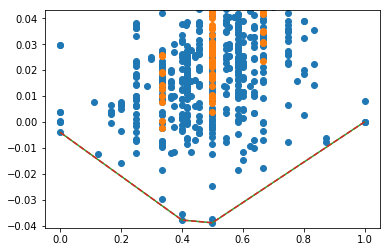

In [59]:
ch_agpt.plot(plt.gca(), ch_agpt.hulldft, ch_agpt.hullml); plt.show()